In [1]:
import joblib
import optuna
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import optuna.visualization as vis
import shap
from joblib import Parallel, delayed
from joblib import parallel_backend
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
#knn
def compute_shap_values(model, data, num_cores):
    explainer = shap.KernelExplainer(model.predict, data)
    shap_values = Parallel(n_jobs=num_cores)(delayed(explainer.shap_values)(instance) for instance in data)
    return np.array(shap_values)


# 4. Modeling

## 4.1 Model preparation

### 4.1.1 Train-Test Split

In [3]:
df = pd.read_csv("data_resampled_30.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,6.000000,148.000000,72.000000,35.000000,206.846154,33.600000,0.627000,50.000000,1
1,1.000000,85.000000,66.000000,29.000000,130.287879,26.600000,0.351000,31.000000,0
2,8.000000,183.000000,64.000000,33.000000,206.846154,23.300000,0.672000,32.000000,1
3,1.000000,89.000000,66.000000,23.000000,94.000000,28.100000,0.167000,21.000000,0
4,0.000000,137.000000,40.000000,35.000000,168.000000,43.100000,1.205000,33.000000,1
...,...,...,...,...,...,...,...,...,...
1071,1.000000,88.052741,77.969863,28.939725,75.977397,31.954040,0.367321,29.052741,0
1072,0.225333,129.027995,78.648003,39.140662,208.648003,36.547866,0.712740,23.225333,0
1073,5.269286,123.903930,68.000000,28.989955,123.758747,31.826784,0.438425,30.903930,0
1074,1.000000,100.073141,72.195043,14.902478,82.000000,18.814628,0.397341,21.512190,0


### 4.1.3 Cross Vallidation

In [4]:
#from sklearn.model_selection import RepeatedKFold
rs=123

cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=rs)


## Basic Structure of an Optuna Optimization Script

The overall process works differently from the brute-force approach of GridSearchCV. Because of this, let's cover off the different components of the process:

1. Defining the objective function
2. Creating a Study Object
3. Running the Optimization Process

The objective function is at the core of how Optuna optimizes the hyperparameter selections. While a brute-force grid search also seeks to minimize an objective function, it doesn't actually take into account what combination of hyperparameters is doing well or not.

## 4.2 KNN (K-Nearest Neighbors Algorithm)

In [5]:
# Creating an Objective Function

def objective_knn(trial):
    
    # Define hyperparameters
    param_knn = {'n_neighbors' : trial.suggest_int('n_neighbors', 1, 100)
    ,'weights' : trial.suggest_categorical('weights', ['uniform', 'distance']),
    'metric' : trial.suggest_categorical('metric', ['euclidean', 'manhattan','minkowski']),
    'p' : trial.suggest_int('p', 1, 50),
    'algorithm' : trial.suggest_categorical('algorithm',['auto','ball_tree', 'kd_tree', 'brute']),
    'leaf_size' : trial.suggest_int('leaf_size', 1, 100)}

    # Create and train the model
    knn = KNeighborsClassifier(**param_knn)
    knn.fit(x_train_, y_train)

    # Evaluate the model
    score = cross_val_score(knn, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

In [6]:
def display_results(y_test, y_pred, cm_title):
        cm = confusion_matrix(y_test,y_pred)
        sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
        print(classification_report(y_test,y_pred))

## Modelling and shap 

[I 2024-08-26 15:27:41,954] A new study created in memory with name: KNN
[I 2024-08-26 15:27:42,768] Trial 1 finished with value: 0.6651968948235693 and parameters: {'n_neighbors': 61, 'weights': 'distance', 'metric': 'euclidean', 'p': 27, 'algorithm': 'ball_tree', 'leaf_size': 76}. Best is trial 1 with value: 0.6651968948235693.
[I 2024-08-26 15:27:42,838] Trial 5 finished with value: 0.7669198262620078 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'minkowski', 'p': 19, 'algorithm': 'kd_tree', 'leaf_size': 21}. Best is trial 5 with value: 0.7669198262620078.
[I 2024-08-26 15:27:42,893] Trial 3 finished with value: 0.6965505269822299 and parameters: {'n_neighbors': 35, 'weights': 'distance', 'metric': 'euclidean', 'p': 14, 'algorithm': 'brute', 'leaf_size': 63}. Best is trial 5 with value: 0.7669198262620078.
[I 2024-08-26 15:27:43,696] Trial 4 finished with value: 0.7149618420506502 and parameters: {'n_neighbors': 36, 'weights': 'uniform', 'metric': 'manhattan', 

Best trial: 5
Best accuracy: 0.7669198262620078
Best hyperparameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'minkowski', 'p': 19, 'algorithm': 'kd_tree', 'leaf_size': 21}
              precision    recall  f1-score   support

           0       0.67      0.94      0.78        50
           1       0.90      0.54      0.68        50

    accuracy                           0.74       100
   macro avg       0.79      0.74      0.73       100
weighted avg       0.79      0.74      0.73       100



[I 2024-08-26 15:28:37,725] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.050631  0.031821       0.017893       0.071798  0.175726  0.087988   
1      0.015690  0.063929       0.008381       0.072738  0.220690  0.025881   
2      0.009250  0.144250       0.014750       0.042107  0.094679  0.013321   
3      0.025726  0.149869       0.006679       0.008536  0.149393  0.008036   
4      0.034286  0.135286       0.005429       0.012952  0.111524  0.000214   
..          ...       ...            ...            ...       ...       ...   
95     0.007631  0.322679       0.070869       0.030988  0.212893  0.056369   
96     0.163845  0.136226       0.151821       0.039607  0.182440  0.079536   
97     0.065310  0.626190       0.002548       0.062595  0.077095  0.031262   
98     0.206381  0.224238       0.048881       0.221000  0.104690  0.142333   
99     0.081345  0.016393       0.033345       0.052107  0.368321  0.083060   

         DPF       Age  Outcome  
0   0.042655  0.0

[I 2024-08-26 15:28:38,888] Trial 5 finished with value: 0.7491224220492075 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'euclidean', 'p': 45, 'algorithm': 'kd_tree', 'leaf_size': 7}. Best is trial 5 with value: 0.7491224220492075.
[I 2024-08-26 15:28:38,913] Trial 4 finished with value: 0.7288913583796375 and parameters: {'n_neighbors': 43, 'weights': 'distance', 'metric': 'manhattan', 'p': 33, 'algorithm': 'kd_tree', 'leaf_size': 23}. Best is trial 5 with value: 0.7491224220492075.
[I 2024-08-26 15:28:39,073] Trial 1 finished with value: 0.7068855184853843 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'metric': 'euclidean', 'p': 31, 'algorithm': 'kd_tree', 'leaf_size': 23}. Best is trial 5 with value: 0.7491224220492075.
[I 2024-08-26 15:28:39,378] Trial 0 finished with value: 0.6736393517680537 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'minkowski', 'p': 22, 'algorithm': 'kd_tree', 'leaf_size': 88}. Best is trial 5 with val

Best trial: 5
Best accuracy: 0.7491224220492075
Best hyperparameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'euclidean', 'p': 45, 'algorithm': 'kd_tree', 'leaf_size': 7}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 15:28:56,835] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.050464  0.082345       0.003083       0.064607  0.210845  0.083845   
1      0.024917  0.116107       0.003107       0.020964  0.164679  0.016655   
2      0.022071  0.080881       0.000881       0.070500  0.115286  0.006405   
3      0.029381  0.143929       0.000571       0.048071  0.156381  0.008119   
4      0.034119  0.125048       0.002048       0.022190  0.106976  0.002810   
..          ...       ...            ...            ...       ...       ...   
95     0.023750  0.292774       0.032655       0.069226  0.285393  0.030821   
96     0.099095  0.109738       0.096190       0.053429  0.202048  0.127714   
97     0.042190  0.248524       0.041619       0.274976  0.031595  0.036405   
98     0.249048  0.195024       0.027333       0.163881  0.213143  0.024095   
99     0.083619  0.013476       0.019810       0.133833  0.339667  0.020024   

         DPF       Age  Outcome  
0   0.042679  0.0

[I 2024-08-26 15:28:57,445] Trial 4 finished with value: 0.7509278125316233 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'metric': 'manhattan', 'p': 39, 'algorithm': 'kd_tree', 'leaf_size': 92}. Best is trial 4 with value: 0.7509278125316233.
[I 2024-08-26 15:28:57,487] Trial 5 finished with value: 0.6848781453120024 and parameters: {'n_neighbors': 45, 'weights': 'distance', 'metric': 'euclidean', 'p': 12, 'algorithm': 'auto', 'leaf_size': 93}. Best is trial 4 with value: 0.7509278125316233.
[I 2024-08-26 15:28:57,618] Trial 1 finished with value: 0.680282449832213 and parameters: {'n_neighbors': 52, 'weights': 'distance', 'metric': 'euclidean', 'p': 23, 'algorithm': 'brute', 'leaf_size': 60}. Best is trial 4 with value: 0.7509278125316233.
[I 2024-08-26 15:28:58,232] Trial 8 finished with value: 0.6746730111069938 and parameters: {'n_neighbors': 54, 'weights': 'distance', 'metric': 'euclidean', 'p': 24, 'algorithm': 'brute', 'leaf_size': 61}. Best is trial 4 with value: 

Best trial: 4
Best accuracy: 0.7509278125316233
Best hyperparameters: {'n_neighbors': 27, 'weights': 'distance', 'metric': 'manhattan', 'p': 39, 'algorithm': 'kd_tree', 'leaf_size': 92}
              precision    recall  f1-score   support

           0       0.72      0.98      0.83        50
           1       0.97      0.62      0.76        50

    accuracy                           0.80       100
   macro avg       0.84      0.80      0.79       100
weighted avg       0.84      0.80      0.79       100



[I 2024-08-26 15:29:09,359] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.042381  0.058143       0.001833       0.074214  0.203905  0.054262   
1      0.021012  0.054131       0.001560       0.014821  0.201345  0.026512   
2      0.029821  0.077607       0.001893       0.063631  0.101298  0.003107   
3      0.030738  0.140643       0.001714       0.049214  0.147714  0.006810   
4      0.031452  0.081810       0.000357       0.041500  0.119976  0.001857   
..          ...       ...            ...            ...       ...       ...   
95     0.028702  0.277583       0.008464       0.181512  0.292060  0.011631   
96     0.067679  0.079560       0.014393       0.206607  0.325369  0.004440   
97     0.115976  0.112714       0.014167       0.155286  0.004738  0.015881   
98     0.283929  0.144786       0.017333       0.110405  0.273595  0.006024   
99     0.091560  0.014417       0.005988       0.181274  0.324131  0.013036   

         DPF       Age  Outcome  
0   0.025190  0.0

[I 2024-08-26 15:29:10,200] Trial 4 finished with value: 0.7632369508939632 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'manhattan', 'p': 14, 'algorithm': 'auto', 'leaf_size': 14}. Best is trial 4 with value: 0.7632369508939632.
[I 2024-08-26 15:29:10,454] Trial 5 finished with value: 0.6850919493689592 and parameters: {'n_neighbors': 73, 'weights': 'distance', 'metric': 'manhattan', 'p': 5, 'algorithm': 'auto', 'leaf_size': 1}. Best is trial 4 with value: 0.7632369508939632.
[I 2024-08-26 15:29:10,986] Trial 6 finished with value: 0.7096166360735459 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'metric': 'euclidean', 'p': 34, 'algorithm': 'kd_tree', 'leaf_size': 72}. Best is trial 4 with value: 0.7632369508939632.
[I 2024-08-26 15:29:10,992] Trial 2 finished with value: 0.7068855184853843 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'metric': 'euclidean', 'p': 20, 'algorithm': 'brute', 'leaf_size': 9}. Best is trial 4 with value: 0.76

Best trial: 4
Best accuracy: 0.7632369508939632
Best hyperparameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'manhattan', 'p': 14, 'algorithm': 'auto', 'leaf_size': 14}
              precision    recall  f1-score   support

           0       0.74      0.96      0.83        50
           1       0.94      0.66      0.78        50

    accuracy                           0.81       100
   macro avg       0.84      0.81      0.81       100
weighted avg       0.84      0.81      0.81       100



[I 2024-08-26 15:29:23,314] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.035619  0.052810       0.001310       0.076214  0.222381  0.063095   
1      0.024179  0.049012       0.004869       0.018798  0.213250  0.030369   
2      0.033369  0.075583       0.002060       0.066369  0.118369  0.008083   
3      0.023393  0.142988       0.002012       0.051060  0.158655  0.007488   
4      0.035560  0.085774       0.004940       0.048679  0.134679  0.001036   
..          ...       ...            ...            ...       ...       ...   
95     0.016333  0.215976       0.005214       0.135119  0.316262  0.020952   
96     0.056262  0.041881       0.006167       0.209476  0.328810  0.024738   
97     0.115107  0.127869       0.024417       0.164369  0.000179  0.022107   
98     0.218119  0.137667       0.009810       0.098762  0.297214  0.002619   
99     0.073833  0.001786       0.004238       0.198357  0.329405  0.005071   

         DPF       Age  Outcome  
0   0.020214  0.0

[I 2024-08-26 15:29:24,265] Trial 2 finished with value: 0.696185956772977 and parameters: {'n_neighbors': 25, 'weights': 'uniform', 'metric': 'euclidean', 'p': 36, 'algorithm': 'auto', 'leaf_size': 15}. Best is trial 2 with value: 0.696185956772977.
[I 2024-08-26 15:29:24,301] Trial 5 finished with value: 0.6677434462425029 and parameters: {'n_neighbors': 60, 'weights': 'distance', 'metric': 'euclidean', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 17}. Best is trial 2 with value: 0.696185956772977.
[I 2024-08-26 15:29:24,777] Trial 4 finished with value: 0.626907346743063 and parameters: {'n_neighbors': 96, 'weights': 'uniform', 'metric': 'manhattan', 'p': 6, 'algorithm': 'brute', 'leaf_size': 45}. Best is trial 2 with value: 0.696185956772977.
[I 2024-08-26 15:29:24,918] Trial 7 finished with value: 0.7036316041900085 and parameters: {'n_neighbors': 61, 'weights': 'distance', 'metric': 'manhattan', 'p': 35, 'algorithm': 'auto', 'leaf_size': 59}. Best is trial 7 with value: 0.70363

Best trial: 7
Best accuracy: 0.7036316041900085
Best hyperparameters: {'n_neighbors': 61, 'weights': 'distance', 'metric': 'manhattan', 'p': 35, 'algorithm': 'auto', 'leaf_size': 59}
              precision    recall  f1-score   support

           0       0.68      0.98      0.80        50
           1       0.96      0.54      0.69        50

    accuracy                           0.76       100
   macro avg       0.82      0.76      0.75       100
weighted avg       0.82      0.76      0.75       100



[I 2024-08-26 15:29:38,931] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.037738  0.072524       0.008238       0.070548  0.150048  0.051429   
1      0.023393  0.078345       0.004488       0.000988  0.146940  0.007917   
2      0.026131  0.069393       0.000131       0.046393  0.072369  0.013679   
3      0.027345  0.114774       0.004107       0.050821  0.118845  0.006536   
4      0.025417  0.083060       0.003250       0.044440  0.094083  0.006131   
..          ...       ...            ...            ...       ...       ...   
95     0.038036  0.339179       0.003345       0.184750  0.244060  0.005655   
96     0.110750  0.175702       0.009845       0.185512  0.265798  0.014750   
97     0.103143  0.092381       0.004381       0.127714  0.035476  0.017810   
98     0.259250  0.205702       0.019917       0.143536  0.218298  0.021179   
99     0.108048  0.045810       0.005929       0.194619  0.251881  0.018452   

         DPF       Age  Outcome  
0   0.028548  0.0

[I 2024-08-26 15:29:39,737] Trial 0 finished with value: 0.7635141961745284 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'euclidean', 'p': 37, 'algorithm': 'ball_tree', 'leaf_size': 58}. Best is trial 0 with value: 0.7635141961745284.
[I 2024-08-26 15:29:40,148] Trial 4 finished with value: 0.7090374125719517 and parameters: {'n_neighbors': 38, 'weights': 'uniform', 'metric': 'manhattan', 'p': 1, 'algorithm': 'kd_tree', 'leaf_size': 67}. Best is trial 0 with value: 0.7635141961745284.
[I 2024-08-26 15:29:40,286] Trial 2 finished with value: 0.622051545681606 and parameters: {'n_neighbors': 34, 'weights': 'distance', 'metric': 'minkowski', 'p': 16, 'algorithm': 'kd_tree', 'leaf_size': 3}. Best is trial 0 with value: 0.7635141961745284.
[I 2024-08-26 15:29:40,423] Trial 5 finished with value: 0.6340318611095723 and parameters: {'n_neighbors': 91, 'weights': 'uniform', 'metric': 'manhattan', 'p': 14, 'algorithm': 'ball_tree', 'leaf_size': 19}. Best is trial 0 with v

Best trial: 8
Best accuracy: 0.7766543656978588
Best hyperparameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'p': 23, 'algorithm': 'brute', 'leaf_size': 100}
              precision    recall  f1-score   support

           0       0.72      0.92      0.81        50
           1       0.89      0.64      0.74        50

    accuracy                           0.78       100
   macro avg       0.80      0.78      0.78       100
weighted avg       0.80      0.78      0.78       100



[I 2024-08-26 15:29:55,446] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.033655  0.049560       0.002464       0.071107  0.223440  0.071083   
1      0.031488  0.051012       0.005869       0.017298  0.217131  0.031560   
2      0.038262  0.068667       0.003238       0.069548  0.128738  0.006500   
3      0.023988  0.138393       0.001440       0.052155  0.163988  0.017036   
4      0.041226  0.080560       0.000155       0.048345  0.143202  0.003655   
..          ...       ...            ...            ...       ...       ...   
95     0.004845  0.209393       0.011274       0.099131  0.314655  0.019607   
96     0.098738  0.100643       0.144310       0.115881  0.250976  0.134262   
97     0.080345  0.132512       0.026464       0.179464  0.013750  0.035798   
98     0.185988  0.136274       0.009583       0.083417  0.301655  0.007250   
99     0.069298  0.002536       0.005464       0.164893  0.353369  0.008655   

         DPF       Age  Outcome  
0   0.012226  0.0

[I 2024-08-26 15:29:56,269] Trial 5 finished with value: 0.6385239807388157 and parameters: {'n_neighbors': 82, 'weights': 'distance', 'metric': 'euclidean', 'p': 36, 'algorithm': 'auto', 'leaf_size': 72}. Best is trial 5 with value: 0.6385239807388157.
[I 2024-08-26 15:29:56,657] Trial 3 finished with value: 0.7757977682487375 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'manhattan', 'p': 22, 'algorithm': 'ball_tree', 'leaf_size': 61}. Best is trial 3 with value: 0.7757977682487375.
[I 2024-08-26 15:29:56,860] Trial 1 finished with value: 0.634514242186258 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'metric': 'minkowski', 'p': 18, 'algorithm': 'kd_tree', 'leaf_size': 43}. Best is trial 3 with value: 0.7757977682487375.
[I 2024-08-26 15:29:57,105] Trial 4 finished with value: 0.5527021781444666 and parameters: {'n_neighbors': 86, 'weights': 'distance', 'metric': 'minkowski', 'p': 25, 'algorithm': 'kd_tree', 'leaf_size': 21}. Best is trial 3 with val

Best trial: 9
Best accuracy: 0.7760526642202566
Best hyperparameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan', 'p': 39, 'algorithm': 'ball_tree', 'leaf_size': 21}
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        50
           1       0.92      0.70      0.80        50

    accuracy                           0.82       100
   macro avg       0.84      0.82      0.82       100
weighted avg       0.84      0.82      0.82       100



[I 2024-08-26 15:30:07,557] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.031202  0.046583       0.002940       0.077369  0.236702  0.071655   
1      0.028917  0.055298       0.010298       0.016488  0.222274  0.033631   
2      0.033024  0.076595       0.003714       0.068405  0.134048  0.005238   
3      0.015643  0.133262       0.002976       0.054690  0.172286  0.012286   
4      0.040488  0.083583       0.001821       0.049202  0.159226  0.002440   
..          ...       ...            ...            ...       ...       ...   
95     0.006524  0.194476       0.010952       0.086238  0.319857  0.020500   
96     0.026440  0.033226       0.007964       0.197369  0.350345  0.003345   
97     0.078190  0.144405       0.036167       0.195048  0.020643  0.044452   
98     0.168583  0.133702       0.001107       0.081250  0.305750  0.001012   
99     0.057417  0.013369       0.004179       0.188345  0.356560  0.011679   

         DPF       Age  Outcome  
0   0.012060  0.0

[I 2024-08-26 15:30:08,242] Trial 5 finished with value: 0.7548221111762798 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'euclidean', 'p': 10, 'algorithm': 'ball_tree', 'leaf_size': 38}. Best is trial 5 with value: 0.7548221111762798.
[I 2024-08-26 15:30:08,482] Trial 0 finished with value: 0.6983388879716707 and parameters: {'n_neighbors': 34, 'weights': 'distance', 'metric': 'euclidean', 'p': 3, 'algorithm': 'auto', 'leaf_size': 10}. Best is trial 5 with value: 0.7548221111762798.
[I 2024-08-26 15:30:09,303] Trial 3 finished with value: 0.6987870293432572 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'metric': 'euclidean', 'p': 10, 'algorithm': 'brute', 'leaf_size': 5}. Best is trial 5 with value: 0.7548221111762798.
[I 2024-08-26 15:30:09,357] Trial 2 finished with value: 0.6531181143410599 and parameters: {'n_neighbors': 79, 'weights': 'uniform', 'metric': 'manhattan', 'p': 6, 'algorithm': 'kd_tree', 'leaf_size': 8}. Best is trial 5 with value: 0.

Best trial: 9
Best accuracy: 0.7710224796316301
Best hyperparameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'euclidean', 'p': 17, 'algorithm': 'ball_tree', 'leaf_size': 8}
              precision    recall  f1-score   support

           0       0.72      0.94      0.82        50
           1       0.91      0.64      0.75        50

    accuracy                           0.79       100
   macro avg       0.82      0.79      0.79       100
weighted avg       0.82      0.79      0.79       100



[I 2024-08-26 15:30:19,610] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.065036  0.061226       0.011179       0.076917  0.264417  0.068607   
1      0.019976  0.112310       0.005262       0.023048  0.180095  0.021667   
2      0.021940  0.143726       0.007607       0.053179  0.108155  0.005464   
3      0.028762  0.158786       0.002190       0.045857  0.163310  0.002119   
4      0.034250  0.142869       0.001440       0.021774  0.116488  0.001107   
..          ...       ...            ...            ...       ...       ...   
95     0.021286  0.286548       0.049357       0.034024  0.270952  0.036810   
96     0.014976  0.041000       0.017214       0.158810  0.309119  0.027810   
97     0.025464  0.560583       0.050988       0.051202  0.038036  0.080440   
98     0.258464  0.182893       0.022798       0.139655  0.200893  0.031536   
99     0.072214  0.006595       0.017262       0.132786  0.364310  0.035071   

         DPF       Age  Outcome  
0   0.033131  0.0

[I 2024-08-26 15:30:20,379] Trial 4 finished with value: 0.8073549784422046 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'manhattan', 'p': 36, 'algorithm': 'kd_tree', 'leaf_size': 60}. Best is trial 4 with value: 0.8073549784422046.
[I 2024-08-26 15:30:20,568] Trial 2 finished with value: 0.6014326653921701 and parameters: {'n_neighbors': 99, 'weights': 'distance', 'metric': 'euclidean', 'p': 16, 'algorithm': 'brute', 'leaf_size': 44}. Best is trial 4 with value: 0.8073549784422046.
[I 2024-08-26 15:30:21,190] Trial 5 finished with value: 0.6665125224436121 and parameters: {'n_neighbors': 67, 'weights': 'uniform', 'metric': 'manhattan', 'p': 8, 'algorithm': 'ball_tree', 'leaf_size': 39}. Best is trial 4 with value: 0.8073549784422046.
[I 2024-08-26 15:30:21,245] Trial 0 finished with value: 0.6338716011482074 and parameters: {'n_neighbors': 88, 'weights': 'uniform', 'metric': 'manhattan', 'p': 10, 'algorithm': 'kd_tree', 'leaf_size': 41}. Best is trial 4 with valu

Best trial: 4
Best accuracy: 0.8073549784422046
Best hyperparameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'manhattan', 'p': 36, 'algorithm': 'kd_tree', 'leaf_size': 60}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 15:30:39,297] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.068357  0.025143       0.005643       0.165929  0.248310  0.075381   
1      0.031452  0.056119       0.013167       0.016048  0.188595  0.042333   
2      0.019012  0.128131       0.001750       0.045893  0.133726  0.004964   
3      0.007476  0.132452       0.004524       0.047714  0.173833  0.003000   
4      0.038179  0.123726       0.002893       0.056488  0.174893  0.019679   
..          ...       ...            ...            ...       ...       ...   
95     0.004155  0.223083       0.017607       0.095917  0.225607  0.035512   
96     0.004095  0.102238       0.021714       0.152071  0.301190  0.019952   
97     0.101024  0.146286       0.033452       0.226190  0.021333  0.066881   
98     0.165940  0.147036       0.015321       0.041369  0.188702  0.023440   
99     0.008440  0.016679       0.004845       0.160440  0.356250  0.106083   

         DPF       Age  Outcome  
0   0.031119  0.0

[I 2024-08-26 15:30:40,184] Trial 2 finished with value: 0.6559234574707237 and parameters: {'n_neighbors': 67, 'weights': 'distance', 'metric': 'euclidean', 'p': 21, 'algorithm': 'auto', 'leaf_size': 27}. Best is trial 2 with value: 0.6559234574707237.
[I 2024-08-26 15:30:40,187] Trial 5 finished with value: 0.6567112135280165 and parameters: {'n_neighbors': 70, 'weights': 'distance', 'metric': 'euclidean', 'p': 11, 'algorithm': 'auto', 'leaf_size': 17}. Best is trial 5 with value: 0.6567112135280165.
[I 2024-08-26 15:30:40,206] Trial 0 finished with value: 0.6175653584042965 and parameters: {'n_neighbors': 91, 'weights': 'distance', 'metric': 'euclidean', 'p': 21, 'algorithm': 'ball_tree', 'leaf_size': 51}. Best is trial 5 with value: 0.6567112135280165.
[I 2024-08-26 15:30:40,742] Trial 7 finished with value: 0.8073549784422046 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan', 'p': 19, 'algorithm': 'auto', 'leaf_size': 95}. Best is trial 7 with value: 

Best trial: 7
Best accuracy: 0.8073549784422046
Best hyperparameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan', 'p': 19, 'algorithm': 'auto', 'leaf_size': 95}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 15:30:49,544] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.068357  0.025143       0.005643       0.165929  0.248310  0.075381   
1      0.031452  0.056119       0.013167       0.016048  0.188595  0.042333   
2      0.019012  0.128131       0.001750       0.045893  0.133726  0.004964   
3      0.007476  0.132452       0.004524       0.047714  0.173833  0.003000   
4      0.038179  0.123726       0.002893       0.056488  0.174893  0.019679   
..          ...       ...            ...            ...       ...       ...   
95     0.004155  0.223083       0.017607       0.095917  0.225607  0.035512   
96     0.004095  0.102238       0.021714       0.152071  0.301190  0.019952   
97     0.101024  0.146286       0.033452       0.226190  0.021333  0.066881   
98     0.165940  0.147036       0.015321       0.041369  0.188702  0.023440   
99     0.008440  0.016679       0.004845       0.160440  0.356250  0.106083   

         DPF       Age  Outcome  
0   0.031119  0.0

[I 2024-08-26 15:30:50,594] Trial 3 finished with value: 0.751260626223695 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'metric': 'manhattan', 'p': 23, 'algorithm': 'kd_tree', 'leaf_size': 59}. Best is trial 3 with value: 0.751260626223695.
[I 2024-08-26 15:30:50,612] Trial 4 finished with value: 0.7788004986019534 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan', 'p': 5, 'algorithm': 'ball_tree', 'leaf_size': 3}. Best is trial 4 with value: 0.7788004986019534.
[I 2024-08-26 15:30:51,151] Trial 0 finished with value: 0.6155780300069448 and parameters: {'n_neighbors': 39, 'weights': 'distance', 'metric': 'minkowski', 'p': 36, 'algorithm': 'auto', 'leaf_size': 8}. Best is trial 4 with value: 0.7788004986019534.
[I 2024-08-26 15:30:51,208] Trial 1 finished with value: 0.6426772222952261 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'metric': 'minkowski', 'p': 18, 'algorithm': 'auto', 'leaf_size': 65}. Best is trial 4 with value: 0.

Best trial: 4
Best accuracy: 0.7788004986019534
Best hyperparameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan', 'p': 5, 'algorithm': 'ball_tree', 'leaf_size': 3}
              precision    recall  f1-score   support

           0       0.73      0.94      0.82        50
           1       0.92      0.66      0.77        50

    accuracy                           0.80       100
   macro avg       0.83      0.80      0.80       100
weighted avg       0.83      0.80      0.80       100



[I 2024-08-26 15:31:05,968] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.035940  0.048226       0.002464       0.074631  0.230536  0.068012   
1      0.027857  0.051667       0.006619       0.018714  0.217405  0.029405   
2      0.037881  0.071071       0.004429       0.068857  0.129810  0.004476   
3      0.024381  0.137619       0.000952       0.053190  0.168214  0.009619   
4      0.037381  0.084357       0.000452       0.050667  0.145524  0.002238   
..          ...       ...            ...            ...       ...       ...   
95     0.008333  0.215262       0.005357       0.093167  0.327286  0.018786   
96     0.033024  0.036048       0.013000       0.211381  0.349595  0.000905   
97     0.084107  0.136679       0.027750       0.185226  0.013988  0.041464   
98     0.186536  0.137607       0.006226       0.081274  0.302726  0.003393   
99     0.063000  0.000071       0.000190       0.189762  0.348024  0.008571   

         DPF       Age  Outcome  
0   0.014250  0.0

[I 2024-08-26 15:31:07,095] Trial 5 finished with value: 0.7718482882197454 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'metric': 'manhattan', 'p': 50, 'algorithm': 'brute', 'leaf_size': 25}. Best is trial 5 with value: 0.7718482882197454.
[I 2024-08-26 15:31:07,190] Trial 2 finished with value: 0.6328026796061047 and parameters: {'n_neighbors': 83, 'weights': 'distance', 'metric': 'euclidean', 'p': 40, 'algorithm': 'kd_tree', 'leaf_size': 82}. Best is trial 5 with value: 0.7718482882197454.
[I 2024-08-26 15:31:07,441] Trial 0 finished with value: 0.6707174751965792 and parameters: {'n_neighbors': 39, 'weights': 'uniform', 'metric': 'euclidean', 'p': 4, 'algorithm': 'auto', 'leaf_size': 11}. Best is trial 5 with value: 0.7718482882197454.
[I 2024-08-26 15:31:07,975] Trial 6 finished with value: 0.7344888435548443 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'euclidean', 'p': 22, 'algorithm': 'ball_tree', 'leaf_size': 80}. Best is trial 5 with value:

Best trial: 5
Best accuracy: 0.7718482882197454
Best hyperparameters: {'n_neighbors': 9, 'weights': 'uniform', 'metric': 'manhattan', 'p': 50, 'algorithm': 'brute', 'leaf_size': 25}
              precision    recall  f1-score   support

           0       0.75      0.96      0.84        50
           1       0.94      0.68      0.79        50

    accuracy                           0.82       100
   macro avg       0.85      0.82      0.82       100
weighted avg       0.85      0.82      0.82       100



[I 2024-08-26 15:31:32,719] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.033690  0.045881       0.006167       0.073310  0.228714  0.071429   
1      0.030583  0.051798       0.007560       0.013845  0.220369  0.027107   
2      0.034667  0.071262       0.002857       0.065500  0.127214  0.006643   
3      0.019155  0.132583       0.001107       0.049869  0.169440  0.009750   
4      0.043262  0.079738       0.001143       0.049929  0.151286  0.000048   
..          ...       ...            ...            ...       ...       ...   
95     0.008345  0.204250       0.014655       0.089940  0.322536  0.026536   
96     0.027964  0.040702       0.005964       0.204274  0.347869  0.000940   
97     0.070452  0.151500       0.037048       0.183143  0.023905  0.035429   
98     0.187417  0.138583       0.006631       0.075440  0.301512  0.004012   
99     0.070226  0.004583       0.001012       0.177702  0.356369  0.012012   

         DPF       Age  Outcome  
0   0.012048  0.0

[I 2024-08-26 15:31:33,562] Trial 0 finished with value: 0.766433830128227 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'metric': 'manhattan', 'p': 47, 'algorithm': 'ball_tree', 'leaf_size': 4}. Best is trial 0 with value: 0.766433830128227.
[I 2024-08-26 15:31:33,664] Trial 2 finished with value: 0.6696910287344761 and parameters: {'n_neighbors': 57, 'weights': 'distance', 'metric': 'euclidean', 'p': 30, 'algorithm': 'kd_tree', 'leaf_size': 68}. Best is trial 0 with value: 0.766433830128227.
[I 2024-08-26 15:31:33,760] Trial 4 finished with value: 0.7072622720546099 and parameters: {'n_neighbors': 57, 'weights': 'distance', 'metric': 'manhattan', 'p': 13, 'algorithm': 'brute', 'leaf_size': 20}. Best is trial 0 with value: 0.766433830128227.
[I 2024-08-26 15:31:34,564] Trial 7 finished with value: 0.6067416987406964 and parameters: {'n_neighbors': 97, 'weights': 'distance', 'metric': 'euclidean', 'p': 17, 'algorithm': 'kd_tree', 'leaf_size': 27}. Best is trial 0 with valu

Best trial: 0
Best accuracy: 0.766433830128227
Best hyperparameters: {'n_neighbors': 21, 'weights': 'distance', 'metric': 'manhattan', 'p': 47, 'algorithm': 'ball_tree', 'leaf_size': 4}
              precision    recall  f1-score   support

           0       0.73      0.98      0.84        50
           1       0.97      0.64      0.77        50

    accuracy                           0.81       100
   macro avg       0.85      0.81      0.80       100
weighted avg       0.85      0.81      0.80       100



[I 2024-08-26 15:31:47,933] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.038119  0.055429       0.000095       0.073500  0.210167  0.057643   
1      0.018607  0.049893       0.003107       0.017226  0.208536  0.025464   
2      0.031476  0.072429       0.001405       0.066548  0.113333  0.004048   
3      0.026167  0.141143       0.001738       0.050381  0.153786  0.005262   
4      0.032048  0.080452       0.002310       0.045905  0.127000  0.001214   
..          ...       ...            ...            ...       ...       ...   
95     0.013250  0.223726       0.003393       0.145274  0.311988  0.022440   
96     0.056702  0.055393       0.007607       0.223179  0.324536  0.002655   
97     0.120274  0.122512       0.018988       0.156393  0.004536  0.016631   
98     0.243786  0.140595       0.013119       0.100238  0.291024  0.003238   
99     0.075417  0.001083       0.005083       0.203655  0.328012  0.009274   

         DPF       Age  Outcome  
0   0.020095  0.0

[I 2024-08-26 15:31:48,801] Trial 4 finished with value: 0.7926992116380158 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan', 'p': 39, 'algorithm': 'auto', 'leaf_size': 64}. Best is trial 4 with value: 0.7926992116380158.
[I 2024-08-26 15:31:49,132] Trial 2 finished with value: 0.7403967294487727 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'metric': 'manhattan', 'p': 39, 'algorithm': 'auto', 'leaf_size': 23}. Best is trial 4 with value: 0.7926992116380158.
[I 2024-08-26 15:31:49,218] Trial 1 finished with value: 0.6196494377443921 and parameters: {'n_neighbors': 88, 'weights': 'distance', 'metric': 'euclidean', 'p': 38, 'algorithm': 'ball_tree', 'leaf_size': 45}. Best is trial 4 with value: 0.7926992116380158.
[I 2024-08-26 15:31:49,342] Trial 3 finished with value: 0.6635875411439457 and parameters: {'n_neighbors': 38, 'weights': 'uniform', 'metric': 'euclidean', 'p': 33, 'algorithm': 'kd_tree', 'leaf_size': 39}. Best is trial 4 with value:

Best trial: 4
Best accuracy: 0.7926992116380158
Best hyperparameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan', 'p': 39, 'algorithm': 'auto', 'leaf_size': 64}
              precision    recall  f1-score   support

           0       0.74      0.98      0.84        50
           1       0.97      0.66      0.79        50

    accuracy                           0.82       100
   macro avg       0.86      0.82      0.82       100
weighted avg       0.86      0.82      0.82       100



[I 2024-08-26 15:31:58,845] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.043107  0.028488       0.010298       0.084202  0.261274  0.059869   
1      0.030571  0.052810       0.010571       0.024452  0.185667  0.017667   
2      0.020179  0.109821       0.004107       0.049940  0.121250  0.000774   
3      0.014655  0.120821       0.002036       0.047083  0.166036  0.000798   
4      0.032238  0.080571       0.001952       0.048500  0.166643  0.011857   
..          ...       ...            ...            ...       ...       ...   
95     0.012905  0.212262       0.025619       0.084024  0.253167  0.043119   
96     0.002345  0.067345       0.009345       0.180488  0.336512  0.009988   
97     0.078167  0.156548       0.049310       0.179333  0.012381  0.043857   
98     0.203202  0.122702       0.091655       0.010655  0.190012  0.012464   
99     0.027417  0.025583       0.010274       0.182821  0.365988  0.088250   

         DPF       Age  Outcome  
0   0.019893  0.0

[I 2024-08-26 15:31:59,860] Trial 3 finished with value: 0.6884957714577551 and parameters: {'n_neighbors': 31, 'weights': 'uniform', 'metric': 'minkowski', 'p': 2, 'algorithm': 'ball_tree', 'leaf_size': 66}. Best is trial 3 with value: 0.6884957714577551.
[I 2024-08-26 15:32:00,106] Trial 0 finished with value: 0.5681947097221713 and parameters: {'n_neighbors': 94, 'weights': 'uniform', 'metric': 'euclidean', 'p': 38, 'algorithm': 'ball_tree', 'leaf_size': 38}. Best is trial 3 with value: 0.6884957714577551.
[I 2024-08-26 15:32:00,161] Trial 1 finished with value: 0.5813250819050712 and parameters: {'n_neighbors': 93, 'weights': 'uniform', 'metric': 'euclidean', 'p': 32, 'algorithm': 'brute', 'leaf_size': 14}. Best is trial 3 with value: 0.6884957714577551.
[I 2024-08-26 15:32:00,447] Trial 5 finished with value: 0.5555513914763641 and parameters: {'n_neighbors': 94, 'weights': 'distance', 'metric': 'minkowski', 'p': 7, 'algorithm': 'kd_tree', 'leaf_size': 41}. Best is trial 3 with va

Best trial: 8
Best accuracy: 0.7204910451244401
Best hyperparameters: {'n_neighbors': 46, 'weights': 'distance', 'metric': 'manhattan', 'p': 19, 'algorithm': 'brute', 'leaf_size': 40}
              precision    recall  f1-score   support

           0       0.70      0.98      0.82        50
           1       0.97      0.58      0.72        50

    accuracy                           0.78       100
   macro avg       0.83      0.78      0.77       100
weighted avg       0.83      0.78      0.77       100



[I 2024-08-26 15:32:17,916] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.044036  0.065869       0.010583       0.075536  0.179298  0.057036   
1      0.023810  0.072619       0.002381       0.005857  0.166976  0.010595   
2      0.030024  0.076262       0.000095       0.054738  0.082643  0.004762   
3      0.028833  0.125476       0.005190       0.053262  0.130762  0.008429   
4      0.025798  0.087940       0.001607       0.045940  0.106298  0.008083   
..          ...       ...            ...            ...       ...       ...   
95     0.036869  0.341583       0.005036       0.194345  0.263679  0.004560   
96     0.083500  0.140524       0.008524       0.189357  0.287048  0.002190   
97     0.119345  0.096060       0.002107       0.143464  0.021155  0.015798   
98     0.266917  0.150488       0.013083       0.142512  0.236464  0.007226   
99     0.102405  0.026500       0.003452       0.203929  0.279381  0.012143   

         DPF       Age  Outcome  
0   0.025821  0.0

[I 2024-08-26 15:32:19,204] Trial 2 finished with value: 0.6976450250701798 and parameters: {'n_neighbors': 46, 'weights': 'uniform', 'metric': 'manhattan', 'p': 25, 'algorithm': 'ball_tree', 'leaf_size': 49}. Best is trial 2 with value: 0.6976450250701798.
[I 2024-08-26 15:32:19,308] Trial 5 finished with value: 0.6384438280780457 and parameters: {'n_neighbors': 39, 'weights': 'distance', 'metric': 'minkowski', 'p': 6, 'algorithm': 'auto', 'leaf_size': 1}. Best is trial 2 with value: 0.6976450250701798.
[I 2024-08-26 15:32:19,327] Trial 1 finished with value: 0.5956766094573264 and parameters: {'n_neighbors': 84, 'weights': 'uniform', 'metric': 'euclidean', 'p': 37, 'algorithm': 'kd_tree', 'leaf_size': 53}. Best is trial 2 with value: 0.6976450250701798.
[I 2024-08-26 15:32:19,460] Trial 0 finished with value: 0.598423583709991 and parameters: {'n_neighbors': 87, 'weights': 'uniform', 'metric': 'euclidean', 'p': 12, 'algorithm': 'brute', 'leaf_size': 77}. Best is trial 2 with value: 0

Best trial: 6
Best accuracy: 0.7141348692952963
Best hyperparameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'minkowski', 'p': 13, 'algorithm': 'brute', 'leaf_size': 100}
              precision    recall  f1-score   support

           0       0.67      0.94      0.78        50
           1       0.90      0.54      0.68        50

    accuracy                           0.74       100
   macro avg       0.79      0.74      0.73       100
weighted avg       0.79      0.74      0.73       100



[I 2024-08-26 15:34:24,879] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.051167  0.093095       0.015381       0.054762  0.156476  0.088857   
1      0.025869  0.099583       0.000179       0.076845  0.199488  0.011512   
2      0.016940  0.108679       0.005917       0.069012  0.083964  0.007488   
3      0.028988  0.155655       0.007702       0.017583  0.138464  0.008893   
4      0.030774  0.154226       0.003583       0.006655  0.063250  0.001869   
..          ...       ...            ...            ...       ...       ...   
95     0.005833  0.313952       0.067238       0.056429  0.244310  0.047905   
96     0.022631  0.166345       0.114964       0.013464  0.158464  0.116274   
97     0.084690  0.562429       0.014048       0.080810  0.105429  0.066762   
98     0.218345  0.214393       0.036012       0.217060  0.093131  0.078202   
99     0.100083  0.010536       0.037345       0.085274  0.352964  0.025155   

         DPF       Age  Outcome  
0   0.053714  0.0

[I 2024-08-26 15:34:25,969] Trial 2 finished with value: 0.73202288255555 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'metric': 'manhattan', 'p': 19, 'algorithm': 'auto', 'leaf_size': 46}. Best is trial 2 with value: 0.73202288255555.
[I 2024-08-26 15:34:26,028] Trial 4 finished with value: 0.6901994667552452 and parameters: {'n_neighbors': 66, 'weights': 'distance', 'metric': 'manhattan', 'p': 50, 'algorithm': 'brute', 'leaf_size': 53}. Best is trial 2 with value: 0.73202288255555.
[I 2024-08-26 15:34:26,119] Trial 1 finished with value: 0.6987213658077888 and parameters: {'n_neighbors': 63, 'weights': 'distance', 'metric': 'manhattan', 'p': 13, 'algorithm': 'brute', 'leaf_size': 48}. Best is trial 2 with value: 0.73202288255555.
[I 2024-08-26 15:34:26,575] Trial 0 finished with value: 0.6865315453071185 and parameters: {'n_neighbors': 56, 'weights': 'uniform', 'metric': 'manhattan', 'p': 4, 'algorithm': 'brute', 'leaf_size': 75}. Best is trial 2 with value: 0.7320228825

Best trial: 6
Best accuracy: 0.7415491699301
Best hyperparameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'manhattan', 'p': 26, 'algorithm': 'ball_tree', 'leaf_size': 4}
              precision    recall  f1-score   support

           0       0.69      0.96      0.80        50
           1       0.93      0.56      0.70        50

    accuracy                           0.76       100
   macro avg       0.81      0.76      0.75       100
weighted avg       0.81      0.76      0.75       100



[I 2024-08-26 15:34:52,776] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.036810  0.026452       0.010167       0.062286  0.195310  0.071548   
1      0.021524  0.042095       0.002929       0.014714  0.195571  0.027810   
2      0.028524  0.068000       0.001738       0.056381  0.114286  0.001976   
3      0.023607  0.119083       0.004607       0.045298  0.152417  0.002036   
4      0.040536  0.071321       0.005536       0.037345  0.134679  0.004060   
..          ...       ...            ...            ...       ...       ...   
95     0.010595  0.224857       0.017571       0.113833  0.313571  0.036429   
96     0.035452  0.040214       0.010000       0.200500  0.322262  0.028262   
97     0.076571  0.137643       0.031381       0.182476  0.013667  0.028810   
98     0.203738  0.137381       0.023024       0.064429  0.286190  0.023095   
99     0.075679  0.018012       0.001107       0.222655  0.354964  0.019679   

         DPF       Age  Outcome  
0   0.000810  0.0

[I 2024-08-26 15:34:53,889] Trial 4 finished with value: 0.6607615325222872 and parameters: {'n_neighbors': 90, 'weights': 'distance', 'metric': 'manhattan', 'p': 35, 'algorithm': 'brute', 'leaf_size': 27}. Best is trial 4 with value: 0.6607615325222872.
[I 2024-08-26 15:34:54,508] Trial 5 finished with value: 0.7522405254889167 and parameters: {'n_neighbors': 21, 'weights': 'uniform', 'metric': 'manhattan', 'p': 39, 'algorithm': 'auto', 'leaf_size': 1}. Best is trial 5 with value: 0.7522405254889167.
[I 2024-08-26 15:34:54,520] Trial 0 finished with value: 0.6875486788315357 and parameters: {'n_neighbors': 59, 'weights': 'uniform', 'metric': 'manhattan', 'p': 40, 'algorithm': 'ball_tree', 'leaf_size': 75}. Best is trial 5 with value: 0.7522405254889167.
[I 2024-08-26 15:34:54,608] Trial 2 finished with value: 0.6085494220359103 and parameters: {'n_neighbors': 80, 'weights': 'uniform', 'metric': 'euclidean', 'p': 6, 'algorithm': 'kd_tree', 'leaf_size': 52}. Best is trial 5 with value: 

Best trial: 5
Best accuracy: 0.7522405254889167
Best hyperparameters: {'n_neighbors': 21, 'weights': 'uniform', 'metric': 'manhattan', 'p': 39, 'algorithm': 'auto', 'leaf_size': 1}
              precision    recall  f1-score   support

           0       0.71      0.96      0.81        50
           1       0.94      0.60      0.73        50

    accuracy                           0.78       100
   macro avg       0.82      0.78      0.77       100
weighted avg       0.82      0.78      0.77       100



[I 2024-08-26 15:35:33,494] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.039940  0.056417       0.003845       0.074060  0.204631  0.056131   
1      0.017726  0.054798       0.000702       0.017869  0.199845  0.023060   
2      0.032226  0.072845       0.000202       0.060417  0.106060  0.003607   
3      0.027810  0.137381       0.000500       0.052452  0.149667  0.006405   
4      0.035810  0.081571       0.000500       0.045119  0.120643  0.002452   
..          ...       ...            ...            ...       ...       ...   
95     0.021726  0.234298       0.000964       0.174583  0.304988  0.020202   
96     0.055310  0.055500       0.006119       0.217310  0.318929  0.005786   
97     0.122905  0.118119       0.013762       0.147905  0.001690  0.014571   
98     0.248107  0.139060       0.015321       0.097131  0.290869  0.003964   
99     0.082048  0.013952       0.004619       0.203214  0.321190  0.006857   

         DPF       Age  Outcome  
0   0.021417  0.0

[I 2024-08-26 15:35:34,481] Trial 3 finished with value: 0.7572372466817389 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'metric': 'manhattan', 'p': 42, 'algorithm': 'kd_tree', 'leaf_size': 72}. Best is trial 3 with value: 0.7572372466817389.
[I 2024-08-26 15:35:34,559] Trial 0 finished with value: 0.6647198197186923 and parameters: {'n_neighbors': 87, 'weights': 'distance', 'metric': 'manhattan', 'p': 12, 'algorithm': 'kd_tree', 'leaf_size': 79}. Best is trial 3 with value: 0.7572372466817389.
[I 2024-08-26 15:35:34,589] Trial 2 finished with value: 0.7425442885825211 and parameters: {'n_neighbors': 37, 'weights': 'distance', 'metric': 'manhattan', 'p': 37, 'algorithm': 'kd_tree', 'leaf_size': 39}. Best is trial 3 with value: 0.7572372466817389.
[I 2024-08-26 15:35:35,054] Trial 5 finished with value: 0.6818369986624389 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'metric': 'euclidean', 'p': 33, 'algorithm': 'ball_tree', 'leaf_size': 92}. Best is trial 3 wit

Best trial: 3
Best accuracy: 0.7572372466817389
Best hyperparameters: {'n_neighbors': 26, 'weights': 'distance', 'metric': 'manhattan', 'p': 42, 'algorithm': 'kd_tree', 'leaf_size': 72}
              precision    recall  f1-score   support

           0       0.72      0.96      0.82        50
           1       0.94      0.62      0.75        50

    accuracy                           0.79       100
   macro avg       0.83      0.79      0.78       100
weighted avg       0.83      0.79      0.78       100



[I 2024-08-26 15:35:49,082] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.041048  0.061214       0.001429       0.077095  0.206071  0.056310   
1      0.022155  0.054655       0.000655       0.016869  0.202321  0.028464   
2      0.030845  0.079726       0.003845       0.062107  0.103774  0.004917   
3      0.029310  0.142476       0.002667       0.052667  0.150714  0.007333   
4      0.034333  0.083595       0.000143       0.045976  0.122810  0.000643   
..          ...       ...            ...            ...       ...       ...   
95     0.026964  0.263440       0.007250       0.189369  0.289560  0.014750   
96     0.056643  0.075881       0.017119       0.206238  0.323571  0.010714   
97     0.115333  0.115310       0.017786       0.156190  0.003476  0.018310   
98     0.256714  0.142071       0.014333       0.104024  0.277071  0.004619   
99     0.083131  0.011750       0.004417       0.200393  0.315250  0.008988   

         DPF       Age  Outcome  
0   0.024381  0.0

[I 2024-08-26 15:35:50,080] Trial 0 finished with value: 0.679240023839892 and parameters: {'n_neighbors': 49, 'weights': 'distance', 'metric': 'euclidean', 'p': 42, 'algorithm': 'auto', 'leaf_size': 39}. Best is trial 0 with value: 0.679240023839892.
[I 2024-08-26 15:35:50,115] Trial 1 finished with value: 0.6067416987406964 and parameters: {'n_neighbors': 97, 'weights': 'distance', 'metric': 'euclidean', 'p': 41, 'algorithm': 'auto', 'leaf_size': 93}. Best is trial 0 with value: 0.679240023839892.
[I 2024-08-26 15:35:51,085] Trial 7 finished with value: 0.6689685286329177 and parameters: {'n_neighbors': 84, 'weights': 'distance', 'metric': 'manhattan', 'p': 39, 'algorithm': 'kd_tree', 'leaf_size': 89}. Best is trial 0 with value: 0.679240023839892.
[I 2024-08-26 15:35:51,245] Trial 4 finished with value: 0.640616750942512 and parameters: {'n_neighbors': 61, 'weights': 'uniform', 'metric': 'euclidean', 'p': 36, 'algorithm': 'auto', 'leaf_size': 47}. Best is trial 0 with value: 0.67924

Best trial: 8
Best accuracy: 0.7757977682487375
Best hyperparameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'manhattan', 'p': 41, 'algorithm': 'brute', 'leaf_size': 2}
              precision    recall  f1-score   support

           0       0.76      0.96      0.85        50
           1       0.95      0.70      0.80        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 15:36:22,664] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.039464  0.043131       0.007298       0.072750  0.244369  0.075536   
1      0.029440  0.054726       0.007393       0.014940  0.220631  0.029298   
2      0.036286  0.081905       0.002690       0.063762  0.130714  0.003167   
3      0.018738  0.136048       0.000619       0.052310  0.175952  0.006690   
4      0.043643  0.084262       0.001048       0.049714  0.157548  0.000786   
..          ...       ...            ...            ...       ...       ...   
95     0.013714  0.204976       0.016262       0.085071  0.317976  0.025857   
96     0.016643  0.021071       0.013167       0.196952  0.344143  0.027548   
97     0.075679  0.154012       0.040583       0.195964  0.023726  0.033393   
98     0.145940  0.129155       0.012988       0.068726  0.301345  0.014512   
99     0.058560  0.020298       0.005226       0.195369  0.363250  0.010869   

         DPF       Age  Outcome  
0   0.007488  0.0

[I 2024-08-26 15:36:23,492] Trial 3 finished with value: 0.6892648079083744 and parameters: {'n_neighbors': 39, 'weights': 'distance', 'metric': 'euclidean', 'p': 31, 'algorithm': 'ball_tree', 'leaf_size': 75}. Best is trial 3 with value: 0.6892648079083744.
[I 2024-08-26 15:36:23,612] Trial 0 finished with value: 0.6669223329364088 and parameters: {'n_neighbors': 59, 'weights': 'distance', 'metric': 'euclidean', 'p': 33, 'algorithm': 'auto', 'leaf_size': 18}. Best is trial 3 with value: 0.6892648079083744.
[I 2024-08-26 15:36:24,463] Trial 6 finished with value: 0.6805239995789311 and parameters: {'n_neighbors': 50, 'weights': 'distance', 'metric': 'euclidean', 'p': 11, 'algorithm': 'kd_tree', 'leaf_size': 18}. Best is trial 3 with value: 0.6892648079083744.
[I 2024-08-26 15:36:24,579] Trial 7 finished with value: 0.659445755378428 and parameters: {'n_neighbors': 92, 'weights': 'distance', 'metric': 'manhattan', 'p': 46, 'algorithm': 'ball_tree', 'leaf_size': 92}. Best is trial 3 with

Best trial: 8
Best accuracy: 0.7862430853605343
Best hyperparameters: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'manhattan', 'p': 37, 'algorithm': 'ball_tree', 'leaf_size': 16}
              precision    recall  f1-score   support

           0       0.74      0.98      0.84        50
           1       0.97      0.66      0.79        50

    accuracy                           0.82       100
   macro avg       0.86      0.82      0.82       100
weighted avg       0.86      0.82      0.82       100



[I 2024-08-26 15:36:49,720] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.042167  0.029167       0.011071       0.082643  0.261381  0.060952   
1      0.029845  0.052917       0.010607       0.026393  0.186012  0.017179   
2      0.020190  0.110262       0.004095       0.049643  0.120952  0.000619   
3      0.014357  0.120619       0.002071       0.046881  0.166405  0.000667   
4      0.032071  0.080738       0.001619       0.048500  0.166643  0.011690   
..          ...       ...            ...            ...       ...       ...   
95     0.012560  0.212869       0.025417       0.084083  0.252583  0.042774   
96     0.002298  0.067131       0.009131       0.180607  0.336464  0.010107   
97     0.078452  0.156881       0.049452       0.179000  0.012238  0.043929   
98     0.202667  0.123000       0.092286       0.010214  0.189833  0.012833   
99     0.028000  0.025476       0.010262       0.182762  0.365214  0.088500   

         DPF       Age  Outcome  
0   0.020619  0.0

[I 2024-08-26 15:36:50,726] Trial 1 finished with value: 0.6925812050470662 and parameters: {'n_neighbors': 67, 'weights': 'distance', 'metric': 'manhattan', 'p': 6, 'algorithm': 'auto', 'leaf_size': 70}. Best is trial 1 with value: 0.6925812050470662.
[I 2024-08-26 15:36:51,542] Trial 0 finished with value: 0.6701508017845847 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'minkowski', 'p': 48, 'algorithm': 'ball_tree', 'leaf_size': 74}. Best is trial 1 with value: 0.6925812050470662.
[I 2024-08-26 15:36:51,674] Trial 2 finished with value: 0.7118014470581463 and parameters: {'n_neighbors': 21, 'weights': 'uniform', 'metric': 'euclidean', 'p': 41, 'algorithm': 'ball_tree', 'leaf_size': 54}. Best is trial 2 with value: 0.7118014470581463.
[I 2024-08-26 15:36:51,730] Trial 4 finished with value: 0.6423931617263535 and parameters: {'n_neighbors': 84, 'weights': 'uniform', 'metric': 'manhattan', 'p': 49, 'algorithm': 'ball_tree', 'leaf_size': 21}. Best is trial 2 with

Best trial: 6
Best accuracy: 0.7403967294487727
Best hyperparameters: {'n_neighbors': 20, 'weights': 'uniform', 'metric': 'manhattan', 'p': 19, 'algorithm': 'brute', 'leaf_size': 100}
              precision    recall  f1-score   support

           0       0.70      0.96      0.81        50
           1       0.94      0.58      0.72        50

    accuracy                           0.77       100
   macro avg       0.82      0.77      0.76       100
weighted avg       0.82      0.77      0.76       100



[I 2024-08-26 15:37:19,226] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.039929  0.053167       0.006833       0.071119  0.195667  0.060667   
1      0.022333  0.051024       0.000833       0.018143  0.190214  0.023524   
2      0.030179  0.074774       0.000512       0.058107  0.099298  0.002488   
3      0.028774  0.134869       0.001060       0.050940  0.141726  0.006964   
4      0.035619  0.079833       0.000095       0.043143  0.114524  0.002429   
..          ...       ...            ...            ...       ...       ...   
95     0.027893  0.258250       0.002107       0.187845  0.298083  0.011893   
96     0.072417  0.089964       0.122060       0.109631  0.215988  0.108131   
97     0.117524  0.107429       0.011000       0.145762  0.000238  0.014000   
98     0.269952  0.134214       0.018500       0.099048  0.285476  0.004262   
99     0.085833  0.018405       0.003929       0.208595  0.315452  0.008643   

         DPF       Age  Outcome  
0   0.019595  0.0

[I 2024-08-26 15:37:19,749] Trial 0 finished with value: 0.7926992116380158 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan', 'p': 36, 'algorithm': 'ball_tree', 'leaf_size': 69}. Best is trial 0 with value: 0.7926992116380158.
[I 2024-08-26 15:37:20,024] Trial 3 finished with value: 0.6965505269822299 and parameters: {'n_neighbors': 35, 'weights': 'distance', 'metric': 'euclidean', 'p': 25, 'algorithm': 'ball_tree', 'leaf_size': 85}. Best is trial 0 with value: 0.7926992116380158.
[I 2024-08-26 15:37:20,621] Trial 6 finished with value: 0.6586396789536973 and parameters: {'n_neighbors': 65, 'weights': 'distance', 'metric': 'euclidean', 'p': 15, 'algorithm': 'kd_tree', 'leaf_size': 90}. Best is trial 0 with value: 0.7926992116380158.
[I 2024-08-26 15:37:20,704] Trial 2 finished with value: 0.7149618420506502 and parameters: {'n_neighbors': 36, 'weights': 'uniform', 'metric': 'manhattan', 'p': 6, 'algorithm': 'auto', 'leaf_size': 66}. Best is trial 0 with v

Best trial: 0
Best accuracy: 0.7926992116380158
Best hyperparameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan', 'p': 36, 'algorithm': 'ball_tree', 'leaf_size': 69}
              precision    recall  f1-score   support

           0       0.74      0.98      0.84        50
           1       0.97      0.66      0.79        50

    accuracy                           0.82       100
   macro avg       0.86      0.82      0.82       100
weighted avg       0.86      0.82      0.82       100



[I 2024-08-26 15:37:30,166] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.043107  0.028488       0.010298       0.084202  0.261274  0.059869   
1      0.030571  0.052810       0.010571       0.024452  0.185667  0.017667   
2      0.020179  0.109821       0.004107       0.049940  0.121250  0.000774   
3      0.014655  0.120821       0.002036       0.047083  0.166036  0.000798   
4      0.032238  0.080571       0.001952       0.048500  0.166643  0.011857   
..          ...       ...            ...            ...       ...       ...   
95     0.012905  0.212262       0.025619       0.084024  0.253167  0.043119   
96     0.002345  0.067345       0.009345       0.180488  0.336512  0.009988   
97     0.078167  0.156548       0.049310       0.179333  0.012381  0.043857   
98     0.203202  0.122702       0.091655       0.010655  0.190012  0.012464   
99     0.027417  0.025583       0.010274       0.182821  0.365988  0.088250   

         DPF       Age  Outcome  
0   0.019893  0.0

[I 2024-08-26 15:37:30,828] Trial 3 finished with value: 0.7146513385385791 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'metric': 'euclidean', 'p': 15, 'algorithm': 'ball_tree', 'leaf_size': 97}. Best is trial 3 with value: 0.7146513385385791.
[I 2024-08-26 15:37:30,923] Trial 2 finished with value: 0.6460679543095701 and parameters: {'n_neighbors': 77, 'weights': 'distance', 'metric': 'euclidean', 'p': 33, 'algorithm': 'kd_tree', 'leaf_size': 31}. Best is trial 3 with value: 0.7146513385385791.
[I 2024-08-26 15:37:30,989] Trial 1 finished with value: 0.6488668721553777 and parameters: {'n_neighbors': 74, 'weights': 'distance', 'metric': 'euclidean', 'p': 41, 'algorithm': 'brute', 'leaf_size': 93}. Best is trial 3 with value: 0.7146513385385791.
[I 2024-08-26 15:37:31,387] Trial 0 finished with value: 0.7483136742095595 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'metric': 'manhattan', 'p': 27, 'algorithm': 'kd_tree', 'leaf_size': 91}. Best is trial 0 with 

Best trial: 0
Best accuracy: 0.7483136742095595
Best hyperparameters: {'n_neighbors': 12, 'weights': 'uniform', 'metric': 'manhattan', 'p': 27, 'algorithm': 'kd_tree', 'leaf_size': 91}
              precision    recall  f1-score   support

           0       0.72      0.94      0.82        50
           1       0.91      0.64      0.75        50

    accuracy                           0.79       100
   macro avg       0.82      0.79      0.79       100
weighted avg       0.82      0.79      0.79       100



[I 2024-08-26 15:37:51,592] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.032762  0.050833       0.001310       0.073786  0.209214  0.067595   
1      0.028845  0.048393       0.004964       0.023417  0.201321  0.031631   
2      0.037714  0.070881       0.005119       0.063857  0.119214  0.005333   
3      0.022750  0.132298       0.002798       0.054964  0.153036  0.016298   
4      0.042107  0.081036       0.000321       0.051250  0.128083  0.004393   
..          ...       ...            ...            ...       ...       ...   
95     0.007869  0.222845       0.007393       0.107869  0.314202  0.016345   
96     0.085917  0.101702       0.138393       0.112583  0.233155  0.138917   
97     0.079548  0.119429       0.021714       0.171167  0.007476  0.028619   
98     0.231107  0.129774       0.012560       0.085893  0.288464  0.011131   
99     0.074440  0.003845       0.001774       0.209798  0.331417  0.004345   

         DPF       Age  Outcome  
0   0.011000  0.0

[I 2024-08-26 15:37:52,413] Trial 5 finished with value: 0.6780470792716734 and parameters: {'n_neighbors': 53, 'weights': 'distance', 'metric': 'euclidean', 'p': 26, 'algorithm': 'auto', 'leaf_size': 76}. Best is trial 5 with value: 0.6780470792716734.
[I 2024-08-26 15:37:52,948] Trial 3 finished with value: 0.6580165608483368 and parameters: {'n_neighbors': 72, 'weights': 'uniform', 'metric': 'manhattan', 'p': 17, 'algorithm': 'ball_tree', 'leaf_size': 72}. Best is trial 5 with value: 0.6780470792716734.
[I 2024-08-26 15:37:53,251] Trial 2 finished with value: 0.5929346950154176 and parameters: {'n_neighbors': 89, 'weights': 'uniform', 'metric': 'euclidean', 'p': 2, 'algorithm': 'brute', 'leaf_size': 35}. Best is trial 5 with value: 0.6780470792716734.
[I 2024-08-26 15:37:53,356] Trial 1 finished with value: 0.5718104871820375 and parameters: {'n_neighbors': 82, 'weights': 'distance', 'metric': 'minkowski', 'p': 6, 'algorithm': 'auto', 'leaf_size': 33}. Best is trial 5 with value: 0.

Best trial: 8
Best accuracy: 0.7282589053070005
Best hyperparameters: {'n_neighbors': 42, 'weights': 'distance', 'metric': 'manhattan', 'p': 13, 'algorithm': 'kd_tree', 'leaf_size': 66}
              precision    recall  f1-score   support

           0       0.70      0.98      0.82        50
           1       0.97      0.58      0.72        50

    accuracy                           0.78       100
   macro avg       0.83      0.78      0.77       100
weighted avg       0.83      0.78      0.77       100



[I 2024-08-26 15:38:06,183] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.043988  0.061964       0.008655       0.076964  0.181988  0.055750   
1      0.020952  0.070429       0.002976       0.006738  0.170238  0.011238   
2      0.032893  0.078917       0.000536       0.051988  0.085274  0.003917   
3      0.028536  0.129560       0.005607       0.052750  0.133702  0.004845   
4      0.026167  0.083524       0.002095       0.047929  0.108381  0.008595   
..          ...       ...            ...            ...       ...       ...   
95     0.034000  0.337262       0.002905       0.196143  0.261238  0.000262   
96     0.074393  0.135250       0.007512       0.195131  0.295750  0.002940   
97     0.105274  0.103369       0.002036       0.144083  0.017940  0.013726   
98     0.273202  0.141631       0.010083       0.141440  0.241250  0.007179   
99     0.102893  0.032607       0.009226       0.207726  0.289821  0.015202   

         DPF       Age  Outcome  
0   0.025321  0.0

[I 2024-08-26 15:38:06,890] Trial 1 finished with value: 0.7572372466817389 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'metric': 'manhattan', 'p': 9, 'algorithm': 'kd_tree', 'leaf_size': 69}. Best is trial 1 with value: 0.7572372466817389.
[I 2024-08-26 15:38:07,041] Trial 2 finished with value: 0.6596722946190441 and parameters: {'n_neighbors': 91, 'weights': 'distance', 'metric': 'manhattan', 'p': 3, 'algorithm': 'kd_tree', 'leaf_size': 88}. Best is trial 1 with value: 0.7572372466817389.
[I 2024-08-26 15:38:07,108] Trial 0 finished with value: 0.6066438670950586 and parameters: {'n_neighbors': 96, 'weights': 'distance', 'metric': 'euclidean', 'p': 13, 'algorithm': 'ball_tree', 'leaf_size': 67}. Best is trial 1 with value: 0.7572372466817389.
[I 2024-08-26 15:38:07,840] Trial 3 finished with value: 0.5530253872512041 and parameters: {'n_neighbors': 86, 'weights': 'distance', 'metric': 'minkowski', 'p': 31, 'algorithm': 'kd_tree', 'leaf_size': 10}. Best is trial 1 with

Best trial: 1
Best accuracy: 0.7572372466817389
Best hyperparameters: {'n_neighbors': 26, 'weights': 'distance', 'metric': 'manhattan', 'p': 9, 'algorithm': 'kd_tree', 'leaf_size': 69}
              precision    recall  f1-score   support

           0       0.72      0.96      0.82        50
           1       0.94      0.62      0.75        50

    accuracy                           0.79       100
   macro avg       0.83      0.79      0.78       100
weighted avg       0.83      0.79      0.78       100



[I 2024-08-26 15:38:19,297] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.041048  0.061214       0.001429       0.077095  0.206071  0.056310   
1      0.022155  0.054655       0.000655       0.016869  0.202321  0.028464   
2      0.030845  0.079726       0.003845       0.062107  0.103774  0.004917   
3      0.029310  0.142476       0.002667       0.052667  0.150714  0.007333   
4      0.034333  0.083595       0.000143       0.045976  0.122810  0.000643   
..          ...       ...            ...            ...       ...       ...   
95     0.026964  0.263440       0.007250       0.189369  0.289560  0.014750   
96     0.056643  0.075881       0.017119       0.206238  0.323571  0.010714   
97     0.115333  0.115310       0.017786       0.156190  0.003476  0.018310   
98     0.256714  0.142071       0.014333       0.104024  0.277071  0.004619   
99     0.083131  0.011750       0.004417       0.200393  0.315250  0.008988   

         DPF       Age  Outcome  
0   0.024381  0.0

[I 2024-08-26 15:38:20,220] Trial 2 finished with value: 0.7358174190593516 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'metric': 'manhattan', 'p': 4, 'algorithm': 'auto', 'leaf_size': 33}. Best is trial 2 with value: 0.7358174190593516.
[I 2024-08-26 15:38:20,248] Trial 5 finished with value: 0.7144840478811584 and parameters: {'n_neighbors': 48, 'weights': 'distance', 'metric': 'manhattan', 'p': 7, 'algorithm': 'kd_tree', 'leaf_size': 65}. Best is trial 2 with value: 0.7358174190593516.
[I 2024-08-26 15:38:20,719] Trial 0 finished with value: 0.6389932974587919 and parameters: {'n_neighbors': 65, 'weights': 'uniform', 'metric': 'euclidean', 'p': 4, 'algorithm': 'kd_tree', 'leaf_size': 77}. Best is trial 2 with value: 0.7358174190593516.
[I 2024-08-26 15:38:21,044] Trial 7 finished with value: 0.6689685286329177 and parameters: {'n_neighbors': 84, 'weights': 'distance', 'metric': 'manhattan', 'p': 7, 'algorithm': 'ball_tree', 'leaf_size': 31}. Best is trial 2 with value:

Best trial: 2
Best accuracy: 0.7358174190593516
Best hyperparameters: {'n_neighbors': 22, 'weights': 'uniform', 'metric': 'manhattan', 'p': 4, 'algorithm': 'auto', 'leaf_size': 33}
              precision    recall  f1-score   support

           0       0.70      0.96      0.81        50
           1       0.94      0.58      0.72        50

    accuracy                           0.77       100
   macro avg       0.82      0.77      0.76       100
weighted avg       0.82      0.77      0.76       100



[I 2024-08-26 15:38:42,205] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.037179  0.056869       0.004393       0.071726  0.193107  0.055202   
1      0.022238  0.053071       0.002714       0.019333  0.185976  0.023929   
2      0.031119  0.074119       0.002095       0.056381  0.096548  0.006048   
3      0.029857  0.131690       0.001071       0.051190  0.141262  0.005643   
4      0.038488  0.080655       0.000440       0.043321  0.111988  0.000988   
..          ...       ...            ...            ...       ...       ...   
95     0.036202  0.308155       0.011869       0.190893  0.286250  0.007536   
96     0.078976  0.063738       0.129167       0.116214  0.221476  0.137929   
97     0.109667  0.109500       0.013595       0.144810  0.010238  0.019262   
98     0.279024  0.131714       0.014619       0.107571  0.275690  0.007595   
99     0.087274  0.015750       0.006083       0.209107  0.312012  0.009012   

         DPF       Age  Outcome  
0   0.023083  0.0

[I 2024-08-26 15:38:43,729] Trial 2 finished with value: 0.7351484058224576 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'metric': 'euclidean', 'p': 14, 'algorithm': 'kd_tree', 'leaf_size': 57}. Best is trial 2 with value: 0.7351484058224576.
[I 2024-08-26 15:38:43,957] Trial 5 finished with value: 0.6976450250701798 and parameters: {'n_neighbors': 46, 'weights': 'uniform', 'metric': 'manhattan', 'p': 33, 'algorithm': 'auto', 'leaf_size': 61}. Best is trial 2 with value: 0.7351484058224576.
[I 2024-08-26 15:38:44,000] Trial 4 finished with value: 0.7066235060856907 and parameters: {'n_neighbors': 43, 'weights': 'uniform', 'metric': 'manhattan', 'p': 12, 'algorithm': 'brute', 'leaf_size': 38}. Best is trial 2 with value: 0.7351484058224576.
[I 2024-08-26 15:38:44,123] Trial 1 finished with value: 0.7663052321364969 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'minkowski', 'p': 19, 'algorithm': 'brute', 'leaf_size': 30}. Best is trial 1 with value: 0.76

Best trial: 1
Best accuracy: 0.7663052321364969
Best hyperparameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'minkowski', 'p': 19, 'algorithm': 'brute', 'leaf_size': 30}
              precision    recall  f1-score   support

           0       0.72      0.96      0.82        50
           1       0.94      0.62      0.75        50

    accuracy                           0.79       100
   macro avg       0.83      0.79      0.78       100
weighted avg       0.83      0.79      0.78       100



[I 2024-08-26 15:40:55,686] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.066702  0.015512       0.034631       0.119012  0.176107  0.117583   
1      0.035071  0.079357       0.018167       0.037833  0.162929  0.019476   
2      0.008429  0.149929       0.016667       0.038810  0.105000  0.009333   
3      0.005821  0.125845       0.008679       0.008798  0.224155  0.003821   
4      0.043036  0.096536       0.084274       0.003393  0.124726  0.032702   
..          ...       ...            ...            ...       ...       ...   
95     0.001524  0.303071       0.041524       0.033429  0.218976  0.066000   
96     0.026940  0.073440       0.014417       0.055607  0.310607  0.026440   
97     0.048036  0.567321       0.004226       0.055202  0.059583  0.067083   
98     0.207631  0.215560       0.081774       0.168845  0.112464  0.155488   
99     0.096881  0.024667       0.015524       0.030810  0.368286  0.089286   

         DPF       Age  Outcome  
0   0.073726  0.0

[I 2024-08-26 15:40:56,802] Trial 0 finished with value: 0.6559234574707237 and parameters: {'n_neighbors': 67, 'weights': 'distance', 'metric': 'euclidean', 'p': 29, 'algorithm': 'auto', 'leaf_size': 41}. Best is trial 0 with value: 0.6559234574707237.
[I 2024-08-26 15:40:56,845] Trial 5 finished with value: 0.6555451960350085 and parameters: {'n_neighbors': 68, 'weights': 'distance', 'metric': 'euclidean', 'p': 21, 'algorithm': 'ball_tree', 'leaf_size': 18}. Best is trial 0 with value: 0.6559234574707237.
[I 2024-08-26 15:40:56,993] Trial 1 finished with value: 0.6884957714577551 and parameters: {'n_neighbors': 31, 'weights': 'uniform', 'metric': 'euclidean', 'p': 31, 'algorithm': 'kd_tree', 'leaf_size': 11}. Best is trial 1 with value: 0.6884957714577551.
[I 2024-08-26 15:40:57,535] Trial 3 finished with value: 0.6046509211636669 and parameters: {'n_neighbors': 28, 'weights': 'uniform', 'metric': 'minkowski', 'p': 9, 'algorithm': 'auto', 'leaf_size': 27}. Best is trial 1 with value:

Best trial: 1
Best accuracy: 0.6884957714577551
Best hyperparameters: {'n_neighbors': 31, 'weights': 'uniform', 'metric': 'euclidean', 'p': 31, 'algorithm': 'kd_tree', 'leaf_size': 11}
              precision    recall  f1-score   support

           0       0.65      0.92      0.76        50
           1       0.86      0.50      0.63        50

    accuracy                           0.71       100
   macro avg       0.75      0.71      0.70       100
weighted avg       0.75      0.71      0.70       100



[I 2024-08-26 15:41:25,360] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.048500  0.100095       0.004357       0.045500  0.154333  0.081024   
1      0.030631  0.127893       0.000036       0.028488  0.110202  0.007226   
2      0.026976  0.059310       0.002595       0.055643  0.075381  0.014095   
3      0.038274  0.114179       0.002012       0.041536  0.116345  0.023083   
4      0.030048  0.097310       0.005500       0.025548  0.075048  0.003381   
..          ...       ...            ...            ...       ...       ...   
95     0.119429  0.177786       0.042190       0.019452  0.078976  0.166643   
96     0.033131  0.009607       0.139179       0.014917  0.083940  0.133345   
97     0.094274  0.124726       0.010440       0.178083  0.001702  0.044726   
98     0.273429  0.207857       0.011595       0.154833  0.174262  0.034262   
99     0.175393  0.066607       0.060107       0.125679  0.191036  0.014464   

         DPF       Age  Outcome  
0   0.051524  0.0

[I 2024-08-26 15:41:26,082] Trial 2 finished with value: 0.7155971412022619 and parameters: {'n_neighbors': 47, 'weights': 'distance', 'metric': 'manhattan', 'p': 38, 'algorithm': 'auto', 'leaf_size': 90}. Best is trial 2 with value: 0.7155971412022619.
[I 2024-08-26 15:41:26,096] Trial 5 finished with value: 0.6987213658077888 and parameters: {'n_neighbors': 63, 'weights': 'distance', 'metric': 'manhattan', 'p': 29, 'algorithm': 'ball_tree', 'leaf_size': 83}. Best is trial 2 with value: 0.7155971412022619.
[I 2024-08-26 15:41:26,223] Trial 4 finished with value: 0.6805239995789311 and parameters: {'n_neighbors': 50, 'weights': 'distance', 'metric': 'euclidean', 'p': 45, 'algorithm': 'brute', 'leaf_size': 61}. Best is trial 2 with value: 0.7155971412022619.
[I 2024-08-26 15:41:26,854] Trial 1 finished with value: 0.7126331273232731 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'metric': 'euclidean', 'p': 26, 'algorithm': 'brute', 'leaf_size': 31}. Best is trial 2 with value

Best trial: 7
Best accuracy: 0.7552340042808752
Best hyperparameters: {'n_neighbors': 19, 'weights': 'uniform', 'metric': 'manhattan', 'p': 33, 'algorithm': 'kd_tree', 'leaf_size': 35}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 15:41:47,886] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.038333  0.053024       0.004738       0.074524  0.216310  0.062833   
1      0.021679  0.049250       0.004369       0.016012  0.210655  0.028083   
2      0.034048  0.077690       0.004190       0.059714  0.113333  0.005762   
3      0.026833  0.139881       0.002738       0.050238  0.156024  0.010429   
4      0.033762  0.082143       0.002286       0.047548  0.129071  0.000905   
..          ...       ...            ...            ...       ...       ...   
95     0.017798  0.224726       0.001940       0.156298  0.307798  0.018345   
96     0.058536  0.045988       0.006798       0.206702  0.323155  0.024988   
97     0.116321  0.122702       0.020036       0.158774  0.000988  0.019250   
98     0.229810  0.137048       0.012167       0.096262  0.290452  0.004619   
99     0.079036  0.004988       0.006512       0.198369  0.321702  0.008012   

         DPF       Age  Outcome  
0   0.019833  0.0

[I 2024-08-26 15:41:49,059] Trial 3 finished with value: 0.751260626223695 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'metric': 'manhattan', 'p': 26, 'algorithm': 'ball_tree', 'leaf_size': 72}. Best is trial 3 with value: 0.751260626223695.
[I 2024-08-26 15:41:49,108] Trial 5 finished with value: 0.7374409812327933 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'metric': 'manhattan', 'p': 49, 'algorithm': 'brute', 'leaf_size': 44}. Best is trial 3 with value: 0.751260626223695.
[I 2024-08-26 15:41:49,303] Trial 1 finished with value: 0.6901994667552452 and parameters: {'n_neighbors': 66, 'weights': 'distance', 'metric': 'manhattan', 'p': 38, 'algorithm': 'ball_tree', 'leaf_size': 26}. Best is trial 3 with value: 0.751260626223695.
[I 2024-08-26 15:41:49,312] Trial 2 finished with value: 0.6867144833166696 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'metric': 'euclidean', 'p': 34, 'algorithm': 'kd_tree', 'leaf_size': 88}. Best is trial 3 with value

Best trial: 8
Best accuracy: 0.7843052714080363
Best hyperparameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'p': 23, 'algorithm': 'kd_tree', 'leaf_size': 33}
              precision    recall  f1-score   support

           0       0.77      0.98      0.86        50
           1       0.97      0.70      0.81        50

    accuracy                           0.84       100
   macro avg       0.87      0.84      0.84       100
weighted avg       0.87      0.84      0.84       100



[I 2024-08-26 15:41:58,885] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.040488  0.041179       0.006226       0.071345  0.244060  0.073226   
1      0.030036  0.052893       0.007750       0.013298  0.218560  0.028655   
2      0.033988  0.080417       0.002631       0.062679  0.131060  0.002774   
3      0.020214  0.134071       0.000571       0.050690  0.175119  0.005429   
4      0.041976  0.082071       0.001310       0.048071  0.157143  0.000714   
..          ...       ...            ...            ...       ...       ...   
95     0.012726  0.206345       0.018512       0.088345  0.317726  0.028417   
96     0.017857  0.019833       0.011833       0.199524  0.346738  0.028071   
97     0.073190  0.155381       0.041476       0.195810  0.023286  0.031595   
98     0.145524  0.128548       0.013286       0.067619  0.303810  0.016286   
99     0.056952  0.019786       0.004357       0.197357  0.366119  0.014333   

         DPF       Age  Outcome  
0   0.009083  0.0

[I 2024-08-26 15:41:59,597] Trial 1 finished with value: 0.7226963464593971 and parameters: {'n_neighbors': 45, 'weights': 'distance', 'metric': 'manhattan', 'p': 14, 'algorithm': 'auto', 'leaf_size': 60}. Best is trial 1 with value: 0.7226963464593971.
[I 2024-08-26 15:41:59,716] Trial 3 finished with value: 0.6693638122930129 and parameters: {'n_neighbors': 55, 'weights': 'distance', 'metric': 'euclidean', 'p': 31, 'algorithm': 'brute', 'leaf_size': 86}. Best is trial 1 with value: 0.7226963464593971.
[I 2024-08-26 15:42:00,401] Trial 6 finished with value: 0.7629182433968648 and parameters: {'n_neighbors': 22, 'weights': 'distance', 'metric': 'manhattan', 'p': 18, 'algorithm': 'kd_tree', 'leaf_size': 100}. Best is trial 6 with value: 0.7629182433968648.
[I 2024-08-26 15:42:00,536] Trial 7 finished with value: 0.7744908687278036 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan', 'p': 49, 'algorithm': 'brute', 'leaf_size': 1}. Best is trial 7 with value:

Best trial: 7
Best accuracy: 0.7744908687278036
Best hyperparameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan', 'p': 49, 'algorithm': 'brute', 'leaf_size': 1}
              precision    recall  f1-score   support

           0       0.75      0.96      0.84        50
           1       0.94      0.68      0.79        50

    accuracy                           0.82       100
   macro avg       0.85      0.82      0.82       100
weighted avg       0.85      0.82      0.82       100



[I 2024-08-26 15:42:15,802] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.035869  0.048964       0.001345       0.074012  0.233250  0.066774   
1      0.025857  0.054262       0.005810       0.012714  0.221167  0.032500   
2      0.035750  0.068321       0.002655       0.069202  0.133631  0.002655   
3      0.022440  0.132393       0.001821       0.052107  0.171917  0.009940   
4      0.038679  0.080345       0.000202       0.048321  0.152298  0.000845   
..          ...       ...            ...            ...       ...       ...   
95     0.002179  0.193774       0.014940       0.094940  0.319369  0.020750   
96     0.099607  0.099036       0.138917       0.101393  0.260250  0.141512   
97     0.077940  0.144393       0.029798       0.191845  0.017202  0.038679   
98     0.176988  0.140440       0.001512       0.074583  0.306488  0.004750   
99     0.065250  0.012702       0.000131       0.190560  0.354274  0.009988   

         DPF       Age  Outcome  
0   0.015726  0.0

[I 2024-08-26 15:42:16,591] Trial 5 finished with value: 0.7072622720546099 and parameters: {'n_neighbors': 57, 'weights': 'distance', 'metric': 'manhattan', 'p': 4, 'algorithm': 'auto', 'leaf_size': 38}. Best is trial 5 with value: 0.7072622720546099.
[I 2024-08-26 15:42:16,797] Trial 1 finished with value: 0.6488668721553777 and parameters: {'n_neighbors': 74, 'weights': 'distance', 'metric': 'euclidean', 'p': 36, 'algorithm': 'brute', 'leaf_size': 39}. Best is trial 5 with value: 0.7072622720546099.
[I 2024-08-26 15:42:17,101] Trial 2 finished with value: 0.7205160496646827 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'minkowski', 'p': 9, 'algorithm': 'kd_tree', 'leaf_size': 72}. Best is trial 2 with value: 0.7205160496646827.
[I 2024-08-26 15:42:17,322] Trial 0 finished with value: 0.6994700702668318 and parameters: {'n_neighbors': 42, 'weights': 'uniform', 'metric': 'manhattan', 'p': 36, 'algorithm': 'kd_tree', 'leaf_size': 62}. Best is trial 2 with value: 0

Best trial: 9
Best accuracy: 0.8073549784422046
Best hyperparameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan', 'p': 26, 'algorithm': 'auto', 'leaf_size': 14}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 15:42:26,566] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.068357  0.025143       0.005643       0.165929  0.248310  0.075381   
1      0.031452  0.056119       0.013167       0.016048  0.188595  0.042333   
2      0.019012  0.128131       0.001750       0.045893  0.133726  0.004964   
3      0.007476  0.132452       0.004524       0.047714  0.173833  0.003000   
4      0.038179  0.123726       0.002893       0.056488  0.174893  0.019679   
..          ...       ...            ...            ...       ...       ...   
95     0.004155  0.223083       0.017607       0.095917  0.225607  0.035512   
96     0.004095  0.102238       0.021714       0.152071  0.301190  0.019952   
97     0.101024  0.146286       0.033452       0.226190  0.021333  0.066881   
98     0.165940  0.147036       0.015321       0.041369  0.188702  0.023440   
99     0.008440  0.016679       0.004845       0.160440  0.356250  0.106083   

         DPF       Age  Outcome  
0   0.031119  0.0

[I 2024-08-26 15:42:27,684] Trial 3 finished with value: 0.7039423892139018 and parameters: {'n_neighbors': 59, 'weights': 'distance', 'metric': 'manhattan', 'p': 41, 'algorithm': 'ball_tree', 'leaf_size': 56}. Best is trial 3 with value: 0.7039423892139018.
[I 2024-08-26 15:42:28,426] Trial 5 finished with value: 0.6242431527401171 and parameters: {'n_neighbors': 99, 'weights': 'uniform', 'metric': 'manhattan', 'p': 21, 'algorithm': 'auto', 'leaf_size': 41}. Best is trial 3 with value: 0.7039423892139018.
[I 2024-08-26 15:42:28,462] Trial 4 finished with value: 0.6556376640634605 and parameters: {'n_neighbors': 77, 'weights': 'uniform', 'metric': 'manhattan', 'p': 35, 'algorithm': 'brute', 'leaf_size': 59}. Best is trial 3 with value: 0.7039423892139018.
[I 2024-08-26 15:42:28,489] Trial 2 finished with value: 0.6545873164199457 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'metric': 'minkowski', 'p': 49, 'algorithm': 'ball_tree', 'leaf_size': 94}. Best is trial 3 with val

Best trial: 3
Best accuracy: 0.7039423892139018
Best hyperparameters: {'n_neighbors': 59, 'weights': 'distance', 'metric': 'manhattan', 'p': 41, 'algorithm': 'ball_tree', 'leaf_size': 56}
              precision    recall  f1-score   support

           0       0.70      0.98      0.82        50
           1       0.97      0.58      0.72        50

    accuracy                           0.78       100
   macro avg       0.83      0.78      0.77       100
weighted avg       0.83      0.78      0.77       100



[I 2024-08-26 15:42:44,366] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.036940  0.075988       0.006083       0.072179  0.156750  0.052845   
1      0.025060  0.082536       0.002631       0.003321  0.152012  0.010917   
2      0.029083  0.072536       0.000655       0.049345  0.075512  0.015726   
3      0.026976  0.118143       0.002262       0.055024  0.122310  0.008238   
4      0.027131  0.086845       0.000440       0.044702  0.098083  0.004774   
..          ...       ...            ...            ...       ...       ...   
95     0.044048  0.339381       0.002262       0.185048  0.243857  0.001595   
96     0.093452  0.166690       0.011738       0.186119  0.266548  0.008810   
97     0.106607  0.089107       0.003464       0.134417  0.037179  0.015036   
98     0.261607  0.194607       0.012060       0.145917  0.220917  0.020798   
99     0.103750  0.047036       0.001226       0.197940  0.255798  0.016512   

         DPF       Age  Outcome  
0   0.027107  0.0

[I 2024-08-26 15:42:45,384] Trial 1 finished with value: 0.7302689340007888 and parameters: {'n_neighbors': 41, 'weights': 'distance', 'metric': 'manhattan', 'p': 18, 'algorithm': 'ball_tree', 'leaf_size': 69}. Best is trial 1 with value: 0.7302689340007888.
[I 2024-08-26 15:42:45,502] Trial 0 finished with value: 0.695167275961593 and parameters: {'n_neighbors': 44, 'weights': 'uniform', 'metric': 'manhattan', 'p': 4, 'algorithm': 'auto', 'leaf_size': 15}. Best is trial 1 with value: 0.7302689340007888.
[I 2024-08-26 15:42:46,293] Trial 3 finished with value: 0.6531181143410599 and parameters: {'n_neighbors': 79, 'weights': 'uniform', 'metric': 'manhattan', 'p': 3, 'algorithm': 'auto', 'leaf_size': 72}. Best is trial 1 with value: 0.7302689340007888.
[I 2024-08-26 15:42:46,375] Trial 2 finished with value: 0.6182573953944135 and parameters: {'n_neighbors': 81, 'weights': 'uniform', 'metric': 'euclidean', 'p': 2, 'algorithm': 'ball_tree', 'leaf_size': 17}. Best is trial 1 with value: 0

Best trial: 9
Best accuracy: 0.7492781303923713
Best hyperparameters: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'minkowski', 'p': 37, 'algorithm': 'brute', 'leaf_size': 15}
              precision    recall  f1-score   support

           0       0.64      0.90      0.75        50
           1       0.83      0.50      0.62        50

    accuracy                           0.70       100
   macro avg       0.74      0.70      0.69       100
weighted avg       0.74      0.70      0.69       100



[I 2024-08-26 15:44:55,671] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.036976  0.041833       0.013024       0.061071  0.171000  0.072095   
1      0.017512  0.059369       0.008131       0.072560  0.218250  0.030417   
2      0.010345  0.132893       0.009679       0.048679  0.089774  0.006060   
3      0.020464  0.147202       0.006393       0.006631  0.147893  0.008774   
4      0.036286  0.133476       0.003095       0.016810  0.106905  0.007571   
..          ...       ...            ...            ...       ...       ...   
95     0.021012  0.384417       0.065179       0.041012  0.186798  0.051393   
96     0.143345  0.163583       0.151250       0.043274  0.171012  0.075131   
97     0.070798  0.594988       0.011440       0.081083  0.124369  0.055631   
98     0.198333  0.226690       0.030452       0.221476  0.092595  0.145405   
99     0.097214  0.017452       0.029167       0.051905  0.360024  0.072619   

         DPF       Age  Outcome  
0   0.034167  0.0

[I 2024-08-26 15:44:56,779] Trial 4 finished with value: 0.672275808756472 and parameters: {'n_neighbors': 37, 'weights': 'uniform', 'metric': 'euclidean', 'p': 43, 'algorithm': 'auto', 'leaf_size': 24}. Best is trial 4 with value: 0.672275808756472.
[I 2024-08-26 15:44:56,829] Trial 2 finished with value: 0.6488668721553777 and parameters: {'n_neighbors': 74, 'weights': 'distance', 'metric': 'euclidean', 'p': 25, 'algorithm': 'kd_tree', 'leaf_size': 52}. Best is trial 4 with value: 0.672275808756472.
[I 2024-08-26 15:44:57,471] Trial 0 finished with value: 0.5761559780110224 and parameters: {'n_neighbors': 69, 'weights': 'distance', 'metric': 'minkowski', 'p': 36, 'algorithm': 'kd_tree', 'leaf_size': 9}. Best is trial 4 with value: 0.672275808756472.
[I 2024-08-26 15:44:57,665] Trial 5 finished with value: 0.6331410286733641 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'metric': 'minkowski', 'p': 27, 'algorithm': 'ball_tree', 'leaf_size': 36}. Best is trial 4 with value:

Best trial: 7
Best accuracy: 0.7041650308230909
Best hyperparameters: {'n_neighbors': 18, 'weights': 'uniform', 'metric': 'euclidean', 'p': 28, 'algorithm': 'ball_tree', 'leaf_size': 63}
              precision    recall  f1-score   support

           0       0.68      0.96      0.79        50
           1       0.93      0.54      0.68        50

    accuracy                           0.75       100
   macro avg       0.80      0.75      0.74       100
weighted avg       0.80      0.75      0.74       100



[I 2024-08-26 15:45:18,281] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.044536  0.075369       0.005036       0.041417  0.176750  0.080869   
1      0.026702  0.101107       0.000702       0.017202  0.134012  0.018988   
2      0.018976  0.059500       0.001143       0.061357  0.082214  0.010881   
3      0.035369  0.118631       0.000369       0.041298  0.133655  0.017060   
4      0.032417  0.097631       0.003964       0.019798  0.087964  0.010440   
..          ...       ...            ...            ...       ...       ...   
95     0.120607  0.173893       0.074345       0.005655  0.102417  0.125583   
96     0.035952  0.078119       0.102286       0.050357  0.146786  0.126214   
97     0.068131  0.149036       0.023036       0.204726  0.008583  0.030774   
98     0.253310  0.195762       0.002452       0.148833  0.175143  0.039548   
99     0.087964  0.025631       0.043393       0.159179  0.264274  0.019036   

         DPF       Age  Outcome  
0   0.043798  0.0

[I 2024-08-26 15:45:19,367] Trial 1 finished with value: 0.7165151515085998 and parameters: {'n_neighbors': 39, 'weights': 'uniform', 'metric': 'manhattan', 'p': 38, 'algorithm': 'ball_tree', 'leaf_size': 91}. Best is trial 1 with value: 0.7165151515085998.
[I 2024-08-26 15:45:19,391] Trial 4 finished with value: 0.6544092189969121 and parameters: {'n_neighbors': 95, 'weights': 'distance', 'metric': 'manhattan', 'p': 17, 'algorithm': 'auto', 'leaf_size': 46}. Best is trial 1 with value: 0.7165151515085998.
[I 2024-08-26 15:45:19,653] Trial 3 finished with value: 0.6875486788315357 and parameters: {'n_neighbors': 59, 'weights': 'uniform', 'metric': 'manhattan', 'p': 46, 'algorithm': 'kd_tree', 'leaf_size': 97}. Best is trial 1 with value: 0.7165151515085998.
[I 2024-08-26 15:45:19,970] Trial 0 finished with value: 0.6438007919507676 and parameters: {'n_neighbors': 22, 'weights': 'distance', 'metric': 'minkowski', 'p': 35, 'algorithm': 'ball_tree', 'leaf_size': 97}. Best is trial 1 with 

Best trial: 1
Best accuracy: 0.7165151515085998
Best hyperparameters: {'n_neighbors': 39, 'weights': 'uniform', 'metric': 'manhattan', 'p': 38, 'algorithm': 'ball_tree', 'leaf_size': 91}
              precision    recall  f1-score   support

           0       0.70      0.98      0.82        50
           1       0.97      0.58      0.72        50

    accuracy                           0.78       100
   macro avg       0.83      0.78      0.77       100
weighted avg       0.83      0.78      0.77       100



[I 2024-08-26 15:45:43,340] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.043083  0.065393       0.007083       0.076512  0.177655  0.054679   
1      0.021964  0.075964       0.004869       0.005440  0.161226  0.014012   
2      0.030631  0.073893       0.001798       0.054702  0.082250  0.006250   
3      0.030571  0.122786       0.003452       0.051714  0.129095  0.008286   
4      0.026929  0.085214       0.000357       0.045262  0.104262  0.004810   
..          ...       ...            ...            ...       ...       ...   
95     0.030964  0.334036       0.003107       0.198988  0.257560  0.000702   
96     0.085940  0.143655       0.006583       0.183869  0.291131  0.006298   
97     0.108952  0.097024       0.001262       0.142952  0.015714  0.017857   
98     0.277750  0.140536       0.011036       0.135655  0.239464  0.006060   
99     0.111940  0.037226       0.004321       0.200155  0.281798  0.013702   

         DPF       Age  Outcome  
0   0.027226  0.0

[I 2024-08-26 15:45:44,167] Trial 3 finished with value: 0.7315317838994965 and parameters: {'n_neighbors': 40, 'weights': 'distance', 'metric': 'manhattan', 'p': 44, 'algorithm': 'brute', 'leaf_size': 68}. Best is trial 3 with value: 0.7315317838994965.
[I 2024-08-26 15:45:44,241] Trial 1 finished with value: 0.7472651031190638 and parameters: {'n_neighbors': 23, 'weights': 'uniform', 'metric': 'manhattan', 'p': 30, 'algorithm': 'brute', 'leaf_size': 36}. Best is trial 1 with value: 0.7472651031190638.
[I 2024-08-26 15:45:44,285] Trial 4 finished with value: 0.7072622720546099 and parameters: {'n_neighbors': 57, 'weights': 'distance', 'metric': 'manhattan', 'p': 39, 'algorithm': 'brute', 'leaf_size': 92}. Best is trial 1 with value: 0.7472651031190638.
[I 2024-08-26 15:45:44,834] Trial 7 finished with value: 0.8073549784422046 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan', 'p': 25, 'algorithm': 'kd_tree', 'leaf_size': 55}. Best is trial 7 with value: 

Best trial: 7
Best accuracy: 0.8073549784422046
Best hyperparameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan', 'p': 25, 'algorithm': 'kd_tree', 'leaf_size': 55}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 15:45:53,849] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.068357  0.025143       0.005643       0.165929  0.248310  0.075381   
1      0.031452  0.056119       0.013167       0.016048  0.188595  0.042333   
2      0.019012  0.128131       0.001750       0.045893  0.133726  0.004964   
3      0.007476  0.132452       0.004524       0.047714  0.173833  0.003000   
4      0.038179  0.123726       0.002893       0.056488  0.174893  0.019679   
..          ...       ...            ...            ...       ...       ...   
95     0.004155  0.223083       0.017607       0.095917  0.225607  0.035512   
96     0.004095  0.102238       0.021714       0.152071  0.301190  0.019952   
97     0.101024  0.146286       0.033452       0.226190  0.021333  0.066881   
98     0.165940  0.147036       0.015321       0.041369  0.188702  0.023440   
99     0.008440  0.016679       0.004845       0.160440  0.356250  0.106083   

         DPF       Age  Outcome  
0   0.031119  0.0

[I 2024-08-26 15:45:54,684] Trial 1 finished with value: 0.692495273004433 and parameters: {'n_neighbors': 65, 'weights': 'distance', 'metric': 'manhattan', 'p': 43, 'algorithm': 'brute', 'leaf_size': 86}. Best is trial 1 with value: 0.692495273004433.
[I 2024-08-26 15:45:55,457] Trial 5 finished with value: 0.6579724377287863 and parameters: {'n_neighbors': 70, 'weights': 'uniform', 'metric': 'manhattan', 'p': 18, 'algorithm': 'auto', 'leaf_size': 99}. Best is trial 1 with value: 0.692495273004433.
[I 2024-08-26 15:45:55,499] Trial 0 finished with value: 0.6901422174644452 and parameters: {'n_neighbors': 24, 'weights': 'uniform', 'metric': 'euclidean', 'p': 14, 'algorithm': 'kd_tree', 'leaf_size': 7}. Best is trial 1 with value: 0.692495273004433.
[I 2024-08-26 15:45:55,519] Trial 3 finished with value: 0.6929726367851362 and parameters: {'n_neighbors': 29, 'weights': 'uniform', 'metric': 'euclidean', 'p': 26, 'algorithm': 'kd_tree', 'leaf_size': 28}. Best is trial 3 with value: 0.692

Best trial: 6
Best accuracy: 0.7158944990154835
Best hyperparameters: {'n_neighbors': 12, 'weights': 'uniform', 'metric': 'euclidean', 'p': 30, 'algorithm': 'kd_tree', 'leaf_size': 17}
              precision    recall  f1-score   support

           0       0.69      0.94      0.80        50
           1       0.91      0.58      0.71        50

    accuracy                           0.76       100
   macro avg       0.80      0.76      0.75       100
weighted avg       0.80      0.76      0.75       100



[I 2024-08-26 15:46:16,675] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.038726  0.068155       0.005655       0.042869  0.188393  0.090488   
1      0.027440  0.103321       0.000440       0.015393  0.147631  0.022131   
2      0.020369  0.068917       0.001369       0.069821  0.100202  0.011012   
3      0.027179  0.128940       0.004679       0.044679  0.148845  0.009298   
4      0.033607  0.115750       0.001155       0.019940  0.099202  0.004774   
..          ...       ...            ...            ...       ...       ...   
95     0.035060  0.299774       0.051536       0.092560  0.292607  0.025393   
96     0.056881  0.114667       0.123071       0.048262  0.167976  0.129214   
97     0.045262  0.189095       0.023310       0.247286  0.022929  0.037452   
98     0.239726  0.187440       0.013155       0.151155  0.203298  0.038226   
99     0.096619  0.015524       0.028619       0.170143  0.303429  0.020976   

         DPF       Age  Outcome  
0   0.030655  0.0

[I 2024-08-26 15:46:17,202] Trial 1 finished with value: 0.7030965339959976 and parameters: {'n_neighbors': 32, 'weights': 'distance', 'metric': 'euclidean', 'p': 23, 'algorithm': 'ball_tree', 'leaf_size': 6}. Best is trial 1 with value: 0.7030965339959976.
[I 2024-08-26 15:46:17,505] Trial 5 finished with value: 0.6497195251412794 and parameters: {'n_neighbors': 76, 'weights': 'uniform', 'metric': 'manhattan', 'p': 2, 'algorithm': 'brute', 'leaf_size': 58}. Best is trial 1 with value: 0.7030965339959976.
[I 2024-08-26 15:46:17,636] Trial 6 finished with value: 0.6555451960350085 and parameters: {'n_neighbors': 68, 'weights': 'distance', 'metric': 'euclidean', 'p': 20, 'algorithm': 'auto', 'leaf_size': 88}. Best is trial 1 with value: 0.7030965339959976.
[I 2024-08-26 15:46:17,826] Trial 2 finished with value: 0.6430016212518416 and parameters: {'n_neighbors': 22, 'weights': 'distance', 'metric': 'minkowski', 'p': 40, 'algorithm': 'auto', 'leaf_size': 85}. Best is trial 1 with value: 0

Best trial: 8
Best accuracy: 0.7669951820469916
Best hyperparameters: {'n_neighbors': 18, 'weights': 'distance', 'metric': 'minkowski', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 100}
              precision    recall  f1-score   support

           0       0.74      0.96      0.83        50
           1       0.94      0.66      0.78        50

    accuracy                           0.81       100
   macro avg       0.84      0.81      0.81       100
weighted avg       0.84      0.81      0.81       100



[I 2024-08-26 15:46:29,098] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.037333  0.051738       0.003833       0.076667  0.222619  0.067833   
1      0.026095  0.048190       0.004286       0.017667  0.215690  0.029810   
2      0.032690  0.075048       0.004667       0.064690  0.123738  0.001857   
3      0.022524  0.143405       0.000476       0.050095  0.161881  0.009595   
4      0.035452  0.080452       0.000048       0.050690  0.136405  0.000810   
..          ...       ...            ...            ...       ...       ...   
95     0.011631  0.216917       0.004464       0.122440  0.313845  0.020964   
96     0.044667  0.038024       0.004929       0.212000  0.336619  0.022262   
97     0.114464  0.129131       0.026607       0.166607  0.011012  0.028369   
98     0.214202  0.137917       0.006155       0.089250  0.299107  0.003845   
99     0.069464  0.001488       0.004726       0.199560  0.332060  0.008536   

         DPF       Age  Outcome  
0   0.020262  0.0

[I 2024-08-26 15:46:30,260] Trial 3 finished with value: 0.7219546136487068 and parameters: {'n_neighbors': 32, 'weights': 'uniform', 'metric': 'minkowski', 'p': 1, 'algorithm': 'auto', 'leaf_size': 26}. Best is trial 3 with value: 0.7219546136487068.
[I 2024-08-26 15:46:30,717] Trial 5 finished with value: 0.6493104916311012 and parameters: {'n_neighbors': 83, 'weights': 'uniform', 'metric': 'manhattan', 'p': 37, 'algorithm': 'brute', 'leaf_size': 51}. Best is trial 3 with value: 0.7219546136487068.
[I 2024-08-26 15:46:30,902] Trial 0 finished with value: 0.7620140363402554 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'minkowski', 'p': 8, 'algorithm': 'brute', 'leaf_size': 79}. Best is trial 0 with value: 0.7620140363402554.
[I 2024-08-26 15:46:31,414] Trial 4 finished with value: 0.5981720666784803 and parameters: {'n_neighbors': 34, 'weights': 'uniform', 'metric': 'minkowski', 'p': 35, 'algorithm': 'ball_tree', 'leaf_size': 87}. Best is trial 0 with value: 0.7

Best trial: 0
Best accuracy: 0.7620140363402554
Best hyperparameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'minkowski', 'p': 8, 'algorithm': 'brute', 'leaf_size': 79}
              precision    recall  f1-score   support

           0       0.67      0.92      0.77        50
           1       0.87      0.54      0.67        50

    accuracy                           0.73       100
   macro avg       0.77      0.73      0.72       100
weighted avg       0.77      0.73      0.72       100



[I 2024-08-26 15:48:30,776] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.042202  0.029679       0.009560       0.045560  0.229560  0.071583   
1      0.013060  0.065964       0.005988       0.066179  0.226560  0.034774   
2      0.012488  0.137012       0.015274       0.050393  0.099321  0.011083   
3      0.018262  0.153643       0.007952       0.009976  0.152095  0.006071   
4      0.029964  0.147321       0.003583       0.018131  0.107679  0.003321   
..          ...       ...            ...            ...       ...       ...   
95     0.012167  0.332357       0.066619       0.018000  0.212714  0.060143   
96     0.154071  0.138857       0.136024       0.005000  0.182429  0.074667   
97     0.051298  0.647060       0.008488       0.095226  0.062917  0.024369   
98     0.205714  0.194500       0.041929       0.201929  0.093071  0.123500   
99     0.068048  0.007571       0.034548       0.065714  0.361667  0.079429   

         DPF       Age  Outcome  
0   0.039583  0.0

[I 2024-08-26 15:48:31,533] Trial 4 finished with value: 0.6900120140057652 and parameters: {'n_neighbors': 41, 'weights': 'distance', 'metric': 'euclidean', 'p': 11, 'algorithm': 'auto', 'leaf_size': 56}. Best is trial 4 with value: 0.6900120140057652.
[I 2024-08-26 15:48:31,544] Trial 1 finished with value: 0.7241937874689787 and parameters: {'n_neighbors': 44, 'weights': 'distance', 'metric': 'manhattan', 'p': 20, 'algorithm': 'auto', 'leaf_size': 82}. Best is trial 1 with value: 0.7241937874689787.
[I 2024-08-26 15:48:31,680] Trial 0 finished with value: 0.7104109869511196 and parameters: {'n_neighbors': 52, 'weights': 'distance', 'metric': 'manhattan', 'p': 36, 'algorithm': 'brute', 'leaf_size': 35}. Best is trial 1 with value: 0.7241937874689787.
[I 2024-08-26 15:48:32,705] Trial 7 finished with value: 0.7314446316533375 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'metric': 'euclidean', 'p': 24, 'algorithm': 'kd_tree', 'leaf_size': 18}. Best is trial 7 with value: 0

Best trial: 8
Best accuracy: 0.7365504820106499
Best hyperparameters: {'n_neighbors': 29, 'weights': 'uniform', 'metric': 'manhattan', 'p': 7, 'algorithm': 'ball_tree', 'leaf_size': 98}
              precision    recall  f1-score   support

           0       0.70      0.98      0.82        50
           1       0.97      0.58      0.72        50

    accuracy                           0.78       100
   macro avg       0.83      0.78      0.77       100
weighted avg       0.83      0.78      0.77       100



[I 2024-08-26 15:48:55,272] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.044417  0.061607       0.005821       0.075036  0.193155  0.050274   
1      0.017905  0.059976       0.006048       0.012667  0.184476  0.023690   
2      0.029738  0.070881       0.001810       0.058929  0.090262  0.003333   
3      0.030226  0.132131       0.005083       0.051536  0.138179  0.007131   
4      0.032440  0.077893       0.002893       0.043345  0.110060  0.004417   
..          ...       ...            ...            ...       ...       ...   
95     0.031810  0.328000       0.004976       0.187833  0.274929  0.002786   
96     0.055036  0.123202       0.017274       0.202560  0.303869  0.016774   
97     0.113750  0.111893       0.004798       0.145393  0.013083  0.014393   
98     0.279976  0.137810       0.018048       0.118738  0.269190  0.008405   
99     0.102905  0.027667       0.011786       0.178595  0.307810  0.018190   

         DPF       Age  Outcome  
0   0.028917  0.0

[I 2024-08-26 15:48:56,211] Trial 5 finished with value: 0.679240023839892 and parameters: {'n_neighbors': 49, 'weights': 'distance', 'metric': 'euclidean', 'p': 14, 'algorithm': 'brute', 'leaf_size': 27}. Best is trial 5 with value: 0.679240023839892.
[I 2024-08-26 15:48:56,469] Trial 0 finished with value: 0.6795473648748631 and parameters: {'n_neighbors': 33, 'weights': 'uniform', 'metric': 'euclidean', 'p': 39, 'algorithm': 'brute', 'leaf_size': 55}. Best is trial 0 with value: 0.6795473648748631.
[I 2024-08-26 15:48:56,895] Trial 3 finished with value: 0.5599076787675774 and parameters: {'n_neighbors': 78, 'weights': 'distance', 'metric': 'minkowski', 'p': 46, 'algorithm': 'auto', 'leaf_size': 22}. Best is trial 0 with value: 0.6795473648748631.
[I 2024-08-26 15:48:57,089] Trial 1 finished with value: 0.572159908144855 and parameters: {'n_neighbors': 92, 'weights': 'uniform', 'metric': 'euclidean', 'p': 9, 'algorithm': 'kd_tree', 'leaf_size': 3}. Best is trial 0 with value: 0.6795

Best trial: 7
Best accuracy: 0.7288913583796375
Best hyperparameters: {'n_neighbors': 43, 'weights': 'distance', 'metric': 'manhattan', 'p': 17, 'algorithm': 'kd_tree', 'leaf_size': 33}
              precision    recall  f1-score   support

           0       0.70      0.98      0.82        50
           1       0.97      0.58      0.72        50

    accuracy                           0.78       100
   macro avg       0.83      0.78      0.77       100
weighted avg       0.83      0.78      0.77       100



[I 2024-08-26 15:49:10,303] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.044476  0.065214       0.010238       0.074929  0.180643  0.056595   
1      0.023798  0.072083       0.002369       0.005226  0.167369  0.011036   
2      0.031857  0.077595       0.000619       0.054214  0.083762  0.003929   
3      0.029833  0.128429       0.004595       0.053476  0.132833  0.006452   
4      0.026095  0.086524       0.002762       0.045833  0.107095  0.008024   
..          ...       ...            ...            ...       ...       ...   
95     0.034131  0.342131       0.002964       0.195226  0.260488  0.002750   
96     0.079214  0.136738       0.006333       0.191429  0.288643  0.003690   
97     0.107131  0.100179       0.000798       0.144607  0.019012  0.017345   
98     0.272131  0.146536       0.012250       0.138107  0.239155  0.010107   
99     0.107381  0.032690       0.009000       0.206167  0.288000  0.017952   

         DPF       Age  Outcome  
0   0.023357  0.0

[I 2024-08-26 15:49:11,012] Trial 4 finished with value: 0.7679254287714649 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'manhattan', 'p': 32, 'algorithm': 'auto', 'leaf_size': 81}. Best is trial 4 with value: 0.7679254287714649.
[I 2024-08-26 15:49:11,460] Trial 2 finished with value: 0.7027172991406913 and parameters: {'n_neighbors': 47, 'weights': 'uniform', 'metric': 'manhattan', 'p': 26, 'algorithm': 'kd_tree', 'leaf_size': 32}. Best is trial 4 with value: 0.7679254287714649.
[I 2024-08-26 15:49:11,644] Trial 1 finished with value: 0.6990829623969935 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'metric': 'minkowski', 'p': 3, 'algorithm': 'auto', 'leaf_size': 17}. Best is trial 4 with value: 0.7679254287714649.
[I 2024-08-26 15:49:12,101] Trial 0 finished with value: 0.7670809206754342 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'minkowski', 'p': 40, 'algorithm': 'ball_tree', 'leaf_size': 65}. Best is trial 4 with value: 

Best trial: 4
Best accuracy: 0.7679254287714649
Best hyperparameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'manhattan', 'p': 32, 'algorithm': 'auto', 'leaf_size': 81}
              precision    recall  f1-score   support

           0       0.73      0.96      0.83        50
           1       0.94      0.64      0.76        50

    accuracy                           0.80       100
   macro avg       0.83      0.80      0.79       100
weighted avg       0.83      0.80      0.79       100



[I 2024-08-26 15:49:22,226] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.038440  0.048369       0.002012       0.075702  0.219369  0.063036   
1      0.022214  0.047690       0.003548       0.016810  0.215833  0.029714   
2      0.030893  0.071702       0.004845       0.063321  0.120869  0.002940   
3      0.025405  0.141976       0.002690       0.047786  0.160071  0.008952   
4      0.034155  0.079679       0.001655       0.048940  0.134560  0.001512   
..          ...       ...            ...            ...       ...       ...   
95     0.009452  0.228024       0.007119       0.105452  0.315833  0.022738   
96     0.080036  0.092583       0.130893       0.108131  0.243821  0.130440   
97     0.114190  0.132333       0.021738       0.170071  0.008286  0.024024   
98     0.236060  0.136179       0.009798       0.092893  0.294131  0.006274   
99     0.070238  0.001333       0.002929       0.197833  0.339524  0.010190   

         DPF       Age  Outcome  
0   0.017893  0.0

[I 2024-08-26 15:49:22,605] Trial 2 finished with value: 0.7811219797132367 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'euclidean', 'p': 24, 'algorithm': 'kd_tree', 'leaf_size': 50}. Best is trial 2 with value: 0.7811219797132367.
[I 2024-08-26 15:49:23,396] Trial 6 finished with value: 0.6290952776229892 and parameters: {'n_neighbors': 62, 'weights': 'uniform', 'metric': 'euclidean', 'p': 41, 'algorithm': 'auto', 'leaf_size': 59}. Best is trial 2 with value: 0.7811219797132367.
[I 2024-08-26 15:49:23,516] Trial 4 finished with value: 0.6235069913928711 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'metric': 'minkowski', 'p': 49, 'algorithm': 'kd_tree', 'leaf_size': 58}. Best is trial 2 with value: 0.7811219797132367.
[I 2024-08-26 15:49:23,900] Trial 5 finished with value: 0.6587969466035669 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'metric': 'minkowski', 'p': 5, 'algorithm': 'brute', 'leaf_size': 70}. Best is trial 2 with value: 

Best trial: 2
Best accuracy: 0.7811219797132367
Best hyperparameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'euclidean', 'p': 24, 'algorithm': 'kd_tree', 'leaf_size': 50}
              precision    recall  f1-score   support

           0       0.73      0.96      0.83        50
           1       0.94      0.64      0.76        50

    accuracy                           0.80       100
   macro avg       0.83      0.80      0.79       100
weighted avg       0.83      0.80      0.79       100



[I 2024-08-26 15:49:32,234] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.051881  0.046071       0.002452       0.090310  0.249095  0.065833   
1      0.021345  0.103726       0.006345       0.018298  0.171440  0.035702   
2      0.008750  0.138774       0.011655       0.053274  0.113560  0.000321   
3      0.022464  0.160750       0.001298       0.040964  0.150750  0.002917   
4      0.020714  0.144048       0.000190       0.020357  0.126048  0.002429   
..          ...       ...            ...            ...       ...       ...   
95     0.007012  0.270988       0.055679       0.035917  0.264655  0.038321   
96     0.011726  0.080202       0.006226       0.151012  0.293369  0.009131   
97     0.038952  0.573262       0.030571       0.037190  0.046143  0.065667   
98     0.284595  0.197762       0.028595       0.139262  0.118095  0.047643   
99     0.034810  0.014548       0.010000       0.121881  0.353881  0.123929   

         DPF       Age  Outcome  
0   0.046024  0.0

[I 2024-08-26 15:49:33,162] Trial 3 finished with value: 0.7228569512727391 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'metric': 'euclidean', 'p': 44, 'algorithm': 'kd_tree', 'leaf_size': 100}. Best is trial 3 with value: 0.7228569512727391.
[I 2024-08-26 15:49:33,274] Trial 0 finished with value: 0.7315317838994965 and parameters: {'n_neighbors': 40, 'weights': 'distance', 'metric': 'manhattan', 'p': 21, 'algorithm': 'brute', 'leaf_size': 90}. Best is trial 0 with value: 0.7315317838994965.
[I 2024-08-26 15:49:33,320] Trial 4 finished with value: 0.7218022582032048 and parameters: {'n_neighbors': 37, 'weights': 'uniform', 'metric': 'manhattan', 'p': 47, 'algorithm': 'auto', 'leaf_size': 59}. Best is trial 0 with value: 0.7315317838994965.
[I 2024-08-26 15:49:33,343] Trial 1 finished with value: 0.6646567755752426 and parameters: {'n_neighbors': 62, 'weights': 'distance', 'metric': 'euclidean', 'p': 35, 'algorithm': 'kd_tree', 'leaf_size': 62}. Best is trial 0 with valu

Best trial: 9
Best accuracy: 0.767467798571897
Best hyperparameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'minkowski', 'p': 41, 'algorithm': 'auto', 'leaf_size': 44}
              precision    recall  f1-score   support

           0       0.71      0.96      0.81        50
           1       0.94      0.60      0.73        50

    accuracy                           0.78       100
   macro avg       0.82      0.78      0.77       100
weighted avg       0.82      0.78      0.77       100



[I 2024-08-26 15:50:14,265] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.064798  0.013298       0.013560       0.119726  0.177250  0.117750   
1      0.033667  0.078048       0.016476       0.038667  0.160000  0.016452   
2      0.006060  0.151583       0.015155       0.036202  0.096869  0.007440   
3      0.008548  0.118619       0.008786       0.007667  0.223905  0.001857   
4      0.042369  0.094726       0.082560       0.006202  0.122893  0.030155   
..          ...       ...            ...            ...       ...       ...   
95     0.003988  0.305107       0.041321       0.033845  0.223988  0.064536   
96     0.023417  0.073821       0.015798       0.057750  0.311036  0.027750   
97     0.048821  0.560845       0.008107       0.054536  0.071774  0.062345   
98     0.200357  0.231119       0.077071       0.171476  0.112881  0.146786   
99     0.101048  0.029333       0.014810       0.032548  0.370095  0.086952   

         DPF       Age  Outcome  
0   0.071536  0.0

[I 2024-08-26 15:50:15,225] Trial 4 finished with value: 0.7786556118140784 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan', 'p': 26, 'algorithm': 'kd_tree', 'leaf_size': 43}. Best is trial 4 with value: 0.7786556118140784.
[I 2024-08-26 15:50:15,233] Trial 2 finished with value: 0.7521018654417247 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'euclidean', 'p': 12, 'algorithm': 'auto', 'leaf_size': 22}. Best is trial 4 with value: 0.7786556118140784.
[I 2024-08-26 15:50:15,370] Trial 1 finished with value: 0.7016693894558387 and parameters: {'n_neighbors': 62, 'weights': 'distance', 'metric': 'manhattan', 'p': 3, 'algorithm': 'ball_tree', 'leaf_size': 62}. Best is trial 4 with value: 0.7786556118140784.
[I 2024-08-26 15:50:15,429] Trial 5 finished with value: 0.679240023839892 and parameters: {'n_neighbors': 49, 'weights': 'distance', 'metric': 'euclidean', 'p': 5, 'algorithm': 'auto', 'leaf_size': 7}. Best is trial 4 with value: 

Best trial: 4
Best accuracy: 0.7786556118140784
Best hyperparameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan', 'p': 26, 'algorithm': 'kd_tree', 'leaf_size': 43}
              precision    recall  f1-score   support

           0       0.73      0.94      0.82        50
           1       0.92      0.66      0.77        50

    accuracy                           0.80       100
   macro avg       0.83      0.80      0.80       100
weighted avg       0.83      0.80      0.80       100



[I 2024-08-26 15:50:25,746] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.034679  0.048060       0.002560       0.074845  0.228440  0.067917   
1      0.028524  0.050762       0.004524       0.015000  0.221238  0.031095   
2      0.035214  0.070214       0.004976       0.069929  0.128095  0.002548   
3      0.022167  0.137810       0.001262       0.050929  0.169238  0.011310   
4      0.041357  0.080738       0.001548       0.051524  0.149190  0.000286   
..          ...       ...            ...            ...       ...       ...   
95     0.002048  0.200262       0.014690       0.092143  0.318571  0.019905   
96     0.103905  0.098095       0.125786       0.104452  0.248405  0.143857   
97     0.077274  0.141488       0.025726       0.192012  0.013607  0.034512   
98     0.195607  0.134964       0.004179       0.079726  0.301988  0.006869   
99     0.070964  0.009345       0.000464       0.177369  0.357298  0.008702   

         DPF       Age  Outcome  
0   0.014726  0.0

[I 2024-08-26 15:50:26,955] Trial 3 finished with value: 0.7363366593959288 and parameters: {'n_neighbors': 31, 'weights': 'uniform', 'metric': 'manhattan', 'p': 10, 'algorithm': 'ball_tree', 'leaf_size': 72}. Best is trial 3 with value: 0.7363366593959288.
[I 2024-08-26 15:50:26,974] Trial 5 finished with value: 0.6812907849015688 and parameters: {'n_neighbors': 47, 'weights': 'distance', 'metric': 'euclidean', 'p': 22, 'algorithm': 'auto', 'leaf_size': 99}. Best is trial 3 with value: 0.7363366593959288.
[I 2024-08-26 15:50:26,988] Trial 4 finished with value: 0.7104109869511196 and parameters: {'n_neighbors': 52, 'weights': 'distance', 'metric': 'manhattan', 'p': 49, 'algorithm': 'auto', 'leaf_size': 48}. Best is trial 3 with value: 0.7363366593959288.
[I 2024-08-26 15:50:27,160] Trial 1 finished with value: 0.6901994667552452 and parameters: {'n_neighbors': 66, 'weights': 'distance', 'metric': 'manhattan', 'p': 40, 'algorithm': 'kd_tree', 'leaf_size': 70}. Best is trial 3 with valu

Best trial: 3
Best accuracy: 0.7363366593959288
Best hyperparameters: {'n_neighbors': 31, 'weights': 'uniform', 'metric': 'manhattan', 'p': 10, 'algorithm': 'ball_tree', 'leaf_size': 72}
              precision    recall  f1-score   support

           0       0.70      0.98      0.82        50
           1       0.97      0.58      0.72        50

    accuracy                           0.78       100
   macro avg       0.83      0.78      0.77       100
weighted avg       0.83      0.78      0.77       100



[I 2024-08-26 15:50:50,056] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.043774  0.061250       0.006345       0.079845  0.192083  0.049274   
1      0.019726  0.061988       0.005202       0.011131  0.180560  0.020798   
2      0.033726  0.071798       0.001083       0.057036  0.088036  0.002893   
3      0.029988  0.128702       0.004679       0.050750  0.136393  0.006560   
4      0.029964  0.077417       0.002655       0.047107  0.109298  0.005131   
..          ...       ...            ...            ...       ...       ...   
95     0.029500  0.333643       0.002048       0.187476  0.268690  0.003429   
96     0.063298  0.132345       0.013155       0.190631  0.303940  0.013464   
97     0.107238  0.107786       0.003571       0.145881  0.016214  0.017905   
98     0.280000  0.132095       0.014429       0.124786  0.257619  0.010905   
99     0.107036  0.025726       0.013536       0.188226  0.299726  0.017821   

         DPF       Age  Outcome  
0   0.029012  0.0

[I 2024-08-26 15:50:51,071] Trial 4 finished with value: 0.7047875443698781 and parameters: {'n_neighbors': 31, 'weights': 'distance', 'metric': 'euclidean', 'p': 6, 'algorithm': 'ball_tree', 'leaf_size': 58}. Best is trial 4 with value: 0.7047875443698781.
[I 2024-08-26 15:50:51,105] Trial 1 finished with value: 0.6861485766062297 and parameters: {'n_neighbors': 44, 'weights': 'distance', 'metric': 'euclidean', 'p': 12, 'algorithm': 'auto', 'leaf_size': 66}. Best is trial 4 with value: 0.7047875443698781.
[I 2024-08-26 15:50:51,229] Trial 0 finished with value: 0.6668806633882407 and parameters: {'n_neighbors': 36, 'weights': 'uniform', 'metric': 'euclidean', 'p': 15, 'algorithm': 'ball_tree', 'leaf_size': 63}. Best is trial 4 with value: 0.7047875443698781.
[I 2024-08-26 15:50:51,303] Trial 5 finished with value: 0.692495273004433 and parameters: {'n_neighbors': 65, 'weights': 'distance', 'metric': 'manhattan', 'p': 44, 'algorithm': 'brute', 'leaf_size': 88}. Best is trial 4 with val

Best trial: 8
Best accuracy: 0.73911255647092
Best hyperparameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'minkowski', 'p': 29, 'algorithm': 'ball_tree', 'leaf_size': 63}
              precision    recall  f1-score   support

           0       0.67      0.92      0.77        50
           1       0.87      0.54      0.67        50

    accuracy                           0.73       100
   macro avg       0.77      0.73      0.72       100
weighted avg       0.77      0.73      0.72       100



[I 2024-08-26 15:52:44,481] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.062536  0.081417       0.013345       0.073560  0.160869  0.088464   
1      0.016000  0.088476       0.003262       0.075381  0.214143  0.018476   
2      0.013524  0.125595       0.008643       0.054524  0.089690  0.009762   
3      0.034190  0.159000       0.004833       0.018881  0.147595  0.009429   
4      0.031262  0.157357       0.006905       0.005405  0.082881  0.006405   
..          ...       ...            ...            ...       ...       ...   
95     0.010417  0.288750       0.074774       0.040321  0.256369  0.050131   
96     0.123774  0.148464       0.160607       0.034060  0.176060  0.079202   
97     0.063762  0.584667       0.016381       0.071500  0.106262  0.048238   
98     0.206881  0.229405       0.042643       0.243095  0.097167  0.123976   
99     0.102190  0.021286       0.024786       0.064214  0.367262  0.038500   

         DPF       Age  Outcome  
0   0.047202  0.0

[I 2024-08-26 15:52:45,195] Trial 0 finished with value: 0.6450953498497359 and parameters: {'n_neighbors': 78, 'weights': 'distance', 'metric': 'euclidean', 'p': 46, 'algorithm': 'ball_tree', 'leaf_size': 80}. Best is trial 0 with value: 0.6450953498497359.
[I 2024-08-26 15:52:45,286] Trial 1 finished with value: 0.6450953498497359 and parameters: {'n_neighbors': 78, 'weights': 'distance', 'metric': 'euclidean', 'p': 42, 'algorithm': 'brute', 'leaf_size': 54}. Best is trial 0 with value: 0.6450953498497359.
[I 2024-08-26 15:52:45,985] Trial 6 finished with value: 0.6341617522579773 and parameters: {'n_neighbors': 81, 'weights': 'distance', 'metric': 'euclidean', 'p': 34, 'algorithm': 'ball_tree', 'leaf_size': 21}. Best is trial 0 with value: 0.6450953498497359.
[I 2024-08-26 15:52:46,290] Trial 5 finished with value: 0.5743365231073649 and parameters: {'n_neighbors': 97, 'weights': 'uniform', 'metric': 'euclidean', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 4}. Best is trial 0 wit

Best trial: 8
Best accuracy: 0.7685454371173026
Best hyperparameters: {'n_neighbors': 11, 'weights': 'uniform', 'metric': 'manhattan', 'p': 41, 'algorithm': 'ball_tree', 'leaf_size': 18}
              precision    recall  f1-score   support

           0       0.73      0.94      0.82        50
           1       0.92      0.66      0.77        50

    accuracy                           0.80       100
   macro avg       0.83      0.80      0.80       100
weighted avg       0.83      0.80      0.80       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.033833  0.049548       0.001786       0.075143  0.225976  0.068333   
1      0.028357  0.050452       0.002714       0.014762  0.219500  0.031714   
2      0.034786  0.068381       0.004214       0.069238  0.128167  0.006262   
3      0.023417  0.138250       0.001726       0.052012  0.166702  0.011631   
4      0.043869  0.079798       0.001821       0.052060  0.144631  0.000560   
..          

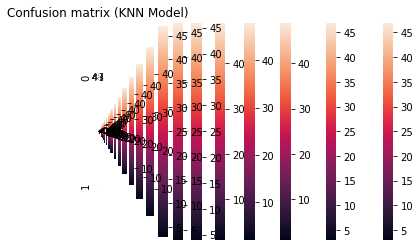

In [7]:
# Initialize variables to store results
shap_values_list = []
shap_dfs = []

# Number of iterations
n_iterations = 50

for i in range(n_iterations):
    # Step 2: Initial sampling
    
    majority_class = df[df['Outcome'] == 0]
    minority_class = df[df['Outcome'] == 1]

    # Define the number of samples to select
    n_samples = 50

    # Perform random sampling
    sampled_majority = majority_class.sample(n_samples, random_state=123)
    sampled_minority = minority_class.sample(n_samples, random_state=123)

    # Combine sampled data
    sampled_df = pd.concat([sampled_majority, sampled_minority])
    sampled_df

    #test
    y_test = sampled_df['Outcome']
    x_test = sampled_df.drop(columns='Outcome')

    # train
    # Separate remaining data for training
    remaining_df = df.drop(sampled_df.index)
    y_train = remaining_df['Outcome']
    x_train= remaining_df.drop(columns='Outcome')
    
    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train_ = scaler.transform(x_train)
    x_test_ = scaler.transform(x_test)
    
    #Modelling 
    
    # Creating and running our optimization

    study_knn = optuna.create_study(direction='maximize',study_name = "KNN")
    with parallel_backend('threading'):
        study_knn.optimize(objective_knn, n_trials=10, n_jobs=-1)
    
    # Evaluating our Optuna Trial
    print("Best trial:", study_knn.best_trial.number)
    print("Best accuracy:", study_knn.best_trial.value)
    print("Best hyperparameters:", study_knn.best_params)
    
    best_param_knn = study_knn.best_params
    KNN = KNeighborsClassifier(**best_param_knn).fit(x_train_,y_train)
    y_pred_knn = KNN.predict(x_test_)

    

    display_results(y_test, y_pred_knn, cm_title = "Confusion matrix (KNN Model)")

    
    # SHAP value computation using parallel processing
    num_cores = -1  # Use all available cores
    shap_values = compute_shap_values(KNN, x_test_, num_cores)


    # Extract SHAP values
    shap_values_array = abs(shap_values)

    # Store the SHAP values for stability analysis
    shap_values_list.append(shap_values_array)

    # Create DataFrame with SHAP values
    shap_values_df = pd.DataFrame(shap_values_array, columns=x_test.columns)
    shap_values_df['Outcome'] = y_test.values

    # Append DataFrame to the list
    shap_dfs.append(shap_values_df)

    print(shap_values_df)

# Concatenate all SHAP DataFrames row-wise
all_shap_values_df = pd.concat(shap_dfs, ignore_index=True)

# Print the combined DataFrame
print(all_shap_values_df)



In [8]:
all_shap_values_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,0.050631,0.031821,0.017893,0.071798,0.175726,0.087988,0.042655,0.008060,0
1,0.015690,0.063929,0.008381,0.072738,0.220690,0.025881,0.083833,0.028905,0
2,0.009250,0.144250,0.014750,0.042107,0.094679,0.013321,0.004107,0.033679,0
3,0.025726,0.149869,0.006679,0.008536,0.149393,0.008036,0.036964,0.020393,0
4,0.034286,0.135286,0.005429,0.012952,0.111524,0.000214,0.004333,0.032738,0
...,...,...,...,...,...,...,...,...,...
4995,0.004119,0.201357,0.012048,0.094762,0.320143,0.018905,0.002667,0.000429,1
4996,0.102405,0.097262,0.125833,0.104143,0.247810,0.147119,0.131786,0.107548,1
4997,0.078393,0.141821,0.026107,0.190083,0.015107,0.035202,0.011845,0.175298,1
4998,0.197512,0.132964,0.005155,0.078560,0.302131,0.009512,0.074107,0.016202,1


# value stabilty

In [9]:
# Create an valuestability DataFrame
valuestability = pd.DataFrame()

def calc_val(col_name, df, row_id):
    # Calculate the sum and mean
    summ = 0
    for i in range(n_iterations):
        summ += df[col_name].iloc[row_id]
        
        row_id += n_samples*2
        

    mean = summ / n_iterations
    row_id -= n_iterations*n_samples*2
    

    # Calculate the variance
    diff = 0
    for i in range(n_iterations):
        diff += (df[col_name].iloc[row_id] - mean) ** 2
        row_id += n_samples*2

    numerator = (diff / (n_iterations - 1)) ** 0.5
    denominator = mean

    final = numerator / denominator

    return final

def add_to_df():
    arr =[]
    col = x_test.columns
    for c in col:
        print(c)
        for i in range(n_samples*2):
            arr.append(calc_val(c,all_shap_values_df, i))
 
        
        valuestability[c] = arr
        arr =[]

In [10]:
# Call the add_to_df function to populate valuestability
add_to_df()
# Calculate the sum of each row
row_sums = valuestability.sum(axis=1)

# Calculate the number of columns
num_columns = valuestability.shape[1]

# Calculate the average
valstability = row_sums / num_columns

# Add the new column to the DataFrame
valuestability['valstability'] = valstability
# Save the DataFrame to an Excel file
valuestability.to_excel('30_knn_valuestability.xlsx', index=False)
valuestability


Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DPF
Age


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,valstability
0,0.241656,0.374958,0.839805,0.355958,0.153252,0.212499,0.539326,0.840384,0.444730
1,0.208526,0.315448,0.767546,0.820623,0.139118,0.367079,0.565639,0.645221,0.478650
2,0.340808,0.308412,1.013385,0.156835,0.174979,0.637642,0.579852,0.128163,0.417510
3,0.337216,0.085631,0.702119,0.316162,0.135201,0.594443,0.280866,0.745630,0.399659
4,0.158601,0.249674,3.053106,0.389543,0.215667,1.228464,0.543358,0.331272,0.771210
...,...,...,...,...,...,...,...,...,...
95,1.130916,0.214848,1.015246,0.533755,0.194777,0.952826,1.643747,1.212349,0.862308
96,0.717207,0.474656,1.107593,0.462888,0.233023,1.062382,0.856511,0.804120,0.714798
97,0.288476,0.832835,0.660450,0.337151,1.092602,0.522726,0.820600,0.371287,0.615766
98,0.180866,0.213564,1.031008,0.494068,0.306295,1.437247,0.598395,0.946275,0.650965


In [11]:
valuestability

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,valstability
0,0.241656,0.374958,0.839805,0.355958,0.153252,0.212499,0.539326,0.840384,0.444730
1,0.208526,0.315448,0.767546,0.820623,0.139118,0.367079,0.565639,0.645221,0.478650
2,0.340808,0.308412,1.013385,0.156835,0.174979,0.637642,0.579852,0.128163,0.417510
3,0.337216,0.085631,0.702119,0.316162,0.135201,0.594443,0.280866,0.745630,0.399659
4,0.158601,0.249674,3.053106,0.389543,0.215667,1.228464,0.543358,0.331272,0.771210
...,...,...,...,...,...,...,...,...,...
95,1.130916,0.214848,1.015246,0.533755,0.194777,0.952826,1.643747,1.212349,0.862308
96,0.717207,0.474656,1.107593,0.462888,0.233023,1.062382,0.856511,0.804120,0.714798
97,0.288476,0.832835,0.660450,0.337151,1.092602,0.522726,0.820600,0.371287,0.615766
98,0.180866,0.213564,1.031008,0.494068,0.306295,1.437247,0.598395,0.946275,0.650965


## 4.3 Logistic Regression

In [12]:
df = pd.read_csv("data_resampled_50.csv")

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def objective_lr(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }

    # Define hyperparameters
    param_logr = {
        'C': trial.suggest_float("C", 0.001, 10.0, log=True),
        'solver': trial.suggest_categorical('solver', ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]),
        'max_iter': trial.suggest_int("max_iter", 50, 1000),
        'class_weight': class_weight  # Apply custom class weights
    }

    # Create and train the model
    lr = LogisticRegression(**param_logr, random_state=42)
    
    # Evaluate the model using cross-validation with the f1_macro score to handle imbalance
    score = cross_val_score(lr, x_train, y_train, cv=cv, scoring="f1_macro").mean()

    return score



In [14]:
# Initialize variables to store results
# Clear any existing elements in the lists if they were previously initialized

shap_values_list = []
shap_dfs = []

# Number of iterations
n_iterations = 50

for i in range(n_iterations):
    # Step 2: Initial sampling
    
    majority_class = df[df['Outcome'] == 0]
    minority_class = df[df['Outcome'] == 1]

    # Define the number of samples to select
    n_samples = 50

    # Perform random sampling
    sampled_majority = majority_class.sample(n_samples, random_state=123)
    sampled_minority = minority_class.sample(n_samples, random_state=123)

    # Combine sampled data
    sampled_df = pd.concat([sampled_majority, sampled_minority])
    sampled_df

    #test
    y_test = sampled_df['Outcome']
    x_test = sampled_df.drop(columns='Outcome')

    # train
    # Separate remaining data for training
    remaining_df = df.drop(sampled_df.index)
    y_train = remaining_df['Outcome']
    x_train= remaining_df.drop(columns='Outcome')
    
    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train_ = scaler.transform(x_train)
    x_test_ = scaler.transform(x_test)
    
    #Modelling 
    
    # Creating and running our optimization
    
    # Creating and running our optimization

    study_lr = optuna.create_study(direction='maximize',study_name = "logr")
    with parallel_backend('threading'):
        study_lr.optimize(objective_lr, n_trials=10, n_jobs=-1)

    # Evaluating our Optuna Trial
    print("Best trial:", study_lr.best_trial.number)
    print("Best accuracy:", study_lr.best_trial.value)
    print("Best hyperparameters:", study_lr.best_params)

    # Train the model with the best parameters
    best_param_logr = study_lr.best_params
    LR = LogisticRegression(**best_param_logr, random_state=42).fit(x_train, y_train)


    
    # SHAP value computation using KernelExplainer
    explainer = shap.Explainer(LR, x_train_)
    shap_values = explainer(x_test_)


    # Extract SHAP values
    shap_values_array = abs(shap_values.values)

    # Store the SHAP values for stability analysis
    shap_values_list.append(shap_values_array)

    # Create DataFrame with SHAP values
    shap_values_df = pd.DataFrame(shap_values_array, columns=x_test.columns)
    shap_values_df['Outcome'] = y_test.values

    # Append DataFrame to the list
    shap_dfs.append(shap_values_df)

    print(shap_values_df)

# Concatenate all SHAP DataFrames row-wise
all_shap_values_df = pd.concat(shap_dfs, ignore_index=True)

# Print the combined DataFrame
print(all_shap_values_df)





[I 2024-08-26 15:53:09,207] A new study created in memory with name: logr
[I 2024-08-26 15:53:09,969] Trial 1 finished with value: 0.6952971693469333 and parameters: {'C': 0.1669121445047771, 'solver': 'saga', 'max_iter': 78}. Best is trial 1 with value: 0.6952971693469333.
[I 2024-08-26 15:53:10,395] Trial 5 finished with value: 0.6955918797443664 and parameters: {'C': 0.7792076469297914, 'solver': 'saga', 'max_iter': 164}. Best is trial 5 with value: 0.6955918797443664.
[I 2024-08-26 15:53:10,450] Trial 6 finished with value: 0.7425063766536057 and parameters: {'C': 0.05856781117937601, 'solver': 'liblinear', 'max_iter': 340}. Best is trial 6 with value: 0.7425063766536057.
[I 2024-08-26 15:53:10,576] Trial 2 finished with value: 0.6981974070804202 and parameters: {'C': 1.4154803584752669, 'solver': 'sag', 'max_iter': 236}. Best is trial 6 with value: 0.7425063766536057.
[I 2024-08-26 15:53:11,323] Trial 0 finished with value: 0.7011668560835892 and parameters: {'C': 0.00195068424198

Best trial: 8
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 2.7954302556699706, 'solver': 'lbfgs', 'max_iter': 875}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021060  0.016379       0.000683       0.008344  0.001580  0.049001   
1      0.086795  0.006575       0.002121       0.098155  0.001439  0.014946   
2      0.086795  0.016379       0.011896       0.056243  0.008835  0.090440   
3      0.026665  0.005993       0.006409       0.050219  0.001697  0.031795   
4      0.077542  0.027271       0.008392       0.008344  0.011703  0.039231   
..          ...       ...            ...            ...       ...       ...   
95     0.241880  0.027192       0.007027       0.026306  0.000675  0.030933   
96     0.086795  0.053334       0.000018       0.069491  0.000373  0.086303   
97     0.119663  0.076208       0.002822       0.087453  0.006562  0.009922   
98     0.011807  0.028281       0.002822       0.020319  0.009859  0.047808   

[I 2024-08-26 15:53:24,096] Trial 3 finished with value: 0.7028782558577713 and parameters: {'C': 0.0020763327617146343, 'solver': 'sag', 'max_iter': 246}. Best is trial 3 with value: 0.7028782558577713.
[I 2024-08-26 15:53:25,020] Trial 1 finished with value: 0.7057674775921055 and parameters: {'C': 0.03682118214823791, 'solver': 'sag', 'max_iter': 499}. Best is trial 1 with value: 0.7057674775921055.
[I 2024-08-26 15:53:27,003] Trial 7 finished with value: 0.7003571170371811 and parameters: {'C': 7.840397330085064, 'solver': 'sag', 'max_iter': 332}. Best is trial 1 with value: 0.7057674775921055.
[I 2024-08-26 15:53:27,157] Trial 6 finished with value: 0.6982930108039992 and parameters: {'C': 0.16734731483069182, 'solver': 'saga', 'max_iter': 576}. Best is trial 1 with value: 0.7057674775921055.
[I 2024-08-26 15:53:28,692] Trial 2 finished with value: 0.7862865746132843 and parameters: {'C': 0.0752540418576953, 'solver': 'lbfgs', 'max_iter': 106}. Best is trial 2 with value: 0.786286

Best trial: 5
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.0594748767113522, 'solver': 'newton-cg', 'max_iter': 639}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020959  0.016356       0.000694       0.008356  0.001580  0.049198   
1      0.086380  0.006566       0.002156       0.098286  0.001439  0.015006   
2      0.086380  0.016356       0.012095       0.056318  0.008835  0.090803   
3      0.026537  0.005984       0.006516       0.050286  0.001697  0.031922   
4      0.077171  0.027233       0.008532       0.008356  0.011704  0.039389   
..          ...       ...            ...            ...       ...       ...   
95     0.240721  0.027154       0.007144       0.026342  0.000675  0.031057   
96     0.086380  0.053260       0.000019       0.069584  0.000373  0.086650   
97     0.119090  0.076102       0.002869       0.087570  0.006562  0.009962   
98     0.011751  0.028242       0.002869       0.020346  0.009860  0.048000

[I 2024-08-26 15:53:33,697] Trial 3 finished with value: 0.7275292025093286 and parameters: {'C': 0.03979431496897908, 'solver': 'liblinear', 'max_iter': 131}. Best is trial 3 with value: 0.7275292025093286.
[I 2024-08-26 15:53:33,715] Trial 5 finished with value: 0.7875423349673752 and parameters: {'C': 0.9315541361482325, 'solver': 'liblinear', 'max_iter': 341}. Best is trial 5 with value: 0.7875423349673752.
[I 2024-08-26 15:53:35,240] Trial 1 finished with value: 0.6970128154893003 and parameters: {'C': 0.020110027931042673, 'solver': 'saga', 'max_iter': 337}. Best is trial 5 with value: 0.7875423349673752.
[I 2024-08-26 15:53:35,366] Trial 2 finished with value: 0.6983130192919225 and parameters: {'C': 0.003943086587543343, 'solver': 'saga', 'max_iter': 357}. Best is trial 5 with value: 0.7875423349673752.
[I 2024-08-26 15:53:37,270] Trial 4 finished with value: 0.7025058078056307 and parameters: {'C': 1.3213086589712553, 'solver': 'saga', 'max_iter': 801}. Best is trial 5 with va

Best trial: 6
Best accuracy: 0.7943422462370675
Best hyperparameters: {'C': 0.3117578508609565, 'solver': 'newton-cg', 'max_iter': 293}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020675  0.016321       0.000722       0.008372  0.001583  0.049841   
1      0.085208  0.006552       0.002242       0.098474  0.001441  0.015203   
2      0.085208  0.016321       0.012577       0.056426  0.008847  0.091991   
3      0.026177  0.005972       0.006776       0.050383  0.001699  0.032340   
4      0.076124  0.027175       0.008873       0.008372  0.011719  0.039904   
..          ...       ...            ...            ...       ...       ...   
95     0.237455  0.027096       0.007429       0.026392  0.000676  0.031464   
96     0.085208  0.053146       0.000019       0.069717  0.000373  0.087784   
97     0.117474  0.075939       0.002983       0.087738  0.006571  0.010092   
98     0.011591  0.028181       0.002983       0.020385  0.009873  0.04862

[I 2024-08-26 15:53:44,793] Trial 3 finished with value: 0.7785186446220506 and parameters: {'C': 0.3742744364684233, 'solver': 'liblinear', 'max_iter': 808}. Best is trial 3 with value: 0.7785186446220506.
[I 2024-08-26 15:53:44,827] Trial 5 finished with value: 0.7237880141150572 and parameters: {'C': 0.0337835169659668, 'solver': 'liblinear', 'max_iter': 382}. Best is trial 3 with value: 0.7785186446220506.
[I 2024-08-26 15:53:44,874] Trial 1 finished with value: 0.7907887236578831 and parameters: {'C': 2.470665773799723, 'solver': 'liblinear', 'max_iter': 311}. Best is trial 1 with value: 0.7907887236578831.
[I 2024-08-26 15:53:45,419] Trial 0 finished with value: 0.6955918797443664 and parameters: {'C': 0.18039207420466064, 'solver': 'saga', 'max_iter': 165}. Best is trial 1 with value: 0.7907887236578831.
[I 2024-08-26 15:53:46,225] Trial 9 finished with value: 0.7881689167090619 and parameters: {'C': 0.9938303344409286, 'solver': 'liblinear', 'max_iter': 691}. Best is trial 1 wi

Best trial: 8
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 4.187025130738329, 'solver': 'newton-cg', 'max_iter': 758}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021095  0.016382       0.000682       0.008352  0.001580  0.048938   
1      0.086938  0.006577       0.002119       0.098243  0.001438  0.014927   
2      0.086938  0.016382       0.011884       0.056294  0.008834  0.090324   
3      0.026709  0.005994       0.006402       0.050264  0.001697  0.031754   
4      0.077670  0.027277       0.008383       0.008352  0.011702  0.039181   
..          ...       ...            ...            ...       ...       ...   
95     0.242278  0.027197       0.007019       0.026330  0.000675  0.030894   
96     0.086938  0.053345       0.000018       0.069554  0.000373  0.086192   
97     0.119860  0.076224       0.002819       0.087532  0.006561  0.009909   
98     0.011827  0.028287       0.002819       0.020337  0.009858  0.047747

[I 2024-08-26 15:53:56,954] Trial 0 finished with value: 0.700600075360358 and parameters: {'C': 0.0015164655261753217, 'solver': 'saga', 'max_iter': 936}. Best is trial 0 with value: 0.700600075360358.
[I 2024-08-26 15:53:58,716] Trial 5 finished with value: 0.7028045522948007 and parameters: {'C': 0.20298243970222868, 'solver': 'saga', 'max_iter': 802}. Best is trial 5 with value: 0.7028045522948007.
[I 2024-08-26 15:54:00,248] Trial 7 finished with value: 0.6952064455706969 and parameters: {'C': 1.8008959546688297, 'solver': 'saga', 'max_iter': 135}. Best is trial 5 with value: 0.7028045522948007.
[I 2024-08-26 15:54:02,016] Trial 3 finished with value: 0.7864831534057857 and parameters: {'C': 0.0012344998566629775, 'solver': 'lbfgs', 'max_iter': 87}. Best is trial 3 with value: 0.7864831534057857.
[I 2024-08-26 15:54:02,081] Trial 8 finished with value: 0.6978778979481816 and parameters: {'C': 0.0591535490351487, 'solver': 'sag', 'max_iter': 236}. Best is trial 3 with value: 0.7864

Best trial: 9
Best accuracy: 0.792050784662601
Best hyperparameters: {'C': 0.11191830241866936, 'solver': 'newton-cg', 'max_iter': 926}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020305  0.016318       0.000755       0.008405  0.001588  0.050712   
1      0.083683  0.006551       0.002345       0.098867  0.001446  0.015468   
2      0.083683  0.016318       0.013154       0.056651  0.008880  0.093598   
3      0.025709  0.005971       0.007087       0.050583  0.001706  0.032905   
4      0.074762  0.027170       0.009280       0.008405  0.011762  0.040601   
..          ...       ...            ...            ...       ...       ...   
95     0.233207  0.027091       0.007770       0.026497  0.000678  0.032013   
96     0.083683  0.053136       0.000020       0.069995  0.000375  0.089317   
97     0.115372  0.075926       0.003120       0.088088  0.006595  0.010268   
98     0.011384  0.028176       0.003120       0.020466  0.009909  0.04947

[I 2024-08-26 15:54:12,143] Trial 4 finished with value: 0.7098594024878462 and parameters: {'C': 0.004453675226708989, 'solver': 'sag', 'max_iter': 551}. Best is trial 4 with value: 0.7098594024878462.
[I 2024-08-26 15:54:12,403] Trial 1 finished with value: 0.6984952438307989 and parameters: {'C': 0.09032785769327684, 'solver': 'saga', 'max_iter': 547}. Best is trial 4 with value: 0.7098594024878462.
[I 2024-08-26 15:54:12,716] Trial 5 finished with value: 0.698889725530559 and parameters: {'C': 6.957867149689087, 'solver': 'saga', 'max_iter': 597}. Best is trial 4 with value: 0.7098594024878462.
[I 2024-08-26 15:54:12,954] Trial 6 finished with value: 0.791651126045369 and parameters: {'C': 5.814839405785337, 'solver': 'liblinear', 'max_iter': 560}. Best is trial 6 with value: 0.791651126045369.
[I 2024-08-26 15:54:13,416] Trial 2 finished with value: 0.7181040914356034 and parameters: {'C': 0.012791027298678016, 'solver': 'sag', 'max_iter': 844}. Best is trial 6 with value: 0.79165

Best trial: 6
Best accuracy: 0.791651126045369
Best hyperparameters: {'C': 5.814839405785337, 'solver': 'liblinear', 'max_iter': 560}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020380  0.014833       0.001864       0.007514  0.001489  0.039663   
1      0.083990  0.005955       0.005792       0.088391  0.001356  0.012098   
2      0.083990  0.014833       0.032488       0.050648  0.008326  0.073205   
3      0.025803  0.005427       0.017503       0.045223  0.001599  0.025736   
4      0.075036  0.024698       0.022918       0.007514  0.011029  0.031755   
..          ...       ...            ...            ...       ...       ...   
95     0.234061  0.024626       0.019190       0.023690  0.000636  0.025038   
96     0.083990  0.048302       0.000050       0.062578  0.000351  0.069857   
97     0.115795  0.069019       0.007706       0.078754  0.006184  0.008031   
98     0.011426  0.025613       0.007706       0.018298  0.009292  0.038698 

[I 2024-08-26 15:54:22,979] Trial 2 finished with value: 0.6992623390195467 and parameters: {'C': 0.006237905855208233, 'solver': 'saga', 'max_iter': 453}. Best is trial 2 with value: 0.6992623390195467.
[I 2024-08-26 15:54:23,267] Trial 1 finished with value: 0.7007702426027419 and parameters: {'C': 0.009599377084067634, 'solver': 'saga', 'max_iter': 525}. Best is trial 1 with value: 0.7007702426027419.
[I 2024-08-26 15:54:23,331] Trial 4 finished with value: 0.706729536234002 and parameters: {'C': 0.5818827753795965, 'solver': 'sag', 'max_iter': 529}. Best is trial 4 with value: 0.706729536234002.
[I 2024-08-26 15:54:23,443] Trial 0 finished with value: 0.7016441744133948 and parameters: {'C': 0.0054054140997687366, 'solver': 'saga', 'max_iter': 589}. Best is trial 4 with value: 0.706729536234002.
[I 2024-08-26 15:54:23,993] Trial 8 finished with value: 0.6990049951917784 and parameters: {'C': 0.004857783666989631, 'solver': 'liblinear', 'max_iter': 728}. Best is trial 4 with value: 

Best trial: 7
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 8.599635682922152, 'solver': 'newton-cg', 'max_iter': 704}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021122  0.016388       0.000680       0.008351  0.001580  0.048889   
1      0.087051  0.006579       0.002111       0.098238  0.001438  0.014912   
2      0.087051  0.016388       0.011843       0.056291  0.008834  0.090234   
3      0.026744  0.005996       0.006380       0.050262  0.001697  0.031722   
4      0.077771  0.027287       0.008354       0.008351  0.011702  0.039142   
..          ...       ...            ...            ...       ...       ...   
95     0.242592  0.027207       0.006995       0.026329  0.000675  0.030863   
96     0.087051  0.053364       0.000018       0.069550  0.000373  0.086107   
97     0.120015  0.076252       0.002809       0.087528  0.006561  0.009899   
98     0.011842  0.028297       0.002809       0.020336  0.009859  0.047699

[I 2024-08-26 15:54:31,124] Trial 3 finished with value: 0.7078741073545105 and parameters: {'C': 0.014499836757123383, 'solver': 'liblinear', 'max_iter': 508}. Best is trial 3 with value: 0.7078741073545105.
[I 2024-08-26 15:54:31,153] Trial 2 finished with value: 0.7434371838372731 and parameters: {'C': 0.062131304557040724, 'solver': 'liblinear', 'max_iter': 596}. Best is trial 2 with value: 0.7434371838372731.
[I 2024-08-26 15:54:32,597] Trial 1 finished with value: 0.7014888814409482 and parameters: {'C': 0.023810113199179164, 'solver': 'sag', 'max_iter': 356}. Best is trial 2 with value: 0.7434371838372731.
[I 2024-08-26 15:54:35,120] Trial 0 finished with value: 0.7025058078056307 and parameters: {'C': 0.35040658923707907, 'solver': 'saga', 'max_iter': 841}. Best is trial 2 with value: 0.7434371838372731.
[I 2024-08-26 15:54:35,268] Trial 5 finished with value: 0.7156858828063151 and parameters: {'C': 2.138228217068369, 'solver': 'sag', 'max_iter': 914}. Best is trial 2 with val

Best trial: 4
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 7.727214166960714, 'solver': 'newton-cg', 'max_iter': 359}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021119  0.016387       0.000680       0.008352  0.001580  0.048895   
1      0.087039  0.006579       0.002112       0.098239  0.001438  0.014914   
2      0.087039  0.016387       0.011847       0.056291  0.008834  0.090244   
3      0.026740  0.005996       0.006382       0.050262  0.001697  0.031726   
4      0.077760  0.027286       0.008357       0.008352  0.011702  0.039146   
..          ...       ...            ...            ...       ...       ...   
95     0.242558  0.027206       0.006998       0.026329  0.000675  0.030866   
96     0.087039  0.053362       0.000018       0.069551  0.000373  0.086116   
97     0.119998  0.076249       0.002810       0.087528  0.006561  0.009900   
98     0.011840  0.028296       0.002810       0.020336  0.009859  0.047705

[I 2024-08-26 15:54:39,880] Trial 2 finished with value: 0.7008603584965389 and parameters: {'C': 0.001591697228402351, 'solver': 'saga', 'max_iter': 818}. Best is trial 2 with value: 0.7008603584965389.
[I 2024-08-26 15:54:40,056] Trial 5 finished with value: 0.7032524341861418 and parameters: {'C': 0.4009803447117938, 'solver': 'sag', 'max_iter': 451}. Best is trial 5 with value: 0.7032524341861418.
[I 2024-08-26 15:54:40,778] Trial 7 finished with value: 0.7241958718523839 and parameters: {'C': 0.032498368685968046, 'solver': 'liblinear', 'max_iter': 651}. Best is trial 7 with value: 0.7241958718523839.
[I 2024-08-26 15:54:41,335] Trial 1 finished with value: 0.7044122681018528 and parameters: {'C': 0.004239518317978743, 'solver': 'saga', 'max_iter': 724}. Best is trial 7 with value: 0.7241958718523839.
[I 2024-08-26 15:54:42,787] Trial 8 finished with value: 0.7071410410942796 and parameters: {'C': 0.002519367143142684, 'solver': 'sag', 'max_iter': 550}. Best is trial 7 with value:

Best trial: 4
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.1974743271208133, 'solver': 'newton-cg', 'max_iter': 368}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020978  0.016359       0.000692       0.008355  0.001580  0.049160   
1      0.086457  0.006567       0.002151       0.098278  0.001439  0.014995   
2      0.086457  0.016359       0.012065       0.056314  0.008835  0.090733   
3      0.026561  0.005986       0.006500       0.050282  0.001697  0.031898   
4      0.077240  0.027239       0.008511       0.008355  0.011703  0.039358   
..          ...       ...            ...            ...       ...       ...   
95     0.240937  0.027159       0.007126       0.026340  0.000675  0.031034   
96     0.086457  0.053270       0.000018       0.069579  0.000373  0.086583   
97     0.119196  0.076118       0.002862       0.087563  0.006562  0.009954   
98     0.011761  0.028247       0.002862       0.020345  0.009859  0.047963

[I 2024-08-26 15:54:49,828] Trial 5 finished with value: 0.6985803270843378 and parameters: {'C': 0.004684053096514931, 'solver': 'liblinear', 'max_iter': 106}. Best is trial 5 with value: 0.6985803270843378.
[I 2024-08-26 15:54:49,896] Trial 3 finished with value: 0.7910926444476987 and parameters: {'C': 1.4610414090824486, 'solver': 'liblinear', 'max_iter': 656}. Best is trial 3 with value: 0.7910926444476987.
[I 2024-08-26 15:54:50,346] Trial 0 finished with value: 0.6955918797443664 and parameters: {'C': 2.7149403095615647, 'solver': 'saga', 'max_iter': 141}. Best is trial 3 with value: 0.7910926444476987.
[I 2024-08-26 15:54:52,014] Trial 1 finished with value: 0.7037476177534397 and parameters: {'C': 0.0027228083100581195, 'solver': 'saga', 'max_iter': 966}. Best is trial 3 with value: 0.7910926444476987.
[I 2024-08-26 15:54:53,030] Trial 8 finished with value: 0.706729536234002 and parameters: {'C': 0.10075051614713992, 'solver': 'sag', 'max_iter': 567}. Best is trial 3 with val

Best trial: 4
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.2672227834181045, 'solver': 'newton-cg', 'max_iter': 164}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020986  0.016361       0.000692       0.008355  0.001580  0.049143   
1      0.086491  0.006568       0.002149       0.098275  0.001439  0.014990   
2      0.086491  0.016361       0.012052       0.056312  0.008835  0.090703   
3      0.026571  0.005986       0.006493       0.050281  0.001697  0.031887   
4      0.077270  0.027241       0.008502       0.008355  0.011703  0.039345   
..          ...       ...            ...            ...       ...       ...   
95     0.241031  0.027162       0.007119       0.026339  0.000675  0.031023   
96     0.086491  0.053275       0.000018       0.069576  0.000373  0.086554   
97     0.119243  0.076124       0.002859       0.087560  0.006562  0.009951   
98     0.011766  0.028250       0.002859       0.020344  0.009859  0.047947

[I 2024-08-26 15:55:00,528] Trial 5 finished with value: 0.6983763683709252 and parameters: {'C': 0.002293499573259247, 'solver': 'liblinear', 'max_iter': 257}. Best is trial 5 with value: 0.6983763683709252.
[I 2024-08-26 15:55:00,611] Trial 4 finished with value: 0.7797951998599469 and parameters: {'C': 0.605747610219458, 'solver': 'liblinear', 'max_iter': 403}. Best is trial 4 with value: 0.7797951998599469.
[I 2024-08-26 15:55:02,611] Trial 1 finished with value: 0.6984952438307989 and parameters: {'C': 1.1548312988655711, 'solver': 'saga', 'max_iter': 501}. Best is trial 4 with value: 0.7797951998599469.
[I 2024-08-26 15:55:04,141] Trial 2 finished with value: 0.7171584581826963 and parameters: {'C': 0.043940792465986006, 'solver': 'sag', 'max_iter': 986}. Best is trial 4 with value: 0.7797951998599469.
[I 2024-08-26 15:55:04,322] Trial 7 finished with value: 0.7018410496072918 and parameters: {'C': 4.771104158484593, 'solver': 'saga', 'max_iter': 739}. Best is trial 4 with value:

Best trial: 0
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.338111208685803, 'solver': 'newton-cg', 'max_iter': 328}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020994  0.016362       0.000691       0.008354  0.001580  0.049128   
1      0.086522  0.006569       0.002146       0.098272  0.001439  0.014985   
2      0.086522  0.016362       0.012040       0.056311  0.008835  0.090675   
3      0.026581  0.005987       0.006486       0.050279  0.001697  0.031878   
4      0.077298  0.027243       0.008493       0.008354  0.011703  0.039333   
..          ...       ...            ...            ...       ...       ...   
95     0.241117  0.027164       0.007112       0.026338  0.000675  0.031014   
96     0.086522  0.053280       0.000018       0.069574  0.000373  0.086528   
97     0.119286  0.076131       0.002856       0.087558  0.006562  0.009948   
98     0.011770  0.028252       0.002856       0.020343  0.009859  0.047933 

[I 2024-08-26 15:55:11,755] Trial 2 finished with value: 0.72995830116113 and parameters: {'C': 0.044728627770544434, 'solver': 'liblinear', 'max_iter': 601}. Best is trial 2 with value: 0.72995830116113.
[I 2024-08-26 15:55:12,475] Trial 0 finished with value: 0.7018196352893102 and parameters: {'C': 0.0011740800300284935, 'solver': 'sag', 'max_iter': 310}. Best is trial 2 with value: 0.72995830116113.
[I 2024-08-26 15:55:12,567] Trial 1 finished with value: 0.7009713177106882 and parameters: {'C': 0.002224406881854092, 'solver': 'sag', 'max_iter': 196}. Best is trial 2 with value: 0.72995830116113.
[I 2024-08-26 15:55:13,186] Trial 4 finished with value: 0.6962154726240357 and parameters: {'C': 3.602111456329049, 'solver': 'saga', 'max_iter': 335}. Best is trial 2 with value: 0.72995830116113.
[I 2024-08-26 15:55:15,078] Trial 9 finished with value: 0.6981272095539113 and parameters: {'C': 0.0028285842862350043, 'solver': 'saga', 'max_iter': 251}. Best is trial 2 with value: 0.729958

Best trial: 7
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.2362789347795722, 'solver': 'lbfgs', 'max_iter': 193}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020978  0.016362       0.000695       0.008349  0.001580  0.049203   
1      0.086456  0.006569       0.002160       0.098204  0.001439  0.015008   
2      0.086456  0.016362       0.012118       0.056272  0.008835  0.090813   
3      0.026561  0.005987       0.006529       0.050244  0.001697  0.031926   
4      0.077239  0.027243       0.008549       0.008349  0.011703  0.039393   
..          ...       ...            ...            ...       ...       ...   
95     0.240934  0.027164       0.007158       0.026320  0.000675  0.031061   
96     0.086456  0.053280       0.000019       0.069526  0.000373  0.086660   
97     0.119195  0.076131       0.002874       0.087497  0.006562  0.009963   
98     0.011761  0.028252       0.002874       0.020329  0.009860  0.048006   


[I 2024-08-26 15:55:22,471] Trial 2 finished with value: 0.6985803270843378 and parameters: {'C': 0.004304865048294385, 'solver': 'liblinear', 'max_iter': 146}. Best is trial 2 with value: 0.6985803270843378.
[I 2024-08-26 15:55:23,174] Trial 4 finished with value: 0.701516975906416 and parameters: {'C': 0.0011417285548373265, 'solver': 'sag', 'max_iter': 443}. Best is trial 4 with value: 0.701516975906416.
[I 2024-08-26 15:55:23,545] Trial 5 finished with value: 0.6962214544488995 and parameters: {'C': 0.2194889410258641, 'solver': 'sag', 'max_iter': 216}. Best is trial 4 with value: 0.701516975906416.
[I 2024-08-26 15:55:23,803] Trial 0 finished with value: 0.6982930108039992 and parameters: {'C': 1.0025360836992, 'solver': 'sag', 'max_iter': 287}. Best is trial 4 with value: 0.701516975906416.
[I 2024-08-26 15:55:24,773] Trial 3 finished with value: 0.7058751406296063 and parameters: {'C': 6.795687349917421, 'solver': 'sag', 'max_iter': 578}. Best is trial 3 with value: 0.7058751406

Best trial: 6
Best accuracy: 0.7947170551372086
Best hyperparameters: {'C': 0.28135556380347004, 'solver': 'newton-cg', 'max_iter': 566}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020643  0.016319       0.000725       0.008374  0.001583  0.049919   
1      0.085077  0.006551       0.002252       0.098503  0.001441  0.015227   
2      0.085077  0.016319       0.012633       0.056443  0.008850  0.092135   
3      0.026137  0.005971       0.006806       0.050398  0.001700  0.032391   
4      0.076007  0.027172       0.008911       0.008374  0.011722  0.039966   
..          ...       ...            ...            ...       ...       ...   
95     0.237091  0.027092       0.007462       0.026400  0.000676  0.031513   
96     0.085077  0.053139       0.000019       0.069738  0.000373  0.087921   
97     0.117294  0.075930       0.002996       0.087764  0.006572  0.010108   
98     0.011573  0.028178       0.002996       0.020391  0.009876  0.0487

[I 2024-08-26 15:55:31,614] Trial 1 finished with value: 0.7915656129727081 and parameters: {'C': 4.036677244478244, 'solver': 'liblinear', 'max_iter': 407}. Best is trial 1 with value: 0.7915656129727081.
[I 2024-08-26 15:55:32,440] Trial 3 finished with value: 0.7013970044545552 and parameters: {'C': 0.0013789357730296602, 'solver': 'sag', 'max_iter': 318}. Best is trial 1 with value: 0.7915656129727081.
[I 2024-08-26 15:55:33,416] Trial 6 finished with value: 0.7005473246867568 and parameters: {'C': 0.001049115347666715, 'solver': 'saga', 'max_iter': 443}. Best is trial 1 with value: 0.7915656129727081.
[I 2024-08-26 15:55:33,488] Trial 0 finished with value: 0.7079020770795422 and parameters: {'C': 0.003688777619317793, 'solver': 'sag', 'max_iter': 475}. Best is trial 1 with value: 0.7915656129727081.
[I 2024-08-26 15:55:34,114] Trial 8 finished with value: 0.7637826433657396 and parameters: {'C': 0.13358871525393062, 'solver': 'liblinear', 'max_iter': 596}. Best is trial 1 with va

Best trial: 4
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.0006930624652681, 'solver': 'newton-cg', 'max_iter': 771}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020950  0.016354       0.000695       0.008356  0.001580  0.049217   
1      0.086341  0.006565       0.002159       0.098290  0.001439  0.015012   
2      0.086341  0.016354       0.012110       0.056321  0.008836  0.090838   
3      0.026525  0.005984       0.006524       0.050288  0.001697  0.031935   
4      0.077136  0.027231       0.008543       0.008356  0.011704  0.039404   
..          ...       ...            ...            ...       ...       ...   
95     0.240614  0.027151       0.007153       0.026343  0.000675  0.031070   
96     0.086341  0.053254       0.000019       0.069587  0.000373  0.086683   
97     0.119037  0.076095       0.002872       0.087574  0.006562  0.009966   
98     0.011745  0.028239       0.002872       0.020347  0.009860  0.048019

[I 2024-08-26 15:55:40,935] Trial 2 finished with value: 0.6978732005509596 and parameters: {'C': 0.005640614359502059, 'solver': 'sag', 'max_iter': 197}. Best is trial 2 with value: 0.6978732005509596.
[I 2024-08-26 15:55:42,384] Trial 6 finished with value: 0.6955295505749595 and parameters: {'C': 0.10967501743902866, 'solver': 'sag', 'max_iter': 150}. Best is trial 2 with value: 0.6978732005509596.
[I 2024-08-26 15:55:43,211] Trial 0 finished with value: 0.717379143216118 and parameters: {'C': 0.017054008395559556, 'solver': 'sag', 'max_iter': 858}. Best is trial 0 with value: 0.717379143216118.
[I 2024-08-26 15:55:43,305] Trial 7 finished with value: 0.6973007054700896 and parameters: {'C': 0.003833440206628665, 'solver': 'liblinear', 'max_iter': 85}. Best is trial 0 with value: 0.717379143216118.
[I 2024-08-26 15:55:46,576] Trial 9 finished with value: 0.7112573196732737 and parameters: {'C': 2.9758669092341927, 'solver': 'sag', 'max_iter': 708}. Best is trial 0 with value: 0.7173

Best trial: 4
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 4.53854524096523, 'solver': 'lbfgs', 'max_iter': 777}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021099  0.016383       0.000682       0.008352  0.001580  0.048926   
1      0.086954  0.006577       0.002117       0.098247  0.001438  0.014924   
2      0.086954  0.016383       0.011877       0.056296  0.008834  0.090302   
3      0.026714  0.005994       0.006399       0.050266  0.001697  0.031746   
4      0.077684  0.027278       0.008378       0.008352  0.011702  0.039171   
..          ...       ...            ...            ...       ...       ...   
95     0.242323  0.027199       0.007015       0.026331  0.000675  0.030886   
96     0.086954  0.053348       0.000018       0.069557  0.000373  0.086172   
97     0.119882  0.076228       0.002817       0.087536  0.006561  0.009907   
98     0.011829  0.028288       0.002817       0.020338  0.009858  0.047735   
9

[I 2024-08-26 15:55:54,007] Trial 2 finished with value: 0.6982482256045904 and parameters: {'C': 0.001017043749776627, 'solver': 'saga', 'max_iter': 66}. Best is trial 2 with value: 0.6982482256045904.
[I 2024-08-26 15:55:54,030] Trial 4 finished with value: 0.694871130335584 and parameters: {'C': 0.3798635024989579, 'solver': 'saga', 'max_iter': 85}. Best is trial 2 with value: 0.6982482256045904.
[I 2024-08-26 15:55:55,396] Trial 0 finished with value: 0.6976975914140542 and parameters: {'C': 0.019585506421590466, 'solver': 'saga', 'max_iter': 398}. Best is trial 2 with value: 0.6982482256045904.
[I 2024-08-26 15:55:55,461] Trial 1 finished with value: 0.7048744789930207 and parameters: {'C': 0.11971881821257603, 'solver': 'sag', 'max_iter': 483}. Best is trial 1 with value: 0.7048744789930207.
[I 2024-08-26 15:55:56,152] Trial 8 finished with value: 0.7785186446220506 and parameters: {'C': 0.3778333835527618, 'solver': 'liblinear', 'max_iter': 125}. Best is trial 8 with value: 0.77

Best trial: 5
Best accuracy: 0.7894640646318923
Best hyperparameters: {'C': 0.08948067914024718, 'solver': 'lbfgs', 'max_iter': 438}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020180  0.016319       0.000764       0.008415  0.001590  0.050865   
1      0.083168  0.006552       0.002374       0.098990  0.001447  0.015515   
2      0.083168  0.016319       0.013316       0.056722  0.008889  0.093881   
3      0.025551  0.005971       0.007174       0.050647  0.001707  0.033004   
4      0.074302  0.027173       0.009394       0.008415  0.011774  0.040724   
..          ...       ...            ...            ...       ...       ...   
95     0.231772  0.027094       0.007866       0.026530  0.000679  0.032110   
96     0.083168  0.053141       0.000020       0.070083  0.000375  0.089587   
97     0.114662  0.075933       0.003158       0.088198  0.006602  0.010299   
98     0.011314  0.028179       0.003158       0.020492  0.009919  0.049627  

[I 2024-08-26 15:56:00,440] Trial 4 finished with value: 0.6973007054700896 and parameters: {'C': 0.0037350008102408363, 'solver': 'liblinear', 'max_iter': 415}. Best is trial 4 with value: 0.6973007054700896.
[I 2024-08-26 15:56:00,527] Trial 1 finished with value: 0.7708426761342109 and parameters: {'C': 0.17576305192760083, 'solver': 'liblinear', 'max_iter': 507}. Best is trial 1 with value: 0.7708426761342109.
[I 2024-08-26 15:56:02,261] Trial 7 finished with value: 0.6956172390012856 and parameters: {'C': 0.20661878087749674, 'solver': 'saga', 'max_iter': 217}. Best is trial 1 with value: 0.7708426761342109.
[I 2024-08-26 15:56:02,288] Trial 0 finished with value: 0.696517317745646 and parameters: {'C': 0.06547561197551567, 'solver': 'saga', 'max_iter': 412}. Best is trial 1 with value: 0.7708426761342109.
[I 2024-08-26 15:56:04,392] Trial 2 finished with value: 0.7042689566554593 and parameters: {'C': 3.4134657043475394, 'solver': 'saga', 'max_iter': 989}. Best is trial 1 with va

Best trial: 3
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 2.7954874023551985, 'solver': 'newton-cg', 'max_iter': 948}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021070  0.016377       0.000684       0.008352  0.001580  0.048984   
1      0.086834  0.006575       0.002125       0.098249  0.001438  0.014941   
2      0.086834  0.016377       0.011922       0.056297  0.008834  0.090409   
3      0.026677  0.005992       0.006423       0.050267  0.001697  0.031784   
4      0.077576  0.027268       0.008410       0.008352  0.011702  0.039218   
..          ...       ...            ...            ...       ...       ...   
95     0.241987  0.027189       0.007042       0.026332  0.000675  0.030923   
96     0.086834  0.053328       0.000018       0.069558  0.000373  0.086274   
97     0.119716  0.076199       0.002828       0.087537  0.006561  0.009918   
98     0.011812  0.028278       0.002828       0.020339  0.009858  0.04779

[I 2024-08-26 15:56:15,135] Trial 2 finished with value: 0.6985803270843378 and parameters: {'C': 0.0042917144507846295, 'solver': 'liblinear', 'max_iter': 50}. Best is trial 2 with value: 0.6985803270843378.
[I 2024-08-26 15:56:15,173] Trial 3 finished with value: 0.7487578550737297 and parameters: {'C': 0.07321048821855604, 'solver': 'liblinear', 'max_iter': 317}. Best is trial 3 with value: 0.7487578550737297.
[I 2024-08-26 15:56:16,872] Trial 5 finished with value: 0.7082797462380624 and parameters: {'C': 0.0033118210428371383, 'solver': 'sag', 'max_iter': 933}. Best is trial 3 with value: 0.7487578550737297.
[I 2024-08-26 15:56:17,806] Trial 4 finished with value: 0.7131022474385819 and parameters: {'C': 0.19794017979205136, 'solver': 'sag', 'max_iter': 776}. Best is trial 3 with value: 0.7487578550737297.
[I 2024-08-26 15:56:17,810] Trial 6 finished with value: 0.6984952438307989 and parameters: {'C': 0.06468327856472575, 'solver': 'saga', 'max_iter': 522}. Best is trial 3 with v

Best trial: 9
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 2.8261271759815334, 'solver': 'newton-cg', 'max_iter': 766}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021070  0.016377       0.000684       0.008352  0.001580  0.048982   
1      0.086837  0.006575       0.002125       0.098249  0.001438  0.014941   
2      0.086837  0.016377       0.011921       0.056297  0.008834  0.090406   
3      0.026678  0.005992       0.006422       0.050267  0.001697  0.031783   
4      0.077579  0.027268       0.008409       0.008352  0.011702  0.039216   
..          ...       ...            ...            ...       ...       ...   
95     0.241996  0.027189       0.007041       0.026332  0.000675  0.030922   
96     0.086837  0.053328       0.000018       0.069558  0.000373  0.086271   
97     0.119720  0.076200       0.002827       0.087537  0.006561  0.009918   
98     0.011813  0.028278       0.002827       0.020339  0.009858  0.04779

[I 2024-08-26 15:56:25,759] Trial 1 finished with value: 0.7785186446220506 and parameters: {'C': 0.3930342446967114, 'solver': 'liblinear', 'max_iter': 970}. Best is trial 1 with value: 0.7785186446220506.
[I 2024-08-26 15:56:25,779] Trial 2 finished with value: 0.7827370611444162 and parameters: {'C': 0.657063746199452, 'solver': 'liblinear', 'max_iter': 727}. Best is trial 2 with value: 0.7827370611444162.
[I 2024-08-26 15:56:29,630] Trial 7 finished with value: 0.7028045522948007 and parameters: {'C': 1.2651698340977418, 'solver': 'saga', 'max_iter': 785}. Best is trial 2 with value: 0.7827370611444162.
[I 2024-08-26 15:56:29,980] Trial 6 finished with value: 0.7167808161743332 and parameters: {'C': 0.16051943590252526, 'solver': 'sag', 'max_iter': 965}. Best is trial 2 with value: 0.7827370611444162.
[I 2024-08-26 15:56:30,764] Trial 9 finished with value: 0.6990049951917784 and parameters: {'C': 0.005028512376729269, 'solver': 'liblinear', 'max_iter': 755}. Best is trial 2 with v

Best trial: 3
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 0.9845118519949164, 'solver': 'lbfgs', 'max_iter': 882}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020946  0.016354       0.000695       0.008355  0.001580  0.049224   
1      0.086326  0.006565       0.002159       0.098274  0.001439  0.015015   
2      0.086326  0.016354       0.012111       0.056312  0.008836  0.090852   
3      0.026521  0.005984       0.006525       0.050280  0.001697  0.031940   
4      0.077123  0.027230       0.008544       0.008355  0.011704  0.039410   
..          ...       ...            ...            ...       ...       ...   
95     0.240572  0.027150       0.007154       0.026339  0.000675  0.031074   
96     0.086326  0.053253       0.000019       0.069576  0.000373  0.086697   
97     0.119016  0.076092       0.002873       0.087560  0.006562  0.009967   
98     0.011743  0.028238       0.002873       0.020344  0.009860  0.048026   


[I 2024-08-26 15:56:39,228] Trial 2 finished with value: 0.7919725832569625 and parameters: {'C': 5.771941072356155, 'solver': 'liblinear', 'max_iter': 449}. Best is trial 2 with value: 0.7919725832569625.
[I 2024-08-26 15:56:41,389] Trial 3 finished with value: 0.7079418282085964 and parameters: {'C': 0.09142649387703156, 'solver': 'sag', 'max_iter': 625}. Best is trial 2 with value: 0.7919725832569625.
[I 2024-08-26 15:56:42,292] Trial 7 finished with value: 0.765532011391094 and parameters: {'C': 0.14038367748629657, 'solver': 'liblinear', 'max_iter': 910}. Best is trial 2 with value: 0.7919725832569625.
[I 2024-08-26 15:56:43,496] Trial 6 finished with value: 0.7184771321165685 and parameters: {'C': 1.6907328834164383, 'solver': 'sag', 'max_iter': 995}. Best is trial 2 with value: 0.7919725832569625.
[I 2024-08-26 15:56:51,559] Trial 0 finished with value: 0.7945031356814864 and parameters: {'C': 2.608669092696958, 'solver': 'lbfgs', 'max_iter': 349}. Best is trial 0 with value: 0.

Best trial: 4
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.024951472645066, 'solver': 'lbfgs', 'max_iter': 777}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020960  0.016354       0.000694       0.008359  0.001581  0.049199   
1      0.086383  0.006566       0.002156       0.098330  0.001439  0.015007   
2      0.086383  0.016354       0.012093       0.056343  0.008837  0.090805   
3      0.026538  0.005984       0.006515       0.050309  0.001697  0.031923   
4      0.077173  0.027231       0.008530       0.008359  0.011705  0.039390   
..          ...       ...            ...            ...       ...       ...   
95     0.240730  0.027151       0.007143       0.026353  0.000675  0.031058   
96     0.086383  0.053255       0.000019       0.069615  0.000373  0.086652   
97     0.119094  0.076095       0.002868       0.087609  0.006563  0.009962   
98     0.011751  0.028239       0.002868       0.020355  0.009861  0.048002   
9

[I 2024-08-26 15:56:55,411] Trial 3 finished with value: 0.7801011587409615 and parameters: {'C': 0.5507871974347999, 'solver': 'liblinear', 'max_iter': 805}. Best is trial 3 with value: 0.7801011587409615.
[I 2024-08-26 15:56:55,474] Trial 0 finished with value: 0.7697931580719686 and parameters: {'C': 0.17175452014084597, 'solver': 'liblinear', 'max_iter': 810}. Best is trial 3 with value: 0.7801011587409615.
[I 2024-08-26 15:56:55,524] Trial 4 finished with value: 0.7942114581346289 and parameters: {'C': 9.383544564946183, 'solver': 'liblinear', 'max_iter': 732}. Best is trial 4 with value: 0.7942114581346289.
[I 2024-08-26 15:56:57,550] Trial 2 finished with value: 0.7031591807287346 and parameters: {'C': 0.002295178154428418, 'solver': 'saga', 'max_iter': 567}. Best is trial 4 with value: 0.7942114581346289.
[I 2024-08-26 15:56:58,433] Trial 7 finished with value: 0.7022920696715851 and parameters: {'C': 0.002205947074733619, 'solver': 'saga', 'max_iter': 653}. Best is trial 4 wit

Best trial: 4
Best accuracy: 0.7942114581346289
Best hyperparameters: {'C': 9.383544564946183, 'solver': 'liblinear', 'max_iter': 732}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020593  0.015315       0.001483       0.007769  0.001516  0.042541   
1      0.084869  0.006148       0.004608       0.091382  0.001380  0.012976   
2      0.084869  0.015315       0.025848       0.052363  0.008478  0.078517   
3      0.026073  0.005604       0.013925       0.046754  0.001628  0.027603   
4      0.075821  0.025501       0.018234       0.007769  0.011230  0.034059   
..          ...       ...            ...            ...       ...       ...   
95     0.236512  0.025426       0.015267       0.024491  0.000647  0.026855   
96     0.084869  0.049871       0.000040       0.064697  0.000358  0.074926   
97     0.117007  0.071261       0.006131       0.081419  0.006296  0.008614   
98     0.011545  0.026445       0.006131       0.018917  0.009460  0.041506

[I 2024-08-26 15:57:01,563] Trial 3 finished with value: 0.6955918797443664 and parameters: {'C': 0.08666006484078345, 'solver': 'sag', 'max_iter': 73}. Best is trial 3 with value: 0.6955918797443664.
[I 2024-08-26 15:57:02,015] Trial 4 finished with value: 0.701516975906416 and parameters: {'C': 0.0011405679028803095, 'solver': 'sag', 'max_iter': 495}. Best is trial 4 with value: 0.701516975906416.
[I 2024-08-26 15:57:02,338] Trial 6 finished with value: 0.7902400393835133 and parameters: {'C': 3.533714130436148, 'solver': 'liblinear', 'max_iter': 996}. Best is trial 6 with value: 0.7902400393835133.
[I 2024-08-26 15:57:03,063] Trial 8 finished with value: 0.7922942933355951 and parameters: {'C': 6.714018042751625, 'solver': 'liblinear', 'max_iter': 808}. Best is trial 8 with value: 0.7922942933355951.
[I 2024-08-26 15:57:03,335] Trial 0 finished with value: 0.706729536234002 and parameters: {'C': 0.2095459893757868, 'solver': 'sag', 'max_iter': 526}. Best is trial 8 with value: 0.792

Best trial: 2
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 1.9163261552557707, 'solver': 'lbfgs', 'max_iter': 784}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021033  0.016371       0.000688       0.008356  0.001580  0.049040   
1      0.086683  0.006572       0.002136       0.098297  0.001438  0.014958   
2      0.086683  0.016371       0.011983       0.056325  0.008834  0.090512   
3      0.026631  0.005990       0.006456       0.050292  0.001697  0.031820   
4      0.077442  0.027258       0.008453       0.008356  0.011701  0.039262   
..          ...       ...            ...            ...       ...       ...   
95     0.241568  0.027179       0.007078       0.026345  0.000675  0.030958   
96     0.086683  0.053309       0.000018       0.069592  0.000373  0.086372   
97     0.119509  0.076172       0.002842       0.087580  0.006561  0.009930   
98     0.011792  0.028268       0.002842       0.020349  0.009858  0.047846   

[I 2024-08-26 15:57:11,168] Trial 0 finished with value: 0.6976722321571348 and parameters: {'C': 0.007172560202626979, 'solver': 'sag', 'max_iter': 149}. Best is trial 0 with value: 0.6976722321571348.
[I 2024-08-26 15:57:11,569] Trial 5 finished with value: 0.6978778979481816 and parameters: {'C': 0.06387904265020089, 'solver': 'sag', 'max_iter': 236}. Best is trial 5 with value: 0.6978778979481816.
[I 2024-08-26 15:57:11,599] Trial 1 finished with value: 0.6984952438307989 and parameters: {'C': 0.5772709595594673, 'solver': 'sag', 'max_iter': 260}. Best is trial 1 with value: 0.6984952438307989.
[I 2024-08-26 15:57:12,066] Trial 6 finished with value: 0.7912108811363596 and parameters: {'C': 1.4001808512114178, 'solver': 'liblinear', 'max_iter': 351}. Best is trial 6 with value: 0.7912108811363596.
[I 2024-08-26 15:57:12,371] Trial 7 finished with value: 0.7014648188075115 and parameters: {'C': 0.006726273552345402, 'solver': 'liblinear', 'max_iter': 884}. Best is trial 6 with value

Best trial: 4
Best accuracy: 0.7947170551372086
Best hyperparameters: {'C': 0.29023607204950813, 'solver': 'lbfgs', 'max_iter': 988}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020659  0.016319       0.000725       0.008377  0.001583  0.049899   
1      0.085141  0.006551       0.002252       0.098534  0.001441  0.015220   
2      0.085141  0.016319       0.012633       0.056461  0.008848  0.092098   
3      0.026157  0.005971       0.006806       0.050413  0.001700  0.032378   
4      0.076065  0.027172       0.008912       0.008377  0.011721  0.039950   
..          ...       ...            ...            ...       ...       ...   
95     0.237270  0.027093       0.007462       0.026408  0.000676  0.031500   
96     0.085141  0.053140       0.000019       0.069760  0.000373  0.087885   
97     0.117383  0.075932       0.002996       0.087791  0.006571  0.010104   
98     0.011582  0.028178       0.002996       0.020398  0.009874  0.048685  

[I 2024-08-26 15:57:18,085] Trial 0 finished with value: 0.7533851580793315 and parameters: {'C': 0.0824737719204852, 'solver': 'liblinear', 'max_iter': 856}. Best is trial 0 with value: 0.7533851580793315.
[I 2024-08-26 15:57:18,121] Trial 4 finished with value: 0.7290325086977735 and parameters: {'C': 0.04195459186276163, 'solver': 'liblinear', 'max_iter': 569}. Best is trial 0 with value: 0.7533851580793315.
[I 2024-08-26 15:57:20,731] Trial 6 finished with value: 0.69719062985763 and parameters: {'C': 1.4503955356631806, 'solver': 'saga', 'max_iter': 464}. Best is trial 0 with value: 0.7533851580793315.
[I 2024-08-26 15:57:21,090] Trial 1 finished with value: 0.7130459186664639 and parameters: {'C': 4.631428178638627, 'solver': 'sag', 'max_iter': 835}. Best is trial 0 with value: 0.7533851580793315.
[I 2024-08-26 15:57:21,535] Trial 8 finished with value: 0.7908425740380304 and parameters: {'C': 3.0941691532667246, 'solver': 'liblinear', 'max_iter': 516}. Best is trial 8 with value

Best trial: 8
Best accuracy: 0.7908425740380304
Best hyperparameters: {'C': 3.0941691532667246, 'solver': 'liblinear', 'max_iter': 516}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020082  0.013945       0.002610       0.007045  0.001442  0.034275   
1      0.082762  0.005598       0.008110       0.082865  0.001313  0.010455   
2      0.082762  0.013945       0.045493       0.047482  0.008063  0.063261   
3      0.025426  0.005102       0.024509       0.042396  0.001549  0.022240   
4      0.073939  0.023220       0.032092       0.007045  0.010680  0.027441   
..          ...       ...            ...            ...       ...       ...   
95     0.230640  0.023152       0.026871       0.022209  0.000616  0.021637   
96     0.082762  0.045410       0.000070       0.058666  0.000340  0.060367   
97     0.114103  0.064886       0.010790       0.073830  0.005988  0.006940   
98     0.011259  0.024079       0.010790       0.017154  0.008998  0.03344

[I 2024-08-26 15:57:26,381] Trial 0 finished with value: 0.7922942933355951 and parameters: {'C': 7.064727726282165, 'solver': 'liblinear', 'max_iter': 981}. Best is trial 0 with value: 0.7922942933355951.
[I 2024-08-26 15:57:27,145] Trial 5 finished with value: 0.7018196352893102 and parameters: {'C': 0.0011778342695822825, 'solver': 'sag', 'max_iter': 549}. Best is trial 0 with value: 0.7922942933355951.
[I 2024-08-26 15:57:28,041] Trial 1 finished with value: 0.6962154726240357 and parameters: {'C': 0.04329030967385891, 'solver': 'saga', 'max_iter': 330}. Best is trial 0 with value: 0.7922942933355951.
[I 2024-08-26 15:57:28,750] Trial 8 finished with value: 0.7908425740380304 and parameters: {'C': 2.8655912322162806, 'solver': 'liblinear', 'max_iter': 308}. Best is trial 0 with value: 0.7922942933355951.
[I 2024-08-26 15:57:29,185] Trial 2 finished with value: 0.7141586387111707 and parameters: {'C': 0.004830460210230028, 'solver': 'sag', 'max_iter': 841}. Best is trial 0 with valu

Best trial: 4
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.4199559694179444, 'solver': 'lbfgs', 'max_iter': 620}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021003  0.016364       0.000690       0.008353  0.001580  0.049122   
1      0.086561  0.006569       0.002145       0.098260  0.001439  0.014983   
2      0.086561  0.016364       0.012030       0.056304  0.008835  0.090663   
3      0.026593  0.005987       0.006481       0.050273  0.001697  0.031873   
4      0.077332  0.027246       0.008486       0.008353  0.011702  0.039328   
..          ...       ...            ...            ...       ...       ...   
95     0.241225  0.027167       0.007105       0.026335  0.000675  0.031010   
96     0.086561  0.053285       0.000018       0.069566  0.000373  0.086516   
97     0.119339  0.076138       0.002853       0.087547  0.006561  0.009946   
98     0.011775  0.028255       0.002853       0.020341  0.009859  0.047926   


[I 2024-08-26 15:57:35,937] Trial 5 finished with value: 0.6949227023860971 and parameters: {'C': 0.8747004744336032, 'solver': 'sag', 'max_iter': 61}. Best is trial 5 with value: 0.6949227023860971.
[I 2024-08-26 15:57:37,306] Trial 4 finished with value: 0.696517317745646 and parameters: {'C': 0.05639544725060482, 'solver': 'saga', 'max_iter': 383}. Best is trial 4 with value: 0.696517317745646.
[I 2024-08-26 15:57:37,337] Trial 3 finished with value: 0.7087224754754813 and parameters: {'C': 0.0031963547522521657, 'solver': 'sag', 'max_iter': 893}. Best is trial 3 with value: 0.7087224754754813.
[I 2024-08-26 15:57:40,025] Trial 6 finished with value: 0.7028045522948007 and parameters: {'C': 0.030968651604799613, 'solver': 'saga', 'max_iter': 849}. Best is trial 3 with value: 0.7087224754754813.
[I 2024-08-26 15:57:40,988] Trial 9 finished with value: 0.7909740644844208 and parameters: {'C': 1.2936123880906578, 'solver': 'liblinear', 'max_iter': 159}. Best is trial 9 with value: 0.79

Best trial: 7
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.2158107171756196, 'solver': 'lbfgs', 'max_iter': 802}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020981  0.016361       0.000693       0.008359  0.001580  0.049133   
1      0.086470  0.006568       0.002153       0.098325  0.001439  0.014987   
2      0.086470  0.016361       0.012078       0.056341  0.008835  0.090684   
3      0.026565  0.005986       0.006507       0.050306  0.001697  0.031881   
4      0.077252  0.027241       0.008520       0.008359  0.011703  0.039337   
..          ...       ...            ...            ...       ...       ...   
95     0.240973  0.027162       0.007134       0.026352  0.000675  0.031017   
96     0.086470  0.053276       0.000018       0.069612  0.000373  0.086536   
97     0.119214  0.076125       0.002865       0.087605  0.006562  0.009949   
98     0.011763  0.028250       0.002865       0.020354  0.009859  0.047937   


[I 2024-08-26 15:57:50,009] Trial 1 finished with value: 0.6984952438307989 and parameters: {'C': 0.39596556913440584, 'solver': 'sag', 'max_iter': 274}. Best is trial 1 with value: 0.6984952438307989.
[I 2024-08-26 15:57:50,706] Trial 6 finished with value: 0.694871130335584 and parameters: {'C': 0.3621604076161175, 'solver': 'saga', 'max_iter': 85}. Best is trial 1 with value: 0.6984952438307989.
[I 2024-08-26 15:57:51,055] Trial 3 finished with value: 0.6984952438307989 and parameters: {'C': 3.4558779063918093, 'solver': 'saga', 'max_iter': 499}. Best is trial 1 with value: 0.6984952438307989.
[I 2024-08-26 15:57:51,133] Trial 7 finished with value: 0.7885573576273822 and parameters: {'C': 1.0120321483102257, 'solver': 'liblinear', 'max_iter': 693}. Best is trial 7 with value: 0.7885573576273822.
[I 2024-08-26 15:57:51,143] Trial 4 finished with value: 0.6984952438307989 and parameters: {'C': 0.043259859495500694, 'solver': 'saga', 'max_iter': 514}. Best is trial 7 with value: 0.788

Best trial: 9
Best accuracy: 0.7944000310009028
Best hyperparameters: {'C': 0.5444228660799739, 'solver': 'lbfgs', 'max_iter': 554}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020836  0.016340       0.000700       0.008363  0.001581  0.049491   
1      0.085869  0.006560       0.002176       0.098369  0.001440  0.015096   
2      0.085869  0.016340       0.012205       0.056366  0.008841  0.091345   
3      0.026380  0.005979       0.006575       0.050329  0.001698  0.032113   
4      0.076715  0.027207       0.008610       0.008363  0.011711  0.039624   
..          ...       ...            ...            ...       ...       ...   
95     0.239298  0.027128       0.007209       0.026364  0.000675  0.031243   
96     0.085869  0.053209       0.000019       0.069643  0.000373  0.087167   
97     0.118386  0.076030       0.002895       0.087644  0.006566  0.010021   
98     0.011681  0.028215       0.002895       0.020363  0.009866  0.048287   

[I 2024-08-26 15:57:56,583] Trial 0 finished with value: 0.6954944735038455 and parameters: {'C': 0.008397880950414247, 'solver': 'sag', 'max_iter': 57}. Best is trial 0 with value: 0.6954944735038455.
[I 2024-08-26 15:57:57,936] Trial 1 finished with value: 0.7029504701153678 and parameters: {'C': 0.9802876011349597, 'solver': 'sag', 'max_iter': 430}. Best is trial 1 with value: 0.7029504701153678.
[I 2024-08-26 15:57:58,352] Trial 5 finished with value: 0.706729536234002 and parameters: {'C': 0.6897074931817816, 'solver': 'sag', 'max_iter': 531}. Best is trial 5 with value: 0.706729536234002.
[I 2024-08-26 15:58:08,124] Trial 2 finished with value: 0.7891262503364836 and parameters: {'C': 0.038987301326794656, 'solver': 'lbfgs', 'max_iter': 705}. Best is trial 2 with value: 0.7891262503364836.
[I 2024-08-26 15:58:08,812] Trial 4 finished with value: 0.792050784662601 and parameters: {'C': 0.10961323533893247, 'solver': 'lbfgs', 'max_iter': 646}. Best is trial 4 with value: 0.79205078

Best trial: 3
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 2.0262897953455257, 'solver': 'newton-cg', 'max_iter': 597}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021042  0.016371       0.000687       0.008353  0.001580  0.049035   
1      0.086720  0.006572       0.002133       0.098256  0.001439  0.014957   
2      0.086720  0.016371       0.011964       0.056302  0.008834  0.090504   
3      0.026642  0.005990       0.006446       0.050271  0.001697  0.031817   
4      0.077475  0.027259       0.008440       0.008353  0.011702  0.039259   
..          ...       ...            ...            ...       ...       ...   
95     0.241669  0.027179       0.007067       0.026334  0.000675  0.030955   
96     0.086720  0.053310       0.000018       0.069563  0.000373  0.086364   
97     0.119559  0.076174       0.002838       0.087544  0.006561  0.009929   
98     0.011797  0.028268       0.002838       0.020340  0.009859  0.04784

[I 2024-08-26 15:58:15,003] Trial 4 finished with value: 0.7720210591993427 and parameters: {'C': 0.18289231224151492, 'solver': 'liblinear', 'max_iter': 765}. Best is trial 4 with value: 0.7720210591993427.
[I 2024-08-26 15:58:15,610] Trial 6 finished with value: 0.7081685293484408 and parameters: {'C': 0.015227851352154624, 'solver': 'liblinear', 'max_iter': 855}. Best is trial 4 with value: 0.7720210591993427.
[I 2024-08-26 15:58:17,309] Trial 0 finished with value: 0.7058751406296063 and parameters: {'C': 0.12484219568796394, 'solver': 'sag', 'max_iter': 589}. Best is trial 4 with value: 0.7720210591993427.
[I 2024-08-26 15:58:18,088] Trial 5 finished with value: 0.7124315288749554 and parameters: {'C': 2.7043275693280844, 'solver': 'sag', 'max_iter': 789}. Best is trial 4 with value: 0.7720210591993427.
[I 2024-08-26 15:58:18,835] Trial 3 finished with value: 0.7041292222519218 and parameters: {'C': 0.03759313130991822, 'solver': 'saga', 'max_iter': 930}. Best is trial 4 with valu

Best trial: 7
Best accuracy: 0.7973300915643874
Best hyperparameters: {'C': 1.001360585504736, 'solver': 'lbfgs', 'max_iter': 135}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020938  0.016357       0.000696       0.008371  0.001581  0.049163   
1      0.086291  0.006567       0.002163       0.098467  0.001439  0.014996   
2      0.086291  0.016357       0.012131       0.056422  0.008837  0.090738   
3      0.026510  0.005985       0.006535       0.050379  0.001697  0.031900   
4      0.077091  0.027235       0.008557       0.008371  0.011706  0.039361   
..          ...       ...            ...            ...       ...       ...   
95     0.240474  0.027156       0.007165       0.026390  0.000675  0.031035   
96     0.086291  0.053264       0.000019       0.069712  0.000373  0.086588   
97     0.118967  0.076108       0.002877       0.087731  0.006563  0.009955   
98     0.011739  0.028244       0.002877       0.020384  0.009861  0.047966   


[I 2024-08-26 15:58:23,575] Trial 2 finished with value: 0.7919725832569625 and parameters: {'C': 5.073493971595714, 'solver': 'liblinear', 'max_iter': 696}. Best is trial 2 with value: 0.7919725832569625.
[I 2024-08-26 15:58:24,304] Trial 6 finished with value: 0.7077296600640682 and parameters: {'C': 0.01366814232220475, 'solver': 'liblinear', 'max_iter': 813}. Best is trial 2 with value: 0.7919725832569625.
[I 2024-08-26 15:58:25,083] Trial 4 finished with value: 0.6962154726240357 and parameters: {'C': 0.039109513968725584, 'solver': 'saga', 'max_iter': 335}. Best is trial 2 with value: 0.7919725832569625.
[I 2024-08-26 15:58:26,594] Trial 0 finished with value: 0.704767644519541 and parameters: {'C': 0.003687115086721528, 'solver': 'saga', 'max_iter': 764}. Best is trial 2 with value: 0.7919725832569625.
[I 2024-08-26 15:58:27,623] Trial 9 finished with value: 0.7053172796339203 and parameters: {'C': 0.01027385758986516, 'solver': 'liblinear', 'max_iter': 663}. Best is trial 2 wit

Best trial: 7
Best accuracy: 0.7944000310009028
Best hyperparameters: {'C': 0.6437818187829555, 'solver': 'lbfgs', 'max_iter': 632}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020872  0.016340       0.000702       0.008360  0.001581  0.049387   
1      0.086019  0.006560       0.002181       0.098342  0.001439  0.015064   
2      0.086019  0.016340       0.012233       0.056351  0.008839  0.091153   
3      0.026427  0.005979       0.006591       0.050315  0.001698  0.032046   
4      0.076849  0.027207       0.008630       0.008360  0.011708  0.039541   
..          ...       ...            ...            ...       ...       ...   
95     0.239717  0.027128       0.007226       0.026357  0.000675  0.031177   
96     0.086019  0.053208       0.000019       0.069624  0.000373  0.086984   
97     0.118593  0.076029       0.002902       0.087620  0.006565  0.010000   
98     0.011702  0.028214       0.002902       0.020358  0.009864  0.048185   

[I 2024-08-26 15:58:36,843] Trial 5 finished with value: 0.791433638502147 and parameters: {'C': 2.664287378422329, 'solver': 'liblinear', 'max_iter': 897}. Best is trial 5 with value: 0.791433638502147.
[I 2024-08-26 15:58:38,157] Trial 0 finished with value: 0.69669651416173 and parameters: {'C': 0.030141419458963644, 'solver': 'saga', 'max_iter': 341}. Best is trial 5 with value: 0.791433638502147.
[I 2024-08-26 15:58:39,109] Trial 6 finished with value: 0.696517317745646 and parameters: {'C': 0.16140695552557704, 'solver': 'saga', 'max_iter': 365}. Best is trial 5 with value: 0.791433638502147.
[I 2024-08-26 15:58:39,373] Trial 7 finished with value: 0.6958458519025298 and parameters: {'C': 9.813867263425013, 'solver': 'sag', 'max_iter': 109}. Best is trial 5 with value: 0.791433638502147.
[I 2024-08-26 15:58:46,670] Trial 1 finished with value: 0.7872613582681445 and parameters: {'C': 0.002720943218756503, 'solver': 'lbfgs', 'max_iter': 863}. Best is trial 5 with value: 0.79143363

Best trial: 2
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 0.8976493293472053, 'solver': 'newton-cg', 'max_iter': 454}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020931  0.016351       0.000697       0.008357  0.001581  0.049255   
1      0.086264  0.006564       0.002164       0.098298  0.001439  0.015024   
2      0.086264  0.016351       0.012141       0.056325  0.008836  0.090910   
3      0.026502  0.005983       0.006541       0.050293  0.001697  0.031960   
4      0.077067  0.027225       0.008564       0.008357  0.011704  0.039435   
..          ...       ...            ...            ...       ...       ...   
95     0.240398  0.027146       0.007171       0.026345  0.000675  0.031094   
96     0.086264  0.053244       0.000019       0.069593  0.000373  0.086752   
97     0.118930  0.076080       0.002880       0.087581  0.006562  0.009973   
98     0.011735  0.028233       0.002880       0.020349  0.009860  0.048057

[I 2024-08-26 15:58:51,196] Trial 2 finished with value: 0.6990049951917784 and parameters: {'C': 0.005384009216175504, 'solver': 'liblinear', 'max_iter': 461}. Best is trial 2 with value: 0.6990049951917784.
[I 2024-08-26 15:58:51,264] Trial 3 finished with value: 0.7922942933355951 and parameters: {'C': 6.543418215601401, 'solver': 'liblinear', 'max_iter': 757}. Best is trial 3 with value: 0.7922942933355951.
[I 2024-08-26 15:58:52,840] Trial 5 finished with value: 0.7016594316230352 and parameters: {'C': 0.0018374354947070012, 'solver': 'saga', 'max_iter': 803}. Best is trial 3 with value: 0.7922942933355951.
[I 2024-08-26 15:58:54,046] Trial 8 finished with value: 0.6952107303192454 and parameters: {'C': 0.015450760633471079, 'solver': 'saga', 'max_iter': 125}. Best is trial 3 with value: 0.7922942933355951.
[I 2024-08-26 15:58:54,561] Trial 7 finished with value: 0.7000401548032313 and parameters: {'C': 0.12844320459493297, 'solver': 'saga', 'max_iter': 646}. Best is trial 3 with 

Best trial: 9
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 8.717642568892455, 'solver': 'newton-cg', 'max_iter': 351}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021123  0.016388       0.000680       0.008351  0.001580  0.048889   
1      0.087052  0.006579       0.002111       0.098238  0.001438  0.014912   
2      0.087052  0.016388       0.011842       0.056291  0.008834  0.090233   
3      0.026744  0.005996       0.006380       0.050262  0.001697  0.031722   
4      0.077772  0.027287       0.008354       0.008351  0.011702  0.039141   
..          ...       ...            ...            ...       ...       ...   
95     0.242596  0.027207       0.006995       0.026329  0.000675  0.030862   
96     0.087052  0.053364       0.000018       0.069550  0.000373  0.086106   
97     0.120017  0.076252       0.002809       0.087528  0.006561  0.009899   
98     0.011842  0.028297       0.002809       0.020336  0.009859  0.047699

[I 2024-08-26 15:59:02,033] Trial 4 finished with value: 0.7904573187409365 and parameters: {'C': 2.2809951740992513, 'solver': 'liblinear', 'max_iter': 78}. Best is trial 4 with value: 0.7904573187409365.
[I 2024-08-26 15:59:02,404] Trial 2 finished with value: 0.694900095614835 and parameters: {'C': 0.4451819474735389, 'solver': 'saga', 'max_iter': 110}. Best is trial 4 with value: 0.7904573187409365.
[I 2024-08-26 15:59:02,870] Trial 6 finished with value: 0.6997063908670138 and parameters: {'C': 0.0010075886460453602, 'solver': 'liblinear', 'max_iter': 819}. Best is trial 4 with value: 0.7904573187409365.
[I 2024-08-26 15:59:04,973] Trial 0 finished with value: 0.7124315288749554 and parameters: {'C': 2.921179652051249, 'solver': 'sag', 'max_iter': 777}. Best is trial 4 with value: 0.7904573187409365.
[I 2024-08-26 15:59:06,948] Trial 8 finished with value: 0.7147731379664655 and parameters: {'C': 1.2994925914188253, 'solver': 'sag', 'max_iter': 900}. Best is trial 4 with value: 0.

Best trial: 7
Best accuracy: 0.7944000310009028
Best hyperparameters: {'C': 0.686666545532376, 'solver': 'lbfgs', 'max_iter': 189}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020875  0.016342       0.000703       0.008355  0.001581  0.049372   
1      0.086032  0.006561       0.002185       0.098284  0.001439  0.015060   
2      0.086032  0.016342       0.012256       0.056317  0.008837  0.091126   
3      0.026430  0.005979       0.006603       0.050285  0.001697  0.032036   
4      0.076860  0.027210       0.008646       0.008355  0.011706  0.039529   
..          ...       ...            ...            ...       ...       ...   
95     0.239752  0.027131       0.007239       0.026341  0.000675  0.031168   
96     0.086032  0.053215       0.000019       0.069583  0.000373  0.086958   
97     0.118610  0.076038       0.002907       0.087569  0.006563  0.009997   
98     0.011703  0.028218       0.002907       0.020346  0.009861  0.048171   


[I 2024-08-26 15:59:17,084] Trial 1 finished with value: 0.7036398289608096 and parameters: {'C': 0.0017584738952843419, 'solver': 'sag', 'max_iter': 441}. Best is trial 1 with value: 0.7036398289608096.
[I 2024-08-26 15:59:17,599] Trial 5 finished with value: 0.6962154726240357 and parameters: {'C': 0.09335233442631964, 'solver': 'saga', 'max_iter': 333}. Best is trial 1 with value: 0.7036398289608096.
[I 2024-08-26 15:59:18,883] Trial 3 finished with value: 0.7014831994438149 and parameters: {'C': 0.10144931623485884, 'solver': 'saga', 'max_iter': 693}. Best is trial 1 with value: 0.7036398289608096.
[I 2024-08-26 15:59:21,884] Trial 7 finished with value: 0.7169311899246934 and parameters: {'C': 0.035197090357549025, 'solver': 'sag', 'max_iter': 967}. Best is trial 7 with value: 0.7169311899246934.
[I 2024-08-26 15:59:27,270] Trial 8 finished with value: 0.7748573552085035 and parameters: {'C': 0.0079003761291383, 'solver': 'lbfgs', 'max_iter': 93}. Best is trial 8 with value: 0.774

Best trial: 4
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 0.8880802819959315, 'solver': 'lbfgs', 'max_iter': 431}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020928  0.016351       0.000697       0.008357  0.001580  0.049259   
1      0.086251  0.006564       0.002165       0.098297  0.001439  0.015025   
2      0.086251  0.016351       0.012147       0.056325  0.008836  0.090917   
3      0.026498  0.005983       0.006544       0.050292  0.001697  0.031963   
4      0.077056  0.027225       0.008569       0.008357  0.011704  0.039438   
..          ...       ...            ...            ...       ...       ...   
95     0.240362  0.027146       0.007175       0.026345  0.000675  0.031097   
96     0.086251  0.053243       0.000019       0.069592  0.000373  0.086759   
97     0.118912  0.076079       0.002881       0.087580  0.006562  0.009974   
98     0.011733  0.028233       0.002881       0.020349  0.009860  0.048061   


[I 2024-08-26 15:59:32,581] Trial 2 finished with value: 0.6964529954618015 and parameters: {'C': 0.003725417487395889, 'solver': 'saga', 'max_iter': 91}. Best is trial 2 with value: 0.6964529954618015.
[I 2024-08-26 15:59:32,796] Trial 3 finished with value: 0.700600075360358 and parameters: {'C': 0.0015062835516899988, 'solver': 'sag', 'max_iter': 150}. Best is trial 3 with value: 0.700600075360358.
[I 2024-08-26 15:59:34,044] Trial 6 finished with value: 0.6955918797443664 and parameters: {'C': 3.192175785959623, 'solver': 'saga', 'max_iter': 144}. Best is trial 3 with value: 0.700600075360358.
[I 2024-08-26 15:59:45,328] Trial 5 finished with value: 0.7945031356814864 and parameters: {'C': 7.464967975718909, 'solver': 'lbfgs', 'max_iter': 530}. Best is trial 5 with value: 0.7945031356814864.
[I 2024-08-26 15:59:45,387] Trial 8 finished with value: 0.7873415984750025 and parameters: {'C': 0.0016732710007665266, 'solver': 'lbfgs', 'max_iter': 792}. Best is trial 5 with value: 0.79450

Best trial: 5
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 7.464967975718909, 'solver': 'lbfgs', 'max_iter': 530}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021118  0.016386       0.000681       0.008350  0.001580  0.048920   
1      0.087032  0.006578       0.002117       0.098223  0.001438  0.014922   
2      0.087032  0.016386       0.011874       0.056282  0.008834  0.090290   
3      0.026738  0.005996       0.006397       0.050254  0.001697  0.031742   
4      0.077753  0.027284       0.008376       0.008350  0.011702  0.039166   
..          ...       ...            ...            ...       ...       ...   
95     0.242539  0.027204       0.007014       0.026325  0.000675  0.030882   
96     0.087032  0.053358       0.000018       0.069540  0.000373  0.086161   
97     0.119989  0.076243       0.002816       0.087514  0.006561  0.009906   
98     0.011839  0.028294       0.002816       0.020333  0.009858  0.047729   


[I 2024-08-26 15:59:51,539] Trial 2 finished with value: 0.6955295505749595 and parameters: {'C': 1.283663078794361, 'solver': 'saga', 'max_iter': 283}. Best is trial 2 with value: 0.6955295505749595.
[I 2024-08-26 15:59:51,924] Trial 0 finished with value: 0.7025058078056307 and parameters: {'C': 1.092470927689056, 'solver': 'sag', 'max_iter': 396}. Best is trial 0 with value: 0.7025058078056307.
[I 2024-08-26 15:59:52,653] Trial 5 finished with value: 0.7071446201054153 and parameters: {'C': 7.123834404617338, 'solver': 'sag', 'max_iter': 609}. Best is trial 5 with value: 0.7071446201054153.
[I 2024-08-26 15:59:53,492] Trial 8 finished with value: 0.7922942933355951 and parameters: {'C': 6.481716632050292, 'solver': 'liblinear', 'max_iter': 453}. Best is trial 8 with value: 0.7922942933355951.
[I 2024-08-26 15:59:53,980] Trial 1 finished with value: 0.7173193823724602 and parameters: {'C': 0.03680747279816752, 'solver': 'sag', 'max_iter': 956}. Best is trial 8 with value: 0.792294293

Best trial: 9
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 0.8716895133231494, 'solver': 'newton-cg', 'max_iter': 912}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020926  0.016350       0.000697       0.008357  0.001581  0.049267   
1      0.086242  0.006564       0.002166       0.098301  0.001439  0.015028   
2      0.086242  0.016350       0.012149       0.056327  0.008836  0.090930   
3      0.026495  0.005982       0.006545       0.050294  0.001697  0.031967   
4      0.077048  0.027224       0.008571       0.008357  0.011705  0.039444   
..          ...       ...            ...            ...       ...       ...   
95     0.240337  0.027145       0.007176       0.026346  0.000675  0.031101   
96     0.086242  0.053241       0.000019       0.069595  0.000373  0.086771   
97     0.118900  0.076076       0.002882       0.087583  0.006562  0.009976   
98     0.011732  0.028232       0.002882       0.020349  0.009861  0.048068

[I 2024-08-26 15:59:59,823] Trial 4 finished with value: 0.7282798076950725 and parameters: {'C': 0.04139172729638664, 'solver': 'liblinear', 'max_iter': 648}. Best is trial 4 with value: 0.7282798076950725.
[I 2024-08-26 16:00:00,090] Trial 2 finished with value: 0.6945848744512964 and parameters: {'C': 8.33164589980081, 'solver': 'saga', 'max_iter': 53}. Best is trial 4 with value: 0.7282798076950725.
[I 2024-08-26 16:00:01,065] Trial 3 finished with value: 0.6994663947191452 and parameters: {'C': 0.21120117671988425, 'solver': 'sag', 'max_iter': 314}. Best is trial 4 with value: 0.7282798076950725.
[I 2024-08-26 16:00:01,722] Trial 7 finished with value: 0.7013970044545552 and parameters: {'C': 0.001450302015562658, 'solver': 'sag', 'max_iter': 986}. Best is trial 4 with value: 0.7282798076950725.
[I 2024-08-26 16:00:01,775] Trial 6 finished with value: 0.6963268934402242 and parameters: {'C': 0.028501520604160974, 'solver': 'saga', 'max_iter': 258}. Best is trial 4 with value: 0.72

Best trial: 1
Best accuracy: 0.7920390314910644
Best hyperparameters: {'C': 0.12711215404716564, 'solver': 'lbfgs', 'max_iter': 655}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020349  0.016314       0.000752       0.008406  0.001587  0.050573   
1      0.083862  0.006549       0.002336       0.098877  0.001445  0.015426   
2      0.083862  0.016314       0.013106       0.056657  0.008874  0.093341   
3      0.025764  0.005969       0.007060       0.050589  0.001705  0.032815   
4      0.074922  0.027163       0.009245       0.008406  0.011755  0.040490   
..          ...       ...            ...            ...       ...       ...   
95     0.233706  0.027084       0.007741       0.026500  0.000678  0.031926   
96     0.083862  0.053122       0.000020       0.070003  0.000374  0.089072   
97     0.115619  0.075906       0.003108       0.088097  0.006591  0.010240   
98     0.011408  0.028169       0.003108       0.020469  0.009903  0.049342  

[I 2024-08-26 16:00:08,205] Trial 3 finished with value: 0.697115293629548 and parameters: {'C': 0.003130601684947694, 'solver': 'liblinear', 'max_iter': 661}. Best is trial 3 with value: 0.697115293629548.
[I 2024-08-26 16:00:09,266] Trial 0 finished with value: 0.6955295505749595 and parameters: {'C': 0.6579967796238542, 'solver': 'saga', 'max_iter': 263}. Best is trial 3 with value: 0.697115293629548.
[I 2024-08-26 16:00:10,134] Trial 7 finished with value: 0.7707434583128113 and parameters: {'C': 0.28167875835704254, 'solver': 'liblinear', 'max_iter': 59}. Best is trial 7 with value: 0.7707434583128113.
[I 2024-08-26 16:00:18,446] Trial 4 finished with value: 0.7873047613642938 and parameters: {'C': 0.001926062704074953, 'solver': 'lbfgs', 'max_iter': 447}. Best is trial 4 with value: 0.7873047613642938.
[I 2024-08-26 16:00:18,820] Trial 2 finished with value: 0.7861679086698549 and parameters: {'C': 0.005247933641923836, 'solver': 'lbfgs', 'max_iter': 855}. Best is trial 4 with va

Best trial: 6
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.0424991348281063, 'solver': 'newton-cg', 'max_iter': 458}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020957  0.016355       0.000694       0.008356  0.001580  0.049203   
1      0.086369  0.006566       0.002157       0.098287  0.001439  0.015008   
2      0.086369  0.016355       0.012099       0.056319  0.008836  0.090813   
3      0.026534  0.005984       0.006518       0.050287  0.001697  0.031926   
4      0.077161  0.027232       0.008535       0.008356  0.011704  0.039393   
..          ...       ...            ...            ...       ...       ...   
95     0.240691  0.027153       0.007147       0.026342  0.000675  0.031061   
96     0.086369  0.053258       0.000019       0.069585  0.000373  0.086659   
97     0.119075  0.076100       0.002870       0.087571  0.006562  0.009963   
98     0.011749  0.028241       0.002870       0.020346  0.009860  0.048005

[I 2024-08-26 16:00:26,026] Trial 3 finished with value: 0.6966751684082461 and parameters: {'C': 0.0032882724366160524, 'solver': 'liblinear', 'max_iter': 554}. Best is trial 3 with value: 0.6966751684082461.
[I 2024-08-26 16:00:26,037] Trial 2 finished with value: 0.6982814258302394 and parameters: {'C': 0.0020891055917273207, 'solver': 'liblinear', 'max_iter': 564}. Best is trial 2 with value: 0.6982814258302394.
[I 2024-08-26 16:00:26,296] Trial 5 finished with value: 0.6962653081061991 and parameters: {'C': 0.2602599142987744, 'solver': 'saga', 'max_iter': 61}. Best is trial 2 with value: 0.6982814258302394.
[I 2024-08-26 16:00:26,588] Trial 7 finished with value: 0.791651126045369 and parameters: {'C': 6.247704454929493, 'solver': 'liblinear', 'max_iter': 656}. Best is trial 7 with value: 0.791651126045369.
[I 2024-08-26 16:00:26,771] Trial 4 finished with value: 0.7013136171345967 and parameters: {'C': 0.001371017267918689, 'solver': 'sag', 'max_iter': 420}. Best is trial 7 with

Best trial: 8
Best accuracy: 0.7944000310009028
Best hyperparameters: {'C': 0.6606937815056702, 'solver': 'newton-cg', 'max_iter': 737}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020871  0.016342       0.000702       0.008359  0.001581  0.049385   
1      0.086015  0.006560       0.002182       0.098330  0.001439  0.015064   
2      0.086015  0.016342       0.012241       0.056343  0.008838  0.091148   
3      0.026425  0.005979       0.006595       0.050309  0.001698  0.032044   
4      0.076845  0.027210       0.008635       0.008359  0.011707  0.039538   
..          ...       ...            ...            ...       ...       ...   
95     0.239704  0.027131       0.007230       0.026353  0.000675  0.031176   
96     0.086015  0.053214       0.000019       0.069615  0.000373  0.086979   
97     0.118587  0.076037       0.002903       0.087609  0.006564  0.010000   
98     0.011701  0.028217       0.002903       0.020355  0.009862  0.04818

[I 2024-08-26 16:00:34,448] Trial 3 finished with value: 0.6989741835645323 and parameters: {'C': 0.0016797219259836384, 'solver': 'liblinear', 'max_iter': 589}. Best is trial 3 with value: 0.6989741835645323.
[I 2024-08-26 16:00:37,022] Trial 0 finished with value: 0.7028103325790915 and parameters: {'C': 0.004946588657345191, 'solver': 'saga', 'max_iter': 661}. Best is trial 0 with value: 0.7028103325790915.
[I 2024-08-26 16:00:43,229] Trial 2 finished with value: 0.7877219751196602 and parameters: {'C': 0.0021034250958000267, 'solver': 'lbfgs', 'max_iter': 110}. Best is trial 2 with value: 0.7877219751196602.
[I 2024-08-26 16:00:44,188] Trial 8 finished with value: 0.7238922644939475 and parameters: {'C': 0.03290989656226382, 'solver': 'liblinear', 'max_iter': 963}. Best is trial 2 with value: 0.7877219751196602.
[I 2024-08-26 16:00:45,542] Trial 9 finished with value: 0.6958458519025298 and parameters: {'C': 5.303479969709197, 'solver': 'sag', 'max_iter': 110}. Best is trial 2 with

Best trial: 1
Best accuracy: 0.7943422462370675
Best hyperparameters: {'C': 0.35040504680429807, 'solver': 'lbfgs', 'max_iter': 505}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020707  0.016321       0.000720       0.008363  0.001582  0.049763   
1      0.085340  0.006552       0.002236       0.098371  0.001440  0.015179   
2      0.085340  0.016321       0.012541       0.056367  0.008845  0.091847   
3      0.026218  0.005972       0.006757       0.050330  0.001699  0.032290   
4      0.076242  0.027176       0.008847       0.008363  0.011716  0.039842   
..          ...       ...            ...            ...       ...       ...   
95     0.237824  0.027096       0.007408       0.026364  0.000675  0.031415   
96     0.085340  0.053147       0.000019       0.069644  0.000373  0.087647   
97     0.117656  0.075941       0.002975       0.087646  0.006569  0.010076   
98     0.011609  0.028182       0.002975       0.020364  0.009870  0.048552  

[I 2024-08-26 16:00:50,683] Trial 1 finished with value: 0.7919725832569625 and parameters: {'C': 5.577184055730236, 'solver': 'liblinear', 'max_iter': 501}. Best is trial 1 with value: 0.7919725832569625.
[I 2024-08-26 16:00:50,717] Trial 4 finished with value: 0.755183136057001 and parameters: {'C': 0.09355038252066093, 'solver': 'liblinear', 'max_iter': 138}. Best is trial 1 with value: 0.7919725832569625.
[I 2024-08-26 16:00:51,939] Trial 2 finished with value: 0.6963706377988375 and parameters: {'C': 0.004322213489059991, 'solver': 'saga', 'max_iter': 220}. Best is trial 1 with value: 0.7919725832569625.
[I 2024-08-26 16:00:52,168] Trial 5 finished with value: 0.7018410496072918 and parameters: {'C': 4.79692482018061, 'solver': 'sag', 'max_iter': 377}. Best is trial 1 with value: 0.7919725832569625.
[I 2024-08-26 16:00:53,429] Trial 7 finished with value: 0.6984952438307989 and parameters: {'C': 0.2823660541256159, 'solver': 'saga', 'max_iter': 500}. Best is trial 1 with value: 0.

Best trial: 3
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 0.8721502250371794, 'solver': 'lbfgs', 'max_iter': 911}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020928  0.016350       0.000696       0.008356  0.001580  0.049270   
1      0.086251  0.006564       0.002161       0.098297  0.001439  0.015028   
2      0.086251  0.016350       0.012124       0.056325  0.008836  0.090936   
3      0.026498  0.005982       0.006532       0.050292  0.001697  0.031969   
4      0.077055  0.027224       0.008553       0.008356  0.011704  0.039446   
..          ...       ...            ...            ...       ...       ...   
95     0.240361  0.027144       0.007161       0.026345  0.000675  0.031103   
96     0.086251  0.053241       0.000019       0.069592  0.000373  0.086777   
97     0.118912  0.076076       0.002876       0.087580  0.006562  0.009976   
98     0.011733  0.028232       0.002876       0.020349  0.009860  0.048071   


[I 2024-08-26 16:01:00,350] Trial 5 finished with value: 0.7000348805436682 and parameters: {'C': 0.0013260261928248022, 'solver': 'liblinear', 'max_iter': 574}. Best is trial 5 with value: 0.7000348805436682.
[I 2024-08-26 16:01:00,438] Trial 3 finished with value: 0.7065118762038733 and parameters: {'C': 0.011987433226361602, 'solver': 'liblinear', 'max_iter': 565}. Best is trial 3 with value: 0.7065118762038733.
[I 2024-08-26 16:01:01,055] Trial 6 finished with value: 0.7788338613560419 and parameters: {'C': 0.4113498829363388, 'solver': 'liblinear', 'max_iter': 488}. Best is trial 6 with value: 0.7788338613560419.
[I 2024-08-26 16:01:01,682] Trial 8 finished with value: 0.7919725832569625 and parameters: {'C': 5.700904000709182, 'solver': 'liblinear', 'max_iter': 738}. Best is trial 8 with value: 0.7919725832569625.
[I 2024-08-26 16:01:02,225] Trial 2 finished with value: 0.7042689566554593 and parameters: {'C': 2.0957266349370403, 'solver': 'sag', 'max_iter': 491}. Best is trial 8

Best trial: 9
Best accuracy: 0.7943422462370675
Best hyperparameters: {'C': 0.3387020227297928, 'solver': 'lbfgs', 'max_iter': 303}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020707  0.016324       0.000719       0.008371  0.001582  0.049777   
1      0.085341  0.006553       0.002234       0.098472  0.001440  0.015183   
2      0.085341  0.016324       0.012533       0.056425  0.008846  0.091873   
3      0.026218  0.005973       0.006752       0.050382  0.001699  0.032299   
4      0.076243  0.027180       0.008842       0.008371  0.011718  0.039853   
..          ...       ...            ...            ...       ...       ...   
95     0.237826  0.027101       0.007403       0.026392  0.000676  0.031424   
96     0.085341  0.053156       0.000019       0.069716  0.000373  0.087671   
97     0.117657  0.075954       0.002973       0.087736  0.006570  0.010079   
98     0.011609  0.028187       0.002973       0.020385  0.009872  0.048566   

[I 2024-08-26 16:01:08,743] Trial 3 finished with value: 0.7415410090540421 and parameters: {'C': 0.056537276062701966, 'solver': 'liblinear', 'max_iter': 867}. Best is trial 3 with value: 0.7415410090540421.
[I 2024-08-26 16:01:09,814] Trial 0 finished with value: 0.7028534716092025 and parameters: {'C': 0.0016723723520860236, 'solver': 'sag', 'max_iter': 685}. Best is trial 3 with value: 0.7415410090540421.
[I 2024-08-26 16:01:10,340] Trial 7 finished with value: 0.7801986103792444 and parameters: {'C': 0.5604563893284444, 'solver': 'liblinear', 'max_iter': 142}. Best is trial 7 with value: 0.7801986103792444.
[I 2024-08-26 16:01:10,954] Trial 2 finished with value: 0.6984952438307989 and parameters: {'C': 0.24230493443586434, 'solver': 'saga', 'max_iter': 492}. Best is trial 7 with value: 0.7801986103792444.
[I 2024-08-26 16:01:11,919] Trial 4 finished with value: 0.7021427087324803 and parameters: {'C': 0.5606797981586796, 'solver': 'saga', 'max_iter': 739}. Best is trial 7 with va

Best trial: 6
Best accuracy: 0.7947170551372086
Best hyperparameters: {'C': 0.2885693921414933, 'solver': 'newton-cg', 'max_iter': 149}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020651  0.016319       0.000724       0.008373  0.001583  0.049900   
1      0.085110  0.006551       0.002250       0.098496  0.001441  0.015221   
2      0.085110  0.016319       0.012619       0.056439  0.008849  0.092099   
3      0.026147  0.005971       0.006798       0.050394  0.001700  0.032378   
4      0.076036  0.027172       0.008902       0.008373  0.011722  0.039951   
..          ...       ...            ...            ...       ...       ...   
95     0.237182  0.027093       0.007454       0.026398  0.000676  0.031501   
96     0.085110  0.053141       0.000019       0.069733  0.000373  0.087887   
97     0.117339  0.075932       0.002993       0.087757  0.006572  0.010104   
98     0.011578  0.028179       0.002993       0.020390  0.009875  0.04868

[I 2024-08-26 16:01:19,860] Trial 3 finished with value: 0.7710635094379001 and parameters: {'C': 0.27185765382519467, 'solver': 'liblinear', 'max_iter': 807}. Best is trial 3 with value: 0.7710635094379001.
[I 2024-08-26 16:01:21,433] Trial 1 finished with value: 0.7025058078056307 and parameters: {'C': 0.7208036410371368, 'solver': 'sag', 'max_iter': 398}. Best is trial 3 with value: 0.7710635094379001.
[I 2024-08-26 16:01:23,047] Trial 0 finished with value: 0.7146044417503667 and parameters: {'C': 0.005100982795698507, 'solver': 'sag', 'max_iter': 944}. Best is trial 3 with value: 0.7710635094379001.
[I 2024-08-26 16:01:23,219] Trial 5 finished with value: 0.7124315288749554 and parameters: {'C': 1.4272919146588163, 'solver': 'sag', 'max_iter': 786}. Best is trial 3 with value: 0.7710635094379001.
[I 2024-08-26 16:01:23,244] Trial 6 finished with value: 0.7091297308006855 and parameters: {'C': 0.08346285962736845, 'solver': 'sag', 'max_iter': 659}. Best is trial 3 with value: 0.771

Best trial: 7
Best accuracy: 0.7861679086698549
Best hyperparameters: {'C': 0.004984295103099407, 'solver': 'lbfgs', 'max_iter': 460}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.015594  0.016189       0.000642       0.008364  0.001614  0.048809   
1      0.064265  0.006499       0.001996       0.098390  0.001470  0.014888   
2      0.064265  0.016189       0.011195       0.056378  0.009025  0.090085   
3      0.019743  0.005924       0.006031       0.050340  0.001734  0.031670   
4      0.057414  0.026956       0.007897       0.008364  0.011955  0.039077   
..          ...       ...            ...            ...       ...       ...   
95     0.179094  0.026877       0.006612       0.026370  0.000689  0.030812   
96     0.064265  0.052717       0.000017       0.069658  0.000381  0.085965   
97     0.088601  0.075327       0.002655       0.087663  0.006703  0.009883   
98     0.008742  0.027954       0.002655       0.020368  0.010072  0.047621 

[I 2024-08-26 16:01:27,962] Trial 5 finished with value: 0.706821756994131 and parameters: {'C': 0.0026739530978451293, 'solver': 'sag', 'max_iter': 845}. Best is trial 5 with value: 0.706821756994131.
[I 2024-08-26 16:01:28,065] Trial 3 finished with value: 0.696517317745646 and parameters: {'C': 0.25896220120033914, 'solver': 'saga', 'max_iter': 351}. Best is trial 5 with value: 0.706821756994131.
[I 2024-08-26 16:01:28,597] Trial 6 finished with value: 0.7669221665873661 and parameters: {'C': 0.1543046803074114, 'solver': 'liblinear', 'max_iter': 930}. Best is trial 6 with value: 0.7669221665873661.
[I 2024-08-26 16:01:28,676] Trial 0 finished with value: 0.7031591807287346 and parameters: {'C': 0.002367512881015678, 'solver': 'saga', 'max_iter': 766}. Best is trial 6 with value: 0.7669221665873661.
[I 2024-08-26 16:01:29,297] Trial 8 finished with value: 0.7366043388508711 and parameters: {'C': 0.050666885774170334, 'solver': 'liblinear', 'max_iter': 186}. Best is trial 6 with valu

Best trial: 2
Best accuracy: 0.7943422462370675
Best hyperparameters: {'C': 0.33778563225631186, 'solver': 'newton-cg', 'max_iter': 510}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020699  0.016323       0.000719       0.008370  0.001582  0.049783   
1      0.085307  0.006553       0.002235       0.098453  0.001440  0.015185   
2      0.085307  0.016323       0.012536       0.056414  0.008846  0.091883   
3      0.026208  0.005972       0.006753       0.050372  0.001699  0.032302   
4      0.076212  0.027178       0.008843       0.008370  0.011717  0.039857   
..          ...       ...            ...            ...       ...       ...   
95     0.237731  0.027099       0.007404       0.026386  0.000675  0.031427   
96     0.085307  0.053152       0.000019       0.069702  0.000373  0.087681   
97     0.117611  0.075948       0.002973       0.087719  0.006570  0.010080   
98     0.011605  0.028184       0.002973       0.020381  0.009871  0.0485

[I 2024-08-26 16:01:34,871] Trial 5 finished with value: 0.7224641886859543 and parameters: {'C': 0.029182633687937477, 'solver': 'liblinear', 'max_iter': 284}. Best is trial 5 with value: 0.7224641886859543.
[I 2024-08-26 16:01:35,240] Trial 4 finished with value: 0.6956172390012856 and parameters: {'C': 8.59943583291001, 'solver': 'sag', 'max_iter': 103}. Best is trial 5 with value: 0.7224641886859543.
[I 2024-08-26 16:01:36,060] Trial 2 finished with value: 0.7010004283510637 and parameters: {'C': 0.0015641191578858002, 'solver': 'saga', 'max_iter': 294}. Best is trial 5 with value: 0.7224641886859543.
[I 2024-08-26 16:01:36,930] Trial 0 finished with value: 0.6984952438307989 and parameters: {'C': 0.31366933995151647, 'solver': 'saga', 'max_iter': 497}. Best is trial 5 with value: 0.7224641886859543.
[I 2024-08-26 16:01:38,224] Trial 6 finished with value: 0.7003189910914474 and parameters: {'C': 0.020825028373203915, 'solver': 'saga', 'max_iter': 634}. Best is trial 5 with value: 

Best trial: 9
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 0.9846027502839096, 'solver': 'lbfgs', 'max_iter': 350}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020937  0.016356       0.000693       0.008359  0.001581  0.049229   
1      0.086287  0.006566       0.002153       0.098324  0.001439  0.015016   
2      0.086287  0.016356       0.012078       0.056340  0.008838  0.090861   
3      0.026509  0.005985       0.006507       0.050306  0.001698  0.031943   
4      0.077088  0.027234       0.008520       0.008359  0.011706  0.039414   
..          ...       ...            ...            ...       ...       ...   
95     0.240462  0.027155       0.007134       0.026352  0.000675  0.031077   
96     0.086287  0.053261       0.000018       0.069611  0.000373  0.086706   
97     0.118961  0.076104       0.002865       0.087604  0.006563  0.009968   
98     0.011738  0.028242       0.002865       0.020354  0.009862  0.048031   


[I 2024-08-26 16:01:47,348] Trial 2 finished with value: 0.7053891854253174 and parameters: {'C': 0.0020997010052814288, 'solver': 'sag', 'max_iter': 588}. Best is trial 2 with value: 0.7053891854253174.
[I 2024-08-26 16:01:47,971] Trial 4 finished with value: 0.697974891540029 and parameters: {'C': 0.008129347373877428, 'solver': 'saga', 'max_iter': 422}. Best is trial 2 with value: 0.7053891854253174.
[I 2024-08-26 16:01:49,312] Trial 5 finished with value: 0.7024453681153744 and parameters: {'C': 0.0935272478835324, 'solver': 'saga', 'max_iter': 739}. Best is trial 2 with value: 0.7053891854253174.
[I 2024-08-26 16:01:49,785] Trial 1 finished with value: 0.7046392965138877 and parameters: {'C': 0.01348261613390606, 'solver': 'saga', 'max_iter': 854}. Best is trial 2 with value: 0.7053891854253174.
[I 2024-08-26 16:01:51,647] Trial 9 finished with value: 0.6981937565946937 and parameters: {'C': 0.0035319615062536936, 'solver': 'saga', 'max_iter': 322}. Best is trial 2 with value: 0.7

Best trial: 7
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 2.4344844969393176, 'solver': 'newton-cg', 'max_iter': 164}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021059  0.016374       0.000685       0.008353  0.001580  0.049004   
1      0.086789  0.006574       0.002128       0.098252  0.001438  0.014948   
2      0.086789  0.016374       0.011939       0.056299  0.008834  0.090446   
3      0.026663  0.005991       0.006432       0.050269  0.001697  0.031797   
4      0.077536  0.027264       0.008422       0.008353  0.011702  0.039234   
..          ...       ...            ...            ...       ...       ...   
95     0.241861  0.027185       0.007052       0.026332  0.000675  0.030935   
96     0.086789  0.053320       0.000018       0.069560  0.000373  0.086309   
97     0.119653  0.076189       0.002832       0.087540  0.006561  0.009923   
98     0.011806  0.028274       0.002832       0.020339  0.009859  0.04781

[I 2024-08-26 16:01:58,350] Trial 0 finished with value: 0.6958768660758645 and parameters: {'C': 0.01903051550403201, 'solver': 'sag', 'max_iter': 123}. Best is trial 0 with value: 0.6958768660758645.
[I 2024-08-26 16:01:58,566] Trial 2 finished with value: 0.6962154726240357 and parameters: {'C': 0.33646549779423574, 'solver': 'sag', 'max_iter': 170}. Best is trial 2 with value: 0.6962154726240357.
[I 2024-08-26 16:01:59,860] Trial 3 finished with value: 0.7087196164453745 and parameters: {'C': 0.0033553490656075494, 'solver': 'sag', 'max_iter': 677}. Best is trial 3 with value: 0.7087196164453745.
[I 2024-08-26 16:01:59,964] Trial 5 finished with value: 0.6984952438307989 and parameters: {'C': 0.7508994503178661, 'solver': 'saga', 'max_iter': 501}. Best is trial 3 with value: 0.7087196164453745.
[I 2024-08-26 16:02:01,669] Trial 4 finished with value: 0.7032524341861418 and parameters: {'C': 0.47931601588047856, 'solver': 'saga', 'max_iter': 905}. Best is trial 3 with value: 0.70871

Best trial: 8
Best accuracy: 0.792050784662601
Best hyperparameters: {'C': 0.10984344941887925, 'solver': 'lbfgs', 'max_iter': 287}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020307  0.016319       0.000754       0.008403  0.001589  0.050723   
1      0.083691  0.006551       0.002342       0.098849  0.001446  0.015472   
2      0.083691  0.016319       0.013140       0.056641  0.008881  0.093619   
3      0.025711  0.005971       0.007079       0.050574  0.001706  0.032912   
4      0.074769  0.027172       0.009269       0.008403  0.011764  0.040610   
..          ...       ...            ...            ...       ...       ...   
95     0.233229  0.027093       0.007761       0.026493  0.000678  0.032021   
96     0.083691  0.053139       0.000020       0.069983  0.000375  0.089337   
97     0.115383  0.075930       0.003117       0.088072  0.006596  0.010271   
98     0.011385  0.028178       0.003117       0.020463  0.009910  0.049489   

[I 2024-08-26 16:02:08,980] Trial 2 finished with value: 0.7044526306592348 and parameters: {'C': 0.009287549292350768, 'solver': 'liblinear', 'max_iter': 945}. Best is trial 2 with value: 0.7044526306592348.
[I 2024-08-26 16:02:10,349] Trial 0 finished with value: 0.7003571170371811 and parameters: {'C': 0.28272985266906797, 'solver': 'sag', 'max_iter': 328}. Best is trial 2 with value: 0.7044526306592348.
[I 2024-08-26 16:02:11,447] Trial 5 finished with value: 0.6984952438307989 and parameters: {'C': 0.06505544661065878, 'solver': 'saga', 'max_iter': 568}. Best is trial 2 with value: 0.7044526306592348.
[I 2024-08-26 16:02:12,005] Trial 7 finished with value: 0.6981974070804202 and parameters: {'C': 0.13111455399628189, 'solver': 'sag', 'max_iter': 240}. Best is trial 2 with value: 0.7044526306592348.
[I 2024-08-26 16:02:12,336] Trial 3 finished with value: 0.7018410496072918 and parameters: {'C': 0.46856045298161436, 'solver': 'saga', 'max_iter': 759}. Best is trial 2 with value: 0

Best trial: 6
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 2.9892247311528135, 'solver': 'lbfgs', 'max_iter': 666}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021072  0.016379       0.000683       0.008353  0.001580  0.048967   
1      0.086843  0.006575       0.002121       0.098256  0.001438  0.014936   
2      0.086843  0.016379       0.011896       0.056301  0.008834  0.090377   
3      0.026680  0.005993       0.006409       0.050271  0.001697  0.031773   
4      0.077585  0.027272       0.008392       0.008353  0.011702  0.039204   
..          ...       ...            ...            ...       ...       ...   
95     0.242014  0.027192       0.007027       0.026333  0.000675  0.030912   
96     0.086843  0.053335       0.000018       0.069563  0.000373  0.086244   
97     0.119729  0.076210       0.002822       0.087543  0.006561  0.009915   
98     0.011814  0.028282       0.002822       0.020340  0.009858  0.047775   

[I 2024-08-26 16:02:18,365] Trial 1 finished with value: 0.694900095614835 and parameters: {'C': 0.7848793455306644, 'solver': 'saga', 'max_iter': 116}. Best is trial 1 with value: 0.694900095614835.
[I 2024-08-26 16:02:19,825] Trial 5 finished with value: 0.70985848677347 and parameters: {'C': 0.0034853439214896902, 'solver': 'sag', 'max_iter': 860}. Best is trial 5 with value: 0.70985848677347.
[I 2024-08-26 16:02:20,563] Trial 7 finished with value: 0.7903556903031466 and parameters: {'C': 1.2348118184269388, 'solver': 'liblinear', 'max_iter': 418}. Best is trial 7 with value: 0.7903556903031466.
[I 2024-08-26 16:02:20,594] Trial 2 finished with value: 0.7098025000851872 and parameters: {'C': 3.0680890488408163, 'solver': 'sag', 'max_iter': 689}. Best is trial 7 with value: 0.7903556903031466.
[I 2024-08-26 16:02:21,523] Trial 4 finished with value: 0.7032354564468659 and parameters: {'C': 0.17485177047360947, 'solver': 'saga', 'max_iter': 862}. Best is trial 7 with value: 0.7903556

Best trial: 8
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 9.495722322971547, 'solver': 'lbfgs', 'max_iter': 961}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021125  0.016389       0.000679       0.008351  0.001580  0.048885   
1      0.087063  0.006579       0.002110       0.098238  0.001438  0.014911   
2      0.087063  0.016389       0.011836       0.056291  0.008834  0.090226   
3      0.026747  0.005996       0.006377       0.050262  0.001697  0.031720   
4      0.077782  0.027288       0.008350       0.008351  0.011702  0.039138   
..          ...       ...            ...            ...       ...       ...   
95     0.242626  0.027208       0.006991       0.026329  0.000675  0.030860   
96     0.087063  0.053366       0.000018       0.069550  0.000373  0.086099   
97     0.120032  0.076255       0.002807       0.087527  0.006561  0.009898   
98     0.011844  0.028298       0.002807       0.020336  0.009859  0.047695   


In [15]:
all_shap_values_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,0.021060,0.016379,0.000683,0.008344,0.001580,0.049001,1.120714,0.006044,0
1,0.086795,0.006575,0.002121,0.098155,0.001439,0.014946,0.922592,0.010417,0
2,0.086795,0.016379,0.011896,0.056243,0.008835,0.090440,1.058016,0.002701,0
3,0.026665,0.005993,0.006409,0.050219,0.001697,0.031795,0.362367,0.002417,0
4,0.077542,0.027271,0.008392,0.008344,0.011703,0.039231,0.368948,0.011875,0
...,...,...,...,...,...,...,...,...,...
4995,0.242626,0.027208,0.006991,0.026329,0.000675,0.030860,0.805398,0.028925,1
4996,0.087063,0.053366,0.000018,0.069550,0.000373,0.086099,0.006742,0.002700,1
4997,0.120032,0.076255,0.002807,0.087527,0.006561,0.009898,0.965714,0.013326,1
4998,0.011844,0.028298,0.002807,0.020336,0.009859,0.047695,0.436036,0.008528,1


In [16]:

# Create an valuestability DataFrame
valuestability = pd.DataFrame()

def calc_val(col_name, df, row_id):
    # Calculate the sum and mean
    summ = 0
    for i in range(n_iterations):
        summ += df[col_name].iloc[row_id]
        
        row_id += n_samples*2
        

    mean = summ / n_iterations
    row_id -= n_iterations*n_samples*2
    

    # Calculate the variance
    diff = 0
    for i in range(n_iterations):
        diff += (df[col_name].iloc[row_id] - mean) ** 2
        row_id += n_samples*2

    numerator = (diff / (n_iterations - 1)) ** 0.5
    denominator = mean

    final = numerator / denominator

    return final

def add_to_df():
    arr =[]
    col = x_test.columns
    for c in col:
        print(c)
        for i in range(n_samples*2):
            arr.append(calc_val(c,all_shap_values_df, i))
 
        
        valuestability[c] = arr
        arr =[]



In [17]:
# Call the add_to_df function to populate valuestability
add_to_df()
# Calculate the sum of each row
row_sums = valuestability.sum(axis=1)

# Calculate the number of columns
num_columns = valuestability.shape[1]

# Calculate the average
valstability = row_sums / num_columns

# Add the new column to the DataFrame
valuestability['valstability'] = valstability
# Save the DataFrame to an Excel file
valuestability.to_excel('30_lr_valuestability.xlsx', index=False)
valuestability


Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DPF
Age


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,valstability
0,0.03803,0.02595,0.425242,0.028079,0.016224,0.055652,0.236276,0.060386,0.11073
1,0.03803,0.02595,0.425242,0.028079,0.016224,0.055652,0.236276,0.060386,0.11073
2,0.03803,0.02595,0.425242,0.028079,0.016224,0.055652,0.236276,0.060386,0.11073
3,0.03803,0.02595,0.425242,0.028079,0.016224,0.055652,0.236276,0.060386,0.11073
4,0.03803,0.02595,0.425242,0.028079,0.016224,0.055652,0.236276,0.060386,0.11073
...,...,...,...,...,...,...,...,...,...
95,0.03803,0.02595,0.425242,0.028079,0.016224,0.055652,0.236276,0.060386,0.11073
96,0.03803,0.02595,0.425242,0.028079,0.016224,0.055652,0.236276,0.060386,0.11073
97,0.03803,0.02595,0.425242,0.028079,0.016224,0.055652,0.236276,0.060386,0.11073
98,0.03803,0.02595,0.425242,0.028079,0.016224,0.055652,0.236276,0.060386,0.11073


## 4.4 Decision Tree

In [18]:
df = pd.read_csv("data_resampled_50.csv")
#from sklearn.model_selection import RepeatedKFold
rs=123

cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=rs)

def display_results(y_test, y_pred, cm_title):
        cm = confusion_matrix(y_test,y_pred)
        sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
        print(classification_report(y_test,y_pred))



In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

def objective_dect(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }
    
    # Define hyperparameters
    param_dect = {
        'max_depth' : trial.suggest_int("max_depth", 2, 64),
        'ccp_alpha' : trial.suggest_float('ccp_alpha', 0.001, 10.0, log=True),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'min_samples_split' : trial.suggest_int("min_samples_split", 2, 30),
        'min_samples_leaf' : trial.suggest_int("min_samples_leaf", 1, 30),
        'criterion' : trial.suggest_categorical("criterion", ["gini", "entropy"]),
        'class_weight': class_weight
    }

    # Create and train the model
    dect = DecisionTreeClassifier(**param_dect, random_state=123)
    dect.fit(x_train, y_train)

    # Evaluate the model
    score = cross_val_score(dect, x_train, y_train, cv=cv, scoring="f1_macro").mean()

    return score

[I 2024-08-26 16:02:29,151] A new study created in memory with name: Dect
[I 2024-08-26 16:02:30,185] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 15, 'ccp_alpha': 8.924572251766431, 'max_features': 'sqrt', 'min_samples_split': 15, 'min_samples_leaf': 26, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 16:02:30,224] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 46, 'ccp_alpha': 3.1198382261172517, 'max_features': 'log2', 'min_samples_split': 8, 'min_samples_leaf': 23, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 16:02:30,235] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 27, 'ccp_alpha': 0.5045435237388012, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 24, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 16:02:30,255] Trial 0 finished with value: 0.295619565857456 an

Best trial: 6
Best accuracy: 0.8418183088284343
Best hyperparameters: {'max_depth': 58, 'ccp_alpha': 0.004425752137665718, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 5, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.85      0.90      0.87        50
           1       0.89      0.84      0.87        50

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.022689  0.114804       0.070792            0.0  0.060586  0.004299   
1      0.022689  0.112956       0.011430            0.0  0.106532  0.026343   
2      0.022689  0.112956       0.011430            0.0  0.106532  0.026343   
3      0.022689  0.114007       0.011430            0.0  0.113157  0.004299   
4      0.004932  0.068798       0.011430            0.0  0.1

[I 2024-08-26 16:02:32,052] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 47, 'ccp_alpha': 0.6651193671536577, 'max_features': 'log2', 'min_samples_split': 24, 'min_samples_leaf': 23, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 16:02:32,091] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 15, 'ccp_alpha': 0.4697229123622711, 'max_features': 'log2', 'min_samples_split': 3, 'min_samples_leaf': 28, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 16:02:32,105] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 61, 'ccp_alpha': 0.8204434825739042, 'max_features': 'auto', 'min_samples_split': 18, 'min_samples_leaf': 14, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 16:02:32,133] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 24, 'ccp_alpha': 0.7339924197288081, 'max_fe

Best trial: 2
Best accuracy: 0.8466809540457205
Best hyperparameters: {'max_depth': 15, 'ccp_alpha': 0.010204215644762758, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 13, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.79      0.82      0.80        50
           1       0.81      0.78      0.80        50

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0      0.009493  0.060412       0.006115       0.003110  0.167779  0.0  0.0   
1      0.009493  0.060412       0.006115       0.003110  0.167779  0.0  0.0   
2      0.009493  0.060412       0.006115       0.003110  0.167779  0.0  0.0   
3      0.009493  0.060412       0.006115       0.003110  0.167779  0.0  0.0   
4      0.066335  0.060412       0.006115       0.009776  0.

[I 2024-08-26 16:02:33,911] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 35, 'ccp_alpha': 0.5204645656456928, 'max_features': 'log2', 'min_samples_split': 12, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 16:02:33,980] Trial 0 finished with value: 0.8252633672684955 and parameters: {'max_depth': 36, 'ccp_alpha': 0.019054075516990922, 'max_features': 'auto', 'min_samples_split': 18, 'min_samples_leaf': 21, 'criterion': 'gini'}. Best is trial 0 with value: 0.8252633672684955.
[I 2024-08-26 16:02:33,996] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 48, 'ccp_alpha': 0.049853548061318836, 'max_features': 'sqrt', 'min_samples_split': 17, 'min_samples_leaf': 17, 'criterion': 'entropy'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 16:02:33,999] Trial 2 finished with value: 0.8212283398896677 and parameters: {'max_depth': 39, 'ccp_alpha': 0.00181193413

Best trial: 1
Best accuracy: 0.8546778436528677
Best hyperparameters: {'max_depth': 31, 'ccp_alpha': 0.004858156961440092, 'max_features': 'log2', 'min_samples_split': 13, 'min_samples_leaf': 11, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        50
           1       0.82      0.82      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.006047  0.092376            0.0            0.0  0.176992  0.003270   
1      0.006047  0.071816            0.0            0.0  0.185375  0.025313   
2      0.006047  0.071816            0.0            0.0  0.185375  0.025313   
3      0.006047  0.072867            0.0            0.0  0.192000  0.003270   
4      0.063115  0.071816            0.0            0.0  0

[I 2024-08-26 16:02:35,794] Trial 0 finished with value: 0.8167575323461681 and parameters: {'max_depth': 16, 'ccp_alpha': 0.0016083570853511761, 'max_features': 'auto', 'min_samples_split': 19, 'min_samples_leaf': 23, 'criterion': 'gini'}. Best is trial 0 with value: 0.8167575323461681.
[I 2024-08-26 16:02:35,813] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 7, 'ccp_alpha': 1.518859052725411, 'max_features': 'log2', 'min_samples_split': 15, 'min_samples_leaf': 27, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8167575323461681.
[I 2024-08-26 16:02:35,823] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 42, 'ccp_alpha': 0.05067948749986017, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 14, 'criterion': 'entropy'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 16:02:35,841] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 60, 'ccp_alpha': 0.82124445635213

Best trial: 6
Best accuracy: 0.826681493173899
Best hyperparameters: {'max_depth': 18, 'ccp_alpha': 0.00811808985765135, 'max_features': 'log2', 'min_samples_split': 29, 'min_samples_leaf': 11, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.78      0.84      0.81        50
           1       0.83      0.76      0.79        50

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
1      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
2      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
3      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
4      0.026848  0.018936            0.0            0.0  0.1389

[I 2024-08-26 16:02:37,696] Trial 2 finished with value: 0.8412684369387557 and parameters: {'max_depth': 48, 'ccp_alpha': 0.016027495853119994, 'max_features': 'auto', 'min_samples_split': 9, 'min_samples_leaf': 26, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8412684369387557.
[I 2024-08-26 16:02:37,728] Trial 0 finished with value: 0.8417752799481691 and parameters: {'max_depth': 30, 'ccp_alpha': 0.02234806483807502, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 29, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8417752799481691.
[I 2024-08-26 16:02:37,743] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 60, 'ccp_alpha': 0.47963322806969033, 'max_features': 'log2', 'min_samples_split': 29, 'min_samples_leaf': 18, 'criterion': 'gini'}. Best is trial 0 with value: 0.8417752799481691.
[I 2024-08-26 16:02:37,767] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 6, 'ccp_alpha': 0.160765738136

Best trial: 0
Best accuracy: 0.8417752799481691
Best hyperparameters: {'max_depth': 30, 'ccp_alpha': 0.02234806483807502, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 29, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
1           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
2           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
3           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
4           0.0  0.034555            0.0       0.026225  0.2

[I 2024-08-26 16:02:39,537] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 2, 'ccp_alpha': 0.001007272191260706, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 16:02:39,660] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 9, 'ccp_alpha': 0.2199516795511945, 'max_features': 'sqrt', 'min_samples_split': 18, 'min_samples_leaf': 23, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 16:02:39,696] Trial 2 finished with value: 0.8203303283497705 and parameters: {'max_depth': 55, 'ccp_alpha': 0.009869132917419251, 'max_features': 'sqrt', 'min_samples_split': 4, 'min_samples_leaf': 15, 'criterion': 'entropy'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 16:02:39,700] Trial 5 finished with value: 0.8284615351695757 and parameters: {'max_depth': 32, 'ccp_alpha': 0.00901476509848079, 

Best trial: 5
Best accuracy: 0.8284615351695757
Best hyperparameters: {'max_depth': 32, 'ccp_alpha': 0.00901476509848079, 'max_features': 'auto', 'min_samples_split': 5, 'min_samples_leaf': 22, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.81      0.86      0.83        50
           1       0.85      0.80      0.82        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.034862            0.0       0.094631  0.150745  0.0  0.0   
1           0.0  0.034862            0.0       0.094631  0.150745  0.0  0.0   
2           0.0  0.034862            0.0       0.094631  0.150745  0.0  0.0   
3           0.0  0.034862            0.0       0.094631  0.150745  0.0  0.0   
4           0.0  0.034862            0.0       0.094631  0.1

[I 2024-08-26 16:02:41,546] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 58, 'ccp_alpha': 0.45561312045693947, 'max_features': 'sqrt', 'min_samples_split': 23, 'min_samples_leaf': 24, 'criterion': 'gini'}. Best is trial 5 with value: 0.295619565857456.
[I 2024-08-26 16:02:41,561] Trial 2 finished with value: 0.8259145962704789 and parameters: {'max_depth': 51, 'ccp_alpha': 0.018268093149029063, 'max_features': 'sqrt', 'min_samples_split': 27, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 2 with value: 0.8259145962704789.
[I 2024-08-26 16:02:41,579] Trial 4 finished with value: 0.8130246488694075 and parameters: {'max_depth': 27, 'ccp_alpha': 0.002327992274318609, 'max_features': 'sqrt', 'min_samples_split': 16, 'min_samples_leaf': 14, 'criterion': 'gini'}. Best is trial 2 with value: 0.8259145962704789.
[I 2024-08-26 16:02:41,590] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 15, 'ccp_alpha': 1.7188726383943718

Best trial: 9
Best accuracy: 0.8356878088353826
Best hyperparameters: {'max_depth': 27, 'ccp_alpha': 0.029309006381219187, 'max_features': 'log2', 'min_samples_split': 28, 'min_samples_leaf': 12, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.85      0.80      0.82        50
           1       0.81      0.86      0.83        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0      0.039784  0.05818            0.0            0.0  0.124024  0.0  0.0   
1      0.039784  0.05818            0.0            0.0  0.124024  0.0  0.0   
2      0.039784  0.05818            0.0            0.0  0.124024  0.0  0.0   
3      0.039784  0.05818            0.0            0.0  0.124024  0.0  0.0   
4      0.039784  0.05818            0.0            0.0  0.12402

[I 2024-08-26 16:02:43,446] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 35, 'ccp_alpha': 1.9416565810094395, 'max_features': 'auto', 'min_samples_split': 25, 'min_samples_leaf': 28, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 16:02:43,488] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 34, 'ccp_alpha': 1.9442753288276498, 'max_features': 'log2', 'min_samples_split': 27, 'min_samples_leaf': 17, 'criterion': 'entropy'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 16:02:43,500] Trial 4 finished with value: 0.827103652453996 and parameters: {'max_depth': 39, 'ccp_alpha': 0.012559097801638906, 'max_features': 'sqrt', 'min_samples_split': 11, 'min_samples_leaf': 14, 'criterion': 'gini'}. Best is trial 4 with value: 0.827103652453996.
[I 2024-08-26 16:02:43,515] Trial 5 finished with value: 0.8294834568514617 and parameters: {'max_depth': 7, 'ccp_alpha': 0.0014329045221485007

Best trial: 8
Best accuracy: 0.8448961979250452
Best hyperparameters: {'max_depth': 61, 'ccp_alpha': 0.005082851318389225, 'max_features': 'auto', 'min_samples_split': 27, 'min_samples_leaf': 30, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        50
           1       1.00      0.50      0.67        50

    accuracy                           0.75       100
   macro avg       0.83      0.75      0.73       100
weighted avg       0.83      0.75      0.73       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  

[I 2024-08-26 16:02:45,382] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 57, 'ccp_alpha': 4.647294612655553, 'max_features': 'sqrt', 'min_samples_split': 26, 'min_samples_leaf': 16, 'criterion': 'entropy'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 16:02:45,394] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 30, 'ccp_alpha': 8.140509029401644, 'max_features': 'sqrt', 'min_samples_split': 13, 'min_samples_leaf': 19, 'criterion': 'entropy'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 16:02:45,419] Trial 0 finished with value: 0.843124017854436 and parameters: {'max_depth': 60, 'ccp_alpha': 0.003848986389259955, 'max_features': 'sqrt', 'min_samples_split': 28, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 0 with value: 0.843124017854436.
[I 2024-08-26 16:02:45,443] Trial 3 finished with value: 0.8224910232626594 and parameters: {'max_depth': 37, 'ccp_alpha': 0.01808524880910

Best trial: 0
Best accuracy: 0.843124017854436
Best hyperparameters: {'max_depth': 60, 'ccp_alpha': 0.003848986389259955, 'max_features': 'sqrt', 'min_samples_split': 28, 'min_samples_leaf': 30, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0           0.0  0.033261            0.0       0.035955  0.214676  0.002494   
1           0.0  0.035240            0.0       0.018981  0.222277  0.004950   
2           0.0  0.035240            0.0       0.018981  0.222277  0.004950   
3           0.0  0.035240            0.0       0.018981  0.222277  0.004950   
4           0.0  0.035240            0.0       0.018981  0.

[I 2024-08-26 16:02:47,281] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 32, 'ccp_alpha': 1.2531661799582055, 'max_features': 'auto', 'min_samples_split': 24, 'min_samples_leaf': 24, 'criterion': 'entropy'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 16:02:47,328] Trial 0 finished with value: 0.8088417327969516 and parameters: {'max_depth': 50, 'ccp_alpha': 0.005649705196001508, 'max_features': 'auto', 'min_samples_split': 28, 'min_samples_leaf': 12, 'criterion': 'gini'}. Best is trial 0 with value: 0.8088417327969516.
[I 2024-08-26 16:02:47,334] Trial 2 finished with value: 0.8234511559141957 and parameters: {'max_depth': 37, 'ccp_alpha': 0.009189062487216886, 'max_features': 'sqrt', 'min_samples_split': 28, 'min_samples_leaf': 19, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8234511559141957.
[I 2024-08-26 16:02:47,350] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 62, 'ccp_alpha': 0.2670044635

Best trial: 1
Best accuracy: 0.825713576272711
Best hyperparameters: {'max_depth': 62, 'ccp_alpha': 0.26700446357348423, 'max_features': 'sqrt', 'min_samples_split': 21, 'min_samples_leaf': 12, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        50
           1       0.82      0.90      0.86        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.227123 

[I 2024-08-26 16:02:49,243] Trial 2 finished with value: 0.8185920423195772 and parameters: {'max_depth': 40, 'ccp_alpha': 0.001393179365512671, 'max_features': 'auto', 'min_samples_split': 2, 'min_samples_leaf': 24, 'criterion': 'gini'}. Best is trial 2 with value: 0.8185920423195772.
[I 2024-08-26 16:02:49,250] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 51, 'ccp_alpha': 9.620751106063965, 'max_features': 'auto', 'min_samples_split': 13, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 2 with value: 0.8185920423195772.
[I 2024-08-26 16:02:49,262] Trial 5 finished with value: 0.825713576272711 and parameters: {'max_depth': 34, 'ccp_alpha': 0.042481398991180065, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_samples_leaf': 21, 'criterion': 'gini'}. Best is trial 5 with value: 0.825713576272711.
[I 2024-08-26 16:02:49,282] Trial 1 finished with value: 0.8379606449457825 and parameters: {'max_depth': 5, 'ccp_alpha': 0.003423204552832516,

Best trial: 1
Best accuracy: 0.8379606449457825
Best hyperparameters: {'max_depth': 5, 'ccp_alpha': 0.003423204552832516, 'max_features': 'log2', 'min_samples_split': 7, 'min_samples_leaf': 19, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        50
           1       0.87      0.78      0.82        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  \
0           0.0  0.056378        0.00596            0.0  0.152167  0.0   
1           0.0  0.058247        0.00596            0.0  0.158082  0.0   
2           0.0  0.058247        0.00596            0.0  0.158082  0.0   
3           0.0  0.061985        0.00596            0.0  0.182852  0.0   
4           0.0  0.058247        0.00596            0.0  0.158082  0.0   
..         

[I 2024-08-26 16:02:51,172] Trial 2 finished with value: 0.8187075759186313 and parameters: {'max_depth': 30, 'ccp_alpha': 0.0013539518295091672, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 25, 'criterion': 'gini'}. Best is trial 2 with value: 0.8187075759186313.
[I 2024-08-26 16:02:51,188] Trial 0 finished with value: 0.8364341369549274 and parameters: {'max_depth': 25, 'ccp_alpha': 0.004674123750605511, 'max_features': 'sqrt', 'min_samples_split': 26, 'min_samples_leaf': 29, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8364341369549274.
[I 2024-08-26 16:02:51,201] Trial 5 finished with value: 0.825713576272711 and parameters: {'max_depth': 4, 'ccp_alpha': 0.0036569131374791144, 'max_features': 'auto', 'min_samples_split': 23, 'min_samples_leaf': 29, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8364341369549274.
[I 2024-08-26 16:02:51,217] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 39, 'ccp_alpha': 3.2918294

Best trial: 0
Best accuracy: 0.8364341369549274
Best hyperparameters: {'max_depth': 25, 'ccp_alpha': 0.004674123750605511, 'max_features': 'sqrt', 'min_samples_split': 26, 'min_samples_leaf': 29, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  \
0           0.0  0.034555            0.0       0.038491  0.217807  0.0   
1           0.0  0.034555            0.0       0.017953  0.220572  0.0   
2           0.0  0.034555            0.0       0.017953  0.220572  0.0   
3           0.0  0.034555            0.0       0.017953  0.220572  0.0   
4           0.0  0.034555            0.0       0.017953  0.220572  0.0   
..       

[I 2024-08-26 16:02:53,040] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 22, 'ccp_alpha': 7.621137753521661, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 21, 'criterion': 'gini'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 16:02:53,095] Trial 3 finished with value: 0.8339673363467448 and parameters: {'max_depth': 13, 'ccp_alpha': 0.02872265794194578, 'max_features': 'log2', 'min_samples_split': 13, 'min_samples_leaf': 21, 'criterion': 'entropy'}. Best is trial 3 with value: 0.8339673363467448.
[I 2024-08-26 16:02:53,115] Trial 1 finished with value: 0.8374469572557891 and parameters: {'max_depth': 14, 'ccp_alpha': 0.037539720782183914, 'max_features': 'sqrt', 'min_samples_split': 11, 'min_samples_leaf': 27, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8374469572557891.
[I 2024-08-26 16:02:53,150] Trial 5 finished with value: 0.8301705423012806 and parameters: {'max_depth': 19, 'ccp_alpha': 0.013135970108

Best trial: 1
Best accuracy: 0.8374469572557891
Best hyperparameters: {'max_depth': 14, 'ccp_alpha': 0.037539720782183914, 'max_features': 'sqrt', 'min_samples_split': 11, 'min_samples_leaf': 27, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
1           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
2           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
3           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
4           0.0  0.01686            0.0            0.0  0.21026

[I 2024-08-26 16:02:55,009] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 41, 'ccp_alpha': 0.0547204069476611, 'max_features': 'auto', 'min_samples_split': 17, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 16:02:55,020] Trial 5 finished with value: 0.8661608509861506 and parameters: {'max_depth': 4, 'ccp_alpha': 0.004640044337072547, 'max_features': 'sqrt', 'min_samples_split': 11, 'min_samples_leaf': 4, 'criterion': 'gini'}. Best is trial 5 with value: 0.8661608509861506.
[I 2024-08-26 16:02:55,071] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 42, 'ccp_alpha': 4.3010361007801166, 'max_features': 'log2', 'min_samples_split': 19, 'min_samples_leaf': 10, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8661608509861506.
[I 2024-08-26 16:02:55,088] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 17, 'ccp_alpha': 0.5436228669828423, 

Best trial: 5
Best accuracy: 0.8661608509861506
Best hyperparameters: {'max_depth': 4, 'ccp_alpha': 0.004640044337072547, 'max_features': 'sqrt', 'min_samples_split': 11, 'min_samples_leaf': 4, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.72      0.94      0.82        50
           1       0.91      0.64      0.75        50

    accuracy                           0.79       100
   macro avg       0.82      0.79      0.79       100
weighted avg       0.82      0.79      0.79       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  \
0           0.0  0.025110            0.0       0.048994  0.123218  0.0   
1           0.0  0.022428            0.0       0.034054  0.125413  0.0   
2           0.0  0.022428            0.0       0.034054  0.125413  0.0   
3           0.0  0.022428            0.0       0.034054  0.125413  0.0   
4           0.0  0.022428            0.0       0.034054  0.125413  0.0   
..          ..

[I 2024-08-26 16:02:56,912] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 45, 'ccp_alpha': 0.07314846157925642, 'max_features': 'auto', 'min_samples_split': 10, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 16:02:56,978] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 5, 'ccp_alpha': 0.03486536859725429, 'max_features': 'auto', 'min_samples_split': 16, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 16:02:57,007] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 50, 'ccp_alpha': 0.06831171408436787, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 13, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 16:02:57,013] Trial 4 finished with value: 0.8466250342933942 and parameters: {'max_depth': 28, 'ccp_alpha': 0.00571205802380699, 'ma

Best trial: 4
Best accuracy: 0.8466250342933942
Best hyperparameters: {'max_depth': 28, 'ccp_alpha': 0.00571205802380699, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 7, 'criterion': 'entropy'}


[I 2024-08-26 16:02:57,941] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.80      0.88      0.84        50
           1       0.87      0.78      0.82        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.013485  0.101143            0.0       0.102311  0.063952  0.003270   
1      0.013485  0.080582            0.0       0.102311  0.072336  0.025313   
2      0.013485  0.080582            0.0       0.102311  0.072336  0.025313   
3      0.013485  0.081634            0.0       0.102311  0.078961  0.003270   
4      0.006129  0.082097            0.0       0.088292  0.058317  0.025313   
..          ...       ...            ...            ...       ...       ...   
95     0.006129  0.082097            0.0       0.088292  0.058317  0.025313   
96     0.013485  0.080582            0.0 

[I 2024-08-26 16:02:58,936] Trial 4 finished with value: 0.8187075759186313 and parameters: {'max_depth': 32, 'ccp_alpha': 0.0030315984568447638, 'max_features': 'auto', 'min_samples_split': 30, 'min_samples_leaf': 25, 'criterion': 'gini'}. Best is trial 4 with value: 0.8187075759186313.
[I 2024-08-26 16:02:58,976] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 52, 'ccp_alpha': 0.03928365751893459, 'max_features': 'log2', 'min_samples_split': 19, 'min_samples_leaf': 19, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 16:02:59,029] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 8, 'ccp_alpha': 4.222308273944677, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 6, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 16:02:59,061] Trial 2 finished with value: 0.8176988071782567 and parameters: {'max_depth': 23, 'ccp_alpha': 0.002971994104831718

Best trial: 0
Best accuracy: 0.8441517461978996
Best hyperparameters: {'max_depth': 16, 'ccp_alpha': 0.0033941680394274656, 'max_features': 'log2', 'min_samples_split': 19, 'min_samples_leaf': 11, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.74      0.86      0.80        50
           1       0.83      0.70      0.76        50

    accuracy                           0.78       100
   macro avg       0.79      0.78      0.78       100
weighted avg       0.79      0.78      0.78       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.010576  0.031746            0.0       0.003181  0.205364  0.017251   
1      0.010576  0.031746            0.0       0.003181  0.205364  0.017251   
2      0.010576  0.031746            0.0       0.003181  0.205364  0.017251   
3      0.010576  0.031746            0.0       0.003181  0.205364  0.017251   
4      0.056993  0.031746            0.0       0.010448  0.1

[I 2024-08-26 16:03:00,924] Trial 3 finished with value: 0.8330459205155769 and parameters: {'max_depth': 28, 'ccp_alpha': 0.03463944828044211, 'max_features': 'log2', 'min_samples_split': 3, 'min_samples_leaf': 22, 'criterion': 'entropy'}. Best is trial 3 with value: 0.8330459205155769.
[I 2024-08-26 16:03:00,961] Trial 4 finished with value: 0.8294834568514617 and parameters: {'max_depth': 17, 'ccp_alpha': 0.002195481605917412, 'max_features': 'log2', 'min_samples_split': 26, 'min_samples_leaf': 24, 'criterion': 'entropy'}. Best is trial 3 with value: 0.8330459205155769.
[I 2024-08-26 16:03:00,983] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 20, 'ccp_alpha': 0.09374681349524373, 'max_features': 'auto', 'min_samples_split': 12, 'min_samples_leaf': 26, 'criterion': 'entropy'}. Best is trial 3 with value: 0.8330459205155769.
[I 2024-08-26 16:03:01,020] Trial 5 finished with value: 0.8222143778467682 and parameters: {'max_depth': 25, 'ccp_alpha': 0.001885

Best trial: 8
Best accuracy: 0.8519719987709555
Best hyperparameters: {'max_depth': 38, 'ccp_alpha': 0.003938986598784543, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        50
           1       0.90      0.76      0.83        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.011191  0.032286            0.0       0.102702  0.097039  0.004181   
1      0.011191  0.032286            0.0       0.102702  0.097039  0.004181   
2      0.011191  0.032286            0.0       0.102702  0.097039  0.004181   
3      0.011191  0.032286            0.0       0.102702  0.097039  0.004181   
4      0.004103  0.032286            0.0       0.092413  0.0867

[I 2024-08-26 16:03:02,887] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 59, 'ccp_alpha': 0.06477844454891783, 'max_features': 'auto', 'min_samples_split': 5, 'min_samples_leaf': 27, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 16:03:02,921] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 36, 'ccp_alpha': 3.6991736256435632, 'max_features': 'auto', 'min_samples_split': 3, 'min_samples_leaf': 20, 'criterion': 'entropy'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 16:03:02,951] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 13, 'ccp_alpha': 5.675063963368561, 'max_features': 'auto', 'min_samples_split': 8, 'min_samples_leaf': 11, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 16:03:02,964] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 6, 'ccp_alpha': 0.08089862517371407, 'max_f

Best trial: 1
Best accuracy: 0.825713576272711
Best hyperparameters: {'max_depth': 59, 'ccp_alpha': 0.06477844454891783, 'max_features': 'auto', 'min_samples_split': 5, 'min_samples_leaf': 27, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.83      0.80      0.82        50
           1       0.81      0.84      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  0.0

[I 2024-08-26 16:03:04,895] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 8, 'ccp_alpha': 0.2040565299022941, 'max_features': 'auto', 'min_samples_split': 4, 'min_samples_leaf': 26, 'criterion': 'entropy'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 16:03:04,928] Trial 2 finished with value: 0.8217519625184972 and parameters: {'max_depth': 64, 'ccp_alpha': 0.0013315141325529428, 'max_features': 'log2', 'min_samples_split': 29, 'min_samples_leaf': 19, 'criterion': 'gini'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 16:03:04,977] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 34, 'ccp_alpha': 0.29190365892226733, 'max_features': 'sqrt', 'min_samples_split': 20, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 16:03:04,987] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 38, 'ccp_alpha': 1.0154120512170122, '

Best trial: 7
Best accuracy: 0.8329843482323025
Best hyperparameters: {'max_depth': 62, 'ccp_alpha': 0.007498255270064799, 'max_features': 'log2', 'min_samples_split': 7, 'min_samples_leaf': 7, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.71      0.92      0.80        50
           1       0.89      0.62      0.73        50

    accuracy                           0.77       100
   macro avg       0.80      0.77      0.76       100
weighted avg       0.80      0.77      0.76       100

    Pregnancies   Glucose  BloodPressure  SkinThickness  Insulin  BMI  DPF  \
0           0.0  0.018936            0.0       0.097843  0.10053  0.0  0.0   
1           0.0  0.018936            0.0       0.097843  0.10053  0.0  0.0   
2           0.0  0.018936            0.0       0.097843  0.10053  0.0  0.0   
3           0.0  0.018936            0.0       0.097843  0.10053  0.0  0.0   
4           0.0  0.018936            0.0       0.097843  0.10053  0.

[I 2024-08-26 16:03:06,942] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 64, 'ccp_alpha': 0.6238184039587157, 'max_features': 'auto', 'min_samples_split': 11, 'min_samples_leaf': 21, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 16:03:06,971] Trial 1 finished with value: 0.8227759332689996 and parameters: {'max_depth': 32, 'ccp_alpha': 0.0015568916174856847, 'max_features': 'log2', 'min_samples_split': 29, 'min_samples_leaf': 25, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8227759332689996.
[I 2024-08-26 16:03:06,975] Trial 4 finished with value: 0.8259145962704789 and parameters: {'max_depth': 10, 'ccp_alpha': 0.020679206360703868, 'max_features': 'sqrt', 'min_samples_split': 30, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 4 with value: 0.8259145962704789.
[I 2024-08-26 16:03:06,978] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 17, 'ccp_alpha': 9.6057961524647

Best trial: 5
Best accuracy: 0.836200401419974
Best hyperparameters: {'max_depth': 50, 'ccp_alpha': 0.03555021609845831, 'max_features': 'log2', 'min_samples_split': 30, 'min_samples_leaf': 9, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        50
           1       0.87      0.78      0.82        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100

    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  BMI  DPF  \
0           0.0  0.05818            0.0            0.0  0.13019  0.0  0.0   
1           0.0  0.05818            0.0            0.0  0.13019  0.0  0.0   
2           0.0  0.05818            0.0            0.0  0.13019  0.0  0.0   
3           0.0  0.05818            0.0            0.0  0.13019  0.0  0.0   
4           0.0  0.05818            0.0            0.0  0.13019  0.0  0

[I 2024-08-26 16:03:07,884] A new study created in memory with name: Dect


[I 2024-08-26 16:03:08,882] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 34, 'ccp_alpha': 0.6836029694070866, 'max_features': 'auto', 'min_samples_split': 6, 'min_samples_leaf': 27, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 16:03:08,946] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 26, 'ccp_alpha': 1.902666948499697, 'max_features': 'sqrt', 'min_samples_split': 21, 'min_samples_leaf': 24, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 16:03:08,954] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 40, 'ccp_alpha': 0.048011838576079685, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 17, 'criterion': 'entropy'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 16:03:09,018] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 61, 'ccp_alpha': 4.209162545222677, 'max_

Best trial: 5
Best accuracy: 0.844410425722549
Best hyperparameters: {'max_depth': 34, 'ccp_alpha': 0.025885105757670977, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 11, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.72      0.84      0.78        50
           1       0.81      0.68      0.74        50

    accuracy                           0.76       100
   macro avg       0.77      0.76      0.76       100
weighted avg       0.77      0.76      0.76       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0      0.039784  0.05818            0.0            0.0  0.124024  0.0  0.0   
1      0.039784  0.05818            0.0            0.0  0.124024  0.0  0.0   
2      0.039784  0.05818            0.0            0.0  0.124024  0.0  0.0   
3      0.039784  0.05818            0.0            0.0  0.124024  0.0  0.0   
4      0.039784  0.05818            0.0            0.0  0.124024 

[I 2024-08-26 16:03:09,895] A new study created in memory with name: Dect
[I 2024-08-26 16:03:10,940] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 16, 'ccp_alpha': 0.030326648599892002, 'max_features': 'auto', 'min_samples_split': 14, 'min_samples_leaf': 27, 'criterion': 'gini'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 16:03:10,953] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 43, 'ccp_alpha': 1.2485681697837194, 'max_features': 'sqrt', 'min_samples_split': 20, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 16:03:10,981] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 62, 'ccp_alpha': 2.5217032957734236, 'max_features': 'sqrt', 'min_samples_split': 11, 'min_samples_leaf': 13, 'criterion': 'gini'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 16:03:11,006] Trial 3 finished with value: 0.8257135762727

Best trial: 9
Best accuracy: 0.8426568009843552
Best hyperparameters: {'max_depth': 37, 'ccp_alpha': 0.0015536768909558988, 'max_features': 'log2', 'min_samples_split': 13, 'min_samples_leaf': 10, 'criterion': 'gini'}


[I 2024-08-26 16:03:11,910] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.74      0.86      0.80        50
           1       0.83      0.70      0.76        50

    accuracy                           0.78       100
   macro avg       0.79      0.78      0.78       100
weighted avg       0.79      0.78      0.78       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.016757  0.038275            0.0       0.017676  0.204260  0.034967   
1      0.016757  0.038275            0.0       0.017676  0.204260  0.034967   
2      0.016757  0.038275            0.0       0.017676  0.204260  0.034967   
3      0.016757  0.038275            0.0       0.017676  0.204260  0.034967   
4      0.050812  0.038275            0.0       0.024944  0.117518  0.034967   
..          ...       ...            ...            ...       ...       ...   
95     0.050812  0.038275            0.0       0.024944  0.117518  0.034967   
96     0.016757  0.038275            0.0 

[I 2024-08-26 16:03:12,955] Trial 4 finished with value: 0.8241587195473801 and parameters: {'max_depth': 24, 'ccp_alpha': 0.0014647812688455602, 'max_features': 'sqrt', 'min_samples_split': 26, 'min_samples_leaf': 21, 'criterion': 'gini'}. Best is trial 4 with value: 0.8241587195473801.
[I 2024-08-26 16:03:12,987] Trial 3 finished with value: 0.8187259305298853 and parameters: {'max_depth': 36, 'ccp_alpha': 0.008697495041579234, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 25, 'criterion': 'entropy'}. Best is trial 4 with value: 0.8241587195473801.
[I 2024-08-26 16:03:12,997] Trial 0 finished with value: 0.8400844831422759 and parameters: {'max_depth': 7, 'ccp_alpha': 0.005750818872459778, 'max_features': 'auto', 'min_samples_split': 21, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 0 with value: 0.8400844831422759.
[I 2024-08-26 16:03:13,007] Trial 1 finished with value: 0.8268051723376212 and parameters: {'max_depth': 54, 'ccp_alpha': 0.009875517

Best trial: 0
Best accuracy: 0.8400844831422759
Best hyperparameters: {'max_depth': 7, 'ccp_alpha': 0.005750818872459778, 'max_features': 'auto', 'min_samples_split': 21, 'min_samples_leaf': 29, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        50
           1       1.00      0.50      0.67        50

    accuracy                           0.75       100
   macro avg       0.83      0.75      0.73       100
weighted avg       0.83      0.75      0.73       100



[I 2024-08-26 16:03:13,916] A new study created in memory with name: Dect


    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
96          0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
97          0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
98          0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
99          0.0      0.0            0.0            0.0  0.225064  0.0  0.0   

    Age  Outcome  
0   0.0        0  
1   0.0        0  
2   0.

[I 2024-08-26 16:03:14,944] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 7, 'ccp_alpha': 4.400290547637998, 'max_features': 'log2', 'min_samples_split': 20, 'min_samples_leaf': 25, 'criterion': 'gini'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 16:03:14,955] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 31, 'ccp_alpha': 1.0007314920286414, 'max_features': 'sqrt', 'min_samples_split': 26, 'min_samples_leaf': 24, 'criterion': 'entropy'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 16:03:14,958] Trial 2 finished with value: 0.8178537115220443 and parameters: {'max_depth': 62, 'ccp_alpha': 0.015591020505026363, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 25, 'criterion': 'gini'}. Best is trial 2 with value: 0.8178537115220443.
[I 2024-08-26 16:03:15,030] Trial 1 finished with value: 0.8289128460137067 and parameters: {'max_depth': 40, 'ccp_alpha': 0.001026884773652687,

Best trial: 9
Best accuracy: 0.8579792361638683
Best hyperparameters: {'max_depth': 4, 'ccp_alpha': 0.0016217079491759577, 'max_features': 'auto', 'min_samples_split': 4, 'min_samples_leaf': 7, 'criterion': 'entropy'}


[I 2024-08-26 16:03:15,934] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.77      0.92      0.84        50
           1       0.90      0.72      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0           0.0  0.046679            0.0       0.040482  0.131513  0.009078   
1           0.0  0.041295            0.0       0.030700  0.133271  0.009078   
2           0.0  0.041295            0.0       0.030700  0.133271  0.009078   
3           0.0  0.041295            0.0       0.030700  0.133271  0.009078   
4           0.0  0.041295            0.0       0.030700  0.133271  0.009078   
..          ...       ...            ...            ...       ...       ...   
95          0.0  0.041295            0.0       0.030700  0.133271  0.009078   
96          0.0  0.041295            0.0 

[I 2024-08-26 16:03:16,960] Trial 3 finished with value: 0.8511570971195458 and parameters: {'max_depth': 62, 'ccp_alpha': 0.012190407262290575, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 26, 'criterion': 'gini'}. Best is trial 3 with value: 0.8511570971195458.
[I 2024-08-26 16:03:16,976] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 51, 'ccp_alpha': 3.054886311305406, 'max_features': 'auto', 'min_samples_split': 20, 'min_samples_leaf': 23, 'criterion': 'entropy'}. Best is trial 3 with value: 0.8511570971195458.
[I 2024-08-26 16:03:16,993] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 25, 'ccp_alpha': 0.09272978002647389, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 25, 'criterion': 'gini'}. Best is trial 3 with value: 0.8511570971195458.
[I 2024-08-26 16:03:17,007] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 62, 'ccp_alpha': 0.7438946430155126,

Best trial: 3
Best accuracy: 0.8511570971195458
Best hyperparameters: {'max_depth': 62, 'ccp_alpha': 0.012190407262290575, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 26, 'criterion': 'gini'}


[I 2024-08-26 16:03:17,950] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.67      1.00      0.80        50
           1       1.00      0.50      0.67        50

    accuracy                           0.75       100
   macro avg       0.83      0.75      0.73       100
weighted avg       0.83      0.75      0.73       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
96          0.0      0.0            0.0          

[I 2024-08-26 16:03:18,968] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 6, 'ccp_alpha': 1.2410286455918023, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 2 with value: 0.295619565857456.
[I 2024-08-26 16:03:19,003] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 62, 'ccp_alpha': 1.096261870841033, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 10, 'criterion': 'entropy'}. Best is trial 2 with value: 0.295619565857456.
[I 2024-08-26 16:03:19,042] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 11, 'ccp_alpha': 0.04779791244157313, 'max_features': 'log2', 'min_samples_split': 20, 'min_samples_leaf': 11, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 16:03:19,052] Trial 0 finished with value: 0.8518502835655637 and parameters: {'max_depth': 57, 'ccp_alpha': 0.00213771140321421, 'ma

Best trial: 0
Best accuracy: 0.8518502835655637
Best hyperparameters: {'max_depth': 57, 'ccp_alpha': 0.00213771140321421, 'max_features': 'log2', 'min_samples_split': 7, 'min_samples_leaf': 13, 'criterion': 'entropy'}


[I 2024-08-26 16:03:19,984] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.78      0.86      0.82        50
           1       0.84      0.76      0.80        50

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.009102  0.074885       0.016701       0.009070  0.162783  0.001513   
1      0.009102  0.059876       0.000913       0.009070  0.182312  0.023556   
2      0.009102  0.059876       0.000913       0.009070  0.182312  0.023556   
3      0.009102  0.060928       0.000913       0.009070  0.188936  0.001513   
4      0.066726  0.059876       0.000913       0.015736  0.088443  0.023556   
..          ...       ...            ...            ...       ...       ...   
95     0.066726  0.059876       0.000913       0.015736  0.088443  0.023556   
96     0.009102  0.059876       0.000913 

[I 2024-08-26 16:03:21,009] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 40, 'ccp_alpha': 0.8398936629978971, 'max_features': 'sqrt', 'min_samples_split': 13, 'min_samples_leaf': 24, 'criterion': 'entropy'}. Best is trial 5 with value: 0.295619565857456.
[I 2024-08-26 16:03:21,061] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 39, 'ccp_alpha': 2.9191682453644123, 'max_features': 'auto', 'min_samples_split': 10, 'min_samples_leaf': 16, 'criterion': 'gini'}. Best is trial 5 with value: 0.295619565857456.
[I 2024-08-26 16:03:21,069] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 28, 'ccp_alpha': 0.05542783153264247, 'max_features': 'sqrt', 'min_samples_split': 16, 'min_samples_leaf': 13, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 16:03:21,075] Trial 0 finished with value: 0.8326262406662314 and parameters: {'max_depth': 42, 'ccp_alpha': 0.0089453128778125

Best trial: 4
Best accuracy: 0.8417890695023011
Best hyperparameters: {'max_depth': 50, 'ccp_alpha': 0.0012416311520154055, 'max_features': 'log2', 'min_samples_split': 18, 'min_samples_leaf': 13, 'criterion': 'gini'}


[I 2024-08-26 16:03:22,022] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.78      0.84      0.81        50
           1       0.83      0.76      0.79        50

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.029264  0.019704       0.003819            0.0  0.225230  0.024757   
1      0.029264  0.019936       0.003819            0.0  0.226865  0.012279   
2      0.029264  0.019936       0.003819            0.0  0.226865  0.012279   
3      0.029264  0.019936       0.003819            0.0  0.226865  0.012279   
4      0.026848  0.019936       0.003819            0.0  0.149243  0.012279   
..          ...       ...            ...            ...       ...       ...   
95     0.026848  0.019936       0.003819            0.0  0.149243  0.012279   
96     0.029264  0.019936       0.003819 

[I 2024-08-26 16:03:23,073] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 37, 'ccp_alpha': 3.827494891641981, 'max_features': 'sqrt', 'min_samples_split': 25, 'min_samples_leaf': 20, 'criterion': 'gini'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 16:03:23,087] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 53, 'ccp_alpha': 0.07412292327074702, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 18, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 16:03:23,115] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 51, 'ccp_alpha': 0.7507996423105573, 'max_features': 'log2', 'min_samples_split': 3, 'min_samples_leaf': 14, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 16:03:23,128] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 7, 'ccp_alpha': 0.4560994546446794, 'max_feat

Best trial: 1
Best accuracy: 0.8400209130127483
Best hyperparameters: {'max_depth': 15, 'ccp_alpha': 0.0013048876379246474, 'max_features': 'log2', 'min_samples_split': 12, 'min_samples_leaf': 7, 'criterion': 'gini'}


[I 2024-08-26 16:03:24,072] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.69      0.90      0.78        50
           1       0.86      0.60      0.71        50

    accuracy                           0.75       100
   macro avg       0.77      0.75      0.74       100
weighted avg       0.77      0.75      0.74       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021804  0.043090       0.006080       0.118333  0.072100  0.007673   
1      0.021804  0.042405       0.002022       0.105357  0.026714  0.008280   
2      0.021804  0.042405       0.002022       0.105357  0.026714  0.008280   
3      0.021804  0.042405       0.002022       0.105357  0.026714  0.008280   
4      0.001142  0.045526       0.002022       0.088185  0.009541  0.008280   
..          ...       ...            ...            ...       ...       ...   
95     0.001142  0.045526       0.002022       0.088185  0.009541  0.008280   
96     0.021804  0.042405       0.002022 

[I 2024-08-26 16:03:25,069] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 47, 'ccp_alpha': 5.016489310370603, 'max_features': 'auto', 'min_samples_split': 8, 'min_samples_leaf': 21, 'criterion': 'gini'}. Best is trial 5 with value: 0.295619565857456.
[I 2024-08-26 16:03:25,162] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 30, 'ccp_alpha': 1.032994461795246, 'max_features': 'log2', 'min_samples_split': 16, 'min_samples_leaf': 16, 'criterion': 'entropy'}. Best is trial 5 with value: 0.295619565857456.
[I 2024-08-26 16:03:25,175] Trial 2 finished with value: 0.8276367221661242 and parameters: {'max_depth': 39, 'ccp_alpha': 0.0015309380885616508, 'max_features': 'auto', 'min_samples_split': 13, 'min_samples_leaf': 10, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8276367221661242.
[I 2024-08-26 16:03:25,180] Trial 4 finished with value: 0.8580313465346227 and parameters: {'max_depth': 24, 'ccp_alpha': 0.001287260673312

Best trial: 4
Best accuracy: 0.8580313465346227
Best hyperparameters: {'max_depth': 24, 'ccp_alpha': 0.0012872606733129496, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 12, 'criterion': 'entropy'}


[I 2024-08-26 16:03:26,115] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.78      0.86      0.82        50
           1       0.84      0.76      0.80        50

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.009126  0.085132       0.004894       0.009070  0.190170  0.001549   
1      0.009126  0.061318       0.004894       0.009070  0.187681  0.023593   
2      0.009126  0.061318       0.004894       0.009070  0.187681  0.023593   
3      0.009126  0.062369       0.004894       0.009070  0.194305  0.001549   
4      0.066702  0.061318       0.004894       0.015736  0.093812  0.023593   
..          ...       ...            ...            ...       ...       ...   
95     0.066702  0.061318       0.004894       0.015736  0.093812  0.023593   
96     0.009126  0.061318       0.004894 

[I 2024-08-26 16:03:27,166] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 29, 'ccp_alpha': 0.1650018453417418, 'max_features': 'log2', 'min_samples_split': 20, 'min_samples_leaf': 15, 'criterion': 'entropy'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 16:03:27,170] Trial 1 finished with value: 0.8302777106455633 and parameters: {'max_depth': 35, 'ccp_alpha': 0.02741186494410235, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 11, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8302777106455633.
[I 2024-08-26 16:03:27,204] Trial 5 finished with value: 0.8059460826871263 and parameters: {'max_depth': 40, 'ccp_alpha': 0.00212307207220146, 'max_features': 'sqrt', 'min_samples_split': 29, 'min_samples_leaf': 9, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8302777106455633.
[I 2024-08-26 16:03:27,213] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 25, 'ccp_alpha': 0.05590994388

Best trial: 2
Best accuracy: 0.8414874393614725
Best hyperparameters: {'max_depth': 7, 'ccp_alpha': 0.004088058219345351, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'entropy'}


[I 2024-08-26 16:03:28,163] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.77      0.88      0.82        50
           1       0.86      0.74      0.80        50

    accuracy                           0.81       100
   macro avg       0.82      0.81      0.81       100
weighted avg       0.82      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.000889  0.027116       0.004062       0.069861  0.122579  0.041813   
1      0.000889  0.027925       0.004062       0.073212  0.126260  0.057411   
2      0.000889  0.027925       0.004062       0.073212  0.126260  0.057411   
3      0.000889  0.028977       0.004062       0.073212  0.132884  0.035367   
4      0.000889  0.027925       0.004062       0.073212  0.126260  0.057411   
..          ...       ...            ...            ...       ...       ...   
95     0.000889  0.027925       0.004062       0.073212  0.126260  0.057411   
96     0.000889  0.027925       0.004062 

[I 2024-08-26 16:03:29,287] Trial 4 finished with value: 0.843124017854436 and parameters: {'max_depth': 41, 'ccp_alpha': 0.002850968087708248, 'max_features': 'sqrt', 'min_samples_split': 8, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 4 with value: 0.843124017854436.
[I 2024-08-26 16:03:29,289] Trial 0 finished with value: 0.8189161568990012 and parameters: {'max_depth': 30, 'ccp_alpha': 0.004416626956243257, 'max_features': 'sqrt', 'min_samples_split': 28, 'min_samples_leaf': 24, 'criterion': 'gini'}. Best is trial 4 with value: 0.843124017854436.
[I 2024-08-26 16:03:29,313] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 8, 'ccp_alpha': 1.25688911283188, 'max_features': 'log2', 'min_samples_split': 22, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 4 with value: 0.843124017854436.
[I 2024-08-26 16:03:29,347] Trial 3 finished with value: 0.8275794961387146 and parameters: {'max_depth': 29, 'ccp_alpha': 0.0352360115307991, 'm

Best trial: 4
Best accuracy: 0.843124017854436
Best hyperparameters: {'max_depth': 41, 'ccp_alpha': 0.002850968087708248, 'max_features': 'sqrt', 'min_samples_split': 8, 'min_samples_leaf': 30, 'criterion': 'entropy'}


[I 2024-08-26 16:03:30,291] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0           0.0  0.033261            0.0       0.035955  0.214676  0.002494   
1           0.0  0.035240            0.0       0.018981  0.222277  0.004950   
2           0.0  0.035240            0.0       0.018981  0.222277  0.004950   
3           0.0  0.035240            0.0       0.018981  0.222277  0.004950   
4           0.0  0.035240            0.0       0.018981  0.222277  0.004950   
..          ...       ...            ...            ...       ...       ...   
95          0.0  0.035240            0.0       0.018981  0.222277  0.004950   
96          0.0  0.035240            0.0 

[I 2024-08-26 16:03:31,347] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 62, 'ccp_alpha': 0.03653175571425959, 'max_features': 'auto', 'min_samples_split': 26, 'min_samples_leaf': 25, 'criterion': 'gini'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 16:03:31,357] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 60, 'ccp_alpha': 0.2987504697715499, 'max_features': 'sqrt', 'min_samples_split': 24, 'min_samples_leaf': 15, 'criterion': 'entropy'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 16:03:31,368] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 46, 'ccp_alpha': 1.2594085107095014, 'max_features': 'log2', 'min_samples_split': 26, 'min_samples_leaf': 16, 'criterion': 'gini'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 16:03:31,395] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 28, 'ccp_alpha': 0.8877753868702932, 'm

Best trial: 6
Best accuracy: 0.8265670808968495
Best hyperparameters: {'max_depth': 29, 'ccp_alpha': 0.03424767181783697, 'max_features': 'auto', 'min_samples_split': 23, 'min_samples_leaf': 1, 'criterion': 'entropy'}


[I 2024-08-26 16:03:32,356] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.022033            0.0            0.0  0.156898  0.0  0.0   
1           0.0  0.022033            0.0            0.0  0.156898  0.0  0.0   
2           0.0  0.022033            0.0            0.0  0.156898  0.0  0.0   
3           0.0  0.022033            0.0            0.0  0.156898  0.0  0.0   
4           0.0  0.022033            0.0            0.0  0.156898  0.0  0.0   
..          ...       ...            ...            ...       ...  ...  ...   
95          0.0  0.022033            0.0            0.0  0.156898  0.0  0.0   
96          0.0  0.022033            0.0 

[I 2024-08-26 16:03:33,370] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 6, 'ccp_alpha': 0.06153453962948618, 'max_features': 'auto', 'min_samples_split': 22, 'min_samples_leaf': 26, 'criterion': 'entropy'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 16:03:33,377] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 13, 'ccp_alpha': 2.1084674256901756, 'max_features': 'log2', 'min_samples_split': 7, 'min_samples_leaf': 22, 'criterion': 'entropy'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 16:03:33,404] Trial 5 finished with value: 0.8170905399678213 and parameters: {'max_depth': 39, 'ccp_alpha': 0.0037302221808413753, 'max_features': 'auto', 'min_samples_split': 15, 'min_samples_leaf': 23, 'criterion': 'gini'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 16:03:33,450] Trial 0 finished with value: 0.8258329092492478 and parameters: {'max_depth': 58, 'ccp_alpha': 0.01869138448177

Best trial: 8
Best accuracy: 0.8418587476010547
Best hyperparameters: {'max_depth': 29, 'ccp_alpha': 0.010512099072347294, 'max_features': 'sqrt', 'min_samples_split': 23, 'min_samples_leaf': 24, 'criterion': 'gini'}


[I 2024-08-26 16:03:34,410] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.78      0.86      0.82        50
           1       0.84      0.76      0.80        50

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.009011            0.0       0.075792  0.140261  0.0  0.0   
1           0.0  0.009011            0.0       0.075792  0.140261  0.0  0.0   
2           0.0  0.009011            0.0       0.075792  0.140261  0.0  0.0   
3           0.0  0.009011            0.0       0.075792  0.140261  0.0  0.0   
4           0.0  0.009011            0.0       0.075792  0.140261  0.0  0.0   
..          ...       ...            ...            ...       ...  ...  ...   
95          0.0  0.009011            0.0       0.075792  0.140261  0.0  0.0   
96          0.0  0.009011            0.0 

[I 2024-08-26 16:03:35,433] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 45, 'ccp_alpha': 0.4566409319120481, 'max_features': 'log2', 'min_samples_split': 29, 'min_samples_leaf': 23, 'criterion': 'entropy'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 16:03:35,446] Trial 3 finished with value: 0.8250353161710529 and parameters: {'max_depth': 59, 'ccp_alpha': 0.018137023118293977, 'max_features': 'sqrt', 'min_samples_split': 25, 'min_samples_leaf': 23, 'criterion': 'gini'}. Best is trial 3 with value: 0.8250353161710529.
[I 2024-08-26 16:03:35,515] Trial 2 finished with value: 0.8564782833557252 and parameters: {'max_depth': 45, 'ccp_alpha': 0.0020662198231261456, 'max_features': 'log2', 'min_samples_split': 20, 'min_samples_leaf': 11, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8564782833557252.
[I 2024-08-26 16:03:35,535] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 21, 'ccp_alpha': 7.232122576

Best trial: 2
Best accuracy: 0.8564782833557252
Best hyperparameters: {'max_depth': 45, 'ccp_alpha': 0.0020662198231261456, 'max_features': 'log2', 'min_samples_split': 20, 'min_samples_leaf': 11, 'criterion': 'entropy'}


[I 2024-08-26 16:03:36,484] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.81      0.86      0.83        50
           1       0.85      0.80      0.82        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.004425  0.087583       0.001298        0.00596  0.193712  0.003270   
1      0.006798  0.063769       0.001298        0.00596  0.188850  0.025313   
2      0.006798  0.063769       0.001298        0.00596  0.188850  0.025313   
3      0.006798  0.064820       0.001298        0.00596  0.195475  0.003270   
4      0.066563  0.063769       0.001298        0.00596  0.100415  0.025313   
..          ...       ...            ...            ...       ...       ...   
95     0.066563  0.063769       0.001298        0.00596  0.100415  0.025313   
96     0.006798  0.063769       0.001298 

[I 2024-08-26 16:03:37,522] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 29, 'ccp_alpha': 0.3726662354381746, 'max_features': 'log2', 'min_samples_split': 11, 'min_samples_leaf': 29, 'criterion': 'entropy'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 16:03:37,549] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 22, 'ccp_alpha': 0.48224047311191504, 'max_features': 'log2', 'min_samples_split': 18, 'min_samples_leaf': 22, 'criterion': 'entropy'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 16:03:37,566] Trial 0 finished with value: 0.828084319303658 and parameters: {'max_depth': 19, 'ccp_alpha': 0.006236500301025478, 'max_features': 'sqrt', 'min_samples_split': 24, 'min_samples_leaf': 22, 'criterion': 'entropy'}. Best is trial 0 with value: 0.828084319303658.
[I 2024-08-26 16:03:37,630] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 34, 'ccp_alpha': 1.375948684517

Best trial: 7
Best accuracy: 0.8377484477975095
Best hyperparameters: {'max_depth': 35, 'ccp_alpha': 0.016378288250285256, 'max_features': 'log2', 'min_samples_split': 26, 'min_samples_leaf': 3, 'criterion': 'gini'}


[I 2024-08-26 16:03:38,580] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.73      0.92      0.81        50
           1       0.89      0.66      0.76        50

    accuracy                           0.79       100
   macro avg       0.81      0.79      0.79       100
weighted avg       0.81      0.79      0.79       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.172039  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.172039  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.172039  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.172039  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.172039  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0            0.0  0.172039  0.0  0.0   
96          0.0      0.0            0.0          

[I 2024-08-26 16:03:39,508] Trial 3 finished with value: 0.8204402207707555 and parameters: {'max_depth': 3, 'ccp_alpha': 0.0011398690587339484, 'max_features': 'auto', 'min_samples_split': 27, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 3 with value: 0.8204402207707555.
[I 2024-08-26 16:03:39,669] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 43, 'ccp_alpha': 0.03331888864805368, 'max_features': 'auto', 'min_samples_split': 8, 'min_samples_leaf': 13, 'criterion': 'gini'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 16:03:39,683] Trial 2 finished with value: 0.8289160280833029 and parameters: {'max_depth': 49, 'ccp_alpha': 0.0010905778823238044, 'max_features': 'log2', 'min_samples_split': 3, 'min_samples_leaf': 15, 'criterion': 'gini'}. Best is trial 2 with value: 0.8289160280833029.
[I 2024-08-26 16:03:39,757] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 28, 'ccp_alpha': 0.555313705045751, 

Best trial: 7
Best accuracy: 0.832872847720138
Best hyperparameters: {'max_depth': 45, 'ccp_alpha': 0.029944705827503623, 'max_features': 'sqrt', 'min_samples_split': 30, 'min_samples_leaf': 26, 'criterion': 'entropy'}


[I 2024-08-26 16:03:40,702] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
1           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
2           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
3           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
4           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
96          0.0  0.01686            0.0          

[I 2024-08-26 16:03:41,730] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 45, 'ccp_alpha': 0.49306938336998896, 'max_features': 'log2', 'min_samples_split': 22, 'min_samples_leaf': 27, 'criterion': 'gini'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 16:03:41,751] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 13, 'ccp_alpha': 1.011913568952983, 'max_features': 'auto', 'min_samples_split': 14, 'min_samples_leaf': 18, 'criterion': 'gini'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 16:03:41,788] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 28, 'ccp_alpha': 1.2043079467796916, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 17, 'criterion': 'entropy'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 16:03:41,818] Trial 0 finished with value: 0.8110206292264239 and parameters: {'max_depth': 49, 'ccp_alpha': 0.009368418397266603, 

Best trial: 2
Best accuracy: 0.8279602737657544
Best hyperparameters: {'max_depth': 26, 'ccp_alpha': 0.03346633675116998, 'max_features': 'auto', 'min_samples_split': 25, 'min_samples_leaf': 3, 'criterion': 'entropy'}


[I 2024-08-26 16:03:42,799] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.89      0.80      0.84        50
           1       0.82      0.90      0.86        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
1           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
2           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
3           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
4           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
96          0.0  0.01686            0.0          

[I 2024-08-26 16:03:43,800] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 52, 'ccp_alpha': 1.3580773007618165, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 25, 'criterion': 'gini'}. Best is trial 2 with value: 0.295619565857456.
[I 2024-08-26 16:03:43,833] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 16, 'ccp_alpha': 2.8082554521549747, 'max_features': 'auto', 'min_samples_split': 9, 'min_samples_leaf': 24, 'criterion': 'entropy'}. Best is trial 2 with value: 0.295619565857456.
[I 2024-08-26 16:03:43,862] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 53, 'ccp_alpha': 3.8543698732605374, 'max_features': 'log2', 'min_samples_split': 16, 'min_samples_leaf': 15, 'criterion': 'gini'}. Best is trial 2 with value: 0.295619565857456.
[I 2024-08-26 16:03:43,936] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 5, 'ccp_alpha': 9.328370123766918, 'max_fe

Best trial: 7
Best accuracy: 0.825713576272711
Best hyperparameters: {'max_depth': 49, 'ccp_alpha': 0.040390623931030545, 'max_features': 'log2', 'min_samples_split': 10, 'min_samples_leaf': 13, 'criterion': 'gini'}


[I 2024-08-26 16:03:44,892] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.83      0.80      0.82        50
           1       0.81      0.84      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
96          0.0      0.0            0.0          

[I 2024-08-26 16:03:45,808] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 2, 'ccp_alpha': 0.632304398669257, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 2 with value: 0.295619565857456.
[I 2024-08-26 16:03:45,967] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 5, 'ccp_alpha': 1.835572564670789, 'max_features': 'sqrt', 'min_samples_split': 18, 'min_samples_leaf': 14, 'criterion': 'gini'}. Best is trial 2 with value: 0.295619565857456.
[I 2024-08-26 16:03:46,007] Trial 0 finished with value: 0.8241589045812244 and parameters: {'max_depth': 8, 'ccp_alpha': 0.005194994068387044, 'max_features': 'sqrt', 'min_samples_split': 13, 'min_samples_leaf': 18, 'criterion': 'gini'}. Best is trial 0 with value: 0.8241589045812244.
[I 2024-08-26 16:03:46,028] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 8, 'ccp_alpha': 0.0977742471885323, 'max_feat

Best trial: 9
Best accuracy: 0.8517452044225261
Best hyperparameters: {'max_depth': 24, 'ccp_alpha': 0.010708020074296384, 'max_features': 'auto', 'min_samples_split': 27, 'min_samples_leaf': 26, 'criterion': 'gini'}


[I 2024-08-26 16:03:46,996] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.67      1.00      0.80        50
           1       1.00      0.50      0.67        50

    accuracy                           0.75       100
   macro avg       0.83      0.75      0.73       100
weighted avg       0.83      0.75      0.73       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
96          0.0      0.0            0.0          

[I 2024-08-26 16:03:48,014] Trial 3 finished with value: 0.8438712036937704 and parameters: {'max_depth': 25, 'ccp_alpha': 0.0037017169677874225, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 3 with value: 0.8438712036937704.
[I 2024-08-26 16:03:48,042] Trial 4 finished with value: 0.8370789369058792 and parameters: {'max_depth': 52, 'ccp_alpha': 0.022503546753811905, 'max_features': 'auto', 'min_samples_split': 4, 'min_samples_leaf': 24, 'criterion': 'entropy'}. Best is trial 3 with value: 0.8438712036937704.
[I 2024-08-26 16:03:48,051] Trial 5 finished with value: 0.8167575323461681 and parameters: {'max_depth': 14, 'ccp_alpha': 0.001070657025550009, 'max_features': 'sqrt', 'min_samples_split': 17, 'min_samples_leaf': 23, 'criterion': 'gini'}. Best is trial 3 with value: 0.8438712036937704.
[I 2024-08-26 16:03:48,114] Trial 2 finished with value: 0.8483683290646483 and parameters: {'max_depth': 7, 'ccp_alpha': 0.0125080867

Best trial: 2
Best accuracy: 0.8483683290646483
Best hyperparameters: {'max_depth': 7, 'ccp_alpha': 0.012508086717890004, 'max_features': 'log2', 'min_samples_split': 13, 'min_samples_leaf': 4, 'criterion': 'entropy'}


[I 2024-08-26 16:03:49,107] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.79      0.90      0.84        50
           1       0.88      0.76      0.82        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0           0.0  0.08039            0.0            0.0  0.113551  0.002139   
1           0.0  0.08039            0.0            0.0  0.113551  0.002139   
2           0.0  0.08039            0.0            0.0  0.113551  0.002139   
3           0.0  0.08039            0.0            0.0  0.113551  0.002139   
4           0.0  0.08039            0.0            0.0  0.113551  0.002139   
..          ...      ...            ...            ...       ...       ...   
95          0.0  0.08039            0.0            0.0  0.113551  0.002139   
96          0.0  0.08039            0.0          

[I 2024-08-26 16:03:50,136] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 14, 'ccp_alpha': 0.13134631537380118, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 27, 'criterion': 'gini'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 16:03:50,178] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 29, 'ccp_alpha': 4.562581672061827, 'max_features': 'auto', 'min_samples_split': 11, 'min_samples_leaf': 26, 'criterion': 'gini'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 16:03:50,193] Trial 1 finished with value: 0.8066725769400586 and parameters: {'max_depth': 46, 'ccp_alpha': 0.004785741345401732, 'max_features': 'log2', 'min_samples_split': 21, 'min_samples_leaf': 26, 'criterion': 'gini'}. Best is trial 4 with value: 0.825713576272711.
[I 2024-08-26 16:03:50,224] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 28, 'ccp_alpha': 5.217374630646632, 'max_

Best trial: 3
Best accuracy: 0.8259145962704789
Best hyperparameters: {'max_depth': 24, 'ccp_alpha': 0.017884942680463204, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 13, 'criterion': 'gini'}


[I 2024-08-26 16:03:51,227] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.83      0.80      0.82        50
           1       0.81      0.84      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
96          0.0      0.0            0.0          

[I 2024-08-26 16:03:52,248] Trial 4 finished with value: 0.8129322785678912 and parameters: {'max_depth': 4, 'ccp_alpha': 0.0010634128719121715, 'max_features': 'log2', 'min_samples_split': 10, 'min_samples_leaf': 11, 'criterion': 'entropy'}. Best is trial 4 with value: 0.8129322785678912.
[I 2024-08-26 16:03:52,301] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 44, 'ccp_alpha': 2.977296084513221, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 11, 'criterion': 'gini'}. Best is trial 4 with value: 0.8129322785678912.
[I 2024-08-26 16:03:52,307] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 38, 'ccp_alpha': 0.5754243194362313, 'max_features': 'sqrt', 'min_samples_split': 8, 'min_samples_leaf': 15, 'criterion': 'gini'}. Best is trial 4 with value: 0.8129322785678912.
[I 2024-08-26 16:03:52,335] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 23, 'ccp_alpha': 0.9253318041217907, 

Best trial: 9
Best accuracy: 0.8337925738253443
Best hyperparameters: {'max_depth': 33, 'ccp_alpha': 0.03159081575598219, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 23, 'criterion': 'entropy'}


[I 2024-08-26 16:03:53,340] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.69      0.96      0.80        50
           1       0.93      0.56      0.70        50

    accuracy                           0.76       100
   macro avg       0.81      0.76      0.75       100
weighted avg       0.81      0.76      0.75       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.05818            0.0            0.0  0.184935  0.0  0.0   
1           0.0  0.05818            0.0            0.0  0.184935  0.0  0.0   
2           0.0  0.05818            0.0            0.0  0.184935  0.0  0.0   
3           0.0  0.05818            0.0            0.0  0.184935  0.0  0.0   
4           0.0  0.05818            0.0            0.0  0.184935  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0  0.05818            0.0            0.0  0.184935  0.0  0.0   
96          0.0  0.05818            0.0          

[I 2024-08-26 16:03:54,356] Trial 0 finished with value: 0.8242486777269431 and parameters: {'max_depth': 51, 'ccp_alpha': 0.0013665366628005707, 'max_features': 'auto', 'min_samples_split': 19, 'min_samples_leaf': 27, 'criterion': 'gini'}. Best is trial 0 with value: 0.8242486777269431.
[I 2024-08-26 16:03:54,358] Trial 2 finished with value: 0.8436214572610915 and parameters: {'max_depth': 12, 'ccp_alpha': 0.03832599557056579, 'max_features': 'auto', 'min_samples_split': 21, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8436214572610915.
[I 2024-08-26 16:03:54,436] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 57, 'ccp_alpha': 0.9912494766698307, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 16, 'criterion': 'gini'}. Best is trial 2 with value: 0.8436214572610915.
[I 2024-08-26 16:03:54,463] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 29, 'ccp_alpha': 3.2626910382003

Best trial: 2
Best accuracy: 0.8436214572610915
Best hyperparameters: {'max_depth': 12, 'ccp_alpha': 0.03832599557056579, 'max_features': 'auto', 'min_samples_split': 21, 'min_samples_leaf': 30, 'criterion': 'entropy'}


[I 2024-08-26 16:03:55,455] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
1           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
2           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
3           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
4           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
96          0.0  0.01686            0.0          

[I 2024-08-26 16:03:56,481] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 55, 'ccp_alpha': 0.03249386943525219, 'max_features': 'auto', 'min_samples_split': 27, 'min_samples_leaf': 26, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 16:03:56,517] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 35, 'ccp_alpha': 0.8520878829305267, 'max_features': 'auto', 'min_samples_split': 27, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 16:03:56,523] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 54, 'ccp_alpha': 4.905492451469083, 'max_features': 'sqrt', 'min_samples_split': 23, 'min_samples_leaf': 14, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 16:03:56,553] Trial 2 finished with value: 0.8290377671218849 and parameters: {'max_depth': 36, 'ccp_alpha': 0.005348154416939474, 'ma

Best trial: 4
Best accuracy: 0.8366258299163796
Best hyperparameters: {'max_depth': 28, 'ccp_alpha': 0.03492291692669404, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 1, 'criterion': 'entropy'}


[I 2024-08-26 16:03:57,594] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.80      0.88      0.84        50
           1       0.87      0.78      0.82        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100

    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  BMI  DPF  \
0           0.0  0.05818            0.0            0.0  0.13019  0.0  0.0   
1           0.0  0.05818            0.0            0.0  0.13019  0.0  0.0   
2           0.0  0.05818            0.0            0.0  0.13019  0.0  0.0   
3           0.0  0.05818            0.0            0.0  0.13019  0.0  0.0   
4           0.0  0.05818            0.0            0.0  0.13019  0.0  0.0   
..          ...      ...            ...            ...      ...  ...  ...   
95          0.0  0.05818            0.0            0.0  0.13019  0.0  0.0   
96          0.0  0.05818            0.0            0.0  0

[I 2024-08-26 16:03:58,642] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 28, 'ccp_alpha': 8.02728124263795, 'max_features': 'sqrt', 'min_samples_split': 12, 'min_samples_leaf': 27, 'criterion': 'entropy'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 16:03:58,655] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 64, 'ccp_alpha': 0.6294051209634699, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 11, 'criterion': 'entropy'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 16:03:58,672] Trial 3 finished with value: 0.8131890406643589 and parameters: {'max_depth': 45, 'ccp_alpha': 0.002019179743929812, 'max_features': 'auto', 'min_samples_split': 24, 'min_samples_leaf': 14, 'criterion': 'gini'}. Best is trial 3 with value: 0.8131890406643589.
[I 2024-08-26 16:03:58,682] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 8, 'ccp_alpha': 2.087694982474422, '

Best trial: 6
Best accuracy: 0.8330573145023921
Best hyperparameters: {'max_depth': 34, 'ccp_alpha': 0.03533059428346751, 'max_features': 'log2', 'min_samples_split': 26, 'min_samples_leaf': 9, 'criterion': 'entropy'}


[I 2024-08-26 16:03:59,718] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.95      0.76      0.84        50
           1       0.80      0.96      0.87        50

    accuracy                           0.86       100
   macro avg       0.88      0.86      0.86       100
weighted avg       0.88      0.86      0.86       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.05818            0.0            0.0  0.184935  0.0  0.0   
1           0.0  0.05818            0.0            0.0  0.184935  0.0  0.0   
2           0.0  0.05818            0.0            0.0  0.184935  0.0  0.0   
3           0.0  0.05818            0.0            0.0  0.184935  0.0  0.0   
4           0.0  0.05818            0.0            0.0  0.184935  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0  0.05818            0.0            0.0  0.184935  0.0  0.0   
96          0.0  0.05818            0.0          

[I 2024-08-26 16:04:00,774] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 59, 'ccp_alpha': 0.3018109815238503, 'max_features': 'log2', 'min_samples_split': 15, 'min_samples_leaf': 22, 'criterion': 'entropy'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 16:04:00,788] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 42, 'ccp_alpha': 0.0440991718847384, 'max_features': 'sqrt', 'min_samples_split': 4, 'min_samples_leaf': 19, 'criterion': 'entropy'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 16:04:00,794] Trial 0 finished with value: 0.8280457842757803 and parameters: {'max_depth': 33, 'ccp_alpha': 0.0030332406431160916, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 21, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8280457842757803.
[I 2024-08-26 16:04:00,823] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 37, 'ccp_alpha': 0.105722386884

Best trial: 6
Best accuracy: 0.8405595095261653
Best hyperparameters: {'max_depth': 57, 'ccp_alpha': 0.0030595402516450858, 'max_features': 'log2', 'min_samples_split': 7, 'min_samples_leaf': 18, 'criterion': 'entropy'}


[I 2024-08-26 16:04:01,852] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.87      0.80      0.83        50
           1       0.81      0.88      0.85        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  \
0      0.024469  0.056999       0.004195            0.0  0.146715  0.0   
1      0.024469  0.058868       0.004195            0.0  0.156943  0.0   
2      0.024469  0.058868       0.004195            0.0  0.156943  0.0   
3      0.024469  0.062606       0.004195            0.0  0.177400  0.0   
4      0.025910  0.058868       0.004195            0.0  0.087484  0.0   
..          ...       ...            ...            ...       ...  ...   
95     0.021912  0.058868       0.004195            0.0  0.153418  0.0   
96     0.024469  0.058868       0.004195            0.0  0.156943  0.0   
97     

[I 2024-08-26 16:04:02,869] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 22, 'ccp_alpha': 2.1934104130199716, 'max_features': 'sqrt', 'min_samples_split': 30, 'min_samples_leaf': 25, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 16:04:02,882] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 31, 'ccp_alpha': 1.6304778042089627, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 16:04:02,916] Trial 2 finished with value: 0.8285187113740732 and parameters: {'max_depth': 55, 'ccp_alpha': 0.02626170037283668, 'max_features': 'log2', 'min_samples_split': 17, 'min_samples_leaf': 26, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8285187113740732.
[I 2024-08-26 16:04:02,933] Trial 5 finished with value: 0.8101487849576595 and parameters: {'max_depth': 34, 'ccp_alpha': 0.013619687038357

Best trial: 8
Best accuracy: 0.8313188396979361
Best hyperparameters: {'max_depth': 5, 'ccp_alpha': 0.007555591521885612, 'max_features': 'auto', 'min_samples_split': 7, 'min_samples_leaf': 9, 'criterion': 'entropy'}


[I 2024-08-26 16:04:04,013] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.81      0.88      0.85        50
           1       0.87      0.80      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  \
0           0.0  0.100275            0.0       0.015178  0.104933  0.0   
1           0.0  0.100275            0.0       0.015178  0.104933  0.0   
2           0.0  0.100275            0.0       0.015178  0.104933  0.0   
3           0.0  0.100275            0.0       0.015178  0.104933  0.0   
4           0.0  0.100275            0.0       0.015178  0.104933  0.0   
..          ...       ...            ...            ...       ...  ...   
95          0.0  0.100275            0.0       0.015178  0.104933  0.0   
96          0.0  0.100275            0.0       0.015178  0.104933  0.0   
97     

[I 2024-08-26 16:04:05,102] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 3, 'ccp_alpha': 0.14291443365568102, 'max_features': 'sqrt', 'min_samples_split': 23, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 16:04:05,197] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 6, 'ccp_alpha': 0.21222024900232894, 'max_features': 'sqrt', 'min_samples_split': 26, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 16:04:05,226] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 20, 'ccp_alpha': 0.6133968472927088, 'max_features': 'auto', 'min_samples_split': 7, 'min_samples_leaf': 11, 'criterion': 'gini'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 16:04:05,239] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 30, 'ccp_alpha': 0.19291157570801312, 'max_fea

Best trial: 8
Best accuracy: 0.8371799212004842
Best hyperparameters: {'max_depth': 32, 'ccp_alpha': 0.005869262291844075, 'max_features': 'log2', 'min_samples_split': 16, 'min_samples_leaf': 13, 'criterion': 'gini'}


[I 2024-08-26 16:04:06,280] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.78      0.84      0.81        50
           1       0.83      0.76      0.79        50

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
1      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
2      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
3      0.029264  0.018936            0.0            0.0  0.216552  0.0  0.0   
4      0.026848  0.018936            0.0            0.0  0.138930  0.0  0.0   
..          ...       ...            ...            ...       ...  ...  ...   
95     0.026848  0.018936            0.0            0.0  0.138930  0.0  0.0   
96     0.029264  0.018936            0.0 

[I 2024-08-26 16:04:07,284] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 64, 'ccp_alpha': 2.5584095545662118, 'max_features': 'sqrt', 'min_samples_split': 24, 'min_samples_leaf': 25, 'criterion': 'entropy'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 16:04:07,294] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 3, 'ccp_alpha': 1.5933685681610708, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 26, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 16:04:07,393] Trial 1 finished with value: 0.8168797400187394 and parameters: {'max_depth': 27, 'ccp_alpha': 0.0018118449559656846, 'max_features': 'auto', 'min_samples_split': 25, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 1 with value: 0.8168797400187394.
[I 2024-08-26 16:04:07,407] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 34, 'ccp_alpha': 2.149575640900704, 'm

Best trial: 2
Best accuracy: 0.8436579639419882
Best hyperparameters: {'max_depth': 12, 'ccp_alpha': 0.005011009239625792, 'max_features': 'log2', 'min_samples_split': 3, 'min_samples_leaf': 6, 'criterion': 'entropy'}


[I 2024-08-26 16:04:08,431] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.73      0.90      0.80        50
           1       0.87      0.66      0.75        50

    accuracy                           0.78       100
   macro avg       0.80      0.78      0.78       100
weighted avg       0.80      0.78      0.78       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.014000  0.077375            0.0       0.105668  0.071434  0.000508   
1      0.014000  0.051609            0.0       0.105668  0.082705  0.022552   
2      0.014000  0.051609            0.0       0.105668  0.082705  0.022552   
3      0.014000  0.052660            0.0       0.105668  0.089330  0.000508   
4      0.013701  0.051609            0.0       0.087059  0.064096  0.022552   
..          ...       ...            ...            ...       ...       ...   
95     0.013701  0.051609            0.0       0.087059  0.064096  0.022552   
96     0.014000  0.051609            0.0 

[I 2024-08-26 16:04:09,471] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 30, 'ccp_alpha': 0.3050625915071631, 'max_features': 'log2', 'min_samples_split': 25, 'min_samples_leaf': 27, 'criterion': 'gini'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 16:04:09,486] Trial 4 finished with value: 0.8226853726434161 and parameters: {'max_depth': 48, 'ccp_alpha': 0.014877674766786485, 'max_features': 'auto', 'min_samples_split': 22, 'min_samples_leaf': 14, 'criterion': 'gini'}. Best is trial 4 with value: 0.8226853726434161.
[I 2024-08-26 16:04:09,493] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 25, 'ccp_alpha': 1.1622218688254742, 'max_features': 'sqrt', 'min_samples_split': 13, 'min_samples_leaf': 24, 'criterion': 'entropy'}. Best is trial 4 with value: 0.8226853726434161.
[I 2024-08-26 16:04:09,529] Trial 3 finished with value: 0.8417403589881037 and parameters: {'max_depth': 57, 'ccp_alpha': 0.023528344215108

Best trial: 8
Best accuracy: 0.8475592150130443
Best hyperparameters: {'max_depth': 64, 'ccp_alpha': 0.009691630590191255, 'max_features': 'log2', 'min_samples_split': 16, 'min_samples_leaf': 9, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.86      0.84      0.85        50
           1       0.84      0.86      0.85        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0      0.002336  0.055674            0.0            0.0  0.174936  0.0  0.0   
1      0.002336  0.055674            0.0            0.0  0.174936  0.0  0.0   
2      0.002336  0.055674            0.0            0.0  0.174936  0.0  0.0   
3      0.002336  0.055674            0.0            0.0  0.174936  0.0  0.0   
4      0.066826  0.055674            0.0            0.0  0.

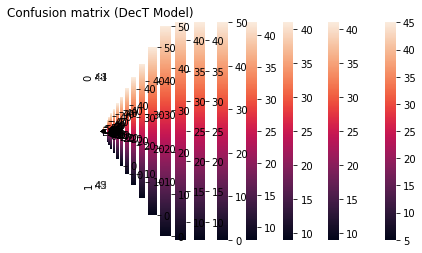

In [20]:
# Initialize variables to store results
# Clear any existing elements in the lists if they were previously initialized

shap_values_list = []
shap_dfs = []

# Number of iterations
n_iterations = 50

for i in range(n_iterations):
    # Step 2: Initial sampling
    
    majority_class = df[df['Outcome'] == 0]
    minority_class = df[df['Outcome'] == 1]

    # Define the number of samples to select
    n_samples = 50

    # Perform random sampling
    sampled_majority = majority_class.sample(n_samples, random_state=123)
    sampled_minority = minority_class.sample(n_samples, random_state=123)

    # Combine sampled data
    sampled_df = pd.concat([sampled_majority, sampled_minority])
    sampled_df

    #test
    y_test = sampled_df['Outcome']
    x_test = sampled_df.drop(columns='Outcome')

    # train
    # Separate remaining data for training
    remaining_df = df.drop(sampled_df.index)
    y_train = remaining_df['Outcome']
    x_train= remaining_df.drop(columns='Outcome')
    
    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train_ = scaler.transform(x_train)
    x_test_ = scaler.transform(x_test)
    
    #Modelling 
    
    ## Creating and running our optimization

    # Creating and running our optimization

    study_dect = optuna.create_study(direction='maximize',study_name = "Dect")
    with parallel_backend('threading'):
        study_dect.optimize(objective_dect, n_trials=10, n_jobs=-1)

    # Evaluating our Optuna Trial
    print("Best trial:", study_dect.best_trial.number)
    print("Best accuracy:", study_dect.best_trial.value)
    print("Best hyperparameters:", study_dect.best_params)

    best_param_dect = study_dect.best_params
    DecT = DecisionTreeClassifier(**best_param_dect,random_state=42).fit(x_train,y_train)
    y_pred_dect = DecT.predict(x_test)


    display_results(y_test, y_pred_dect, cm_title = "Confusion matrix (DecT Model)")


    # SHAP value computation using TreeExplainer
    explainer = shap.TreeExplainer(model=DecT, data= None, model_output= 'raw', feature_perturbation= 'tree_path_dependent')
    shap_values = explainer.shap_values(x_test_)

    # Extract SHAP values for class 0
    shap_values_array = abs(shap_values[:,:,0])

    # Store the SHAP values for stability analysis
    shap_values_list.append(shap_values_array)

    # Create DataFrame with SHAP values
    shap_values_df = pd.DataFrame(shap_values_array, columns=x_test.columns)
    shap_values_df['Outcome'] = y_test.values

    # Append DataFrame to the list
    shap_dfs.append(shap_values_df)

    print(shap_values_df)


# Concatenate all SHAP DataFrames row-wise
all_shap_values_df = pd.concat(shap_dfs, ignore_index=True)

# Print the combined DataFrame
print(all_shap_values_df)

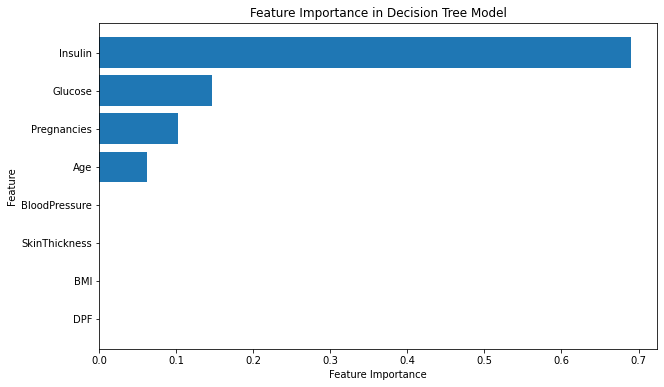

         Feature  Importance
4        Insulin    0.689605
1        Glucose    0.146199
0    Pregnancies    0.102246
7            Age    0.061950
2  BloodPressure    0.000000
3  SkinThickness    0.000000
5            BMI    0.000000
6            DPF    0.000000


In [21]:
# Get feature importances from the decision tree model
feature_importances = DecT.feature_importances_

# Get feature names
feature_names = x_train.columns

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Decision Tree Model')
plt.gca().invert_yaxis()
plt.show()

# Print the DataFrame for detailed view
print(importance_df)

In [22]:
# Create an valuestability DataFrame
valuestability = pd.DataFrame()

def calc_val(col_name, df, row_id):
    # Calculate the sum and mean
    summ = 0
    for i in range(n_iterations):
        summ += df[col_name].iloc[row_id]
        
        row_id += n_samples*2
        

    mean = summ / n_iterations
    row_id -= n_iterations*n_samples*2
    

    # Calculate the variance
    diff = 0
    for i in range(n_iterations):
        diff += (df[col_name].iloc[row_id] - mean) ** 2
        row_id += n_samples*2

    numerator = (diff / (n_iterations - 1)) ** 0.5
    denominator = mean

    final = numerator / denominator

    return final

def add_to_df():
    arr =[]
    col = x_test.columns
    for c in col:
        print(c)
        for i in range(n_samples*2):
            arr.append(calc_val(c,all_shap_values_df, i))
 
        
        valuestability[c] = arr
        arr =[]



In [23]:
# Call the add_to_df function to populate valuestability
add_to_df()
valuestability

cv = valuestability.sum(axis=1) / valuestability.shape[1]
valuestability['CV'] = cv

# Save the DataFrame to an Excel file
valuestability.to_excel('30_dt_valuestability.xlsx', index=False)
valuestability

Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DPF
Age


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,CV
0,1.632826,0.787553,4.143699,1.691181,0.299058,2.594507,1.763648,1.137003,1.756184
1,1.620830,0.751954,2.489652,1.789673,0.295832,1.861168,2.000284,1.136513,1.493238
2,1.620830,0.751954,2.489652,1.789673,0.295832,1.861168,2.000284,1.136513,1.493238
3,1.620830,0.753808,2.489652,1.789673,0.288649,2.475307,1.724242,1.136513,1.534834
4,1.654293,0.720203,2.489652,1.678213,0.377952,1.861168,1.967854,1.037937,1.473409
...,...,...,...,...,...,...,...,...,...
95,1.661242,0.720203,2.489652,1.678213,0.369832,1.861168,1.967854,1.034650,1.472852
96,1.620830,0.751954,2.489652,1.789673,0.295832,1.861168,2.000284,1.136513,1.493238
97,1.632826,0.787553,4.143699,1.691181,0.299058,2.594507,1.763648,1.137003,1.756184
98,1.620830,0.753808,2.489652,1.789673,0.288649,2.475307,1.724242,1.136513,1.534834


## 4.5 SVM (Support Vector Machine)

In [24]:
df = pd.read_csv("data_resampled_50.csv")
#from sklearn.model_selection import RepeatedKFold
rs=123

cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=rs)

def display_results(y_test, y_pred, cm_title):
        cm = confusion_matrix(y_test,y_pred)
        sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
        print(classification_report(y_test,y_pred))



In [25]:
# Creating an Objective Function

def objective_svm(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }
    
    # Define hyperparameters
    param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
                'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0),
                'class_weight': class_weight
                }

    # Create and train the model
    svm = SVC(**param_svm,random_state=rs)
    svm.fit(x_train_, y_train)

    # Evaluate the model
    score = cross_val_score(svm, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

[I 2024-08-26 16:04:12,541] A new study created in memory with name: SVM
[I 2024-08-26 16:04:13,236] Trial 3 finished with value: 0.8262973263731344 and parameters: {'C': 0.0917087869669178, 'gamma': 0.0816484252665633}. Best is trial 3 with value: 0.8262973263731344.
[I 2024-08-26 16:04:13,281] Trial 5 finished with value: 0.7974861174741258 and parameters: {'C': 5.247231580575065, 'gamma': 0.00033690871609108917}. Best is trial 3 with value: 0.8262973263731344.
[I 2024-08-26 16:04:13,320] Trial 1 finished with value: 0.8230331548713414 and parameters: {'C': 394.6711346407345, 'gamma': 0.0009492892040963312}. Best is trial 3 with value: 0.8262973263731344.
[I 2024-08-26 16:04:13,522] Trial 4 finished with value: 0.7336907201856033 and parameters: {'C': 0.1181153471042636, 'gamma': 0.0010630341240758841}. Best is trial 3 with value: 0.8262973263731344.
[I 2024-08-26 16:04:13,551] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.6269191727564595, 'gamma': 1.7994948

Best trial: 3
Best accuracy: 0.8262973263731344
Best hyperparameters: {'C': 0.0917087869669178, 'gamma': 0.0816484252665633}
              precision    recall  f1-score   support

           0       0.68      0.94      0.79        50
           1       0.90      0.56      0.69        50

    accuracy                           0.75       100
   macro avg       0.79      0.75      0.74       100
weighted avg       0.79      0.75      0.74       100



[I 2024-08-26 16:04:41,785] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.028286  0.175381       0.000143       0.003167  0.069286  0.039976   
1      0.047345  0.152512       0.004393       0.056155  0.113893  0.002060   
2      0.028143  0.111167       0.065381       0.025476  0.138476  0.029405   
3      0.026500  0.145476       0.025071       0.034857  0.114024  0.031167   
4      0.002905  0.109881       0.026238       0.002810  0.136833  0.020357   
..          ...       ...            ...            ...       ...       ...   
95     0.070405  0.016071       0.018857       0.009500  0.207452  0.001833   
96     0.048024  0.092452       0.002452       0.138262  0.102786  0.111762   
97     0.144929  0.254667       0.015667       0.388738  0.015905  0.036690   
98     0.016417  0.232036       0.018417       0.078036  0.231893  0.088226   
99     0.032071  0.213667       0.001524       0.066262  0.334690  0.004286   

         DPF       Age  Outcome  
0   0.020786  0.0

[I 2024-08-26 16:04:42,456] Trial 1 finished with value: 0.8033531232057846 and parameters: {'C': 2.285128058663652, 'gamma': 0.0012929061993899537}. Best is trial 1 with value: 0.8033531232057846.
[I 2024-08-26 16:04:42,499] Trial 4 finished with value: 0.7965916998741278 and parameters: {'C': 0.3601131537551176, 'gamma': 0.005338899792298394}. Best is trial 1 with value: 0.8033531232057846.
[I 2024-08-26 16:04:42,730] Trial 2 finished with value: 0.7747113115529629 and parameters: {'C': 3.550201578827161, 'gamma': 6.459506107454379e-05}. Best is trial 1 with value: 0.8033531232057846.
[I 2024-08-26 16:04:42,758] Trial 0 finished with value: 0.5783096833472736 and parameters: {'C': 0.013906108419526286, 'gamma': 0.008245762439416477}. Best is trial 1 with value: 0.8033531232057846.
[I 2024-08-26 16:04:42,764] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.06224324035512613, 'gamma': 3.7573535888451535e-05}. Best is trial 1 with value: 0.8033531232057846.
[I 202

Best trial: 8
Best accuracy: 0.8236159641038243
Best hyperparameters: {'C': 441.97805078106165, 'gamma': 0.0008231347487057915}
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        50
           1       0.92      0.70      0.80        50

    accuracy                           0.82       100
   macro avg       0.84      0.82      0.82       100
weighted avg       0.84      0.82      0.82       100



[I 2024-08-26 16:04:56,461] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.033679  0.191726       0.000369       0.004393  0.108655  0.050560   
1      0.056071  0.157381       0.000524       0.081833  0.162333  0.006143   
2      0.047560  0.140464       0.018821       0.037893  0.210250  0.050726   
3      0.038012  0.152464       0.009298       0.041345  0.167250  0.036964   
4      0.004774  0.109417       0.009012       0.002536  0.181107  0.029298   
..          ...       ...            ...            ...       ...       ...   
95     0.200548  0.207024       0.012071       0.103667  0.015000  0.135762   
96     0.062905  0.116190       0.000714       0.168571  0.131048  0.120095   
97     0.208440  0.315702       0.004702       0.358512  0.013702  0.047440   
98     0.012369  0.207179       0.005512       0.064464  0.215060  0.080440   
99     0.027107  0.173012       0.001202       0.047155  0.334060  0.010226   

         DPF       Age  Outcome  
0   0.035512  0.0

[I 2024-08-26 16:04:57,151] Trial 2 finished with value: 0.8186933302023016 and parameters: {'C': 268.28941391303215, 'gamma': 5.782954423673691e-05}. Best is trial 2 with value: 0.8186933302023016.
[I 2024-08-26 16:04:57,173] Trial 0 finished with value: 0.8195328430881976 and parameters: {'C': 0.7277139887515277, 'gamma': 0.2794759774236878}. Best is trial 0 with value: 0.8195328430881976.
[I 2024-08-26 16:04:57,194] Trial 1 finished with value: 0.823955291866293 and parameters: {'C': 49.17179152879749, 'gamma': 0.00262496753820041}. Best is trial 1 with value: 0.823955291866293.
[I 2024-08-26 16:04:57,365] Trial 5 finished with value: 0.7839297924809805 and parameters: {'C': 3.19697162706486, 'gamma': 0.00017641606670170526}. Best is trial 1 with value: 0.823955291866293.
[I 2024-08-26 16:04:57,417] Trial 3 finished with value: 0.8144921660551231 and parameters: {'C': 174.33785683743173, 'gamma': 0.0033959389547428692}. Best is trial 1 with value: 0.823955291866293.
[I 2024-08-26 16

Best trial: 1
Best accuracy: 0.823955291866293
Best hyperparameters: {'C': 49.17179152879749, 'gamma': 0.00262496753820041}
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        50
           1       0.92      0.70      0.80        50

    accuracy                           0.82       100
   macro avg       0.84      0.82      0.82       100
weighted avg       0.84      0.82      0.82       100



[I 2024-08-26 16:05:11,254] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.033167  0.192762       0.000619       0.004952  0.104881  0.051071   
1      0.055000  0.157381       0.001357       0.080976  0.161976  0.005643   
2      0.046131  0.143298       0.017488       0.037726  0.209988  0.050655   
3      0.037500  0.153929       0.005190       0.041476  0.166286  0.038333   
4      0.003452  0.112333       0.006214       0.003786  0.178095  0.029381   
..          ...       ...            ...            ...       ...       ...   
95     0.194952  0.203452       0.013643       0.109905  0.018952  0.138214   
96     0.062440  0.116964       0.000798       0.171869  0.127298  0.122940   
97     0.207464  0.317655       0.004940       0.357155  0.014774  0.048988   
98     0.012607  0.207893       0.004464       0.066131  0.213369  0.083774   
99     0.026750  0.176655       0.000631       0.048250  0.329583  0.010940   

         DPF       Age  Outcome  
0   0.034881  0.0

[I 2024-08-26 16:05:11,958] Trial 5 finished with value: 0.8251317651160524 and parameters: {'C': 0.2103282061551963, 'gamma': 0.040708469362564656}. Best is trial 5 with value: 0.8251317651160524.
[I 2024-08-26 16:05:11,980] Trial 1 finished with value: 0.8200233430408816 and parameters: {'C': 82.42369905384011, 'gamma': 0.0003162118782992295}. Best is trial 5 with value: 0.8251317651160524.
[I 2024-08-26 16:05:12,000] Trial 0 finished with value: 0.8120398095049848 and parameters: {'C': 22.390171165183855, 'gamma': 0.22071043929957856}. Best is trial 5 with value: 0.8251317651160524.
[I 2024-08-26 16:05:12,314] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.0033219493976164587, 'gamma': 0.011503681553731495}. Best is trial 5 with value: 0.8251317651160524.
[I 2024-08-26 16:05:12,327] Trial 4 finished with value: 0.5187641776941277 and parameters: {'C': 0.038136573863662246, 'gamma': 0.7344397179844346}. Best is trial 5 with value: 0.8251317651160524.
[I 2024-0

Best trial: 8
Best accuracy: 0.832477641477928
Best hyperparameters: {'C': 0.2006947467174096, 'gamma': 0.09940314017665568}
              precision    recall  f1-score   support

           0       0.75      0.94      0.83        50
           1       0.92      0.68      0.78        50

    accuracy                           0.81       100
   macro avg       0.83      0.81      0.81       100
weighted avg       0.83      0.81      0.81       100



[I 2024-08-26 16:05:28,783] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.045893  0.184345       0.002179       0.001345  0.097488  0.035869   
1      0.055357  0.145952       0.006286       0.056595  0.153476  0.004500   
2      0.034202  0.120083       0.066369       0.034393  0.182607  0.029512   
3      0.038619  0.141333       0.021619       0.045714  0.179333  0.017714   
4      0.001964  0.114750       0.026083       0.004393  0.178083  0.015250   
..          ...       ...            ...            ...       ...       ...   
95     0.182500  0.179143       0.104500       0.108024  0.038024  0.128810   
96     0.051369  0.099940       0.002012       0.163631  0.119893  0.129940   
97     0.177310  0.308786       0.010786       0.368238  0.063357  0.059452   
98     0.007333  0.172524       0.012786       0.066500  0.278690  0.057595   
99     0.036012  0.167131       0.000607       0.063393  0.322274  0.004250   

         DPF       Age  Outcome  
0   0.027298  0.0

[I 2024-08-26 16:05:29,461] Trial 5 finished with value: 0.8362279759093219 and parameters: {'C': 2.1608046560056136, 'gamma': 0.11760795493023536}. Best is trial 5 with value: 0.8362279759093219.
[I 2024-08-26 16:05:29,495] Trial 1 finished with value: 0.8197451966718856 and parameters: {'C': 365.01116710984843, 'gamma': 6.554222095390717e-05}. Best is trial 5 with value: 0.8362279759093219.
[I 2024-08-26 16:05:29,649] Trial 0 finished with value: 0.8137806145601671 and parameters: {'C': 0.38666815498805224, 'gamma': 0.4264440132048836}. Best is trial 5 with value: 0.8362279759093219.
[I 2024-08-26 16:05:29,782] Trial 4 finished with value: 0.8182863932475088 and parameters: {'C': 9.066355300671786, 'gamma': 0.3478360336036871}. Best is trial 5 with value: 0.8362279759093219.
[I 2024-08-26 16:05:29,861] Trial 2 finished with value: 0.7715149117401779 and parameters: {'C': 0.2105972434216333, 'gamma': 0.0008150154862579065}. Best is trial 5 with value: 0.8362279759093219.
[I 2024-08-26

Best trial: 5
Best accuracy: 0.8362279759093219
Best hyperparameters: {'C': 2.1608046560056136, 'gamma': 0.11760795493023536}
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        50
           1       0.90      0.76      0.83        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



[I 2024-08-26 16:05:44,608] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.035393  0.147417       0.006083       0.005298  0.215036  0.007131   
1      0.017214  0.127500       0.002667       0.006643  0.155262  0.001262   
2      0.007583  0.101964       0.005107       0.034774  0.362679  0.011631   
3      0.021679  0.105131       0.002655       0.022845  0.294250  0.004655   
4      0.007179  0.048417       0.013821       0.003964  0.321893  0.016155   
..          ...       ...            ...            ...       ...       ...   
95     0.059857  0.023095       0.006119       0.015095  0.252143  0.011976   
96     0.022905  0.101310       0.015667       0.113643  0.121833  0.310381   
97     0.000798  0.578607       0.029845       0.122321  0.113202  0.069250   
98     0.029393  0.019821       0.010155       0.059393  0.416679  0.006274   
99     0.006405  0.167095       0.005190       0.051262  0.247762  0.016119   

         DPF       Age  Outcome  
0   0.005964  0.0

[I 2024-08-26 16:05:45,332] Trial 5 finished with value: 0.8213174581483301 and parameters: {'C': 174.3099636232947, 'gamma': 0.0002849318759423888}. Best is trial 5 with value: 0.8213174581483301.
[I 2024-08-26 16:05:45,668] Trial 4 finished with value: 0.7807397159664106 and parameters: {'C': 0.6011645837287303, 'gamma': 0.6283495128814646}. Best is trial 5 with value: 0.8213174581483301.
[I 2024-08-26 16:05:45,703] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.003222383484277478, 'gamma': 0.2076812760012128}. Best is trial 5 with value: 0.8213174581483301.
[I 2024-08-26 16:05:45,710] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.0035477065495331246, 'gamma': 0.0010020559464639937}. Best is trial 5 with value: 0.8213174581483301.
[I 2024-08-26 16:05:45,713] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.00742762709282451, 'gamma': 1.991138234286839e-05}. Best is trial 5 with value: 0.8213174581483301.
[I 2024-0

Best trial: 8
Best accuracy: 0.8386178886322897
Best hyperparameters: {'C': 3.233744928892947, 'gamma': 0.10418324628575372}
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        50
           1       0.93      0.78      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100



[I 2024-08-26 16:06:00,267] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.043429  0.145738       0.002571       0.008429  0.209310  0.009167   
1      0.010750  0.128250       0.004560       0.014131  0.151750  0.001107   
2      0.017607  0.084583       0.009607       0.037488  0.420083  0.022917   
3      0.017655  0.104869       0.001917       0.018964  0.291774  0.002702   
4      0.001381  0.040286       0.000833       0.006143  0.348214  0.013690   
..          ...       ...            ...            ...       ...       ...   
95     0.221202  0.103083       0.094940       0.118083  0.098798  0.125107   
96     0.033798  0.128560       0.023774       0.093107  0.169750  0.316298   
97     0.008095  0.596952       0.015071       0.110024  0.105214  0.058190   
98     0.032381  0.016714       0.013738       0.059881  0.417881  0.009238   
99     0.024857  0.166786       0.005357       0.050190  0.273738  0.010714   

         DPF       Age  Outcome  
0   0.001167  0.0

[I 2024-08-26 16:06:00,948] Trial 3 finished with value: 0.8227388103434443 and parameters: {'C': 0.6800587448264804, 'gamma': 0.014148375813185085}. Best is trial 3 with value: 0.8227388103434443.
[I 2024-08-26 16:06:00,956] Trial 2 finished with value: 0.8187000341096451 and parameters: {'C': 38.83008400548816, 'gamma': 0.0003798445016016472}. Best is trial 3 with value: 0.8227388103434443.
[I 2024-08-26 16:06:01,032] Trial 5 finished with value: 0.7998109162047956 and parameters: {'C': 0.8753149644607117, 'gamma': 0.002507405564216034}. Best is trial 3 with value: 0.8227388103434443.
[I 2024-08-26 16:06:01,213] Trial 1 finished with value: 0.8180574028707032 and parameters: {'C': 87.34993848676677, 'gamma': 0.007810362341672048}. Best is trial 3 with value: 0.8227388103434443.
[I 2024-08-26 16:06:01,296] Trial 0 finished with value: 0.7622460003480055 and parameters: {'C': 0.01547644357583653, 'gamma': 0.02877400626452428}. Best is trial 3 with value: 0.8227388103434443.
[I 2024-08-

Best trial: 6
Best accuracy: 0.8279400888711415
Best hyperparameters: {'C': 967.7540248645022, 'gamma': 0.013245318230507572}
              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100



[I 2024-08-26 16:06:14,599] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.067940  0.191560       0.001464       0.001774  0.145631  0.020131   
1      0.006905  0.139786       0.002810       0.037381  0.151571  0.002595   
2      0.018286  0.065000       0.003690       0.022095  0.421357  0.006976   
3      0.017500  0.127143       0.018190       0.014738  0.290810  0.011619   
4      0.015512  0.049655       0.001250       0.003869  0.341131  0.016631   
..          ...       ...            ...            ...       ...       ...   
95     0.297893  0.025655       0.125155       0.092845  0.030750  0.066560   
96     0.036583  0.467155       0.069202       0.039917  0.017750  0.057036   
97     0.021060  0.644345       0.005369       0.112679  0.101226  0.025345   
98     0.029857  0.017881       0.012810       0.060000  0.423881  0.000571   
99     0.052310  0.236952       0.016857       0.045500  0.206048  0.036286   

         DPF       Age  Outcome  
0   0.018036  0.0

[I 2024-08-26 16:06:15,445] Trial 4 finished with value: 0.7977499571136693 and parameters: {'C': 3.4399667668073715, 'gamma': 0.0005505008305713274}. Best is trial 4 with value: 0.7977499571136693.
[I 2024-08-26 16:06:15,653] Trial 5 finished with value: 0.7955670232083021 and parameters: {'C': 104.31618395509804, 'gamma': 0.11941542442247807}. Best is trial 4 with value: 0.7977499571136693.
[I 2024-08-26 16:06:15,686] Trial 2 finished with value: 0.7598888035032083 and parameters: {'C': 0.013835150622893639, 'gamma': 0.06784888973881563}. Best is trial 4 with value: 0.7977499571136693.
[I 2024-08-26 16:06:15,734] Trial 1 finished with value: 0.592994549560336 and parameters: {'C': 0.035070972888559794, 'gamma': 0.002955463278771069}. Best is trial 4 with value: 0.7977499571136693.
[I 2024-08-26 16:06:15,781] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.0012695597231730696, 'gamma': 0.008767062122046504}. Best is trial 4 with value: 0.7977499571136693.
[I 202

Best trial: 6
Best accuracy: 0.8011075758187218
Best hyperparameters: {'C': 1.0032807501591632, 'gamma': 0.47916240505757945}
              precision    recall  f1-score   support

           0       0.75      0.94      0.83        50
           1       0.92      0.68      0.78        50

    accuracy                           0.81       100
   macro avg       0.83      0.81      0.81       100
weighted avg       0.83      0.81      0.81       100



[I 2024-08-26 16:06:36,428] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.019548  0.118119       0.017119       0.012262  0.185262  0.022952   
1      0.023345  0.083583       0.009274       0.044583  0.134560  0.002464   
2      0.009810  0.057762       0.131786       0.015667  0.149833  0.022190   
3      0.007179  0.104036       0.031393       0.029226  0.244417  0.003345   
4      0.020381  0.068071       0.076929       0.007119  0.247214  0.012762   
..          ...       ...            ...            ...       ...       ...   
95     0.180179  0.154631       0.012417       0.147726  0.044226  0.148107   
96     0.061512  0.328369       0.094631       0.094702  0.035821  0.157488   
97     0.139417  0.318179       0.038893       0.306274  0.082750  0.000155   
98     0.008321  0.045845       0.010917       0.116393  0.404512  0.010726   
99     0.177738  0.195857       0.138500       0.036857  0.197571  0.011190   

         DPF       Age  Outcome  
0   0.004143  0.0

[I 2024-08-26 16:06:37,208] Trial 5 finished with value: 0.8075495201494209 and parameters: {'C': 2.5169450774986957, 'gamma': 0.002224730729943871}. Best is trial 5 with value: 0.8075495201494209.
[I 2024-08-26 16:06:37,288] Trial 3 finished with value: 0.8215286165071736 and parameters: {'C': 2.283523797989596, 'gamma': 0.010331219154670243}. Best is trial 3 with value: 0.8215286165071736.
[I 2024-08-26 16:06:37,596] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.0012128561569790747, 'gamma': 0.004268853894419533}. Best is trial 3 with value: 0.8215286165071736.
[I 2024-08-26 16:06:37,627] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.002230693663097206, 'gamma': 0.009903787920529766}. Best is trial 3 with value: 0.8215286165071736.
[I 2024-08-26 16:06:37,674] Trial 2 finished with value: 0.7894492418301698 and parameters: {'C': 1.9135594074910296, 'gamma': 0.556662066655944}. Best is trial 3 with value: 0.8215286165071736.
[I 2024-08-

Best trial: 0
Best accuracy: 0.8242321971775917
Best hyperparameters: {'C': 594.399518062544, 'gamma': 0.01692080843742227}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100



[I 2024-08-26 16:06:50,270] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.070083  0.195821       0.005417       0.000012  0.142440  0.013512   
1      0.007333  0.151952       0.002762       0.036000  0.155762  0.005310   
2      0.012571  0.067000       0.003833       0.017262  0.410476  0.006286   
3      0.019143  0.132286       0.019548       0.012024  0.288333  0.013167   
4      0.013345  0.051131       0.000607       0.002345  0.358393  0.015226   
..          ...       ...            ...            ...       ...       ...   
95     0.292786  0.025429       0.100333       0.089810  0.031119  0.076429   
96     0.039071  0.470119       0.069619       0.039262  0.016048  0.064119   
97     0.016250  0.634845       0.003155       0.099488  0.096821  0.024345   
98     0.030321  0.023345       0.012417       0.053488  0.422036  0.002798   
99     0.043345  0.261036       0.013774       0.040155  0.208536  0.031488   

         DPF       Age  Outcome  
0   0.017655  0.0

[I 2024-08-26 16:06:51,033] Trial 1 finished with value: 0.8170953367612477 and parameters: {'C': 311.6782174589925, 'gamma': 3.103374493485606e-05}. Best is trial 1 with value: 0.8170953367612477.
[I 2024-08-26 16:06:51,095] Trial 4 finished with value: 0.8227660275272907 and parameters: {'C': 33.34122640973188, 'gamma': 0.0014314273037800732}. Best is trial 4 with value: 0.8227660275272907.
[I 2024-08-26 16:06:51,105] Trial 3 finished with value: 0.8057594362703613 and parameters: {'C': 0.08997379581450983, 'gamma': 0.02675197884195793}. Best is trial 4 with value: 0.8227660275272907.
[I 2024-08-26 16:06:51,139] Trial 0 finished with value: 0.7959790793747972 and parameters: {'C': 431.2728371057164, 'gamma': 0.15869394083390834}. Best is trial 4 with value: 0.8227660275272907.
[I 2024-08-26 16:06:51,476] Trial 2 finished with value: 0.7557714364793182 and parameters: {'C': 2.396767348970714, 'gamma': 0.7628627852601731}. Best is trial 4 with value: 0.8227660275272907.
[I 2024-08-26 1

Best trial: 9
Best accuracy: 0.8342080067140355
Best hyperparameters: {'C': 310.7249318315765, 'gamma': 0.014039180610890541}
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100



[I 2024-08-26 16:07:03,714] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.083036  0.157464       0.005512       0.001631  0.160655  0.008155   
1      0.019214  0.122452       0.012548       0.019119  0.162381  0.004524   
2      0.017726  0.093417       0.028155       0.033702  0.464893  0.022298   
3      0.029000  0.110167       0.002167       0.014167  0.318333  0.003738   
4      0.013762  0.040571       0.019095       0.002405  0.345071  0.011048   
..          ...       ...            ...            ...       ...       ...   
95     0.275345  0.035774       0.131107       0.102774  0.040845  0.085679   
96     0.093286  0.355333       0.059976       0.012357  0.004595  0.102071   
97     0.068845  0.616964       0.003250       0.145345  0.091702  0.041774   
98     0.037012  0.012655       0.017440       0.070940  0.379917  0.004440   
99     0.019345  0.139012       0.000893       0.036774  0.311917  0.006631   

         DPF       Age  Outcome  
0   0.006821  0.0

[I 2024-08-26 16:07:04,436] Trial 1 finished with value: 0.8376544642580467 and parameters: {'C': 0.8447176016911718, 'gamma': 0.04683828782792473}. Best is trial 1 with value: 0.8376544642580467.
[I 2024-08-26 16:07:04,454] Trial 4 finished with value: 0.8287359600950527 and parameters: {'C': 4.928333578862718, 'gamma': 0.014739251445028554}. Best is trial 1 with value: 0.8376544642580467.
[I 2024-08-26 16:07:04,616] Trial 0 finished with value: 0.7956400459994397 and parameters: {'C': 2.2406502155442984, 'gamma': 0.0007261957625959446}. Best is trial 1 with value: 0.8376544642580467.
[I 2024-08-26 16:07:04,895] Trial 2 finished with value: 0.7938030338650977 and parameters: {'C': 5.825417557372997, 'gamma': 0.5447169324418095}. Best is trial 1 with value: 0.8376544642580467.
[I 2024-08-26 16:07:04,907] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.010486361841162598, 'gamma': 1.8291554310182656e-05}. Best is trial 1 with value: 0.8376544642580467.
[I 2024-08-

Best trial: 1
Best accuracy: 0.8376544642580467
Best hyperparameters: {'C': 0.8447176016911718, 'gamma': 0.04683828782792473}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 16:07:19,502] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.042464  0.165131       0.001107       0.005964  0.137845  0.030393   
1      0.041036  0.142702       0.003655       0.048536  0.169464  0.004893   
2      0.024869  0.143702       0.034107       0.036607  0.218369  0.043893   
3      0.031476  0.131405       0.010071       0.038810  0.206810  0.018095   
4      0.002369  0.090536       0.022179       0.004012  0.206250  0.012726   
..          ...       ...            ...            ...       ...       ...   
95     0.030714  0.008690       0.013929       0.006214  0.219310  0.005667   
96     0.036452  0.090238       0.000429       0.163548  0.137810  0.133476   
97     0.161048  0.331238       0.000571       0.348452  0.040143  0.070262   
98     0.006464  0.112155       0.010679       0.064131  0.309750  0.048179   
99     0.026893  0.140917       0.000631       0.052845  0.340107  0.000464   

         DPF       Age  Outcome  
0   0.025702  0.0

[I 2024-08-26 16:07:20,312] Trial 4 finished with value: 0.8293790709008377 and parameters: {'C': 2.1673421664457546, 'gamma': 0.019949657934109275}. Best is trial 4 with value: 0.8293790709008377.
[I 2024-08-26 16:07:20,463] Trial 3 finished with value: 0.7960016326951319 and parameters: {'C': 21.13156683268428, 'gamma': 6.377566113432288e-05}. Best is trial 4 with value: 0.8293790709008377.
[I 2024-08-26 16:07:20,470] Trial 2 finished with value: 0.8113427286701809 and parameters: {'C': 21.541749569343207, 'gamma': 0.27634158210251475}. Best is trial 4 with value: 0.8293790709008377.
[I 2024-08-26 16:07:20,719] Trial 0 finished with value: 0.772723660727416 and parameters: {'C': 11.58978240333704, 'gamma': 1.5634682228225955e-05}. Best is trial 4 with value: 0.8293790709008377.
[I 2024-08-26 16:07:20,754] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.04307992139731069, 'gamma': 0.0009886421486307929}. Best is trial 4 with value: 0.8293790709008377.
[I 2024-08

Best trial: 8
Best accuracy: 0.837892701208008
Best hyperparameters: {'C': 9.249403148830144, 'gamma': 0.05370162023196459}
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



[I 2024-08-26 16:07:34,095] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.052345  0.154821       0.005631       0.007560  0.212179  0.006226   
1      0.016512  0.138798       0.008274       0.010869  0.168655  0.004202   
2      0.011488  0.091012       0.000798       0.032155  0.420440  0.018512   
3      0.027310  0.106595       0.001571       0.012643  0.299690  0.002643   
4      0.005345  0.046512       0.004155       0.000726  0.341512  0.012798   
..          ...       ...            ...            ...       ...       ...   
95     0.248714  0.102357       0.058000       0.109810  0.069500  0.110119   
96     0.023298  0.117655       0.018750       0.102607  0.180774  0.303226   
97     0.025417  0.582488       0.009226       0.123464  0.113226  0.052726   
98     0.031845  0.020369       0.010226       0.053488  0.413631  0.004083   
99     0.007190  0.146619       0.006000       0.049976  0.298024  0.011619   

         DPF       Age  Outcome  
0   0.000226  0.0

[I 2024-08-26 16:07:34,880] Trial 5 finished with value: 0.826860071619769 and parameters: {'C': 2.8267955104929126, 'gamma': 0.011898087577058809}. Best is trial 5 with value: 0.826860071619769.
[I 2024-08-26 16:07:34,951] Trial 3 finished with value: 0.8220262392094628 and parameters: {'C': 292.5039989601004, 'gamma': 0.00047606867949069007}. Best is trial 5 with value: 0.826860071619769.
[I 2024-08-26 16:07:34,992] Trial 0 finished with value: 0.821128911458732 and parameters: {'C': 393.09812960168216, 'gamma': 0.0003619352514629482}. Best is trial 5 with value: 0.826860071619769.
[I 2024-08-26 16:07:35,261] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.003084391350244973, 'gamma': 0.3504035237940384}. Best is trial 5 with value: 0.826860071619769.
[I 2024-08-26 16:07:35,304] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.025437563292009146, 'gamma': 7.723733055508121e-05}. Best is trial 5 with value: 0.826860071619769.
[I 2024-08-26 

Best trial: 5
Best accuracy: 0.826860071619769
Best hyperparameters: {'C': 2.8267955104929126, 'gamma': 0.011898087577058809}
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        50
           1       0.92      0.70      0.80        50

    accuracy                           0.82       100
   macro avg       0.84      0.82      0.82       100
weighted avg       0.84      0.82      0.82       100



[I 2024-08-26 16:07:50,016] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.034798  0.195964       0.000821       0.002917  0.101845  0.049321   
1      0.052345  0.160226       0.000155       0.079179  0.157988  0.005417   
2      0.044821  0.157226       0.008702       0.040060  0.209417  0.052274   
3      0.041512  0.158631       0.001440       0.042298  0.163845  0.038012   
4      0.005060  0.116155       0.000345       0.003036  0.177321  0.028226   
..          ...       ...            ...            ...       ...       ...   
95     0.202631  0.206345       0.020750       0.102560  0.012179  0.128726   
96     0.060976  0.120929       0.001048       0.167738  0.125714  0.127476   
97     0.198738  0.334690       0.000190       0.346500  0.021571  0.059571   
98     0.014667  0.214667       0.001095       0.064143  0.214214  0.084405   
99     0.030548  0.183476       0.001381       0.047262  0.311667  0.009000   

         DPF       Age  Outcome  
0   0.033845  0.0

[I 2024-08-26 16:07:50,783] Trial 0 finished with value: 0.8219327091676725 and parameters: {'C': 279.61863179414576, 'gamma': 0.0003313459682046446}. Best is trial 0 with value: 0.8219327091676725.
[I 2024-08-26 16:07:50,808] Trial 5 finished with value: 0.817035048673124 and parameters: {'C': 148.90088540443236, 'gamma': 8.712452756946678e-05}. Best is trial 0 with value: 0.8219327091676725.
[I 2024-08-26 16:07:50,821] Trial 1 finished with value: 0.8167700519048492 and parameters: {'C': 14.633900006912032, 'gamma': 0.0006485770859038004}. Best is trial 0 with value: 0.8219327091676725.
[I 2024-08-26 16:07:50,889] Trial 2 finished with value: 0.8216304731660665 and parameters: {'C': 277.4665410542905, 'gamma': 0.0005015167086484726}. Best is trial 0 with value: 0.8219327091676725.
[I 2024-08-26 16:07:50,958] Trial 4 finished with value: 0.8095183312666286 and parameters: {'C': 0.321152390153315, 'gamma': 0.5025710244193606}. Best is trial 0 with value: 0.8219327091676725.
[I 2024-08-

Best trial: 0
Best accuracy: 0.8219327091676725
Best hyperparameters: {'C': 279.61863179414576, 'gamma': 0.0003313459682046446}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 16:08:05,431] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.030643  0.191262       0.001119       0.003286  0.094905  0.045024   
1      0.068179  0.163107       0.001274       0.112536  0.150726  0.003560   
2      0.049917  0.146964       0.008202       0.041155  0.191512  0.057393   
3      0.036488  0.161012       0.006202       0.041131  0.141821  0.036726   
4      0.001190  0.114167       0.004810       0.002119  0.168952  0.026429   
..          ...       ...            ...            ...       ...       ...   
95     0.260167  0.238476       0.009500       0.088262  0.013190  0.093357   
96     0.065857  0.127738       0.000238       0.170524  0.124929  0.095357   
97     0.226690  0.359952       0.007262       0.325024  0.017048  0.067595   
98     0.019179  0.247107       0.005107       0.065440  0.234369  0.088083   
99     0.031357  0.209476       0.000548       0.052929  0.311452  0.006476   

         DPF       Age  Outcome  
0   0.036286  0.0

[I 2024-08-26 16:08:06,149] Trial 0 finished with value: 0.8303905987940218 and parameters: {'C': 1.8103436977821743, 'gamma': 0.045225046510905566}. Best is trial 0 with value: 0.8303905987940218.
[I 2024-08-26 16:08:06,192] Trial 4 finished with value: 0.815718446096901 and parameters: {'C': 308.6403094257401, 'gamma': 3.694714775666476e-05}. Best is trial 0 with value: 0.8303905987940218.
[I 2024-08-26 16:08:06,214] Trial 3 finished with value: 0.8211247922633557 and parameters: {'C': 374.14769625930865, 'gamma': 0.00013772811988902077}. Best is trial 0 with value: 0.8303905987940218.
[I 2024-08-26 16:08:06,274] Trial 5 finished with value: 0.821991282774581 and parameters: {'C': 0.17299739014551005, 'gamma': 0.2743986815471576}. Best is trial 0 with value: 0.8303905987940218.
[I 2024-08-26 16:08:06,566] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.0653886840289299, 'gamma': 1.1993290811519553e-05}. Best is trial 0 with value: 0.8303905987940218.
[I 2024-08

Best trial: 0
Best accuracy: 0.8303905987940218
Best hyperparameters: {'C': 1.8103436977821743, 'gamma': 0.045225046510905566}
              precision    recall  f1-score   support

           0       0.77      0.92      0.84        50
           1       0.90      0.72      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



[I 2024-08-26 16:08:20,239] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.041488  0.165226       0.003702       0.007917  0.143726  0.019726   
1      0.016869  0.142298       0.000702       0.028131  0.156012  0.000440   
2      0.002083  0.141869       0.005798       0.038036  0.300226  0.032655   
3      0.022179  0.127464       0.014321       0.040012  0.262631  0.013107   
4      0.003405  0.070762       0.001286       0.006357  0.225143  0.006119   
..          ...       ...            ...            ...       ...       ...   
95     0.021095  0.027119       0.015714       0.036167  0.276500  0.017405   
96     0.016893  0.098512       0.002679       0.161179  0.140750  0.159345   
97     0.082083  0.346679       0.130131       0.345107  0.114869  0.077298   
98     0.008405  0.066119       0.004476       0.062524  0.351024  0.036738   
99     0.023845  0.131488       0.005417       0.047917  0.329560  0.003774   

         DPF       Age  Outcome  
0   0.021155  0.0

[I 2024-08-26 16:08:20,907] Trial 2 finished with value: 0.8370368826972292 and parameters: {'C': 0.7329720867874819, 'gamma': 0.06000548500043996}. Best is trial 2 with value: 0.8370368826972292.
[I 2024-08-26 16:08:20,932] Trial 3 finished with value: 0.8187980526333761 and parameters: {'C': 986.5586714118888, 'gamma': 2.0048818975086185e-05}. Best is trial 2 with value: 0.8370368826972292.
[I 2024-08-26 16:08:21,330] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.08701254781886306, 'gamma': 0.0003094693585402545}. Best is trial 2 with value: 0.8370368826972292.
[I 2024-08-26 16:08:21,341] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.006914702263566189, 'gamma': 7.524772202307228e-05}. Best is trial 2 with value: 0.8370368826972292.
[I 2024-08-26 16:08:21,353] Trial 5 finished with value: 0.3045897219680594 and parameters: {'C': 0.009387006125358388, 'gamma': 0.3772191004950323}. Best is trial 2 with value: 0.8370368826972292.
[I 2024

Best trial: 2
Best accuracy: 0.8370368826972292
Best hyperparameters: {'C': 0.7329720867874819, 'gamma': 0.06000548500043996}
              precision    recall  f1-score   support

           0       0.78      0.94      0.85        50
           1       0.93      0.74      0.82        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



[I 2024-08-26 16:08:36,038] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.042833  0.168524       0.000286       0.005238  0.131476  0.029071   
1      0.031762  0.137643       0.000429       0.037929  0.166095  0.005429   
2      0.015548  0.147000       0.038000       0.035286  0.220262  0.040452   
3      0.029452  0.131810       0.008667       0.035143  0.211738  0.016333   
4      0.003905  0.084833       0.026286       0.006119  0.207595  0.010333   
..          ...       ...            ...            ...       ...       ...   
95     0.019786  0.003643       0.021429       0.003929  0.221881  0.004857   
96     0.027655  0.089179       0.000774       0.156726  0.139940  0.152488   
97     0.038964  0.493869       0.022179       0.185393  0.191655  0.062583   
98     0.010333  0.092381       0.010214       0.059524  0.317643  0.048476   
99     0.021536  0.135012       0.001417       0.049726  0.335298  0.002417   

         DPF       Age  Outcome  
0   0.023905  0.0

[I 2024-08-26 16:08:36,770] Trial 4 finished with value: 0.8071616085402131 and parameters: {'C': 2.951225057668652, 'gamma': 0.0020976746142253567}. Best is trial 4 with value: 0.8071616085402131.
[I 2024-08-26 16:08:36,793] Trial 5 finished with value: 0.822236210211767 and parameters: {'C': 768.5203134291917, 'gamma': 0.00011022529638637789}. Best is trial 5 with value: 0.822236210211767.
[I 2024-08-26 16:08:37,059] Trial 0 finished with value: 0.8254939549367691 and parameters: {'C': 76.24877003714097, 'gamma': 0.012750058034763725}. Best is trial 0 with value: 0.8254939549367691.
[I 2024-08-26 16:08:37,146] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.008117387857973947, 'gamma': 6.0370953133891e-05}. Best is trial 0 with value: 0.8254939549367691.
[I 2024-08-26 16:08:37,160] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.0975683403969667, 'gamma': 4.377356274157197e-05}. Best is trial 0 with value: 0.8254939549367691.
[I 2024-08-2

Best trial: 0
Best accuracy: 0.8254939549367691
Best hyperparameters: {'C': 76.24877003714097, 'gamma': 0.012750058034763725}
              precision    recall  f1-score   support

           0       0.75      0.92      0.83        50
           1       0.90      0.70      0.79        50

    accuracy                           0.81       100
   macro avg       0.83      0.81      0.81       100
weighted avg       0.83      0.81      0.81       100



[I 2024-08-26 16:08:49,480] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.053750  0.172702       0.003226       0.014155  0.127012  0.005917   
1      0.005583  0.141845       0.000321       0.009845  0.153107  0.000488   
2      0.030190  0.123810       0.015714       0.026595  0.320357  0.011571   
3      0.019667  0.124167       0.000429       0.023357  0.269500  0.001881   
4      0.009298  0.063750       0.000798       0.007107  0.213750  0.000464   
..          ...       ...            ...            ...       ...       ...   
95     0.157071  0.149048       0.109952       0.122429  0.051095  0.134024   
96     0.002679  0.103369       0.001345       0.165202  0.124631  0.194750   
97     0.017071  0.329905       0.156810       0.371881  0.117619  0.046095   
98     0.024440  0.044083       0.002274       0.074464  0.359369  0.015583   
99     0.012393  0.141440       0.005940       0.045417  0.327726  0.002988   

         DPF       Age  Outcome  
0   0.017155  0.0

[I 2024-08-26 16:08:50,166] Trial 4 finished with value: 0.8176046621830557 and parameters: {'C': 3.7189550814378403, 'gamma': 0.002311510248205138}. Best is trial 4 with value: 0.8176046621830557.
[I 2024-08-26 16:08:50,238] Trial 3 finished with value: 0.8140128934414733 and parameters: {'C': 23.884547517678733, 'gamma': 0.20685084958468156}. Best is trial 4 with value: 0.8176046621830557.
[I 2024-08-26 16:08:50,468] Trial 5 finished with value: 0.7719500785596212 and parameters: {'C': 0.6519569915991439, 'gamma': 0.00046880163525901534}. Best is trial 4 with value: 0.8176046621830557.
[I 2024-08-26 16:08:50,500] Trial 0 finished with value: 0.8054924303751863 and parameters: {'C': 90.46065502493379, 'gamma': 0.4746352693258284}. Best is trial 4 with value: 0.8176046621830557.
[I 2024-08-26 16:08:50,564] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.6740394077536043, 'gamma': 7.507520626683587e-05}. Best is trial 4 with value: 0.8176046621830557.
[I 2024-08-2

Best trial: 2
Best accuracy: 0.8299138790626058
Best hyperparameters: {'C': 214.32371600452586, 'gamma': 0.010650967639624346}
              precision    recall  f1-score   support

           0       0.76      0.90      0.83        50
           1       0.88      0.72      0.79        50

    accuracy                           0.81       100
   macro avg       0.82      0.81      0.81       100
weighted avg       0.82      0.81      0.81       100



[I 2024-08-26 16:09:02,592] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.063393  0.164250       0.004250       0.013107  0.182512  0.003607   
1      0.004464  0.137750       0.002155       0.008202  0.155464  0.002083   
2      0.027060  0.119083       0.006821       0.024488  0.372536  0.011821   
3      0.024202  0.123179       0.008488       0.018226  0.299369  0.002393   
4      0.023131  0.052917       0.006583       0.003417  0.234036  0.001917   
..          ...       ...            ...            ...       ...       ...   
95     0.186905  0.134238       0.145429       0.124476  0.061595  0.120000   
96     0.029405  0.121262       0.002071       0.135619  0.181024  0.246810   
97     0.169060  0.531583       0.022726       0.186583  0.159750  0.053345   
98     0.030500  0.031333       0.009571       0.062881  0.375214  0.008762   
99     0.012357  0.129238       0.004119       0.040095  0.321357  0.002810   

         DPF       Age  Outcome  
0   0.024631  0.0

[I 2024-08-26 16:09:03,447] Trial 3 finished with value: 0.8297217416101584 and parameters: {'C': 29.005118817326878, 'gamma': 0.02087693642362089}. Best is trial 3 with value: 0.8297217416101584.
[I 2024-08-26 16:09:03,506] Trial 2 finished with value: 0.8218228408317296 and parameters: {'C': 572.6233474546087, 'gamma': 0.0006562625265107942}. Best is trial 3 with value: 0.8297217416101584.
[I 2024-08-26 16:09:03,714] Trial 0 finished with value: 0.7877409406545821 and parameters: {'C': 85.00026410879966, 'gamma': 0.08300236247977477}. Best is trial 3 with value: 0.8297217416101584.
[I 2024-08-26 16:09:03,722] Trial 1 finished with value: 0.6338845551710919 and parameters: {'C': 0.07897163376350594, 'gamma': 0.7827183275669607}. Best is trial 3 with value: 0.8297217416101584.
[I 2024-08-26 16:09:03,731] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.43858233277672937, 'gamma': 3.214409467153077e-05}. Best is trial 3 with value: 0.8297217416101584.
[I 2024-08-26

Best trial: 5
Best accuracy: 0.8313617415615644
Best hyperparameters: {'C': 128.6909481954448, 'gamma': 0.016247226557353625}
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



[I 2024-08-26 16:09:15,849] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.070488  0.165012       0.004845       0.004440  0.160869  0.003845   
1      0.005036  0.136298       0.008202       0.011940  0.165060  0.000607   
2      0.026857  0.113429       0.034452       0.037310  0.459643  0.027571   
3      0.028000  0.116429       0.002476       0.017262  0.306738  0.002095   
4      0.014488  0.052488       0.016417       0.001583  0.306560  0.016464   
..          ...       ...            ...            ...       ...       ...   
95     0.227833  0.096095       0.111762       0.101452  0.021500  0.088619   
96     0.013821  0.121512       0.006250       0.122179  0.183036  0.272036   
97     0.107155  0.568369       0.015631       0.165869  0.115250  0.054107   
98     0.036405  0.023810       0.014238       0.067262  0.380429  0.000262   
99     0.015238  0.129143       0.002262       0.044881  0.320857  0.003405   

         DPF       Age  Outcome  
0   0.002940  0.0

[I 2024-08-26 16:09:16,597] Trial 0 finished with value: 0.8173083721182691 and parameters: {'C': 22.450042750166958, 'gamma': 0.0004836105717885623}. Best is trial 0 with value: 0.8173083721182691.
[I 2024-08-26 16:09:16,769] Trial 5 finished with value: 0.8012273904558824 and parameters: {'C': 0.6373968317680649, 'gamma': 0.003625274229420431}. Best is trial 0 with value: 0.8173083721182691.
[I 2024-08-26 16:09:16,891] Trial 2 finished with value: 0.8151730267430899 and parameters: {'C': 169.5432583281759, 'gamma': 0.003362324823520994}. Best is trial 0 with value: 0.8173083721182691.
[I 2024-08-26 16:09:16,902] Trial 3 finished with value: 0.8265418145296133 and parameters: {'C': 185.89345664311134, 'gamma': 0.001801530953328198}. Best is trial 3 with value: 0.8265418145296133.
[I 2024-08-26 16:09:16,905] Trial 1 finished with value: 0.7921236139797994 and parameters: {'C': 568.9071191029158, 'gamma': 0.12731908211082782}. Best is trial 3 with value: 0.8265418145296133.
[I 2024-08-2

Best trial: 7
Best accuracy: 0.8355158636169783
Best hyperparameters: {'C': 4.86426876863679, 'gamma': 0.05282909902721702}
              precision    recall  f1-score   support

           0       0.78      0.90      0.83        50
           1       0.88      0.74      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



[I 2024-08-26 16:09:29,969] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.062000  0.167595       0.004262       0.004786  0.147262  0.005786   
1      0.015369  0.137488       0.000060       0.005607  0.159988  0.000988   
2      0.004917  0.096226       0.020774       0.031536  0.333869  0.003036   
3      0.023405  0.116429       0.002262       0.024714  0.289762  0.000976   
4      0.005845  0.055393       0.005893       0.002250  0.260726  0.003298   
..          ...       ...            ...            ...       ...       ...   
95     0.187107  0.123488       0.098274       0.127440  0.084179  0.133798   
96     0.003940  0.091345       0.010488       0.157131  0.130631  0.217060   
97     0.011476  0.551810       0.007500       0.152905  0.150857  0.082548   
98     0.023750  0.034131       0.005274       0.057893  0.386440  0.012964   
99     0.011548  0.131690       0.004262       0.050833  0.306595  0.001619   

         DPF       Age  Outcome  
0   0.009643  0.0

[I 2024-08-26 16:09:30,669] Trial 5 finished with value: 0.8283937484126834 and parameters: {'C': 4.951550201739452, 'gamma': 0.014394600663612712}. Best is trial 5 with value: 0.8283937484126834.
[I 2024-08-26 16:09:30,726] Trial 2 finished with value: 0.821128911458732 and parameters: {'C': 328.76304181141876, 'gamma': 0.00040205569097319295}. Best is trial 5 with value: 0.8283937484126834.
[I 2024-08-26 16:09:30,959] Trial 1 finished with value: 0.8156207581025327 and parameters: {'C': 99.01296925957186, 'gamma': 0.35867306963523293}. Best is trial 5 with value: 0.8283937484126834.
[I 2024-08-26 16:09:31,039] Trial 0 finished with value: 0.7600526369708308 and parameters: {'C': 0.01062025546155903, 'gamma': 0.03142354000837424}. Best is trial 5 with value: 0.8283937484126834.
[I 2024-08-26 16:09:31,050] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.07299662317374188, 'gamma': 0.000383881509298317}. Best is trial 5 with value: 0.8283937484126834.
[I 2024-08-2

Best trial: 8
Best accuracy: 0.8328091167073268
Best hyperparameters: {'C': 0.2604585280813548, 'gamma': 0.10772967733605253}
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        50
           1       0.92      0.70      0.80        50

    accuracy                           0.82       100
   macro avg       0.84      0.82      0.82       100
weighted avg       0.84      0.82      0.82       100



[I 2024-08-26 16:09:47,822] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.042798  0.176298       0.000155       0.005226  0.117393  0.033655   
1      0.047929  0.136714       0.006048       0.047857  0.160024  0.005905   
2      0.028107  0.111440       0.076298       0.032488  0.190202  0.028440   
3      0.028250  0.132321       0.022774       0.043750  0.197893  0.015631   
4      0.001012  0.096417       0.035821       0.007417  0.193298  0.013464   
..          ...       ...            ...            ...       ...       ...   
95     0.154976  0.149833       0.161286       0.103500  0.069738  0.132929   
96     0.041643  0.093714       0.001262       0.156810  0.127310  0.146881   
97     0.182726  0.319679       0.009393       0.357179  0.078464  0.077298   
98     0.003905  0.127548       0.016071       0.062095  0.299119  0.053690   
99     0.029750  0.149821       0.000012       0.061417  0.332036  0.001202   

         DPF       Age  Outcome  
0   0.026917  0.0

[I 2024-08-26 16:09:48,519] Trial 3 finished with value: 0.815407938991006 and parameters: {'C': 631.7997970160914, 'gamma': 1.4249989820783668e-05}. Best is trial 3 with value: 0.815407938991006.
[I 2024-08-26 16:09:48,581] Trial 2 finished with value: 0.8035436333702951 and parameters: {'C': 146.57387999219483, 'gamma': 2.4042253675471076e-05}. Best is trial 3 with value: 0.815407938991006.
[I 2024-08-26 16:09:48,607] Trial 5 finished with value: 0.8123945872352212 and parameters: {'C': 0.061379504451593, 'gamma': 0.07943876724944812}. Best is trial 3 with value: 0.815407938991006.
[I 2024-08-26 16:09:48,676] Trial 1 finished with value: 0.7967747090213189 and parameters: {'C': 7.697577934124841, 'gamma': 0.00012246659348827348}. Best is trial 3 with value: 0.815407938991006.
[I 2024-08-26 16:09:48,937] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.09818174626233908, 'gamma': 0.0003019670599002692}. Best is trial 3 with value: 0.815407938991006.
[I 2024-08-26

Best trial: 6
Best accuracy: 0.8212654095895755
Best hyperparameters: {'C': 922.2543541272175, 'gamma': 0.0010367973826503696}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 16:10:02,428] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.036071  0.175643       0.002952       0.007476  0.134452  0.034619   
1      0.031988  0.147798       0.001631       0.049893  0.153536  0.000940   
2      0.029214  0.151333       0.015143       0.033976  0.215429  0.041571   
3      0.029905  0.141167       0.004143       0.036857  0.205429  0.022762   
4      0.001381  0.095143       0.005429       0.004714  0.211643  0.014381   
..          ...       ...            ...            ...       ...       ...   
95     0.051869  0.023679       0.118869       0.000012  0.208202  0.012393   
96     0.042964  0.105798       0.002679       0.170012  0.150750  0.125464   
97     0.133202  0.293155       0.017702       0.382012  0.051774  0.048202   
98     0.006631  0.130464       0.001821       0.066060  0.295274  0.052012   
99     0.028512  0.147702       0.002869       0.042750  0.338464  0.005536   

         DPF       Age  Outcome  
0   0.031810  0.0

[I 2024-08-26 16:10:03,160] Trial 3 finished with value: 0.8054021732948909 and parameters: {'C': 9.046891350547632, 'gamma': 0.0006096373794075667}. Best is trial 3 with value: 0.8054021732948909.
[I 2024-08-26 16:10:03,183] Trial 1 finished with value: 0.8199759934750598 and parameters: {'C': 22.5730093342248, 'gamma': 0.011777292738831178}. Best is trial 1 with value: 0.8199759934750598.
[I 2024-08-26 16:10:03,424] Trial 0 finished with value: 0.7713475171939492 and parameters: {'C': 25.215046061674833, 'gamma': 1.1559197189643151e-05}. Best is trial 1 with value: 0.8199759934750598.
[I 2024-08-26 16:10:03,523] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.4900339604969931, 'gamma': 5.596063356931082e-05}. Best is trial 1 with value: 0.8199759934750598.
[I 2024-08-26 16:10:03,534] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.0012612152449840931, 'gamma': 0.0011086814842087584}. Best is trial 1 with value: 0.8199759934750598.
[I 2024

Best trial: 8
Best accuracy: 0.8301440306288633
Best hyperparameters: {'C': 7.710813036282478, 'gamma': 0.03279814680834294}
              precision    recall  f1-score   support

           0       0.78      0.92      0.84        50
           1       0.90      0.74      0.81        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 16:10:16,686] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.045012  0.169274       0.001726       0.008345  0.138940  0.016917   
1      0.006417  0.141679       0.000679       0.015226  0.160607  0.000726   
2      0.007167  0.103262       0.007643       0.031190  0.341167  0.012571   
3      0.015369  0.117726       0.001964       0.028488  0.290226  0.006583   
4      0.006714  0.061738       0.002167       0.007286  0.234595  0.004238   
..          ...       ...            ...            ...       ...       ...   
95     0.028595  0.007857       0.011095       0.009310  0.230286  0.002667   
96     0.007286  0.083905       0.006690       0.164905  0.129738  0.188667   
97     0.014536  0.502631       0.004012       0.195726  0.218036  0.063012   
98     0.014571  0.042476       0.006167       0.064595  0.368476  0.021310   
99     0.013238  0.127643       0.003214       0.047881  0.333571  0.005119   

         DPF       Age  Outcome  
0   0.017393  0.0

[I 2024-08-26 16:10:17,384] Trial 3 finished with value: 0.8219083093216153 and parameters: {'C': 31.04007169826064, 'gamma': 0.0008151906399129571}. Best is trial 3 with value: 0.8219083093216153.
[I 2024-08-26 16:10:17,387] Trial 2 finished with value: 0.8208044862881543 and parameters: {'C': 39.194113150971106, 'gamma': 0.001517174062904606}. Best is trial 3 with value: 0.8219083093216153.
[I 2024-08-26 16:10:17,396] Trial 0 finished with value: 0.8207414769605714 and parameters: {'C': 0.13856841759751454, 'gamma': 0.037028793647441646}. Best is trial 3 with value: 0.8219083093216153.
[I 2024-08-26 16:10:17,773] Trial 5 finished with value: 0.7718232314152407 and parameters: {'C': 6.785086097694216, 'gamma': 2.5136181263815204e-05}. Best is trial 3 with value: 0.8219083093216153.
[I 2024-08-26 16:10:17,789] Trial 4 finished with value: 0.768220047675763 and parameters: {'C': 6.752458810378752, 'gamma': 0.692227030584509}. Best is trial 3 with value: 0.8219083093216153.
[I 2024-08-26

Best trial: 7
Best accuracy: 0.8350280234823247
Best hyperparameters: {'C': 2.0547700254551686, 'gamma': 0.13457476674547317}
              precision    recall  f1-score   support

           0       0.78      0.94      0.85        50
           1       0.93      0.74      0.82        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



[I 2024-08-26 16:10:32,017] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.035798  0.144298       0.006750       0.008083  0.209179  0.010893   
1      0.010202  0.124179       0.000607       0.010298  0.148274  0.002869   
2      0.012857  0.082071       0.001357       0.040071  0.387452  0.020262   
3      0.017976  0.107571       0.001429       0.022857  0.281190  0.006905   
4      0.006952  0.047167       0.010571       0.004690  0.318405  0.017548   
..          ...       ...            ...            ...       ...       ...   
95     0.062095  0.017905       0.002905       0.017119  0.248857  0.015500   
96     0.026298  0.112155       0.019821       0.106798  0.120893  0.321107   
97     0.004405  0.585881       0.039286       0.117881  0.107524  0.069571   
98     0.028190  0.023310       0.006548       0.065333  0.417357  0.009048   
99     0.013083  0.181488       0.007798       0.054464  0.237798  0.017250   

         DPF       Age  Outcome  
0   0.006655  0.0

[I 2024-08-26 16:10:32,696] Trial 0 finished with value: 0.8224533633741867 and parameters: {'C': 1.1355143595933874, 'gamma': 0.01347627625660313}. Best is trial 0 with value: 0.8224533633741867.
[I 2024-08-26 16:10:32,704] Trial 2 finished with value: 0.8320892828722688 and parameters: {'C': 1.707783914818801, 'gamma': 0.03137574879659154}. Best is trial 2 with value: 0.8320892828722688.
[I 2024-08-26 16:10:32,791] Trial 3 finished with value: 0.8124990514760172 and parameters: {'C': 320.8137551988124, 'gamma': 0.28605581956445475}. Best is trial 2 with value: 0.8320892828722688.
[I 2024-08-26 16:10:32,909] Trial 5 finished with value: 0.7833612219686763 and parameters: {'C': 0.8459241461979957, 'gamma': 0.0006336413262752036}. Best is trial 2 with value: 0.8320892828722688.
[I 2024-08-26 16:10:33,076] Trial 4 finished with value: 0.7732742267333428 and parameters: {'C': 0.3922164558721218, 'gamma': 0.0006048765850943408}. Best is trial 2 with value: 0.8320892828722688.
[I 2024-08-26

Best trial: 2
Best accuracy: 0.8320892828722688
Best hyperparameters: {'C': 1.707783914818801, 'gamma': 0.03137574879659154}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 16:10:46,866] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.043321  0.172440       0.002083       0.010464  0.134798  0.027655   
1      0.035060  0.147107       0.000440       0.044274  0.158798  0.003274   
2      0.023810  0.154524       0.022405       0.036167  0.221905  0.045571   
3      0.031643  0.136238       0.003976       0.036238  0.205310  0.018500   
4      0.003786  0.088381       0.015000       0.007429  0.209905  0.011714   
..          ...       ...            ...            ...       ...       ...   
95     0.019976  0.004024       0.003714       0.005571  0.232429  0.011929   
96     0.034429  0.099524       0.001071       0.166786  0.141405  0.137357   
97     0.141024  0.343548       0.064310       0.346595  0.083000  0.071738   
98     0.008976  0.115500       0.006405       0.060762  0.312976  0.045405   
99     0.027929  0.147167       0.001690       0.045000  0.335310  0.003143   

         DPF       Age  Outcome  
0   0.025893  0.0

[I 2024-08-26 16:10:47,653] Trial 5 finished with value: 0.8215162655912054 and parameters: {'C': 56.73370965325084, 'gamma': 0.0048347300972250064}. Best is trial 5 with value: 0.8215162655912054.
[I 2024-08-26 16:10:47,853] Trial 0 finished with value: 0.8167273805241042 and parameters: {'C': 8.142516335729997, 'gamma': 0.32672626070347727}. Best is trial 5 with value: 0.8215162655912054.
[I 2024-08-26 16:10:47,972] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.0024300419645444534, 'gamma': 0.20228792286166572}. Best is trial 5 with value: 0.8215162655912054.
[I 2024-08-26 16:10:47,981] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 1.0583482862586384, 'gamma': 1.7769138444393118e-05}. Best is trial 5 with value: 0.8215162655912054.
[I 2024-08-26 16:10:47,989] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.12023264869287598, 'gamma': 8.802463951471521e-05}. Best is trial 5 with value: 0.8215162655912054.
[I 2024-0

Best trial: 5
Best accuracy: 0.8215162655912054
Best hyperparameters: {'C': 56.73370965325084, 'gamma': 0.0048347300972250064}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 16:11:01,929] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.034536  0.171821       0.003417       0.011726  0.143417  0.024702   
1      0.022417  0.147655       0.000036       0.040440  0.154893  0.003179   
2      0.019536  0.143369       0.020583       0.034417  0.227298  0.036750   
3      0.026488  0.134845       0.003988       0.034964  0.216512  0.019583   
4      0.001083  0.079726       0.004488       0.007060  0.222988  0.009679   
..          ...       ...            ...            ...       ...       ...   
95     0.011274  0.001964       0.022440       0.002964  0.242321  0.009202   
96     0.035238  0.096405       0.002905       0.166738  0.144619  0.131119   
97     0.117821  0.286560       0.022060       0.388798  0.074821  0.044202   
98     0.008083  0.105393       0.000917       0.062845  0.316798  0.044726   
99     0.030036  0.137083       0.002726       0.042012  0.341155  0.003845   

         DPF       Age  Outcome  
0   0.026417  0.0

[I 2024-08-26 16:11:02,610] Trial 1 finished with value: 0.8239934882086211 and parameters: {'C': 0.8225673131792355, 'gamma': 0.20445078380188306}. Best is trial 1 with value: 0.8239934882086211.
[I 2024-08-26 16:11:02,650] Trial 5 finished with value: 0.8299963197692706 and parameters: {'C': 6.822724814079194, 'gamma': 0.09387339538071263}. Best is trial 5 with value: 0.8299963197692706.
[I 2024-08-26 16:11:02,687] Trial 2 finished with value: 0.8050447411713835 and parameters: {'C': 243.0580080397394, 'gamma': 0.22865710539997172}. Best is trial 5 with value: 0.8299963197692706.
[I 2024-08-26 16:11:02,985] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.029463622954472347, 'gamma': 8.667372438650285e-05}. Best is trial 5 with value: 0.8299963197692706.
[I 2024-08-26 16:11:02,997] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.015562890271156248, 'gamma': 0.0003033291533460568}. Best is trial 5 with value: 0.8299963197692706.
[I 2024-08-

Best trial: 6
Best accuracy: 0.8311510520992285
Best hyperparameters: {'C': 7.834529734370956, 'gamma': 0.03323729421710963}
              precision    recall  f1-score   support

           0       0.78      0.92      0.84        50
           1       0.90      0.74      0.81        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 16:11:16,906] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.047607  0.170179       0.002060       0.008536  0.137917  0.016083   
1      0.006940  0.141321       0.000393       0.014893  0.159512  0.000940   
2      0.006619  0.103071       0.005286       0.029643  0.343310  0.013619   
3      0.015893  0.118298       0.002536       0.028393  0.290869  0.005631   
4      0.007167  0.060500       0.001119       0.006214  0.235714  0.003881   
..          ...       ...            ...            ...       ...       ...   
95     0.030536  0.007536       0.011060       0.009083  0.229964  0.002464   
96     0.006786  0.087095       0.006000       0.164286  0.129095  0.192667   
97     0.013167  0.507333       0.008429       0.193929  0.215167  0.061262   
98     0.013774  0.041845       0.006512       0.064060  0.368774  0.021250   
99     0.012476  0.128429       0.004048       0.048048  0.332024  0.005429   

         DPF       Age  Outcome  
0   0.017798  0.0

[I 2024-08-26 16:11:17,615] Trial 2 finished with value: 0.8218769564375141 and parameters: {'C': 6.128548674606416, 'gamma': 0.0039994852729249115}. Best is trial 2 with value: 0.8218769564375141.
[I 2024-08-26 16:11:17,665] Trial 3 finished with value: 0.8276683963301248 and parameters: {'C': 18.254599856836634, 'gamma': 0.01891605516692199}. Best is trial 3 with value: 0.8276683963301248.
[I 2024-08-26 16:11:17,711] Trial 0 finished with value: 0.8293736112047176 and parameters: {'C': 18.851213937467318, 'gamma': 0.028241779965640403}. Best is trial 0 with value: 0.8293736112047176.
[I 2024-08-26 16:11:17,822] Trial 4 finished with value: 0.7931772743505563 and parameters: {'C': 1.491500736487814, 'gamma': 0.0005083340884019665}. Best is trial 0 with value: 0.8293736112047176.
[I 2024-08-26 16:11:17,972] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.006810583633090515, 'gamma': 1.673984583929906e-05}. Best is trial 0 with value: 0.8293736112047176.
[I 2024-0

Best trial: 0
Best accuracy: 0.8293736112047176
Best hyperparameters: {'C': 18.851213937467318, 'gamma': 0.028241779965640403}
              precision    recall  f1-score   support

           0       0.78      0.90      0.83        50
           1       0.88      0.74      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



[I 2024-08-26 16:11:30,561] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.067452  0.167762       0.001286       0.008714  0.149095  0.004024   
1      0.006714  0.138095       0.001405       0.004071  0.160881  0.003095   
2      0.019667  0.097762       0.041786       0.026095  0.322357  0.000548   
3      0.023226  0.114631       0.004393       0.019274  0.286012  0.001869   
4      0.019071  0.053857       0.006738       0.006952  0.238095  0.000048   
..          ...       ...            ...            ...       ...       ...   
95     0.197643  0.137333       0.099738       0.116786  0.060548  0.126262   
96     0.004631  0.099726       0.005179       0.145060  0.132464  0.233869   
97     0.082024  0.520500       0.007214       0.174333  0.172262  0.070167   
98     0.031095  0.032452       0.003929       0.062190  0.374905  0.012071   
99     0.005893  0.131440       0.005607       0.041298  0.316369  0.001845   

         DPF       Age  Outcome  
0   0.014786  0.0

[I 2024-08-26 16:11:31,248] Trial 0 finished with value: 0.8239922470176851 and parameters: {'C': 0.5889579476081921, 'gamma': 0.020349212823288183}. Best is trial 0 with value: 0.8239922470176851.
[I 2024-08-26 16:11:31,388] Trial 1 finished with value: 0.8273348575743662 and parameters: {'C': 103.04648735749164, 'gamma': 0.0024512457659887394}. Best is trial 1 with value: 0.8273348575743662.
[I 2024-08-26 16:11:31,656] Trial 3 finished with value: 0.350516630129208 and parameters: {'C': 0.005818414486321987, 'gamma': 0.020491015906149154}. Best is trial 1 with value: 0.8273348575743662.
[I 2024-08-26 16:11:31,684] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.007214561777290127, 'gamma': 0.00010174853837961384}. Best is trial 1 with value: 0.8273348575743662.
[I 2024-08-26 16:11:31,694] Trial 2 finished with value: 0.8211282775598366 and parameters: {'C': 134.299326868211, 'gamma': 0.007793714758144981}. Best is trial 1 with value: 0.8273348575743662.
[I 2024

Best trial: 1
Best accuracy: 0.8273348575743662
Best hyperparameters: {'C': 103.04648735749164, 'gamma': 0.0024512457659887394}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 16:11:45,769] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.041571  0.187476       0.002881       0.002786  0.114143  0.045381   
1      0.043964  0.154440       0.001107       0.065583  0.153512  0.000726   
2      0.041905  0.149357       0.008881       0.035548  0.215452  0.048619   
3      0.040607  0.152107       0.000917       0.038512  0.181702  0.029131   
4      0.006548  0.109024       0.001762       0.002952  0.185143  0.023119   
..          ...       ...            ...            ...       ...       ...   
95     0.082214  0.038262       0.150452       0.000643  0.186190  0.015905   
96     0.054917  0.111274       0.001726       0.168464  0.140345  0.125679   
97     0.176393  0.320155       0.007417       0.356940  0.026679  0.059060   
98     0.015690  0.180262       0.003643       0.057762  0.259405  0.062857   
99     0.027321  0.161107       0.001560       0.043869  0.331940  0.007583   

         DPF       Age  Outcome  
0   0.036571  0.0

[I 2024-08-26 16:11:46,492] Trial 2 finished with value: 0.8230696228933699 and parameters: {'C': 8.760350040907007, 'gamma': 0.004068709078049754}. Best is trial 2 with value: 0.8230696228933699.
[I 2024-08-26 16:11:46,515] Trial 5 finished with value: 0.8163804791745458 and parameters: {'C': 16.72438078011466, 'gamma': 0.0005092712335505611}. Best is trial 2 with value: 0.8230696228933699.
[I 2024-08-26 16:11:46,534] Trial 1 finished with value: 0.8069256490388108 and parameters: {'C': 96.50998284093123, 'gamma': 6.149789039566032e-05}. Best is trial 2 with value: 0.8230696228933699.
[I 2024-08-26 16:11:46,645] Trial 0 finished with value: 0.7946155175098722 and parameters: {'C': 4.023355916905766, 'gamma': 0.00029260345673668315}. Best is trial 2 with value: 0.8230696228933699.
[I 2024-08-26 16:11:46,729] Trial 4 finished with value: 0.7766153478016967 and parameters: {'C': 6.488097367104804, 'gamma': 6.568028818231011e-05}. Best is trial 2 with value: 0.8230696228933699.
[I 2024-08

Best trial: 6
Best accuracy: 0.8232120921434142
Best hyperparameters: {'C': 0.7909438580934132, 'gamma': 0.012557346356782854}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 16:12:03,048] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.031905  0.193619       0.000310       0.000929  0.089024  0.043286   
1      0.060500  0.161452       0.002000       0.086429  0.145905  0.002714   
2      0.048119  0.140881       0.018762       0.034929  0.180238  0.053810   
3      0.037048  0.154952       0.008905       0.036833  0.140333  0.033357   
4      0.002226  0.112155       0.008917       0.002107  0.155083  0.029417   
..          ...       ...            ...            ...       ...       ...   
95     0.260286  0.218452       0.014881       0.113119  0.024071  0.121167   
96     0.070702  0.118917       0.001179       0.151940  0.122464  0.099964   
97     0.222726  0.343917       0.014060       0.336417  0.023226  0.051750   
98     0.024333  0.236881       0.009952       0.064405  0.234167  0.089690   
99     0.032833  0.207310       0.000810       0.050000  0.328738  0.013667   

         DPF       Age  Outcome  
0   0.032071  0.0

[I 2024-08-26 16:12:03,910] Trial 2 finished with value: 0.7829654202113185 and parameters: {'C': 0.3071219818614376, 'gamma': 0.0017787897635150008}. Best is trial 2 with value: 0.7829654202113185.
[I 2024-08-26 16:12:03,993] Trial 3 finished with value: 0.8181116904592156 and parameters: {'C': 12.659925101702353, 'gamma': 0.34455693954888555}. Best is trial 3 with value: 0.8181116904592156.
[I 2024-08-26 16:12:04,047] Trial 1 finished with value: 0.7733559196212834 and parameters: {'C': 0.46013266472864695, 'gamma': 0.0004117909195178821}. Best is trial 3 with value: 0.8181116904592156.
[I 2024-08-26 16:12:04,102] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.005046113547371098, 'gamma': 0.8966493382642526}. Best is trial 3 with value: 0.8181116904592156.
[I 2024-08-26 16:12:04,134] Trial 4 finished with value: 0.7276815614958428 and parameters: {'C': 0.12212513137031103, 'gamma': 0.0010179871405814847}. Best is trial 3 with value: 0.8181116904592156.
[I 2024

Best trial: 9
Best accuracy: 0.823164726212314
Best hyperparameters: {'C': 293.21170774061943, 'gamma': 0.0010889528472506065}
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        50
           1       0.92      0.70      0.80        50

    accuracy                           0.82       100
   macro avg       0.84      0.82      0.82       100
weighted avg       0.84      0.82      0.82       100



[I 2024-08-26 16:12:18,296] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.034845  0.194060       0.000536       0.005988  0.101560  0.051298   
1      0.055214  0.157857       0.001429       0.082000  0.159810  0.005262   
2      0.047036  0.147464       0.016988       0.038274  0.204679  0.051083   
3      0.039476  0.154762       0.004857       0.041762  0.164476  0.038024   
4      0.004071  0.113762       0.007452       0.004000  0.174238  0.028929   
..          ...       ...            ...            ...       ...       ...   
95     0.193000  0.204190       0.017429       0.111286  0.019786  0.136429   
96     0.061476  0.117333       0.001095       0.176881  0.122143  0.123024   
97     0.188607  0.313226       0.002726       0.365155  0.012845  0.047631   
98     0.012369  0.207464       0.003964       0.069274  0.211369  0.083869   
99     0.029476  0.180262       0.001595       0.049500  0.319810  0.010262   

         DPF       Age  Outcome  
0   0.034679  0.0

[I 2024-08-26 16:12:18,981] Trial 3 finished with value: 0.8193227791326002 and parameters: {'C': 136.15497887254884, 'gamma': 0.00017137708674456206}. Best is trial 3 with value: 0.8193227791326002.
[I 2024-08-26 16:12:19,002] Trial 2 finished with value: 0.818070461613958 and parameters: {'C': 165.29690083752675, 'gamma': 0.00011265665917838043}. Best is trial 3 with value: 0.8193227791326002.
[I 2024-08-26 16:12:19,078] Trial 0 finished with value: 0.8111487121768686 and parameters: {'C': 0.05655541170901761, 'gamma': 0.08965694829034504}. Best is trial 3 with value: 0.8193227791326002.
[I 2024-08-26 16:12:19,112] Trial 1 finished with value: 0.7954167841566248 and parameters: {'C': 0.6969775821323887, 'gamma': 0.0018179077299847817}. Best is trial 3 with value: 0.8193227791326002.
[I 2024-08-26 16:12:19,135] Trial 5 finished with value: 0.7950920174126304 and parameters: {'C': 0.31039870672556025, 'gamma': 0.004047683573793976}. Best is trial 3 with value: 0.8193227791326002.
[I 20

Best trial: 3
Best accuracy: 0.8193227791326002
Best hyperparameters: {'C': 136.15497887254884, 'gamma': 0.00017137708674456206}
              precision    recall  f1-score   support

           0       0.72      0.94      0.82        50
           1       0.91      0.64      0.75        50

    accuracy                           0.79       100
   macro avg       0.82      0.79      0.79       100
weighted avg       0.82      0.79      0.79       100



[I 2024-08-26 16:12:34,085] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.029786  0.194167       0.002071       0.005238  0.095714  0.046738   
1      0.063321  0.168179       0.001036       0.097321  0.147583  0.002012   
2      0.051952  0.152929       0.007119       0.032476  0.188190  0.058952   
3      0.035036  0.166155       0.006298       0.034298  0.138750  0.039060   
4      0.001476  0.118071       0.004810       0.005024  0.165238  0.030595   
..          ...       ...            ...            ...       ...       ...   
95     0.259143  0.237810       0.014167       0.081357  0.018500  0.103214   
96     0.069905  0.127524       0.000048       0.151857  0.131667  0.105738   
97     0.083095  0.533286       0.004071       0.148810  0.143810  0.049381   
98     0.023881  0.257690       0.005857       0.052071  0.229333  0.092952   
99     0.028548  0.219667       0.001119       0.045357  0.309976  0.009738   

         DPF       Age  Outcome  
0   0.031762  0.0

[I 2024-08-26 16:12:35,040] Trial 4 finished with value: 0.8149940191081901 and parameters: {'C': 425.5314031241127, 'gamma': 0.36408394437555036}. Best is trial 4 with value: 0.8149940191081901.
[I 2024-08-26 16:12:35,139] Trial 1 finished with value: 0.8312587556772887 and parameters: {'C': 73.47173925964525, 'gamma': 0.017759579300615044}. Best is trial 1 with value: 0.8312587556772887.
[I 2024-08-26 16:12:35,142] Trial 5 finished with value: 0.29664485635643073 and parameters: {'C': 0.02131997321103076, 'gamma': 0.7807561574305485}. Best is trial 1 with value: 0.8312587556772887.
[I 2024-08-26 16:12:35,152] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.0013971135495908945, 'gamma': 4.554708620195277e-05}. Best is trial 1 with value: 0.8312587556772887.
[I 2024-08-26 16:12:35,161] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.0011256632618626685, 'gamma': 2.8834192409919813e-05}. Best is trial 1 with value: 0.8312587556772887.
[I 202

Best trial: 1
Best accuracy: 0.8312587556772887
Best hyperparameters: {'C': 73.47173925964525, 'gamma': 0.017759579300615044}
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        50
           1       0.88      0.76      0.82        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 16:12:47,730] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.065369  0.164583       0.004179       0.011845  0.187202  0.003012   
1      0.002690  0.141500       0.003714       0.010500  0.161143  0.000310   
2      0.020619  0.113619       0.002333       0.027738  0.382738  0.009214   
3      0.026167  0.121857       0.003714       0.014619  0.300452  0.001119   
4      0.022250  0.057750       0.005036       0.003464  0.249250  0.003512   
..          ...       ...            ...            ...       ...       ...   
95     0.200714  0.122000       0.112619       0.118000  0.043762  0.105452   
96     0.020274  0.113393       0.001821       0.132964  0.176560  0.253940   
97     0.130571  0.537905       0.020976       0.185143  0.142429  0.067881   
98     0.033607  0.029964       0.011131       0.064369  0.375940  0.004607   
99     0.005690  0.132262       0.008690       0.041476  0.322262  0.004381   

         DPF       Age  Outcome  
0   0.017679  0.0

[I 2024-08-26 16:12:48,442] Trial 3 finished with value: 0.805506981518691 and parameters: {'C': 109.79634842334875, 'gamma': 4.088607183477804e-05}. Best is trial 3 with value: 0.805506981518691.
[I 2024-08-26 16:12:48,473] Trial 2 finished with value: 0.8004994189636122 and parameters: {'C': 50.1252335711149, 'gamma': 4.353667136486781e-05}. Best is trial 3 with value: 0.805506981518691.
[I 2024-08-26 16:12:48,815] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.06022418026653123, 'gamma': 0.0003520306280986389}. Best is trial 3 with value: 0.805506981518691.
[I 2024-08-26 16:12:48,860] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.018250342867602177, 'gamma': 2.792689703136729e-05}. Best is trial 3 with value: 0.805506981518691.
[I 2024-08-26 16:12:48,873] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.001821263552129664, 'gamma': 0.010135859625415763}. Best is trial 3 with value: 0.805506981518691.
[I 2024-08-2

Best trial: 8
Best accuracy: 0.8272734695779534
Best hyperparameters: {'C': 0.33629644731621766, 'gamma': 0.16117910939480354}
              precision    recall  f1-score   support

           0       0.78      0.94      0.85        50
           1       0.93      0.74      0.82        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



[I 2024-08-26 16:13:05,892] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.047155  0.169131       0.008155       0.008393  0.138298  0.022155   
1      0.043083  0.117155       0.003798       0.024655  0.161536  0.005679   
2      0.022786  0.098214       0.096500       0.027429  0.192738  0.011095   
3      0.033893  0.128560       0.024464       0.041226  0.215393  0.009036   
4      0.001690  0.088381       0.041905       0.010786  0.211000  0.004881   
..          ...       ...            ...            ...       ...       ...   
95     0.161274  0.139607       0.145012       0.105060  0.080917  0.129940   
96     0.033798  0.084845       0.008774       0.160298  0.124060  0.171155   
97     0.195619  0.319286       0.013857       0.360690  0.103333  0.083381   
98     0.004952  0.079524       0.008738       0.070762  0.327810  0.034833   
99     0.031310  0.137000       0.003476       0.064405  0.306643  0.001976   

         DPF       Age  Outcome  
0   0.018321  0.0

[I 2024-08-26 16:13:06,700] Trial 0 finished with value: 0.7952380171260116 and parameters: {'C': 22.806578165103897, 'gamma': 3.94961221037658e-05}. Best is trial 0 with value: 0.7952380171260116.
[I 2024-08-26 16:13:06,935] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.003234653313455387, 'gamma': 2.4810262675659423e-05}. Best is trial 0 with value: 0.7952380171260116.
[I 2024-08-26 16:13:06,951] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.0013584291524279127, 'gamma': 0.00026096861041872125}. Best is trial 0 with value: 0.7952380171260116.
[I 2024-08-26 16:13:06,965] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.18706448783143573, 'gamma': 0.00023900786348639993}. Best is trial 0 with value: 0.7952380171260116.
[I 2024-08-26 16:13:06,971] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.0025446727452790993, 'gamma': 0.015683340208674658}. Best is trial 0 with value: 0.7952380171260116.

Best trial: 6
Best accuracy: 0.8249907398108816
Best hyperparameters: {'C': 0.1523744801972053, 'gamma': 0.04721507098104431}
              precision    recall  f1-score   support

           0       0.69      0.94      0.80        50
           1       0.91      0.58      0.71        50

    accuracy                           0.76       100
   macro avg       0.80      0.76      0.75       100
weighted avg       0.80      0.76      0.75       100



[I 2024-08-26 16:13:24,661] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.028060  0.183655       0.002202       0.005798  0.088869  0.039512   
1      0.050321  0.156702       0.002917       0.067560  0.144988  0.005607   
2      0.039071  0.118071       0.048738       0.029762  0.157071  0.042119   
3      0.029095  0.141786       0.023429       0.036786  0.138000  0.026381   
4      0.000762  0.104548       0.021762       0.005119  0.151810  0.023333   
..          ...       ...            ...            ...       ...       ...   
95     0.231119  0.193881       0.102952       0.103262  0.025833  0.127881   
96     0.058393  0.106988       0.000821       0.135774  0.124655  0.105179   
97     0.208179  0.327440       0.017155       0.338155  0.019083  0.055655   
98     0.015964  0.230893       0.018679       0.066179  0.243774  0.084393   
99     0.029583  0.199464       0.001583       0.053512  0.353607  0.006512   

         DPF       Age  Outcome  
0   0.029440  0.0

[I 2024-08-26 16:13:25,602] Trial 4 finished with value: 0.7769656419961922 and parameters: {'C': 0.09691167910592867, 'gamma': 0.00540612405768914}. Best is trial 4 with value: 0.7769656419961922.
[I 2024-08-26 16:13:25,749] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.0011801897397278574, 'gamma': 0.014883480241564639}. Best is trial 4 with value: 0.7769656419961922.
[I 2024-08-26 16:13:25,753] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.0011268080511110943, 'gamma': 0.004957941422500681}. Best is trial 4 with value: 0.7769656419961922.
[I 2024-08-26 16:13:25,763] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.0019009833406179314, 'gamma': 0.0015377698846110518}. Best is trial 4 with value: 0.7769656419961922.
[I 2024-08-26 16:13:26,293] Trial 6 finished with value: 0.8246122473330881 and parameters: {'C': 12.626627315167525, 'gamma': 0.005441876479727982}. Best is trial 6 with value: 0.8246122473330881.
[I 

Best trial: 3
Best accuracy: 0.8307575383433335
Best hyperparameters: {'C': 466.3700591533676, 'gamma': 0.015477428836665034}
              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100



[I 2024-08-26 16:13:38,157] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.069905  0.172095       0.002643       0.002214  0.149786  0.011048   
1      0.007786  0.125452       0.006643       0.034429  0.148857  0.000048   
2      0.024976  0.065357       0.013976       0.030048  0.465571  0.019238   
3      0.021714  0.121214       0.005048       0.014595  0.291500  0.005167   
4      0.014690  0.037476       0.015000       0.003476  0.354190  0.010952   
..          ...       ...            ...            ...       ...       ...   
95     0.285274  0.028369       0.134607       0.102131  0.037964  0.066464   
96     0.039833  0.455429       0.072190       0.040048  0.026571  0.060024   
97     0.026679  0.644036       0.011369       0.125536  0.090536  0.039369   
98     0.029810  0.015310       0.013881       0.066786  0.409762  0.005262   
99     0.043048  0.191429       0.008881       0.052429  0.266071  0.021881   

         DPF       Age  Outcome  
0   0.015405  0.0

[I 2024-08-26 16:13:38,869] Trial 0 finished with value: 0.818070461613958 and parameters: {'C': 164.3408191956063, 'gamma': 0.00011009294076237664}. Best is trial 0 with value: 0.818070461613958.
[I 2024-08-26 16:13:38,894] Trial 1 finished with value: 0.812647759973558 and parameters: {'C': 0.2479298279656339, 'gamma': 0.017892592506292094}. Best is trial 0 with value: 0.818070461613958.
[I 2024-08-26 16:13:39,168] Trial 2 finished with value: 0.7897638390260849 and parameters: {'C': 347.5205065892758, 'gamma': 0.11482120597449012}. Best is trial 0 with value: 0.818070461613958.
[I 2024-08-26 16:13:39,205] Trial 3 finished with value: 0.7650402229393011 and parameters: {'C': 0.014508590238250565, 'gamma': 0.02272380854553242}. Best is trial 0 with value: 0.818070461613958.
[I 2024-08-26 16:13:39,252] Trial 5 finished with value: 0.7815230835397083 and parameters: {'C': 716.6919613816574, 'gamma': 0.6047347887870443}. Best is trial 0 with value: 0.818070461613958.
[I 2024-08-26 16:13:

Best trial: 8
Best accuracy: 0.8219461391065217
Best hyperparameters: {'C': 153.75325737281497, 'gamma': 0.0005136725032159718}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 16:13:53,656] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.029452  0.193500       0.001619       0.003238  0.095786  0.045048   
1      0.068060  0.163607       0.001917       0.110179  0.150464  0.005250   
2      0.049429  0.146071       0.010333       0.040357  0.191024  0.056929   
3      0.035964  0.160417       0.007964       0.040679  0.142202  0.036464   
4      0.001202  0.113536       0.006155       0.001488  0.169655  0.026274   
..          ...       ...            ...            ...       ...       ...   
95     0.259631  0.238893       0.012583       0.087655  0.013155  0.094036   
96     0.066810  0.127619       0.000286       0.168500  0.125119  0.095619   
97     0.226286  0.361905       0.009167       0.323333  0.014952  0.068452   
98     0.018357  0.242714       0.006333       0.060738  0.234405  0.089952   
99     0.031714  0.207381       0.000738       0.054286  0.311024  0.003595   

         DPF       Age  Outcome  
0   0.035524  0.0

[I 2024-08-26 16:13:54,323] Trial 3 finished with value: 0.8227639877615105 and parameters: {'C': 13.57511786640307, 'gamma': 0.01652986396966821}. Best is trial 3 with value: 0.8227639877615105.
[I 2024-08-26 16:13:54,453] Trial 0 finished with value: 0.7942853465272196 and parameters: {'C': 0.8216222930038835, 'gamma': 0.0010924391359375387}. Best is trial 3 with value: 0.8227639877615105.
[I 2024-08-26 16:13:54,702] Trial 5 finished with value: 0.5317843721643338 and parameters: {'C': 0.245549771056869, 'gamma': 0.0003734800610304623}. Best is trial 3 with value: 0.8227639877615105.
[I 2024-08-26 16:13:54,711] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.0016012215275952413, 'gamma': 0.0010525299655423288}. Best is trial 3 with value: 0.8227639877615105.
[I 2024-08-26 16:13:54,714] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.0024019868584940684, 'gamma': 0.13193430853276858}. Best is trial 3 with value: 0.8227639877615105.
[I 2024

Best trial: 3
Best accuracy: 0.8227639877615105
Best hyperparameters: {'C': 13.57511786640307, 'gamma': 0.01652986396966821}
              precision    recall  f1-score   support

           0       0.77      0.92      0.84        50
           1       0.90      0.72      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



[I 2024-08-26 16:14:07,967] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.045750  0.168798       0.000250       0.009060  0.126036  0.016321   
1      0.017345  0.154036       0.000393       0.034012  0.155274  0.001202   
2      0.001464  0.131464       0.006202       0.032298  0.322393  0.026345   
3      0.025786  0.138143       0.006738       0.033000  0.225643  0.010095   
4      0.008631  0.071560       0.004464       0.008202  0.226631  0.004202   
..          ...       ...            ...            ...       ...       ...   
95     0.025036  0.004583       0.008702       0.007631  0.242560  0.012821   
96     0.023321  0.098488       0.001726       0.178964  0.132155  0.141583   
97     0.079810  0.318571       0.100381       0.379095  0.106357  0.050524   
98     0.011714  0.062357       0.005810       0.069619  0.347857  0.030476   
99     0.022476  0.138810       0.002714       0.046881  0.329690  0.003810   

         DPF       Age  Outcome  
0   0.012417  0.0

[I 2024-08-26 16:14:08,688] Trial 5 finished with value: 0.8227561001285058 and parameters: {'C': 86.43036916202338, 'gamma': 0.0012301730397199584}. Best is trial 5 with value: 0.8227561001285058.
[I 2024-08-26 16:14:08,716] Trial 3 finished with value: 0.8001284313105337 and parameters: {'C': 0.461589133952567, 'gamma': 0.004633088212355445}. Best is trial 5 with value: 0.8227561001285058.
[I 2024-08-26 16:14:08,730] Trial 2 finished with value: 0.7982088886223356 and parameters: {'C': 1.3505847257919992, 'gamma': 0.001484692101326996}. Best is trial 5 with value: 0.8227561001285058.
[I 2024-08-26 16:14:08,768] Trial 4 finished with value: 0.7957021328863537 and parameters: {'C': 6.535991174548711, 'gamma': 0.0002252425150961571}. Best is trial 5 with value: 0.8227561001285058.
[I 2024-08-26 16:14:09,013] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.21743216123318412, 'gamma': 3.608809624056953e-05}. Best is trial 5 with value: 0.8227561001285058.
[I 2024-08

Best trial: 9
Best accuracy: 0.8264845600352977
Best hyperparameters: {'C': 0.17707334906004074, 'gamma': 0.06535246397267165}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 16:14:25,778] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.038000  0.184571       0.002119       0.001690  0.086143  0.040524   
1      0.056964  0.140750       0.006417       0.064845  0.156821  0.006417   
2      0.040214  0.119429       0.057762       0.034833  0.172524  0.044000   
3      0.037762  0.131738       0.027214       0.040262  0.155286  0.024024   
4      0.000262  0.106476       0.026071       0.004714  0.164310  0.017619   
..          ...       ...            ...            ...       ...       ...   
95     0.216964  0.196250       0.073060       0.109607  0.016464  0.128512   
96     0.062476  0.104071       0.002262       0.143643  0.119214  0.117190   
97     0.190119  0.310976       0.018167       0.342667  0.031429  0.049762   
98     0.016607  0.203345       0.019917       0.066607  0.258417  0.073940   
99     0.036845  0.178750       0.001083       0.057940  0.339226  0.005560   

         DPF       Age  Outcome  
0   0.029476  0.0

[I 2024-08-26 16:14:26,483] Trial 2 finished with value: 0.8277420357457477 and parameters: {'C': 5.6853252040219, 'gamma': 0.03626124036777222}. Best is trial 2 with value: 0.8277420357457477.
[I 2024-08-26 16:14:26,490] Trial 0 finished with value: 0.8220736789957012 and parameters: {'C': 6.645871264062101, 'gamma': 0.0051118216926603335}. Best is trial 2 with value: 0.8277420357457477.
[I 2024-08-26 16:14:26,610] Trial 3 finished with value: 0.796307921451739 and parameters: {'C': 111.95825522921159, 'gamma': 1.221463497914772e-05}. Best is trial 2 with value: 0.8277420357457477.
[I 2024-08-26 16:14:26,799] Trial 4 finished with value: 0.8225521438309218 and parameters: {'C': 80.12699866670123, 'gamma': 0.01072653642981022}. Best is trial 2 with value: 0.8277420357457477.
[I 2024-08-26 16:14:26,879] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.003234712244652923, 'gamma': 0.011489090689184626}. Best is trial 2 with value: 0.8277420357457477.
[I 2024-08-26 1

Best trial: 2
Best accuracy: 0.8277420357457477
Best hyperparameters: {'C': 5.6853252040219, 'gamma': 0.03626124036777222}
              precision    recall  f1-score   support

           0       0.78      0.92      0.84        50
           1       0.90      0.74      0.81        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 16:14:39,937] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.042893  0.166964       0.001798       0.008131  0.137679  0.018679   
1      0.008548  0.141857       0.000119       0.013500  0.157429  0.001071   
2      0.002988  0.107464       0.001726       0.030940  0.346940  0.013060   
3      0.013012  0.118083       0.003631       0.031036  0.292107  0.007560   
4      0.006869  0.061821       0.000274       0.008012  0.237631  0.004369   
..          ...       ...            ...            ...       ...       ...   
95     0.011179  0.011464       0.004607       0.021107  0.245060  0.006964   
96     0.008702  0.083607       0.005464       0.167274  0.127512  0.185869   
97     0.017536  0.494917       0.004560       0.204536  0.243488  0.059250   
98     0.012726  0.042488       0.006607       0.063464  0.368155  0.020821   
99     0.014988  0.126869       0.003821       0.046440  0.332560  0.005702   

         DPF       Age  Outcome  
0   0.016774  0.0

[I 2024-08-26 16:14:40,594] Trial 4 finished with value: 0.8292260136850286 and parameters: {'C': 3.770120417472437, 'gamma': 0.04564781111953469}. Best is trial 4 with value: 0.8292260136850286.
[I 2024-08-26 16:14:40,824] Trial 2 finished with value: 0.8065169575532001 and parameters: {'C': 0.20094530441016262, 'gamma': 0.46832023277415474}. Best is trial 4 with value: 0.8292260136850286.
[I 2024-08-26 16:14:40,839] Trial 5 finished with value: 0.779390593983928 and parameters: {'C': 0.11208844279059918, 'gamma': 0.004822019221171703}. Best is trial 4 with value: 0.8292260136850286.
[I 2024-08-26 16:14:40,998] Trial 0 finished with value: 0.7687478084467199 and parameters: {'C': 0.18815744133073767, 'gamma': 0.0008268222014225977}. Best is trial 4 with value: 0.8292260136850286.
[I 2024-08-26 16:14:41,004] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.012049394826770667, 'gamma': 5.834506921768491e-05}. Best is trial 4 with value: 0.8292260136850286.
[I 2024-

Best trial: 7
Best accuracy: 0.8362744641321777
Best hyperparameters: {'C': 4.115936489255343, 'gamma': 0.07440770027971462}
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100



[I 2024-08-26 16:14:54,086] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.050512  0.153774       0.003036       0.003702  0.221131  0.007702   
1      0.022643  0.140738       0.005833       0.002690  0.173690  0.000381   
2      0.002214  0.093548       0.006357       0.029214  0.381452  0.006071   
3      0.024500  0.108262       0.004762       0.017024  0.307476  0.000619   
4      0.007345  0.046321       0.007036       0.003179  0.345893  0.013798   
..          ...       ...            ...            ...       ...       ...   
95     0.224060  0.107155       0.086274       0.116869  0.102107  0.123679   
96     0.022095  0.094643       0.009405       0.120619  0.129595  0.303833   
97     0.010679  0.572345       0.013964       0.129464  0.116893  0.059298   
98     0.028405  0.016500       0.014167       0.052214  0.409762  0.004976   
99     0.003607  0.132583       0.000702       0.049393  0.310321  0.007631   

         DPF       Age  Outcome  
0   0.002488  0.0

[I 2024-08-26 16:14:54,830] Trial 1 finished with value: 0.8021237422445541 and parameters: {'C': 4.474147603383322, 'gamma': 0.0005960503158140717}. Best is trial 1 with value: 0.8021237422445541.
[I 2024-08-26 16:14:54,870] Trial 4 finished with value: 0.8059918669238862 and parameters: {'C': 32.2926972664568, 'gamma': 0.19918038176663605}. Best is trial 4 with value: 0.8059918669238862.
[I 2024-08-26 16:14:54,936] Trial 2 finished with value: 0.7961597304346614 and parameters: {'C': 0.42805870799627427, 'gamma': 0.00223162689609124}. Best is trial 4 with value: 0.8059918669238862.
[I 2024-08-26 16:14:55,149] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.0030161192032562706, 'gamma': 2.7592542755501068e-05}. Best is trial 4 with value: 0.8059918669238862.
[I 2024-08-26 16:14:55,185] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.02859218181498285, 'gamma': 6.041287441656614e-05}. Best is trial 4 with value: 0.8059918669238862.
[I 2024-

Best trial: 6
Best accuracy: 0.8223048782850185
Best hyperparameters: {'C': 124.39011236779939, 'gamma': 0.0008166899802198344}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 16:15:09,745] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.029655  0.189917       0.000988       0.004583  0.092417  0.048012   
1      0.065821  0.161655       0.001679       0.107179  0.145417  0.002655   
2      0.050667  0.146714       0.009952       0.041381  0.188738  0.056905   
3      0.037643  0.158595       0.006000       0.042143  0.141810  0.037333   
4      0.001095  0.114024       0.006262       0.002381  0.158357  0.028690   
..          ...       ...            ...            ...       ...       ...   
95     0.255571  0.235024       0.007238       0.088857  0.015095  0.105381   
96     0.066012  0.126298       0.000631       0.170250  0.119179  0.101036   
97     0.215286  0.344833       0.007524       0.341167  0.023190  0.051524   
98     0.018238  0.241048       0.005357       0.067143  0.230238  0.093429   
99     0.034250  0.205417       0.000250       0.055488  0.309607  0.005226   

         DPF       Age  Outcome  
0   0.036917  0.0

[I 2024-08-26 16:15:10,425] Trial 0 finished with value: 0.80567934657866 and parameters: {'C': 8.606818267504268, 'gamma': 0.00044193056551783123}. Best is trial 0 with value: 0.80567934657866.
[I 2024-08-26 16:15:10,483] Trial 4 finished with value: 0.821132716816519 and parameters: {'C': 0.5853263756074304, 'gamma': 0.28096091057823397}. Best is trial 4 with value: 0.821132716816519.
[I 2024-08-26 16:15:10,807] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.21395246436240412, 'gamma': 8.56986640338715e-05}. Best is trial 4 with value: 0.821132716816519.
[I 2024-08-26 16:15:10,814] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.0028224582130207745, 'gamma': 0.00020668856098986593}. Best is trial 4 with value: 0.821132716816519.
[I 2024-08-26 16:15:10,821] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.03872851664650098, 'gamma': 0.0005765823465598561}. Best is trial 4 with value: 0.821132716816519.
[I 2024-08-26 

Best trial: 6
Best accuracy: 0.8338991912389191
Best hyperparameters: {'C': 0.8019424776667113, 'gamma': 0.03573223284669094}
              precision    recall  f1-score   support

           0       0.75      0.94      0.83        50
           1       0.92      0.68      0.78        50

    accuracy                           0.81       100
   macro avg       0.83      0.81      0.81       100
weighted avg       0.83      0.81      0.81       100



[I 2024-08-26 16:15:25,872] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.039107  0.177536       0.002012       0.002226  0.119107  0.035726   
1      0.043036  0.144417       0.005131       0.064631  0.169345  0.004321   
2      0.037286  0.144167       0.023476       0.038762  0.206929  0.049024   
3      0.038131  0.137655       0.004798       0.043583  0.191274  0.020583   
4      0.002726  0.103083       0.010226       0.005012  0.193036  0.013631   
..          ...       ...            ...            ...       ...       ...   
95     0.070655  0.030250       0.109131       0.005250  0.186845  0.016536   
96     0.043690  0.100976       0.002405       0.160095  0.130238  0.123857   
97     0.170440  0.334464       0.007536       0.343655  0.024560  0.067369   
98     0.007571  0.158286       0.009262       0.062500  0.288167  0.059357   
99     0.029774  0.156893       0.002607       0.052655  0.337917  0.004940   

         DPF       Age  Outcome  
0   0.033821  0.0

[I 2024-08-26 16:15:26,562] Trial 4 finished with value: 0.8288519145411337 and parameters: {'C': 0.5554258137326272, 'gamma': 0.11630579758685727}. Best is trial 4 with value: 0.8288519145411337.
[I 2024-08-26 16:15:26,869] Trial 2 finished with value: 0.7702705337972172 and parameters: {'C': 0.032978197162822985, 'gamma': 0.013957784320561583}. Best is trial 4 with value: 0.8288519145411337.
[I 2024-08-26 16:15:26,937] Trial 3 finished with value: 0.6820246572174687 and parameters: {'C': 0.048503180604009266, 'gamma': 0.456635301014994}. Best is trial 4 with value: 0.8288519145411337.
[I 2024-08-26 16:15:26,960] Trial 1 finished with value: 0.7941133406439347 and parameters: {'C': 48.98014245187896, 'gamma': 0.5391623826196631}. Best is trial 4 with value: 0.8288519145411337.
[I 2024-08-26 16:15:26,996] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.0023886919888986666, 'gamma': 0.0020297750245229017}. Best is trial 4 with value: 0.8288519145411337.
[I 2024-08

Best trial: 4
Best accuracy: 0.8288519145411337
Best hyperparameters: {'C': 0.5554258137326272, 'gamma': 0.11630579758685727}
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        50
           1       0.93      0.78      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100



[I 2024-08-26 16:15:42,352] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.053679  0.164440       0.005631       0.007488  0.149226  0.020321   
1      0.037488  0.120488       0.003464       0.016607  0.165464  0.003036   
2      0.016036  0.127702       0.061107       0.030464  0.223083  0.017321   
3      0.027560  0.119798       0.009821       0.042774  0.271869  0.012298   
4      0.003631  0.079631       0.029012       0.009655  0.229179  0.004369   
..          ...       ...            ...            ...       ...       ...   
95     0.178464  0.116893       0.153250       0.105821  0.100536  0.129036   
96     0.024810  0.082571       0.005071       0.150857  0.148452  0.179667   
97     0.039929  0.478214       0.042571       0.188429  0.208333  0.063714   
98     0.011929  0.059286       0.006190       0.059143  0.350929  0.025857   
99     0.027881  0.120548       0.002976       0.051952  0.319881  0.002738   

         DPF       Age  Outcome  
0   0.017250  0.0

[I 2024-08-26 16:15:43,077] Trial 3 finished with value: 0.8267748210374368 and parameters: {'C': 6.024331959241098, 'gamma': 0.009447914748462793}. Best is trial 3 with value: 0.8267748210374368.
[I 2024-08-26 16:15:43,100] Trial 1 finished with value: 0.8212074748512086 and parameters: {'C': 15.978763966589034, 'gamma': 0.0025240899768563703}. Best is trial 3 with value: 0.8267748210374368.
[I 2024-08-26 16:15:43,139] Trial 5 finished with value: 0.8126561524722863 and parameters: {'C': 3.3878180535175346, 'gamma': 0.30202260086293237}. Best is trial 3 with value: 0.8267748210374368.
[I 2024-08-26 16:15:43,464] Trial 0 finished with value: 0.7738412116857519 and parameters: {'C': 0.20178805136996492, 'gamma': 0.0009495745022728804}. Best is trial 3 with value: 0.8267748210374368.
[I 2024-08-26 16:15:43,482] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.012601968570045672, 'gamma': 7.48150370803425e-05}. Best is trial 3 with value: 0.8267748210374368.
[I 2024-

Best trial: 7
Best accuracy: 0.8324504542818622
Best hyperparameters: {'C': 0.7475057044553467, 'gamma': 0.03222057137871369}
              precision    recall  f1-score   support

           0       0.78      0.94      0.85        50
           1       0.93      0.74      0.82        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



[I 2024-08-26 16:15:58,390] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.044726  0.189107       0.001107       0.004774  0.116155  0.044226   
1      0.051714  0.153214       0.001143       0.072071  0.175738  0.000167   
2      0.044845  0.152845       0.019726       0.039464  0.219036  0.047655   
3      0.044774  0.148440       0.005060       0.040583  0.185679  0.027702   
4      0.008786  0.110167       0.007786       0.004976  0.191381  0.020833   
..          ...       ...            ...            ...       ...       ...   
95     0.198917  0.183702       0.012940       0.108488  0.040440  0.143202   
96     0.055405  0.109762       0.001571       0.178405  0.134452  0.123238   
97     0.188857  0.329643       0.002714       0.353929  0.034238  0.064595   
98     0.014452  0.173690       0.003857       0.063286  0.269476  0.059310   
99     0.027357  0.163810       0.000357       0.047810  0.323119  0.007738   

         DPF       Age  Outcome  
0   0.032583  0.0

[I 2024-08-26 16:15:59,087] Trial 2 finished with value: 0.829471299159779 and parameters: {'C': 1.2819540216027596, 'gamma': 0.16653652335427815}. Best is trial 2 with value: 0.829471299159779.
[I 2024-08-26 16:15:59,111] Trial 4 finished with value: 0.8061107147310419 and parameters: {'C': 64.56891461216603, 'gamma': 6.0752398984101166e-05}. Best is trial 2 with value: 0.829471299159779.
[I 2024-08-26 16:15:59,137] Trial 1 finished with value: 0.8214212653581109 and parameters: {'C': 4.324319511089158, 'gamma': 0.005057421931371573}. Best is trial 2 with value: 0.829471299159779.
[I 2024-08-26 16:15:59,146] Trial 0 finished with value: 0.8022664818107923 and parameters: {'C': 23.509664812743704, 'gamma': 0.00013963893785269961}. Best is trial 2 with value: 0.829471299159779.
[I 2024-08-26 16:15:59,656] Trial 5 finished with value: 0.7216243846763605 and parameters: {'C': 76.45435558152218, 'gamma': 0.898465607183397}. Best is trial 2 with value: 0.829471299159779.
[I 2024-08-26 16:15

Best trial: 6
Best accuracy: 0.8299858798519634
Best hyperparameters: {'C': 722.5625817742758, 'gamma': 0.008861889052881504}
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



[I 2024-08-26 16:16:12,450] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.084167  0.158310       0.006714       0.005167  0.164667  0.010857   
1      0.010583  0.119798       0.007583       0.014821  0.166345  0.004298   
2      0.027488  0.132655       0.055583       0.033893  0.466679  0.032512   
3      0.028607  0.108679       0.005631       0.019012  0.328607  0.003750   
4      0.019190  0.047667       0.024738       0.001643  0.315548  0.017976   
..          ...       ...            ...            ...       ...       ...   
95     0.235667  0.079690       0.123452       0.102167  0.012167  0.083476   
96     0.001321  0.139131       0.046750       0.116798  0.166369  0.256750   
97     0.119155  0.583274       0.014560       0.170155  0.105107  0.050869   
98     0.034607  0.019012       0.013107       0.075226  0.373821  0.003274   
99     0.017202  0.122440       0.000179       0.048179  0.320869  0.004536   

         DPF       Age  Outcome  
0   0.000286  0.0

[I 2024-08-26 16:16:13,126] Trial 5 finished with value: 0.8324881410168594 and parameters: {'C': 4.459481502261042, 'gamma': 0.046034650373696216}. Best is trial 5 with value: 0.8324881410168594.
[I 2024-08-26 16:16:13,147] Trial 3 finished with value: 0.8225714371124123 and parameters: {'C': 166.9731811939337, 'gamma': 0.0004296068687618269}. Best is trial 5 with value: 0.8324881410168594.
[I 2024-08-26 16:16:13,284] Trial 0 finished with value: 0.8206669032700714 and parameters: {'C': 56.67491950510678, 'gamma': 0.00947607486638635}. Best is trial 5 with value: 0.8324881410168594.
[I 2024-08-26 16:16:13,347] Trial 4 finished with value: 0.7859790051881919 and parameters: {'C': 27.20460553249117, 'gamma': 2.170173337842319e-05}. Best is trial 5 with value: 0.8324881410168594.
[I 2024-08-26 16:16:13,382] Trial 1 finished with value: 0.7769325522849254 and parameters: {'C': 0.23720398920142965, 'gamma': 0.0019348635851193779}. Best is trial 5 with value: 0.8324881410168594.
[I 2024-08-

Best trial: 5
Best accuracy: 0.8324881410168594
Best hyperparameters: {'C': 4.459481502261042, 'gamma': 0.046034650373696216}
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        50
           1       0.90      0.76      0.83        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



[I 2024-08-26 16:16:27,092] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.049429  0.167000       0.001738       0.006810  0.144333  0.014786   
1      0.011560  0.141845       0.000845       0.008155  0.158988  0.000821   
2      0.002905  0.105262       0.002857       0.032024  0.348571  0.008405   
3      0.019440  0.119869       0.002417       0.028869  0.297750  0.005393   
4      0.009833  0.060548       0.001357       0.007071  0.256571  0.000095   
..          ...       ...            ...            ...       ...       ...   
95     0.013976  0.014429       0.003333       0.038262  0.250500  0.008500   
96     0.009107  0.081512       0.006298       0.169488  0.127560  0.194440   
97     0.008131  0.523393       0.002060       0.178417  0.180417  0.071417   
98     0.015286  0.036905       0.006095       0.060976  0.377810  0.017405   
99     0.015429  0.125833       0.005071       0.049571  0.324762  0.003476   

         DPF       Age  Outcome  
0   0.014143  0.0

[I 2024-08-26 16:16:27,860] Trial 2 finished with value: 0.8026094455359329 and parameters: {'C': 56.13073590894636, 'gamma': 5.968206477840822e-05}. Best is trial 2 with value: 0.8026094455359329.
[I 2024-08-26 16:16:27,932] Trial 5 finished with value: 0.8188755108713945 and parameters: {'C': 0.11513561930135911, 'gamma': 0.2412927979618729}. Best is trial 5 with value: 0.8188755108713945.
[I 2024-08-26 16:16:28,189] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.01210750961346267, 'gamma': 0.7970268924207772}. Best is trial 5 with value: 0.8188755108713945.
[I 2024-08-26 16:16:28,217] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.07669554875516771, 'gamma': 0.00015739204498187338}. Best is trial 5 with value: 0.8188755108713945.
[I 2024-08-26 16:16:28,269] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.1360505522128373, 'gamma': 2.61449065443917e-05}. Best is trial 5 with value: 0.8188755108713945.
[I 2024-08-2

Best trial: 9
Best accuracy: 0.8219099875323002
Best hyperparameters: {'C': 251.48324137028203, 'gamma': 0.0005764379340869437}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 16:16:43,080] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.029631  0.189893       0.001107       0.004583  0.092083  0.047917   
1      0.066726  0.161798       0.001512       0.108893  0.145155  0.002583   
2      0.050988  0.147107       0.009917       0.043107  0.188774  0.056583   
3      0.038012  0.158869       0.005464       0.042321  0.142155  0.037083   
4      0.001452  0.114429       0.005500       0.002286  0.158524  0.028857   
..          ...       ...            ...            ...       ...       ...   
95     0.254905  0.236214       0.005095       0.089452  0.014738  0.105119   
96     0.065893  0.126512       0.001012       0.170702  0.119060  0.101893   
97     0.215262  0.344143       0.007762       0.342952  0.023452  0.050452   
98     0.018298  0.240536       0.005250       0.067345  0.230417  0.093417   
99     0.034095  0.205190       0.000167       0.055429  0.308976  0.003762   

         DPF       Age  Outcome  
0   0.036774  0.0

[I 2024-08-26 16:16:43,934] Trial 1 finished with value: 0.8246367714259568 and parameters: {'C': 0.10240312035253701, 'gamma': 0.07458236446636331}. Best is trial 1 with value: 0.8246367714259568.
[I 2024-08-26 16:16:43,959] Trial 4 finished with value: 0.8210898419476266 and parameters: {'C': 0.21130881181204664, 'gamma': 0.247104978561543}. Best is trial 1 with value: 0.8246367714259568.
[I 2024-08-26 16:16:44,009] Trial 3 finished with value: 0.7949736068649874 and parameters: {'C': 33.83648925365788, 'gamma': 3.3212717182960134e-05}. Best is trial 1 with value: 0.8246367714259568.
[I 2024-08-26 16:16:44,268] Trial 5 finished with value: 0.7155440174923949 and parameters: {'C': 1.6200998328577554, 'gamma': 7.244429757273277e-05}. Best is trial 1 with value: 0.8246367714259568.
[I 2024-08-26 16:16:44,273] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.12909825763990412, 'gamma': 1.5254888306699279e-05}. Best is trial 1 with value: 0.8246367714259568.
[I 2024-

Best trial: 1
Best accuracy: 0.8246367714259568
Best hyperparameters: {'C': 0.10240312035253701, 'gamma': 0.07458236446636331}
              precision    recall  f1-score   support

           0       0.69      0.94      0.80        50
           1       0.91      0.58      0.71        50

    accuracy                           0.76       100
   macro avg       0.80      0.76      0.75       100
weighted avg       0.80      0.76      0.75       100



[I 2024-08-26 16:17:03,636] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.032929  0.184571       0.002357       0.004619  0.072310  0.042024   
1      0.048488  0.160036       0.004036       0.065345  0.136012  0.002369   
2      0.032821  0.115131       0.060560       0.028940  0.144893  0.031155   
3      0.029310  0.146238       0.023714       0.036524  0.129643  0.026857   
4      0.000679  0.109274       0.023750       0.004798  0.144726  0.021274   
..          ...       ...            ...            ...       ...       ...   
95     0.218155  0.168298       0.116012       0.101869  0.046774  0.137060   
96     0.053976  0.100500       0.001024       0.147286  0.103476  0.110571   
97     0.162310  0.290095       0.016238       0.364095  0.009762  0.042738   
98     0.018274  0.231202       0.017774       0.070607  0.241774  0.085607   
99     0.033262  0.206000       0.000024       0.060976  0.332048  0.005595   

         DPF       Age  Outcome  
0   0.026690  0.0

[I 2024-08-26 16:17:04,489] Trial 1 finished with value: 0.7952689052810139 and parameters: {'C': 2.2748949274109194, 'gamma': 0.0004526458414640123}. Best is trial 1 with value: 0.7952689052810139.
[I 2024-08-26 16:17:04,694] Trial 0 finished with value: 0.7880724517827167 and parameters: {'C': 2.6279521323587223, 'gamma': 0.5783285339591477}. Best is trial 1 with value: 0.7952689052810139.
[I 2024-08-26 16:17:04,749] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.015970980597974603, 'gamma': 0.0028538222735243904}. Best is trial 1 with value: 0.7952689052810139.
[I 2024-08-26 16:17:04,791] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.005633669135802779, 'gamma': 4.892951072859215e-05}. Best is trial 1 with value: 0.7952689052810139.
[I 2024-08-26 16:17:04,814] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.06384964619229054, 'gamma': 0.000611049027314686}. Best is trial 1 with value: 0.7952689052810139.
[I 2024

Best trial: 6
Best accuracy: 0.8284522444777315
Best hyperparameters: {'C': 63.369731372085255, 'gamma': 0.036544212960096994}
              precision    recall  f1-score   support

           0       0.84      0.94      0.89        50
           1       0.93      0.82      0.87        50

    accuracy                           0.88       100
   macro avg       0.89      0.88      0.88       100
weighted avg       0.89      0.88      0.88       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.058393  0.187917       0.006202       0.004345  0.155560  0.001131   
1      0.002083  0.149417       0.005536       0.038107  0.152131  0.002083   
2      0.013881  0.069381       0.003095       0.018452  0.418738  0.009500   
3      0.020036  0.130012       0.016750       0.009250  0.285036  0.010726   
4      0.010690  0.049571       0.004476       0.003571  0.364357  0.013095   
..          ...       ...            ...            ...       ...       

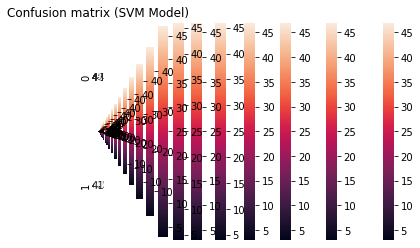

In [26]:
# Initialize variables to store results
shap_values_list = []
shap_dfs = []

# Number of iterations
n_iterations = 50

for i in range(n_iterations):
    # Step 2: Initial sampling
    
    majority_class = df[df['Outcome'] == 0]
    minority_class = df[df['Outcome'] == 1]

    # Define the number of samples to select
    n_samples = 50

    # Perform random sampling
    sampled_majority = majority_class.sample(n_samples, random_state=123)
    sampled_minority = minority_class.sample(n_samples, random_state=123)

    # Combine sampled data
    sampled_df = pd.concat([sampled_majority, sampled_minority])
    sampled_df

    #test
    y_test = sampled_df['Outcome']
    x_test = sampled_df.drop(columns='Outcome')

    # train
    # Separate remaining data for training
    remaining_df = df.drop(sampled_df.index)
    y_train = remaining_df['Outcome']
    x_train= remaining_df.drop(columns='Outcome')
    
    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train_ = scaler.transform(x_train)
    x_test_ = scaler.transform(x_test)
    
    #Modelling 
    # Creating and running our optimization

    study_svm = optuna.create_study(direction='maximize',study_name ="SVM")

    with parallel_backend('threading'):
        study_svm.optimize(objective_svm, n_trials=10, n_jobs=-1)
    # Evaluating our Optuna Trial
    print("Best trial:", study_svm.best_trial.number)
    print("Best accuracy:", study_svm.best_trial.value)
    print("Best hyperparameters:", study_svm.best_params)
    best_param_svm = study_svm.best_params
    SVM = SVC(**best_param_svm,random_state=rs).fit(x_train_,y_train)
    y_pred_svm = SVM.predict(x_test_)


    display_results(y_test, y_pred_svm, cm_title = "Confusion matrix (SVM Model)")

    
    
    # SHAP value computation using parallel processing
    num_cores = -1  # Use all available cores
    shap_values = compute_shap_values(SVM, x_test_, num_cores)


    # Extract SHAP values
    shap_values_array = abs(shap_values)

    # Store the SHAP values for stability analysis
    shap_values_list.append(shap_values_array)

    # Create DataFrame with SHAP values
    shap_values_df = pd.DataFrame(shap_values_array, columns=x_test.columns)
    shap_values_df['Outcome'] = y_test.values

    # Append DataFrame to the list
    shap_dfs.append(shap_values_df)

    print(shap_values_df)

# Concatenate all SHAP DataFrames row-wise
all_shap_values_df = pd.concat(shap_dfs, ignore_index=True)

# Print the combined DataFrame
print(all_shap_values_df)



In [27]:
all_shap_values_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,0.028286,0.175381,0.000143,0.003167,0.069286,0.039976,0.020786,0.021167,0
1,0.047345,0.152512,0.004393,0.056155,0.113893,0.002060,0.026202,0.032655,0
2,0.028143,0.111167,0.065381,0.025476,0.138476,0.029405,0.020619,0.001095,0
3,0.026500,0.145476,0.025071,0.034857,0.114024,0.031167,0.007857,0.010476,0
4,0.002905,0.109881,0.026238,0.002810,0.136833,0.020357,0.005357,0.017048,0
...,...,...,...,...,...,...,...,...,...
4995,0.274690,0.038333,0.083333,0.097429,0.034429,0.081619,0.020143,0.039167,1
4996,0.062702,0.450440,0.079012,0.045655,0.024869,0.081036,0.001202,0.120607,1
4997,0.016893,0.634679,0.003750,0.099583,0.091536,0.028607,0.009631,0.106250,1
4998,0.029476,0.015619,0.011238,0.047929,0.426476,0.006262,0.016619,0.121048,1


In [28]:
# Create an valuestability DataFrame
valuestability = pd.DataFrame()

def calc_val(col_name, df, row_id):
    # Calculate the sum and mean
    summ = 0
    for i in range(n_iterations):
        summ += df[col_name].iloc[row_id]
        
        row_id += n_samples*2
        

    mean = summ / n_iterations
    row_id -= n_iterations*n_samples*2
    

    # Calculate the variance
    diff = 0
    for i in range(n_iterations):
        diff += (df[col_name].iloc[row_id] - mean) ** 2
        row_id += n_samples*2

    numerator = (diff / (n_iterations - 1)) ** 0.5
    denominator = mean

    final = numerator / denominator

    return final

def add_to_df():
    arr =[]
    col = x_test.columns
    for c in col:
        print(c)
        for i in range(n_samples*2):
            arr.append(calc_val(c,all_shap_values_df, i))
 
        
        valuestability[c] = arr
        arr =[]
        



In [29]:
# Call the add_to_df function to populate valuestability
add_to_df()
valuestability

cv = valuestability.sum(axis=1) / valuestability.shape[1]
valuestability['CV'] = cv

# Save the DataFrame to an Excel file
valuestability.to_excel('30_svm_valuestability.xlsx', index=False)
valuestability

Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DPF
Age


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,CV
0,0.328491,0.093633,0.955071,0.562558,0.282866,0.642169,0.534638,0.448136,0.480945
1,0.702520,0.107266,0.944079,0.738906,0.066786,0.678551,0.438724,0.385448,0.507785
2,0.611443,0.234651,1.100199,0.189900,0.364916,0.596544,0.450520,0.750182,0.537294
3,0.302026,0.134563,0.929234,0.351014,0.285274,0.790327,0.567750,0.683674,0.505483
4,0.911562,0.343371,1.129467,0.492778,0.289754,0.616269,0.353566,0.544574,0.585168
...,...,...,...,...,...,...,...,...,...
95,0.574481,0.795242,0.870263,0.609209,0.910937,0.653494,0.655684,0.629967,0.712410
96,0.576003,0.738043,1.783449,0.298091,0.343496,0.445764,0.730937,1.707550,0.827917
97,0.707405,0.291671,1.512170,0.400089,0.702963,0.282247,0.927013,0.362424,0.648248
98,0.502033,0.805896,0.552564,0.146581,0.223089,0.807021,0.675800,0.651836,0.545603


## Xgboost

In [30]:
df = pd.read_csv("data_resampled_50.csv")
#from sklearn.model_selection import RepeatedKFold
rs=123

cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=rs)

def display_results(y_test, y_pred, cm_title):
        cm = confusion_matrix(y_test,y_pred)
        sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
        print(classification_report(y_test,y_pred))



In [31]:
import xgboost as xgb
import optuna
from sklearn.model_selection import cross_val_score

def objective_xgb(trial: optuna.Trial):
    # Assume the data is already split into x_train_ and y_train_
    n_minority = y_train.sum()  # Number of minority class instances (assume minority class is '1')
    n_majority = len(y_train) - n_minority  # Number of majority class instances (assume majority class is '0')
    
    # Calculate scale_pos_weight
    scale_pos_weight = n_majority / n_minority
    
    # Define hyperparameters
    param_xgb = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': 0.1,  # Fixed at 0.1 as per your instructions
        'n_estimators': 200,  # Fixed at 200
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1e1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1e1),
        'scale_pos_weight': scale_pos_weight  # Calculated to handle class imbalance
    }

    # Create and evaluate the XGBoost model
    xgb_model = xgb.XGBClassifier(**param_xgb, use_label_encoder=False, eval_metric='logloss', random_state=123)
    score = cross_val_score(xgb_model, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

# Example usage:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective_xgb, n_trials=100)


[I 2024-08-26 16:17:19,977] A new study created in memory with name: XGBoost
[I 2024-08-26 16:17:26,275] Trial 1 finished with value: 0.8714820483874071 and parameters: {'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.5546336554483362, 'colsample_bytree': 0.7617291175001504, 'reg_alpha': 0.17988166075448409, 'reg_lambda': 0.10430921575622099}. Best is trial 1 with value: 0.8714820483874071.
[I 2024-08-26 16:17:27,534] Trial 5 finished with value: 0.8769645078189909 and parameters: {'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.6720768016250067, 'colsample_bytree': 0.7281446997558448, 'reg_alpha': 0.002907232810733149, 'reg_lambda': 2.7791136275994806}. Best is trial 5 with value: 0.8769645078189909.
[I 2024-08-26 16:17:27,804] Trial 0 finished with value: 0.8809307808942844 and parameters: {'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.8453758590006083, 'colsample_bytree': 0.7743437481782623, 'reg_alpha': 0.1679848363470146, 'reg_lambda': 0.0005342067614764749}. B

Best trial: 4
Best accuracy: 0.8848711877990617
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.5654185608224238, 'colsample_bytree': 0.8832487578578918, 'reg_alpha': 0.001231250241762199, 'reg_lambda': 0.0049842079349404446}
              precision    recall  f1-score   support

           0       0.84      0.92      0.88        50
           1       0.91      0.82      0.86        50

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



[I 2024-08-26 16:17:35,136] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      1.086306  1.433432       0.404042       0.550558  0.302288  0.206401   
1      0.511095  1.360483       0.688511       0.458477  5.325174  0.381437   
2      0.091877  1.789352       0.211248       0.615891  2.344040  0.848147   
3      0.720990  0.799693       0.158634       0.696040  5.886885  0.066776   
4      0.801089  2.467938       0.125730       0.839718  1.764348  0.737942   
..          ...       ...            ...            ...       ...       ...   
95     0.052452  0.060142       0.980861       0.446586  0.064312  0.410693   
96     0.129743  3.153677       0.554259       0.031090  2.834925  1.885527   
97     0.244335  3.859555       0.064755       1.209885  2.690405  0.219311   
98     0.752122  0.126791       0.196500       0.320936  5.961018  0.421235   
99     0.348185  3.132150       0.174163       0.549091  0.093383  0.502923   

         DPF       Age  Outcome  
0   0.880635  0.0

[I 2024-08-26 16:17:41,337] Trial 1 finished with value: 0.8707672797557693 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.5127141385414695, 'colsample_bytree': 0.6328177415645595, 'reg_alpha': 0.00026416528450755983, 'reg_lambda': 0.18955212714725334}. Best is trial 1 with value: 0.8707672797557693.
[I 2024-08-26 16:17:41,987] Trial 0 finished with value: 0.8783083644038372 and parameters: {'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.7937962046593647, 'colsample_bytree': 0.642204659707519, 'reg_alpha': 0.01941754428703458, 'reg_lambda': 0.016357304953007853}. Best is trial 0 with value: 0.8783083644038372.
[I 2024-08-26 16:17:42,509] Trial 5 finished with value: 0.8758915479475315 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.8521435548084464, 'colsample_bytree': 0.5676542926252998, 'reg_alpha': 1.1393432535545955, 'reg_lambda': 9.016565184535286e-05}. Best is trial 0 with value: 0.8783083644038372.
[I 2024-08-26 16:17:43,97

Best trial: 8
Best accuracy: 0.8837602173187714
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.9310002918668939, 'colsample_bytree': 0.5795492213116438, 'reg_alpha': 0.003600507578040033, 'reg_lambda': 0.035160765066547466}
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.155237  0.881719       0.207908       0.564580  0.258155  0.683337   
1      0.025942  0.823095       0.193771       0.202319  3.128990  1.090351   
2      0.170880  0.980564       0.234790       0.406203  0.955059  0.694075   
3      0.243585  0.554825       0.168850       0.273357  3.478610  0.408811   
4      0.037917  1.47672

[I 2024-08-26 16:17:56,089] Trial 1 finished with value: 0.8736026846105857 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.5250563657137768, 'colsample_bytree': 0.9321266271186243, 'reg_alpha': 1.6536796983363645e-05, 'reg_lambda': 1.4618733127403945e-05}. Best is trial 1 with value: 0.8736026846105857.
[I 2024-08-26 16:17:56,837] Trial 3 finished with value: 0.8725686138247895 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.8250816069751175, 'colsample_bytree': 0.6043538952103957, 'reg_alpha': 0.10705179552161936, 'reg_lambda': 0.7328581839779141}. Best is trial 1 with value: 0.8736026846105857.
[I 2024-08-26 16:17:57,194] Trial 2 finished with value: 0.8806413448406009 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.9110760887749323, 'colsample_bytree': 0.9393135598874187, 'reg_alpha': 0.5894543800506994, 'reg_lambda': 0.00014001740825780943}. Best is trial 2 with value: 0.8806413448406009.
[I 2024-08-26 16:17:57

Best trial: 0
Best accuracy: 0.8873259519516122
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.9985563742449838, 'colsample_bytree': 0.7719194245381757, 'reg_alpha': 0.4313719987119058, 'reg_lambda': 6.306781883789354e-05}
              precision    recall  f1-score   support

           0       0.83      0.88      0.85        50
           1       0.87      0.82      0.85        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.149722  0.758137       0.079665       0.193331  0.444128  0.211191   
1      0.252941  0.848633       0.000196       0.348628  2.928421  0.772864   
2      0.280446  1.032113       0.292884       0.181887  0.960068  0.472049   
3      0.248953  0.711131       0.290891       0.376324  3.151844  0.363096   
4      0.011220  1.11986

[I 2024-08-26 16:18:11,618] Trial 1 finished with value: 0.8702746959856331 and parameters: {'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.5465768942089154, 'colsample_bytree': 0.7079331262587767, 'reg_alpha': 5.619474085226716e-05, 'reg_lambda': 0.08363845846894061}. Best is trial 1 with value: 0.8702746959856331.
[I 2024-08-26 16:18:12,139] Trial 4 finished with value: 0.8790710187780924 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.755578349372224, 'colsample_bytree': 0.8160695299884948, 'reg_alpha': 0.004449116789930876, 'reg_lambda': 0.0011330430926711657}. Best is trial 4 with value: 0.8790710187780924.
[I 2024-08-26 16:18:12,178] Trial 2 finished with value: 0.8786386542194679 and parameters: {'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.7476057915207318, 'colsample_bytree': 0.9172723803196894, 'reg_alpha': 0.17905859928403794, 'reg_lambda': 0.8266094026628948}. Best is trial 4 with value: 0.8790710187780924.
[I 2024-08-26 16:18:12,409]

Best trial: 9
Best accuracy: 0.8914529927603628
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.8106722361028582, 'colsample_bytree': 0.9727520948555487, 'reg_alpha': 0.08454066224143883, 'reg_lambda': 2.414994382508769e-05}
              precision    recall  f1-score   support

           0       0.81      0.88      0.85        50
           1       0.87      0.80      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.376821  1.436232       0.005777       0.503841  0.271309  0.236171   
1      0.038324  1.168694       0.352136       0.016997  4.512707  0.443504   
2      0.258827  1.215336       0.145932       0.593679  2.230788  0.463980   
3      0.197928  0.652362       0.085373       0.754157  4.864179  0.592613   
4      0.108169  1.8285

[I 2024-08-26 16:18:26,431] Trial 2 finished with value: 0.8720604929323502 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.5155128994522439, 'colsample_bytree': 0.5065501505018382, 'reg_alpha': 7.821565930301206e-05, 'reg_lambda': 1.6284373746914597e-05}. Best is trial 2 with value: 0.8720604929323502.
[I 2024-08-26 16:18:26,820] Trial 3 finished with value: 0.8773762347222607 and parameters: {'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.7373980133937167, 'colsample_bytree': 0.8558803133832308, 'reg_alpha': 0.028953958376456944, 'reg_lambda': 2.2319389693577967}. Best is trial 3 with value: 0.8773762347222607.
[I 2024-08-26 16:18:27,749] Trial 1 finished with value: 0.8831200507931658 and parameters: {'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.9312334057515228, 'colsample_bytree': 0.9536496200817515, 'reg_alpha': 2.6067422614975062e-05, 'reg_lambda': 2.101436742908816}. Best is trial 1 with value: 0.8831200507931658.
[I 2024-08-26 16:18:28,75

Best trial: 7
Best accuracy: 0.8889518652862348
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.9204879718194564, 'colsample_bytree': 0.6766884280416487, 'reg_alpha': 2.8629375893898863, 'reg_lambda': 0.9821995342260919}
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021396  0.796358       0.006926       0.320154  0.193944  0.577333   
1      0.151923  0.910790       0.015364       0.302093  2.736957  0.493660   
2      0.183976  0.939365       0.093051       0.218863  0.698021  0.409685   
3      0.044665  0.794508       0.082323       0.227852  2.906083  0.582269   
4      0.085678  1.044534   

[I 2024-08-26 16:18:41,425] Trial 1 finished with value: 0.8745682179263004 and parameters: {'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.5863635918815706, 'colsample_bytree': 0.7867241581175013, 'reg_alpha': 0.0013178290306219862, 'reg_lambda': 0.0002449834369280405}. Best is trial 1 with value: 0.8745682179263004.
[I 2024-08-26 16:18:41,614] Trial 3 finished with value: 0.8717917582420288 and parameters: {'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.5008662215293449, 'colsample_bytree': 0.575234345744118, 'reg_alpha': 0.12148817243612525, 'reg_lambda': 2.6264483925564732e-05}. Best is trial 1 with value: 0.8745682179263004.
[I 2024-08-26 16:18:41,646] Trial 2 finished with value: 0.8793605179094086 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.7837354209174857, 'colsample_bytree': 0.8432804616743644, 'reg_alpha': 0.1036373468850384, 'reg_lambda': 8.927695036256656}. Best is trial 2 with value: 0.8793605179094086.
[I 2024-08-26 16:18:42,418]

Best trial: 0
Best accuracy: 0.8914386788243382
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.98563082313453, 'colsample_bytree': 0.7899375555538132, 'reg_alpha': 0.22254354290396752, 'reg_lambda': 0.04216528986316692}
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.553363  1.011287       0.055347       0.842880  0.203640  0.386772   
1      0.146245  0.903144       0.125609       0.290848  3.863665  1.123738   
2      0.306856  0.977805       0.313534       0.400511  1.083831  1.105238   
3      0.048112  0.532073       0.208097       0.575563  4.352317  0.493315   
4      0.072162  1.544364   

[I 2024-08-26 16:18:56,399] Trial 1 finished with value: 0.8826812277200452 and parameters: {'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.9727024845921622, 'colsample_bytree': 0.8920562029516705, 'reg_alpha': 3.185759313661435e-05, 'reg_lambda': 4.784981148000793e-05}. Best is trial 1 with value: 0.8826812277200452.
[I 2024-08-26 16:18:56,850] Trial 5 finished with value: 0.885516835249155 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.981085066586035, 'colsample_bytree': 0.8997009646336223, 'reg_alpha': 0.002087707938144803, 'reg_lambda': 1.5708464510598446e-05}. Best is trial 5 with value: 0.885516835249155.
[I 2024-08-26 16:18:57,043] Trial 3 finished with value: 0.8842132393812708 and parameters: {'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.6796808663476378, 'colsample_bytree': 0.8257069439255675, 'reg_alpha': 0.7769189523384039, 'reg_lambda': 1.3350949485901147e-05}. Best is trial 5 with value: 0.885516835249155.
[I 2024-08-26 16:18:57,77

Best trial: 5
Best accuracy: 0.885516835249155
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.981085066586035, 'colsample_bytree': 0.8997009646336223, 'reg_alpha': 0.002087707938144803, 'reg_lambda': 1.5708464510598446e-05}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.121549  0.999061       0.018380       0.487748  0.210917  0.127821   
1      0.147115  0.868033       0.103493       0.464605  3.423727  0.810502   
2      0.237780  1.155882       0.247745       0.435683  0.803267  0.869578   
3      0.044024  0.587721       0.238337       0.563273  3.546666  0.166305   
4      0.132666  1.33714

[I 2024-08-26 16:19:10,419] Trial 4 finished with value: 0.8799178449970654 and parameters: {'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.9845075201269865, 'colsample_bytree': 0.6702015367279541, 'reg_alpha': 8.124606081927292, 'reg_lambda': 0.01600064916151897}. Best is trial 4 with value: 0.8799178449970654.
[I 2024-08-26 16:19:11,357] Trial 0 finished with value: 0.8735447295426519 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.5274066732637112, 'colsample_bytree': 0.8950227615072004, 'reg_alpha': 0.00038481494037016274, 'reg_lambda': 0.1712016652326279}. Best is trial 4 with value: 0.8799178449970654.
[I 2024-08-26 16:19:13,576] Trial 2 finished with value: 0.8731417213960999 and parameters: {'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.5340857513709669, 'colsample_bytree': 0.8764050538900687, 'reg_alpha': 0.024298211971920305, 'reg_lambda': 6.825521476571289}. Best is trial 4 with value: 0.8799178449970654.
[I 2024-08-26 16:19:13,935] Tria

Best trial: 5
Best accuracy: 0.8887007205717218
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.9524024120410326, 'colsample_bytree': 0.8101141165357448, 'reg_alpha': 0.004134028369423312, 'reg_lambda': 0.003368474125215038}
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.651551  1.161944       0.085367       0.966221  0.064845  0.663526   
1      0.003937  0.882827       0.127555       0.271854  3.908175  1.326195   
2      0.133969  1.218537       0.275451       0.296003  2.380335  0.988104   
3      0.162315  0.363790       0.125536       0.672589  4.585840  0.813495   
4      0.213395  2.40292

[I 2024-08-26 16:19:20,074] A new study created in memory with name: XGBoost
[I 2024-08-26 16:19:26,537] Trial 4 finished with value: 0.8721097523308662 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.5482129716187502, 'colsample_bytree': 0.5796543967018175, 'reg_alpha': 0.03336565177071502, 'reg_lambda': 0.20206582283985106}. Best is trial 4 with value: 0.8721097523308662.
[I 2024-08-26 16:19:27,041] Trial 2 finished with value: 0.8699126836357614 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.6070589122421421, 'colsample_bytree': 0.6853215202293832, 'reg_alpha': 0.13437642677308384, 'reg_lambda': 0.2607437067064157}. Best is trial 4 with value: 0.8721097523308662.
[I 2024-08-26 16:19:27,762] Trial 1 finished with value: 0.879852411998828 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.8864497924710268, 'colsample_bytree': 0.8300908323987168, 'reg_alpha': 1.0883558178794729e-05, 'reg_lambda': 0.07086964965266825}. 

Best trial: 3
Best accuracy: 0.8834810081606806
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.9844891502875054, 'colsample_bytree': 0.7051879792698748, 'reg_alpha': 0.00012511141388022807, 'reg_lambda': 3.0169728576554906}
              precision    recall  f1-score   support

           0       0.83      0.90      0.87        50
           1       0.89      0.82      0.85        50

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.012051  0.627500       0.026157       0.412194  0.139214  0.165381   
1      0.254229  0.799176       0.057522       0.278413  3.039923  0.854036   
2      0.299469  0.909299       0.228335       0.250237  0.710745  0.450850   
3      0.139803  0.765367       0.337428       0.334272  3.140598  0.178355   
4      0.107229  1.0660

[I 2024-08-26 16:19:33,684] A new study created in memory with name: XGBoost
[I 2024-08-26 16:19:40,743] Trial 2 finished with value: 0.8750425637869321 and parameters: {'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.6045333815864558, 'colsample_bytree': 0.8297964152717024, 'reg_alpha': 0.09353429130415807, 'reg_lambda': 1.261882886701167}. Best is trial 2 with value: 0.8750425637869321.
[I 2024-08-26 16:19:42,065] Trial 1 finished with value: 0.8797049200666636 and parameters: {'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.6959985981568786, 'colsample_bytree': 0.6443330678848529, 'reg_alpha': 0.4972422475596337, 'reg_lambda': 0.0006634426390919223}. Best is trial 1 with value: 0.8797049200666636.
[I 2024-08-26 16:19:43,375] Trial 0 finished with value: 0.8845874589577442 and parameters: {'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.9170626976923336, 'colsample_bytree': 0.7460556487370957, 'reg_alpha': 0.000807420345011598, 'reg_lambda': 4.195508838319178}. Best

Best trial: 4
Best accuracy: 0.8915293513438433
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.8529704268693292, 'colsample_bytree': 0.8876817381514921, 'reg_alpha': 0.770924745830368, 'reg_lambda': 2.924730636004996}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.075295  0.818619       0.089170       0.639489  0.146979  0.386910   
1      0.045362  0.572130       0.107843       0.261028  3.054156  0.713838   
2      0.220499  0.986557       0.091316       0.359858  1.438056  0.655399   
3      0.080926  0.381942       0.022026       0.592134  3.424063  0.181935   
4      0.214122  1.507011     

[I 2024-08-26 16:19:56,975] Trial 0 finished with value: 0.8780952132760348 and parameters: {'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.5027759847853784, 'colsample_bytree': 0.627600755062352, 'reg_alpha': 1.459342608038879, 'reg_lambda': 2.3479591477096102e-05}. Best is trial 0 with value: 0.8780952132760348.
[I 2024-08-26 16:19:58,212] Trial 3 finished with value: 0.879741047280326 and parameters: {'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.779736974654597, 'colsample_bytree': 0.6868879669134302, 'reg_alpha': 0.05671669689093656, 'reg_lambda': 0.03342375092057851}. Best is trial 3 with value: 0.879741047280326.
[I 2024-08-26 16:19:58,272] Trial 1 finished with value: 0.8886377952601151 and parameters: {'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.9070530461888904, 'colsample_bytree': 0.8432683067643205, 'reg_alpha': 1.2578057986667608, 'reg_lambda': 2.686245484787742}. Best is trial 1 with value: 0.8886377952601151.
[I 2024-08-26 16:19:59,990] Trial 4 f

Best trial: 1
Best accuracy: 0.8886377952601151
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.9070530461888904, 'colsample_bytree': 0.8432683067643205, 'reg_alpha': 1.2578057986667608, 'reg_lambda': 2.686245484787742}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.092518  0.822728       0.130930       0.464334  0.595812  0.306388   
1      0.044688  0.702802       0.030454       0.104517  2.851279  0.637689   
2      0.107257  1.079645       0.239760       0.375604  1.290598  0.879523   
3      0.061447  0.463949       0.113029       0.688192  3.196696  0.516635   
4      0.135634  1.347420    

[I 2024-08-26 16:20:13,516] Trial 2 finished with value: 0.8820441972502208 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.983267322304925, 'colsample_bytree': 0.6514472083544598, 'reg_alpha': 0.10901107957976316, 'reg_lambda': 0.12845007698333266}. Best is trial 2 with value: 0.8820441972502208.
[I 2024-08-26 16:20:13,524] Trial 3 finished with value: 0.8760230855571277 and parameters: {'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.5523575074496323, 'colsample_bytree': 0.9942338140463252, 'reg_alpha': 0.1569685273609944, 'reg_lambda': 1.1083640946182844}. Best is trial 2 with value: 0.8820441972502208.
[I 2024-08-26 16:20:13,818] Trial 0 finished with value: 0.8834304516788047 and parameters: {'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.8935607662669889, 'colsample_bytree': 0.7920824893134951, 'reg_alpha': 0.5404424357104631, 'reg_lambda': 0.010901038725835898}. Best is trial 0 with value: 0.8834304516788047.
[I 2024-08-26 16:20:14,900] Trial 

Best trial: 7
Best accuracy: 0.8849924916134362
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.8066528688014936, 'colsample_bytree': 0.8334468975427511, 'reg_alpha': 0.00018607693817168812, 'reg_lambda': 0.03527502632853042}
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.414598  1.794327       0.374704       0.343264  0.137479  0.402680   
1      0.223454  1.470431       0.687787       0.431412  4.172981  0.833011   
2      0.167977  1.491509       0.230538       0.534055  2.359344  1.150086   
3      0.334345  1.075382       0.476041       0.760915  5.093621  0.874611   
4      0.212471  1.814

[I 2024-08-26 16:20:28,250] Trial 2 finished with value: 0.8802165902950552 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.9692249790029867, 'colsample_bytree': 0.9921593116430483, 'reg_alpha': 0.32276542668600927, 'reg_lambda': 0.0013169779637398976}. Best is trial 2 with value: 0.8802165902950552.
[I 2024-08-26 16:20:28,462] Trial 1 finished with value: 0.8789358322510316 and parameters: {'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.5057541053088632, 'colsample_bytree': 0.9525333267552532, 'reg_alpha': 0.12276595074010159, 'reg_lambda': 0.0067927025906580904}. Best is trial 2 with value: 0.8802165902950552.
[I 2024-08-26 16:20:28,967] Trial 5 finished with value: 0.876143684599438 and parameters: {'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.8313232674450027, 'colsample_bytree': 0.7269716661987193, 'reg_alpha': 0.0001219757163130398, 'reg_lambda': 0.0030219455967967187}. Best is trial 2 with value: 0.8802165902950552.
[I 2024-08-26 16:20:29

Best trial: 9
Best accuracy: 0.8862958006860857
Best hyperparameters: {'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.716086718875998, 'colsample_bytree': 0.7074258463996367, 'reg_alpha': 4.748594292541189e-05, 'reg_lambda': 0.15509568086343622}
              precision    recall  f1-score   support

           0       0.81      0.88      0.85        50
           1       0.87      0.80      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.556768  0.555318       0.312222       0.427464  0.249878  0.194179   
1      0.021551  0.114203       0.457016       0.074785  3.652554  0.651183   
2      0.064252  0.546948       0.427486       0.275039  1.787207  1.186717   
3      0.057246  0.250599       0.197977       0.231510  4.048863  0.632210   
4      0.520553  2.073207

[I 2024-08-26 16:20:43,272] Trial 4 finished with value: 0.8741160603390441 and parameters: {'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.5727701508748997, 'colsample_bytree': 0.899940261054625, 'reg_alpha': 0.019689328282056412, 'reg_lambda': 0.6218531263975754}. Best is trial 4 with value: 0.8741160603390441.
[I 2024-08-26 16:20:43,470] Trial 5 finished with value: 0.8764172595114611 and parameters: {'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.7052123628121569, 'colsample_bytree': 0.9215434700669054, 'reg_alpha': 0.4393676719004694, 'reg_lambda': 1.294600932505223e-05}. Best is trial 5 with value: 0.8764172595114611.
[I 2024-08-26 16:20:44,030] Trial 2 finished with value: 0.8832469801191968 and parameters: {'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.9481611851428, 'colsample_bytree': 0.9948843161591581, 'reg_alpha': 0.8707412568003045, 'reg_lambda': 6.772888736884321e-05}. Best is trial 2 with value: 0.8832469801191968.
[I 2024-08-26 16:20:44,555] Tria

Best trial: 0
Best accuracy: 0.8888406012590713
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.9914902444723244, 'colsample_bytree': 0.7809595275981984, 'reg_alpha': 3.709041465296055e-05, 'reg_lambda': 0.7956885287183717}
              precision    recall  f1-score   support

           0       0.82      0.94      0.88        50
           1       0.93      0.80      0.86        50

    accuracy                           0.87       100
   macro avg       0.88      0.87      0.87       100
weighted avg       0.88      0.87      0.87       100



[I 2024-08-26 16:20:51,884] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.227526  1.757173       0.084927       0.799026  0.184245  0.863831   
1      0.095898  0.828432       0.245908       0.399609  3.820173  1.024067   
2      0.197656  1.398336       0.276920       0.300397  2.654199  0.775637   
3      0.251261  0.343499       0.240770       0.625892  4.720154  0.908904   
4      0.086638  1.795200       0.539776       0.871572  1.816029  0.884455   
..          ...       ...            ...            ...       ...       ...   
95     0.438854  0.547772       0.748141       0.756430  0.244297  0.844390   
96     0.002035  3.886899       0.173518       0.570928  2.961609  2.103941   
97     0.193206  2.866869       0.146502       1.667598  1.142062  0.162632   
98     0.402920  0.421265       0.354902       0.070329  6.164716  0.334136   
99     0.216455  3.457340       0.123446       0.388950  0.175751  0.412385   

         DPF       Age  Outcome  
0   0.613253  0.7

[I 2024-08-26 16:20:58,571] Trial 4 finished with value: 0.8729556583232866 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.5243574718755268, 'colsample_bytree': 0.6296430489349136, 'reg_alpha': 7.343006144901833e-05, 'reg_lambda': 0.0200474478857094}. Best is trial 4 with value: 0.8729556583232866.
[I 2024-08-26 16:20:58,875] Trial 1 finished with value: 0.8765821584157365 and parameters: {'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.6867209400598666, 'colsample_bytree': 0.8534991017126417, 'reg_alpha': 2.7619327438843842e-05, 'reg_lambda': 0.5593708000739159}. Best is trial 1 with value: 0.8765821584157365.
[I 2024-08-26 16:20:58,964] Trial 2 finished with value: 0.8828728426332441 and parameters: {'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.8016052543402686, 'colsample_bytree': 0.6273694948140628, 'reg_alpha': 0.00030314732935016474, 'reg_lambda': 4.840400812130428}. Best is trial 2 with value: 0.8828728426332441.
[I 2024-08-26 16:21:00,467]

Best trial: 8
Best accuracy: 0.8881829007546268
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.9339871723146831, 'colsample_bytree': 0.9740918120656502, 'reg_alpha': 5.581616691215621, 'reg_lambda': 0.001036923726625218}
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        50
           1       0.91      0.84      0.87        50

    accuracy                           0.88       100
   macro avg       0.88      0.88      0.88       100
weighted avg       0.88      0.88      0.88       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.008598  0.695998       0.019947       0.156559  0.522159  0.373531   
1      0.037486  0.735449       0.094789       0.493312  1.995909  0.337204   
2      0.037486  0.884559       0.058119       0.453460  0.933627  0.324756   
3      0.008598  0.558425       0.019947       0.453460  2.257966  0.423725   
4      0.008598  0.790192 

[I 2024-08-26 16:21:14,450] Trial 3 finished with value: 0.8759851981548092 and parameters: {'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.5117851833735135, 'colsample_bytree': 0.7922349518235401, 'reg_alpha': 0.001912959290307422, 'reg_lambda': 0.0002053349704066252}. Best is trial 3 with value: 0.8759851981548092.
[I 2024-08-26 16:21:14,498] Trial 2 finished with value: 0.8770621323747712 and parameters: {'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.7222544796708272, 'colsample_bytree': 0.9567547066294726, 'reg_alpha': 0.0005802431542578052, 'reg_lambda': 1.1666412448364356}. Best is trial 2 with value: 0.8770621323747712.
[I 2024-08-26 16:21:14,558] Trial 5 finished with value: 0.8753428534035268 and parameters: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.6755794434882076, 'colsample_bytree': 0.8907287930416083, 'reg_alpha': 0.00035399484650216833, 'reg_lambda': 1.781615220972037e-05}. Best is trial 2 with value: 0.8770621323747712.
[I 2024-08-26 16:21:14

Best trial: 0
Best accuracy: 0.8842371514517043
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.8339828675862655, 'colsample_bytree': 0.9973004405695944, 'reg_alpha': 7.682128903633445e-05, 'reg_lambda': 7.398772498438384e-05}
              precision    recall  f1-score   support

           0       0.80      0.86      0.83        50
           1       0.85      0.78      0.81        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100



[I 2024-08-26 16:21:22,450] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.002223  1.000184       0.238012       0.183768  0.214455  0.241781   
1      0.177334  0.891539       0.092252       0.517523  3.187749  0.672371   
2      0.238490  1.299610       0.248034       0.308816  0.849930  0.196540   
3      0.148069  0.654617       0.278674       0.447364  3.589756  0.076948   
4      0.043141  1.284240       0.230669       0.232912  0.730201  0.535373   
..          ...       ...            ...            ...       ...       ...   
95     0.043276  0.901468       0.429082       0.478448  0.447878  0.688904   
96     0.059904  2.256923       0.375896       0.272451  1.660704  0.726710   
97     0.136126  1.976623       0.166092       0.267798  0.905586  0.166693   
98     0.043276  0.571975       0.348302       0.491696  3.588088  0.056033   
99     0.002223  1.544265       0.038914       0.386670  0.311873  0.167829   

         DPF       Age  Outcome  
0   0.511962  0.7

[I 2024-08-26 16:21:29,505] Trial 0 finished with value: 0.8827050773162946 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.978145190613036, 'colsample_bytree': 0.6210524806196902, 'reg_alpha': 0.02014989872004062, 'reg_lambda': 0.2455637178866102}. Best is trial 0 with value: 0.8827050773162946.
[I 2024-08-26 16:21:29,609] Trial 5 finished with value: 0.8835208523543224 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.932716036066414, 'colsample_bytree': 0.7325222095617897, 'reg_alpha': 0.08318212588764831, 'reg_lambda': 6.305143188915705}. Best is trial 5 with value: 0.8835208523543224.
[I 2024-08-26 16:21:29,788] Trial 4 finished with value: 0.8780581123897278 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.8648361723557939, 'colsample_bytree': 0.692089091173302, 'reg_alpha': 0.00027712784381885155, 'reg_lambda': 0.0006768774118617233}. Best is trial 5 with value: 0.8835208523543224.
[I 2024-08-26 16:21:30,816] Tri

Best trial: 3
Best accuracy: 0.8924719270795688
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.9578930185815377, 'colsample_bytree': 0.89485896393112, 'reg_alpha': 0.29804545307569336, 'reg_lambda': 0.20052271986384138}
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        50
           1       0.93      0.78      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100



[I 2024-08-26 16:21:38,159] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.145135  1.681995       0.068129       0.502045  0.106439  0.481601   
1      0.152912  0.972263       0.093055       0.497433  4.114373  0.728818   
2      0.016539  1.539636       0.344451       0.339274  2.026700  0.700520   
3      0.041635  0.395821       0.191385       0.647027  4.639239  0.811301   
4      0.193716  1.892210       0.337496       0.764458  1.652307  0.718489   
..          ...       ...            ...            ...       ...       ...   
95     0.255429  0.464381       0.555633       0.207738  0.474431  0.606395   
96     0.217821  4.087595       0.148739       0.313342  2.181009  1.261324   
97     0.170843  3.402224       0.025507       1.254096  1.924992  0.399682   
98     0.334252  0.428760       0.115527       0.103273  5.771582  0.064454   
99     0.176336  3.124712       0.053007       0.317010  0.385284  0.425842   

         DPF       Age  Outcome  
0   0.448725  1.0

[I 2024-08-26 16:21:44,691] Trial 2 finished with value: 0.8754929572174186 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.5098153462880184, 'colsample_bytree': 0.7941939695063243, 'reg_alpha': 1.8119405387966139, 'reg_lambda': 0.0021827931738087735}. Best is trial 2 with value: 0.8754929572174186.
[I 2024-08-26 16:21:45,598] Trial 1 finished with value: 0.8837052366570066 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.9814167224016586, 'colsample_bytree': 0.7779701856509562, 'reg_alpha': 1.7488036927597108e-05, 'reg_lambda': 0.005756555668287923}. Best is trial 1 with value: 0.8837052366570066.
[I 2024-08-26 16:21:46,632] Trial 3 finished with value: 0.8847407138994364 and parameters: {'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.8526574998364915, 'colsample_bytree': 0.8258200146501559, 'reg_alpha': 5.456974804416175, 'reg_lambda': 0.00011005612038187837}. Best is trial 3 with value: 0.8847407138994364.
[I 2024-08-26 16:21:47,0

Best trial: 5
Best accuracy: 0.8860007553416467
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.9077035323776188, 'colsample_bytree': 0.6979616826964989, 'reg_alpha': 4.125023229983066, 'reg_lambda': 0.009529151229609114}
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.102354  0.695619       0.046180       0.241477  0.292520  0.331237   
1      0.087161  0.640629       0.040316       0.280858  2.225061  0.301921   
2      0.017651  0.826792       0.151570       0.202236  1.106998  0.568788   
3      0.121921  0.507783       0.211594       0.368586  2.579813  0.353129   
4      0.117044  1.004054  

[I 2024-08-26 16:21:52,619] A new study created in memory with name: XGBoost
[I 2024-08-26 16:21:59,458] Trial 3 finished with value: 0.8719071022992374 and parameters: {'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.6709670374171597, 'colsample_bytree': 0.9084295853335462, 'reg_alpha': 0.0005480567673086884, 'reg_lambda': 8.351188170955778e-05}. Best is trial 3 with value: 0.8719071022992374.
[I 2024-08-26 16:21:59,940] Trial 2 finished with value: 0.8736097029246507 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.7156875893793411, 'colsample_bytree': 0.6918419038829753, 'reg_alpha': 0.008248050871019383, 'reg_lambda': 7.847377477058106}. Best is trial 2 with value: 0.8736097029246507.
[I 2024-08-26 16:22:00,267] Trial 1 finished with value: 0.8722754809524284 and parameters: {'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.6216814191619453, 'colsample_bytree': 0.5190182207601504, 'reg_alpha': 1.1509267333672832, 'reg_lambda': 1.0753137658723086}.

Best trial: 6
Best accuracy: 0.8886439788403835
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.8621854732115284, 'colsample_bytree': 0.926301592913322, 'reg_alpha': 0.5682045889252356, 'reg_lambda': 0.0011359924071854526}
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



[I 2024-08-26 16:22:07,587] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.309507  0.854147       0.102628       0.583399  0.466385  0.333143   
1      0.004260  0.996476       0.280986       0.385459  3.043442  0.309870   
2      0.174277  1.236182       0.381053       0.296972  2.436972  0.692671   
3      0.083414  0.342828       0.362712       0.664601  3.708803  0.585469   
4      0.278053  2.172676       0.357557       0.758770  1.481776  0.648475   
..          ...       ...            ...            ...       ...       ...   
95     0.132802  0.643611       0.656252       0.567167  0.119677  0.704186   
96     0.267961  3.013557       0.231033       0.823434  2.295610  1.185537   
97     0.124617  3.103052       0.135024       0.712879  1.142060  0.463950   
98     0.141094  0.343661       0.386769       0.426223  5.110177  0.020707   
99     0.283526  3.021307       0.341609       0.208664  0.241970  0.685174   

         DPF       Age  Outcome  
0   0.602854  0.1

[I 2024-08-26 16:22:14,692] Trial 5 finished with value: 0.8792669237994132 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.9213259792545117, 'colsample_bytree': 0.5655570758176345, 'reg_alpha': 0.020929588850674703, 'reg_lambda': 0.10214059959073546}. Best is trial 5 with value: 0.8792669237994132.
[I 2024-08-26 16:22:15,202] Trial 3 finished with value: 0.8729438022103484 and parameters: {'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.6610095440346426, 'colsample_bytree': 0.5991922334834648, 'reg_alpha': 0.016340296854841094, 'reg_lambda': 0.09116127692795989}. Best is trial 5 with value: 0.8792669237994132.
[I 2024-08-26 16:22:15,396] Trial 1 finished with value: 0.8805043846086525 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.7853643571995499, 'colsample_bytree': 0.7086672309907185, 'reg_alpha': 0.03232056926094427, 'reg_lambda': 6.519746302458884e-05}. Best is trial 1 with value: 0.8805043846086525.
[I 2024-08-26 16:22:16,307]

Best trial: 8
Best accuracy: 0.8847216641175676
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.6817354678120034, 'colsample_bytree': 0.6735984222207326, 'reg_alpha': 0.00011513009411179453, 'reg_lambda': 1.915732119707202}
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        50
           1       0.90      0.76      0.83        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



[I 2024-08-26 16:22:22,378] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.590479  0.514422       0.079869       0.614745  0.344506  0.289154   
1      0.318325  0.835417       0.145904       0.517439  3.491045  0.899369   
2      0.014225  0.741090       0.000241       0.645307  1.553982  0.968565   
3      0.292392  0.591112       0.046689       0.496357  3.828281  0.766848   
4      0.275294  1.711686       0.334460       0.833598  0.862712  0.694282   
..          ...       ...            ...            ...       ...       ...   
95     0.183246  0.149707       0.394014       0.550794  1.316434  0.350205   
96     0.103349  3.302301       0.257090       0.072434  2.075760  1.054742   
97     0.169180  2.615266       0.014459       0.375319  0.949689  0.090298   
98     0.083562  0.780485       0.028272       0.145304  5.102731  0.452417   
99     0.480526  2.704741       0.191479       0.709893  0.369853  0.161408   

         DPF       Age  Outcome  
0   0.980021  0.4

[I 2024-08-26 16:22:29,303] Trial 2 finished with value: 0.878554752382222 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.8317368583374182, 'colsample_bytree': 0.8271278572518883, 'reg_alpha': 0.00022334385454228048, 'reg_lambda': 0.002982968002432969}. Best is trial 2 with value: 0.878554752382222.
[I 2024-08-26 16:22:30,643] Trial 3 finished with value: 0.8736012501876433 and parameters: {'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.6223242481884025, 'colsample_bytree': 0.7699110429678369, 'reg_alpha': 0.00465437535005694, 'reg_lambda': 3.286756313190213e-05}. Best is trial 2 with value: 0.878554752382222.
[I 2024-08-26 16:22:30,728] Trial 0 finished with value: 0.8840024880079441 and parameters: {'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.9808962853308555, 'colsample_bytree': 0.7056701732275692, 'reg_alpha': 0.0028167045060451777, 'reg_lambda': 0.0003592282278200661}. Best is trial 0 with value: 0.8840024880079441.
[I 2024-08-26 16:22:31,

Best trial: 1
Best accuracy: 0.8865618602610091
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.9654760692397716, 'colsample_bytree': 0.5314487955819522, 'reg_alpha': 0.002363056106979677, 'reg_lambda': 0.0014828588940651248}


[I 2024-08-26 16:22:37,783] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.85      0.94      0.90        50
           1       0.93      0.84      0.88        50

    accuracy                           0.89       100
   macro avg       0.89      0.89      0.89       100
weighted avg       0.89      0.89      0.89       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.586855  1.672907       0.172803       0.769309  0.448768  0.611976   
1      0.194825  0.689883       0.235602       0.076974  3.771261  1.178070   
2      0.018098  1.113218       0.359014       0.520396  1.402839  0.619121   
3      0.276005  0.384405       0.276033       0.635793  4.161291  0.470420   
4      0.049633  2.295187       0.444235       0.786004  1.119518  0.421442   
..          ...       ...            ...            ...       ...       ...   
95     0.553383  0.449538       0.530439       0.585093  0.028590  1.019120   
96     0.209215  3.318170       0.365386 

[I 2024-08-26 16:22:44,715] Trial 1 finished with value: 0.8716914294047621 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.720863891910184, 'colsample_bytree': 0.5051042379260071, 'reg_alpha': 0.00012775519264131012, 'reg_lambda': 4.700814603761818}. Best is trial 1 with value: 0.8716914294047621.
[I 2024-08-26 16:22:45,130] Trial 2 finished with value: 0.8707804132492233 and parameters: {'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.6460496092429686, 'colsample_bytree': 0.772524287800056, 'reg_alpha': 0.183780844613041, 'reg_lambda': 0.00018369012462206706}. Best is trial 1 with value: 0.8716914294047621.
[I 2024-08-26 16:22:46,003] Trial 3 finished with value: 0.8788205373420283 and parameters: {'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.9175438477486562, 'colsample_bytree': 0.6096545865988708, 'reg_alpha': 0.0002393555845520282, 'reg_lambda': 0.0038091254295673843}. Best is trial 3 with value: 0.8788205373420283.
[I 2024-08-26 16:22:46,42

Best trial: 7
Best accuracy: 0.8887383373084695
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.9801697877215381, 'colsample_bytree': 0.7669189475323699, 'reg_alpha': 0.00026442362525401226, 'reg_lambda': 0.029048924044459117}
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100



[I 2024-08-26 16:22:52,638] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.176762  0.983396       0.139064       0.623830  0.135448  0.082608   
1      0.167039  0.980076       0.173449       0.302346  3.284090  1.096135   
2      0.329624  1.182664       0.107586       0.549175  1.046535  0.548989   
3      0.151286  0.639462       0.240755       0.596767  3.749979  0.003198   
4      0.269442  1.520370       0.350482       0.499559  0.840199  0.451543   
..          ...       ...            ...            ...       ...       ...   
95     0.025812  0.681681       0.571100       0.249720  0.382961  0.545595   
96     0.116826  2.351625       0.344499       0.217594  2.400378  1.110711   
97     0.138694  2.224839       0.097469       0.241668  1.337971  0.247901   
98     0.208109  0.343683       0.540363       0.137434  4.486777  0.294391   
99     0.049358  2.208323       0.042824       0.595896  0.717485  0.112288   

         DPF       Age  Outcome  
0   0.555980  0.4

[I 2024-08-26 16:22:59,935] Trial 1 finished with value: 0.882634756713251 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.9110571274652552, 'colsample_bytree': 0.6366393693229068, 'reg_alpha': 9.31553278329107e-05, 'reg_lambda': 1.3278794816024067}. Best is trial 1 with value: 0.882634756713251.
[I 2024-08-26 16:23:00,434] Trial 4 finished with value: 0.880152846717313 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.984057758140728, 'colsample_bytree': 0.6476790780908489, 'reg_alpha': 3.4749368531003114e-05, 'reg_lambda': 1.185256745674904e-05}. Best is trial 1 with value: 0.882634756713251.
[I 2024-08-26 16:23:00,678] Trial 0 finished with value: 0.8755971041778148 and parameters: {'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.6738805804213188, 'colsample_bytree': 0.8197110677444739, 'reg_alpha': 0.00042984040345501686, 'reg_lambda': 0.0017868559535343888}. Best is trial 1 with value: 0.882634756713251.
[I 2024-08-26 16:23:02,02

Best trial: 7
Best accuracy: 0.8909116231230939
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.9447724426391757, 'colsample_bytree': 0.6006486728956111, 'reg_alpha': 4.22717794937971, 'reg_lambda': 7.203057715517942e-05}


[I 2024-08-26 16:23:07,897] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.195936  0.710036       0.067085       0.171964  0.119839  0.282422   
1      0.029866  0.648202       0.064542       0.102398  2.156300  0.411866   
2      0.015785  0.776264       0.126926       0.116438  0.913275  0.365871   
3      0.192490  0.536146       0.093065       0.230823  2.319707  0.376592   
4      0.017673  1.128733       0.169544       0.270881  0.833728  0.327586   
..          ...       ...            ...            ...       ...       ...   
95     0.176627  0.359743       0.230212       0.564861  0.111703  0.276547   
96     0.088145  1.885666       0.025294 

[I 2024-08-26 16:23:14,059] Trial 5 finished with value: 0.8872555436503242 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.9637172969639756, 'colsample_bytree': 0.6558871542312947, 'reg_alpha': 5.470113462123764, 'reg_lambda': 0.12993644213350752}. Best is trial 5 with value: 0.8872555436503242.
[I 2024-08-26 16:23:15,354] Trial 0 finished with value: 0.8728707662310294 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.6018512538491603, 'colsample_bytree': 0.9611055901989537, 'reg_alpha': 8.035015492419603e-05, 'reg_lambda': 2.84198347969918e-05}. Best is trial 5 with value: 0.8872555436503242.
[I 2024-08-26 16:23:15,474] Trial 3 finished with value: 0.8735756554255399 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.5748114297265305, 'colsample_bytree': 0.7173245413601366, 'reg_alpha': 2.1137586613703865e-05, 'reg_lambda': 5.6256228953178646e-05}. Best is trial 5 with value: 0.8872555436503242.
[I 2024-08-26 16:23:15,8

Best trial: 1
Best accuracy: 0.8878022002084388
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.8576529329113243, 'colsample_bytree': 0.9088599489510808, 'reg_alpha': 3.507056714139786, 'reg_lambda': 0.18898780449825273}


[I 2024-08-26 16:23:21,901] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.79      0.90      0.84        50
           1       0.88      0.76      0.82        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.006198  0.919479       0.088423       0.250299  0.011935  0.401841   
1      0.001996  0.644046       0.055264       0.420235  2.192896  0.320003   
2      0.042833  1.121589       0.153671       0.304328  0.974939  0.545355   
3      0.088403  0.605558       0.087832       0.453461  2.558819  0.281246   
4      0.060834  1.303424       0.146690       0.287564  0.860174  0.465022   
..          ...       ...            ...            ...       ...       ...   
95     0.078864  0.486474       0.214361       0.439290  0.049101  0.395300   
96     0.033498  2.118006       0.020839 

[I 2024-08-26 16:23:28,665] Trial 4 finished with value: 0.8761250315223394 and parameters: {'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.5475563999493078, 'colsample_bytree': 0.8618831222012883, 'reg_alpha': 0.0037494014228787115, 'reg_lambda': 0.3631505570307286}. Best is trial 4 with value: 0.8761250315223394.
[I 2024-08-26 16:23:29,069] Trial 2 finished with value: 0.8802513768126794 and parameters: {'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.7392869373178953, 'colsample_bytree': 0.5433260392732906, 'reg_alpha': 0.00021574315445930308, 'reg_lambda': 0.0014189358942297053}. Best is trial 2 with value: 0.8802513768126794.
[I 2024-08-26 16:23:29,297] Trial 5 finished with value: 0.8762517889346347 and parameters: {'max_depth': 8, 'min_child_weight': 10, 'subsample': 0.7826173987138331, 'colsample_bytree': 0.9014423560751377, 'reg_alpha': 0.00016113174054598262, 'reg_lambda': 0.0018571209912402616}. Best is trial 2 with value: 0.8802513768126794.
[I 2024-08-26 16:23

Best trial: 1
Best accuracy: 0.8885444826736343
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.9378119431444034, 'colsample_bytree': 0.97720671652976, 'reg_alpha': 0.002693119641966358, 'reg_lambda': 4.162616607476824}


[I 2024-08-26 16:23:36,739] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.061847  0.994260       0.006928       0.446434  0.196755  0.312320   
1      0.018781  0.994940       0.161343       0.483329  3.111713  0.588591   
2      0.083155  1.055293       0.244558       0.309648  0.975349  0.533690   
3      0.014994  0.733127       0.209169       0.285540  3.406852  0.444396   
4      0.148641  1.382252       0.286525       0.449781  0.788405  0.585455   
..          ...       ...            ...            ...       ...       ...   
95     0.030026  0.712190       0.533757       0.258236  0.640632  0.624103   
96     0.019173  2.492266       0.323604 

[I 2024-08-26 16:23:43,517] Trial 0 finished with value: 0.8794249825354042 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.9367698469805148, 'colsample_bytree': 0.7973520670105415, 'reg_alpha': 0.0008414567416913459, 'reg_lambda': 5.950881818397475e-05}. Best is trial 0 with value: 0.8794249825354042.
[I 2024-08-26 16:23:44,180] Trial 2 finished with value: 0.8724097345302152 and parameters: {'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.5349074992632135, 'colsample_bytree': 0.76692191611028, 'reg_alpha': 0.1397046706578131, 'reg_lambda': 0.00028279191126419345}. Best is trial 0 with value: 0.8794249825354042.
[I 2024-08-26 16:23:44,753] Trial 3 finished with value: 0.8848324232833705 and parameters: {'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.9194008284883641, 'colsample_bytree': 0.702810180144661, 'reg_alpha': 4.117291718538192e-05, 'reg_lambda': 0.00011547583477384997}. Best is trial 3 with value: 0.8848324232833705.
[I 2024-08-26 16:23:46

Best trial: 4
Best accuracy: 0.887997069567015
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.8868229053798379, 'colsample_bytree': 0.9474623951280493, 'reg_alpha': 1.5754219154646139, 'reg_lambda': 0.00034362662920847697}


[I 2024-08-26 16:23:51,440] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.069262  0.833959       0.064408       0.282200  0.219308  0.381316   
1      0.109658  0.790795       0.177165       0.233066  3.209623  0.576221   
2      0.129642  1.165473       0.165503       0.298640  0.972171  1.073207   
3      0.095824  0.446669       0.039547       0.635173  3.458339  0.169404   
4      0.167085  1.587585       0.253032       0.508856  1.055943  0.441494   
..          ...       ...            ...            ...       ...       ...   
95     0.568773  0.251948       0.512100       0.369436  0.113272  0.572531   
96     0.103439  2.690228       0.245292 

[I 2024-08-26 16:23:57,968] Trial 4 finished with value: 0.8710345231472314 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.5030194901513425, 'colsample_bytree': 0.945107354225013, 'reg_alpha': 0.015416623292456097, 'reg_lambda': 7.228911115008417e-05}. Best is trial 4 with value: 0.8710345231472314.
[I 2024-08-26 16:23:58,981] Trial 0 finished with value: 0.8837596895933391 and parameters: {'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.9562505386290248, 'colsample_bytree': 0.9675791055608567, 'reg_alpha': 0.012025566928514052, 'reg_lambda': 3.6612611768176526}. Best is trial 0 with value: 0.8837596895933391.
[I 2024-08-26 16:23:59,202] Trial 2 finished with value: 0.876292554926355 and parameters: {'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.6333424807754153, 'colsample_bytree': 0.5685720011883473, 'reg_alpha': 0.06567595329203996, 'reg_lambda': 0.00020117948502228414}. Best is trial 0 with value: 0.8837596895933391.
[I 2024-08-26 16:23:59,40

Best trial: 1
Best accuracy: 0.8883575553422726
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.753550870946929, 'colsample_bytree': 0.6852525395176737, 'reg_alpha': 0.10934420996892777, 'reg_lambda': 0.6125777232742725}


[I 2024-08-26 16:24:06,471] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.83      0.90      0.87        50
           1       0.89      0.82      0.85        50

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.531200  0.874302       0.147272       0.688126  0.497304  0.501689   
1      0.078316  0.951048       0.665035       0.004745  4.104305  1.136952   
2      0.042149  0.921627       0.238280       0.479453  2.055560  1.069105   
3      0.023617  0.439132       0.500415       0.549741  4.411050  1.056506   
4      0.229690  2.214506       0.076803       0.966959  1.705372  1.094362   
..          ...       ...            ...            ...       ...       ...   
95     0.566777  0.544658       0.116012       0.277483  0.491502  0.352771   
96     0.155209  3.002425       0.056553 

[I 2024-08-26 16:24:13,119] Trial 1 finished with value: 0.8732443484127123 and parameters: {'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.5449075609621369, 'colsample_bytree': 0.6097105523003783, 'reg_alpha': 0.0016578091339765131, 'reg_lambda': 0.20093554436003155}. Best is trial 1 with value: 0.8732443484127123.
[I 2024-08-26 16:24:14,390] Trial 2 finished with value: 0.8831396760925575 and parameters: {'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.9641326662830932, 'colsample_bytree': 0.739852280204669, 'reg_alpha': 0.3961032102282395, 'reg_lambda': 1.7059689883285712e-05}. Best is trial 2 with value: 0.8831396760925575.
[I 2024-08-26 16:24:14,857] Trial 0 finished with value: 0.8904095030402617 and parameters: {'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.9242256313603399, 'colsample_bytree': 0.9948713057918186, 'reg_alpha': 0.9048296961351999, 'reg_lambda': 2.3323814436234084e-05}. Best is trial 0 with value: 0.8904095030402617.
[I 2024-08-26 16:24:15,008

Best trial: 0
Best accuracy: 0.8904095030402617
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.9242256313603399, 'colsample_bytree': 0.9948713057918186, 'reg_alpha': 0.9048296961351999, 'reg_lambda': 2.3323814436234084e-05}


[I 2024-08-26 16:24:20,937] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.338144  1.056990       0.012620       0.437405  0.270064  0.329317   
1      0.046683  0.899198       0.236986       0.078966  3.496040  0.866223   
2      0.247355  0.948545       0.017044       0.309391  1.575213  0.977328   
3      0.095230  0.506905       0.148722       0.347470  3.891406  0.411603   
4      0.170663  1.790496       0.246963       0.458234  0.902645  0.458118   
..          ...       ...            ...            ...       ...       ...   
95     0.295610  0.871716       0.746420       0.469577  0.199943  0.690495   
96     0.166244  3.040832       0.260360 

[I 2024-08-26 16:24:27,944] Trial 1 finished with value: 0.8719212704798218 and parameters: {'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.5404291283209656, 'colsample_bytree': 0.7262774338883884, 'reg_alpha': 0.4570093622648586, 'reg_lambda': 2.0855733822101263}. Best is trial 1 with value: 0.8719212704798218.
[I 2024-08-26 16:24:28,234] Trial 0 finished with value: 0.8732043065415798 and parameters: {'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.557288916416282, 'colsample_bytree': 0.5255289344749874, 'reg_alpha': 0.00038954833502574015, 'reg_lambda': 0.10313149523530867}. Best is trial 0 with value: 0.8732043065415798.
[I 2024-08-26 16:24:28,589] Trial 2 finished with value: 0.8826651676229499 and parameters: {'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.9280435935069786, 'colsample_bytree': 0.6576586481898732, 'reg_alpha': 0.00020330167359109785, 'reg_lambda': 0.07401313039620348}. Best is trial 2 with value: 0.8826651676229499.
[I 2024-08-26 16:24:29,191] 

Best trial: 3
Best accuracy: 0.8830570090571095
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.7880299769077476, 'colsample_bytree': 0.5169501132421961, 'reg_alpha': 0.00046184655219816574, 'reg_lambda': 0.009810597442055913}


[I 2024-08-26 16:24:34,604] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.83      0.86      0.84        50
           1       0.85      0.82      0.84        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.468131  1.009840       0.043568       0.552434  0.080320  0.797777   
1      0.292779  0.759847       0.329958       0.137601  3.253251  0.983738   
2      0.290709  0.967787       0.101956       0.447116  1.171244  1.428266   
3      0.190004  0.690309       0.310392       0.877773  3.562263  1.049194   
4      0.132249  1.894619       0.464139       0.788775  1.164754  0.867936   
..          ...       ...            ...            ...       ...       ...   
95     0.639536  0.557061       0.628288       0.788887  0.370884  0.628205   
96     0.078761  3.059294       0.308747 

[I 2024-08-26 16:24:40,972] Trial 3 finished with value: 0.8793301180204256 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.8315578456951873, 'colsample_bytree': 0.5068886984789314, 'reg_alpha': 8.319632823340005, 'reg_lambda': 1.0573055055526947e-05}. Best is trial 3 with value: 0.8793301180204256.
[I 2024-08-26 16:24:43,053] Trial 4 finished with value: 0.8815080810590098 and parameters: {'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.8974475475860503, 'colsample_bytree': 0.7885867668302886, 'reg_alpha': 0.0012009692693708558, 'reg_lambda': 0.9844096183256793}. Best is trial 4 with value: 0.8815080810590098.
[I 2024-08-26 16:24:43,120] Trial 1 finished with value: 0.8727929584295703 and parameters: {'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.5219327809194751, 'colsample_bytree': 0.806501253390133, 'reg_alpha': 1.8465975477457667e-05, 'reg_lambda': 0.0030687530795140182}. Best is trial 4 with value: 0.8815080810590098.
[I 2024-08-26 16:24:43,44

Best trial: 9
Best accuracy: 0.8882527844401467
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.8913511874454215, 'colsample_bytree': 0.7091181177568904, 'reg_alpha': 2.913631707612071e-05, 'reg_lambda': 2.2808653850296662e-05}


[I 2024-08-26 16:24:50,435] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.85      0.92      0.88        50
           1       0.91      0.84      0.87        50

    accuracy                           0.88       100
   macro avg       0.88      0.88      0.88       100
weighted avg       0.88      0.88      0.88       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.676247  1.061641       0.059584       1.050156  0.313060  0.604517   
1      0.506830  0.876555       0.208305       0.164352  4.119598  0.931375   
2      0.110872  1.162831       0.143376       0.354832  2.007923  1.461678   
3      0.128260  0.274479       0.000851       0.610163  4.629392  0.606174   
4      0.384580  1.910592       0.398524       1.089649  1.205785  0.960565   
..          ...       ...            ...            ...       ...       ...   
95     0.439974  0.379007       0.543811       0.572734  0.277985  0.847424   
96     0.395295  3.199883       0.303834 

[I 2024-08-26 16:24:58,137] Trial 4 finished with value: 0.8842686959483825 and parameters: {'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.9423282544733497, 'colsample_bytree': 0.6313356105253587, 'reg_alpha': 0.345616445068293, 'reg_lambda': 2.7349402972811524e-05}. Best is trial 4 with value: 0.8842686959483825.
[I 2024-08-26 16:24:58,247] Trial 0 finished with value: 0.8752327356954777 and parameters: {'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.6793028046003833, 'colsample_bytree': 0.6467599288061056, 'reg_alpha': 0.22083248071774716, 'reg_lambda': 0.004605362828827738}. Best is trial 4 with value: 0.8842686959483825.
[I 2024-08-26 16:24:58,291] Trial 3 finished with value: 0.8819836347060217 and parameters: {'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.8796877811805616, 'colsample_bytree': 0.7392979648193903, 'reg_alpha': 0.00016792839443708995, 'reg_lambda': 0.005929007259358289}. Best is trial 4 with value: 0.8842686959483825.
[I 2024-08-26 16:24:58,40

Best trial: 8
Best accuracy: 0.8875935359516971
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.9583695297533597, 'colsample_bytree': 0.743069112211028, 'reg_alpha': 1.2058307314032288, 'reg_lambda': 0.8812158691109577}


[I 2024-08-26 16:25:05,355] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.84      0.94      0.89        50
           1       0.93      0.82      0.87        50

    accuracy                           0.88       100
   macro avg       0.89      0.88      0.88       100
weighted avg       0.89      0.88      0.88       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.001908  0.677290       0.019291       0.645740  0.224734  0.500706   
1      0.041802  0.711111       0.315326       0.189168  2.832695  0.658402   
2      0.131632  1.115200       0.108164       0.563481  1.323700  0.842072   
3      0.144731  0.291387       0.153372       0.675661  3.204515  0.328439   
4      0.164419  1.597037       0.300453       0.588423  0.914883  0.467061   
..          ...       ...            ...            ...       ...       ...   
95     0.289863  0.284541       0.258484       0.548425  0.382167  0.635245   
96     0.138538  2.613109       0.068821 

[I 2024-08-26 16:25:11,835] Trial 5 finished with value: 0.8725929274304919 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.5466159885526138, 'colsample_bytree': 0.9729679279865353, 'reg_alpha': 0.0017161891232692552, 'reg_lambda': 0.0001227940003162503}. Best is trial 5 with value: 0.8725929274304919.
[I 2024-08-26 16:25:12,153] Trial 1 finished with value: 0.877835513832021 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.7447880637354569, 'colsample_bytree': 0.9410523066346731, 'reg_alpha': 0.2567262667173053, 'reg_lambda': 0.4188610103569411}. Best is trial 1 with value: 0.877835513832021.
[I 2024-08-26 16:25:12,516] Trial 3 finished with value: 0.8793349161530473 and parameters: {'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.534095237390433, 'colsample_bytree': 0.5750797520707422, 'reg_alpha': 0.07527829130338351, 'reg_lambda': 0.00033842782701409027}. Best is trial 3 with value: 0.8793349161530473.
[I 2024-08-26 16:25:13,090] 

Best trial: 9
Best accuracy: 0.8813296399538622
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.7763280813589186, 'colsample_bytree': 0.850325184953286, 'reg_alpha': 0.10066445470325183, 'reg_lambda': 4.6764385227647445e-05}


[I 2024-08-26 16:25:18,593] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.79      0.88      0.83        50
           1       0.86      0.76      0.81        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.052008  0.713127       0.038781       0.373388  0.048683  0.382477   
1      0.323897  0.822892       0.066971       0.374981  2.960027  1.100271   
2      0.392694  0.995666       0.127412       0.126304  0.527668  0.573580   
3      0.132394  0.661352       0.264602       0.596430  3.090765  0.494530   
4      0.038096  1.157728       0.284442       0.412564  0.756047  0.645592   
..          ...       ...            ...            ...       ...       ...   
95     0.197285  0.815351       0.242748       0.576033  0.901597  0.385778   
96     0.028666  2.406833       0.189969 

[I 2024-08-26 16:25:25,666] Trial 0 finished with value: 0.8816972865829665 and parameters: {'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.9475372045071706, 'colsample_bytree': 0.5450352975375722, 'reg_alpha': 0.05177295543703943, 'reg_lambda': 0.0014775420328135968}. Best is trial 0 with value: 0.8816972865829665.
[I 2024-08-26 16:25:26,554] Trial 1 finished with value: 0.874669063305176 and parameters: {'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.5808729952763471, 'colsample_bytree': 0.9387351991959259, 'reg_alpha': 0.25024072544403186, 'reg_lambda': 0.0013474139455293365}. Best is trial 0 with value: 0.8816972865829665.
[I 2024-08-26 16:25:26,677] Trial 4 finished with value: 0.8835035111459457 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.8579087367312215, 'colsample_bytree': 0.6953220811705099, 'reg_alpha': 0.0002426762741020175, 'reg_lambda': 0.5201366243467711}. Best is trial 4 with value: 0.8835035111459457.
[I 2024-08-26 16:25:26,963]

Best trial: 2
Best accuracy: 0.8904582798210275
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.9179250525063302, 'colsample_bytree': 0.909299859651461, 'reg_alpha': 1.5066673490968157, 'reg_lambda': 5.8151134656018435}


[I 2024-08-26 16:25:33,010] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.068330  0.924597       0.042824       0.418539  0.095633  0.468438   
1      0.111786  0.918204       0.125062       0.079426  2.784672  0.467474   
2      0.004780  1.005648       0.002231       0.236109  1.393099  0.536317   
3      0.163582  0.436080       0.261621       0.516060  3.167437  0.321738   
4      0.181688  1.397361       0.029888       0.452011  1.132246  0.560934   
..          ...       ...            ...            ...       ...       ...   
95     0.103439  0.490272       0.224482       0.494045  0.177956  0.517417   
96     0.067451  2.696251       0.039868 

[I 2024-08-26 16:25:39,226] Trial 0 finished with value: 0.8730067151871175 and parameters: {'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.5054785934117576, 'colsample_bytree': 0.879576440592822, 'reg_alpha': 0.1508446922021593, 'reg_lambda': 0.02134603847244245}. Best is trial 0 with value: 0.8730067151871175.
[I 2024-08-26 16:25:40,095] Trial 1 finished with value: 0.8733335872342157 and parameters: {'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.549614358770989, 'colsample_bytree': 0.5430633678372511, 'reg_alpha': 0.004991003924994857, 'reg_lambda': 0.0001866119814156873}. Best is trial 1 with value: 0.8733335872342157.
[I 2024-08-26 16:25:40,159] Trial 2 finished with value: 0.8790106132522797 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.7014197192767494, 'colsample_bytree': 0.972302446032845, 'reg_alpha': 0.5539162980699875, 'reg_lambda': 0.5202717019556985}. Best is trial 2 with value: 0.8790106132522797.
[I 2024-08-26 16:25:40,311] Trial 

Best trial: 6
Best accuracy: 0.8868506528905374
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.7860819143664812, 'colsample_bytree': 0.9249874981685828, 'reg_alpha': 1.5940581055327119, 'reg_lambda': 3.888862742995093}


[I 2024-08-26 16:25:46,825] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.072659  1.014543       0.022489       0.337223  0.148383  0.351622   
1      0.073998  0.657333       0.138528       0.088984  2.577207  0.599364   
2      0.153437  0.976127       0.032272       0.333363  1.238874  0.870153   
3      0.129623  0.524389       0.023380       0.667193  2.981854  0.283552   
4      0.236041  1.573100       0.030011       0.468838  0.955975  0.446958   
..          ...       ...            ...            ...       ...       ...   
95     0.191375  0.339279       0.377452       0.393083  0.321456  0.477181   
96     0.009208  2.494255       0.113553 

[I 2024-08-26 16:25:53,527] Trial 0 finished with value: 0.8713221291146995 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.5134446143705693, 'colsample_bytree': 0.7455007061395148, 'reg_alpha': 0.036077215494142126, 'reg_lambda': 0.014000937458042477}. Best is trial 0 with value: 0.8713221291146995.
[I 2024-08-26 16:25:53,561] Trial 3 finished with value: 0.8802045149450504 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.9256491961842518, 'colsample_bytree': 0.5383867228736795, 'reg_alpha': 0.3186779254792705, 'reg_lambda': 0.002554784358942606}. Best is trial 3 with value: 0.8802045149450504.
[I 2024-08-26 16:25:54,301] Trial 1 finished with value: 0.8800889381489698 and parameters: {'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.7676914223465088, 'colsample_bytree': 0.6570639122959531, 'reg_alpha': 0.18500339479170436, 'reg_lambda': 0.8817976958044449}. Best is trial 3 with value: 0.8802045149450504.
[I 2024-08-26 16:25:55,073] Tr

Best trial: 6
Best accuracy: 0.8889048659989682
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.86224552880813, 'colsample_bytree': 0.8939335022106123, 'reg_alpha': 0.0003484090699377258, 'reg_lambda': 1.4659073690037758}


[I 2024-08-26 16:26:01,116] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.323159  1.301272       0.187094       0.586303  0.069147  0.368251   
1      0.078101  0.529621       0.003573       0.294918  3.297248  0.777037   
2      0.056693  1.025340       0.304714       0.570027  1.545523  0.717088   
3      0.062933  0.441819       0.083694       1.010879  4.045985  0.375978   
4      0.018964  1.856229       0.257677       0.648326  1.404375  0.707357   
..          ...       ...            ...            ...       ...       ...   
95     0.372236  0.329748       0.779991       0.342963  0.378963  0.604376   
96     0.133540  3.429550       0.206308 

[I 2024-08-26 16:26:07,664] Trial 4 finished with value: 0.874728087713283 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.5598728040167309, 'colsample_bytree': 0.7853253771415405, 'reg_alpha': 6.535113886515789e-05, 'reg_lambda': 2.350709370171343}. Best is trial 4 with value: 0.874728087713283.
[I 2024-08-26 16:26:07,856] Trial 5 finished with value: 0.8741343318011647 and parameters: {'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.541168394116954, 'colsample_bytree': 0.5098230398762518, 'reg_alpha': 1.4229412705199141e-05, 'reg_lambda': 1.1701180501780524}. Best is trial 4 with value: 0.874728087713283.
[I 2024-08-26 16:26:08,608] Trial 3 finished with value: 0.8747655451439124 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.6410852827176092, 'colsample_bytree': 0.9972082475077458, 'reg_alpha': 0.17375997778301774, 'reg_lambda': 1.7969678315349236e-05}. Best is trial 3 with value: 0.8747655451439124.
[I 2024-08-26 16:26:08,972]

Best trial: 7
Best accuracy: 0.8854531851442069
Best hyperparameters: {'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.9135909793082687, 'colsample_bytree': 0.8621315778707859, 'reg_alpha': 6.11409389300214e-05, 'reg_lambda': 0.08038106403035551}


[I 2024-08-26 16:26:14,547] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.94      0.88        50
           1       0.93      0.80      0.86        50

    accuracy                           0.87       100
   macro avg       0.88      0.87      0.87       100
weighted avg       0.88      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.867331  1.173110       0.213572       0.908294  0.406559  0.524116   
1      0.163707  0.761526       0.052170       0.057862  3.458337  1.189008   
2      0.271894  1.118086       0.087398       0.699441  2.761105  1.282418   
3      0.044917  0.411345       0.318091       0.487822  4.169306  0.977313   
4      0.508517  2.274602       0.396084       0.763348  1.321345  1.004925   
..          ...       ...            ...            ...       ...       ...   
95     0.497349  0.550238       0.569571       0.303930  0.916135  0.771771   
96     0.130401  3.281440       0.164313 

[I 2024-08-26 16:26:20,832] Trial 0 finished with value: 0.8660427024611689 and parameters: {'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.5853546590412305, 'colsample_bytree': 0.6532176902391669, 'reg_alpha': 8.69408986090614, 'reg_lambda': 1.1175787509735053}. Best is trial 0 with value: 0.8660427024611689.
[I 2024-08-26 16:26:20,877] Trial 2 finished with value: 0.8783735165968602 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.6355846621390399, 'colsample_bytree': 0.940277887095574, 'reg_alpha': 0.7355710156535805, 'reg_lambda': 0.00029652014119804754}. Best is trial 2 with value: 0.8783735165968602.
[I 2024-08-26 16:26:22,236] Trial 5 finished with value: 0.8809603407622153 and parameters: {'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.8494365660186074, 'colsample_bytree': 0.9874666714722186, 'reg_alpha': 0.6495247412698019, 'reg_lambda': 6.511237723244383e-05}. Best is trial 5 with value: 0.8809603407622153.
[I 2024-08-26 16:26:23,509] Tria

Best trial: 3
Best accuracy: 0.8881301248711455
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.863684049076557, 'colsample_bytree': 0.7602559158514861, 'reg_alpha': 0.001631393340268907, 'reg_lambda': 0.5091883656510447}


[I 2024-08-26 16:26:28,952] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.79      0.92      0.85        50
           1       0.90      0.76      0.83        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.477624  1.448035       0.070893       0.663607  0.431671  0.931671   
1      0.048567  1.002235       0.340015       0.342668  4.199850  0.749757   
2      0.182154  1.600671       0.283250       0.498693  2.827262  0.679053   
3      0.345056  0.434777       0.192581       0.771574  4.906796  0.469995   
4      0.140382  2.192348       0.416733       0.885152  1.928827  0.837581   
..          ...       ...            ...            ...       ...       ...   
95     0.072087  0.600687       0.394834       0.671121  0.104957  0.610744   
96     0.165825  4.132339       0.211480 

[I 2024-08-26 16:26:35,953] Trial 5 finished with value: 0.8739505056564323 and parameters: {'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.5907769704033711, 'colsample_bytree': 0.5712274136260647, 'reg_alpha': 0.019189999096770924, 'reg_lambda': 0.005847936376950365}. Best is trial 5 with value: 0.8739505056564323.
[I 2024-08-26 16:26:36,042] Trial 4 finished with value: 0.8741336014192441 and parameters: {'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.5647256304533683, 'colsample_bytree': 0.6439215753409635, 'reg_alpha': 0.002529467087250386, 'reg_lambda': 0.05708169797470479}. Best is trial 4 with value: 0.8741336014192441.
[I 2024-08-26 16:26:37,096] Trial 0 finished with value: 0.8812877918468852 and parameters: {'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.8376968703555754, 'colsample_bytree': 0.8616385737988579, 'reg_alpha': 0.03907043891628252, 'reg_lambda': 1.417783099397193}. Best is trial 0 with value: 0.8812877918468852.
[I 2024-08-26 16:26:37,723] Tr

Best trial: 3
Best accuracy: 0.888382177353021
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.7204722219861531, 'colsample_bytree': 0.8182083708045551, 'reg_alpha': 0.00014738742509712546, 'reg_lambda': 8.30864484140071}


[I 2024-08-26 16:26:43,956] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.94      0.88        50
           1       0.93      0.80      0.86        50

    accuracy                           0.87       100
   macro avg       0.88      0.87      0.87       100
weighted avg       0.88      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.177710  0.912729       0.063595       0.560527  0.246854  0.429304   
1      0.051974  0.904751       0.176325       0.163108  2.601841  0.801701   
2      0.129966  0.754438       0.364807       0.458515  1.254445  0.786997   
3      0.235961  0.596401       0.306904       0.615737  3.086367  0.456804   
4      0.311038  1.763857       0.146863       0.620210  1.410469  0.558283   
..          ...       ...            ...            ...       ...       ...   
95     0.385699  0.596568       0.223891       0.448111  0.241467  0.456158   
96     0.053987  2.666142       0.046028 

[I 2024-08-26 16:26:50,490] Trial 4 finished with value: 0.8754285814843265 and parameters: {'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.5766190259371856, 'colsample_bytree': 0.7354494963401073, 'reg_alpha': 0.0013472515771448018, 'reg_lambda': 0.401946245388947}. Best is trial 4 with value: 0.8754285814843265.
[I 2024-08-26 16:26:51,346] Trial 5 finished with value: 0.8695156584756687 and parameters: {'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.567977132626679, 'colsample_bytree': 0.8530460789091165, 'reg_alpha': 0.1766675851241223, 'reg_lambda': 0.0014872973576234968}. Best is trial 4 with value: 0.8754285814843265.
[I 2024-08-26 16:26:51,469] Trial 2 finished with value: 0.8817330945393487 and parameters: {'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.7390450415541316, 'colsample_bytree': 0.5445594460797174, 'reg_alpha': 5.5721366494143725, 'reg_lambda': 6.236763232595854e-05}. Best is trial 2 with value: 0.8817330945393487.
[I 2024-08-26 16:26:53,495] T

Best trial: 9
Best accuracy: 0.8872819253278514
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.9563204255410884, 'colsample_bytree': 0.9488989548857234, 'reg_alpha': 0.43134023623381545, 'reg_lambda': 0.010557156433791915}


[I 2024-08-26 16:26:58,734] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.248130  0.987369       0.063893       0.680309  0.223092  0.159457   
1      0.087388  0.578013       0.039124       0.353519  3.293460  0.809727   
2      0.118296  1.065518       0.236493       0.487271  1.138364  0.692184   
3      0.255225  0.475955       0.190814       0.575518  3.600318  0.224558   
4      0.162190  1.576056       0.263926       0.523191  0.963253  0.597739   
..          ...       ...            ...            ...       ...       ...   
95     0.114463  0.408878       0.747749       0.363270  0.400945  0.686056   
96     0.228668  2.508509       0.417138 

[I 2024-08-26 16:27:05,221] Trial 1 finished with value: 0.8719885636987976 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.5449148279402769, 'colsample_bytree': 0.9486089215344107, 'reg_alpha': 0.15526623346925109, 'reg_lambda': 0.0021218659229773336}. Best is trial 1 with value: 0.8719885636987976.
[I 2024-08-26 16:27:06,020] Trial 0 finished with value: 0.879161750625491 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.9307564157519859, 'colsample_bytree': 0.5530844603028102, 'reg_alpha': 0.001087288078823881, 'reg_lambda': 4.92041064806103}. Best is trial 0 with value: 0.879161750625491.
[I 2024-08-26 16:27:06,512] Trial 3 finished with value: 0.8805410044163456 and parameters: {'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.940582607690063, 'colsample_bytree': 0.7679955156906391, 'reg_alpha': 9.138059424760052e-05, 'reg_lambda': 0.058781560068206944}. Best is trial 3 with value: 0.8805410044163456.
[I 2024-08-26 16:27:06,576] 

Best trial: 7
Best accuracy: 0.886773273266085
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.8295813884746912, 'colsample_bytree': 0.6604286050085934, 'reg_alpha': 3.5663429316390816, 'reg_lambda': 4.1849042254805076}


[I 2024-08-26 16:27:12,781] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.210604  0.781028       0.029234       0.160304  0.114294  0.333527   
1      0.146310  0.703983       0.109210       0.290222  2.265802  0.335961   
2      0.002023  0.875796       0.037817       0.135697  0.903408  0.589038   
3      0.230943  0.484241       0.047087       0.337365  2.678383  0.458841   
4      0.092968  1.158323       0.081301       0.244088  0.830161  0.438351   
..          ...       ...            ...            ...       ...       ...   
95     0.220246  0.852033       0.270677       0.508965  0.159756  0.322295   
96     0.097318  2.055763       0.064377 

[I 2024-08-26 16:27:19,008] Trial 1 finished with value: 0.8728028106529669 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.5138078999154421, 'colsample_bytree': 0.7602606701006775, 'reg_alpha': 0.08648415664891422, 'reg_lambda': 0.003644113987476973}. Best is trial 1 with value: 0.8728028106529669.
[I 2024-08-26 16:27:19,374] Trial 0 finished with value: 0.8727993859391242 and parameters: {'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.5048536570136535, 'colsample_bytree': 0.7723961949885372, 'reg_alpha': 0.00013089835927756777, 'reg_lambda': 0.015027602593242264}. Best is trial 1 with value: 0.8728028106529669.
[I 2024-08-26 16:27:19,638] Trial 2 finished with value: 0.8751020306094257 and parameters: {'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.8538835962230487, 'colsample_bytree': 0.9967226020074067, 'reg_alpha': 9.011966133358262, 'reg_lambda': 1.6867281317752648e-05}. Best is trial 2 with value: 0.8751020306094257.
[I 2024-08-26 16:27:20,1

Best trial: 3
Best accuracy: 0.8831439399456794
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.6266884193559678, 'colsample_bytree': 0.5366815289485951, 'reg_alpha': 0.019664544052597325, 'reg_lambda': 0.0055260773096507}


[I 2024-08-26 16:27:25,898] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.84      0.86      0.85        50
           1       0.86      0.84      0.85        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.361316  1.159356       0.198117       0.991605  0.046212  0.773705   
1      0.681601  1.019749       0.418672       0.017738  4.621474  0.938154   
2      0.268797  1.890298       0.471852       0.409888  2.777869  0.841088   
3      0.378643  0.576729       0.290898       0.497843  4.575268  0.936731   
4      0.165985  2.299238       0.412977       1.038693  1.954224  0.983306   
..          ...       ...            ...            ...       ...       ...   
95     0.201257  0.707313       0.334116       0.766925  0.231764  0.798919   
96     0.611496  3.626333       0.398075 

[I 2024-08-26 16:27:32,875] Trial 4 finished with value: 0.8790067208167534 and parameters: {'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.6424617379524352, 'colsample_bytree': 0.8742897369065781, 'reg_alpha': 0.8236789239086417, 'reg_lambda': 0.02528967522672385}. Best is trial 4 with value: 0.8790067208167534.
[I 2024-08-26 16:27:33,116] Trial 0 finished with value: 0.8825371956361516 and parameters: {'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.7111626602387056, 'colsample_bytree': 0.9258231789837204, 'reg_alpha': 2.435792611465756, 'reg_lambda': 0.0003386419479285432}. Best is trial 0 with value: 0.8825371956361516.
[I 2024-08-26 16:27:33,330] Trial 3 finished with value: 0.871165474064238 and parameters: {'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.5167443300561888, 'colsample_bytree': 0.8806310336064764, 'reg_alpha': 0.0002372126495199039, 'reg_lambda': 0.002141349950380066}. Best is trial 0 with value: 0.8825371956361516.
[I 2024-08-26 16:27:33,595] Tr

Best trial: 2
Best accuracy: 0.8878160915471969
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.8752937321298895, 'colsample_bytree': 0.8883881448829758, 'reg_alpha': 0.0006034201146019999, 'reg_lambda': 0.15252445114493318}


[I 2024-08-26 16:27:40,374] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.506576  1.074637       0.073395       0.470638  0.280004  0.742370   
1      0.010598  1.000730       0.230794       0.064715  4.018253  0.625762   
2      0.042918  1.457482       0.204285       0.745876  2.466767  1.072764   
3      0.177122  0.439763       0.140662       0.810123  4.775205  0.550949   
4      0.180800  2.043246       0.257598       0.867085  1.054407  0.895679   
..          ...       ...            ...            ...       ...       ...   
95     0.499420  0.181755       0.701992       0.133717  0.346551  1.044133   
96     0.104253  2.944558       0.171551 

[I 2024-08-26 16:27:47,112] Trial 4 finished with value: 0.8729698957271161 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.6387144716055457, 'colsample_bytree': 0.7160529909886129, 'reg_alpha': 0.10918037439659004, 'reg_lambda': 0.13261015690260636}. Best is trial 4 with value: 0.8729698957271161.
[I 2024-08-26 16:27:47,654] Trial 2 finished with value: 0.8818082311001347 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.8704260166622195, 'colsample_bytree': 0.8725855862664864, 'reg_alpha': 0.000526659657130335, 'reg_lambda': 0.00025322850793463834}. Best is trial 2 with value: 0.8818082311001347.
[I 2024-08-26 16:27:48,064] Trial 3 finished with value: 0.885375802332512 and parameters: {'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.86992513227668, 'colsample_bytree': 0.8886506586315258, 'reg_alpha': 1.8588114148775237, 'reg_lambda': 2.2568446749507015e-05}. Best is trial 3 with value: 0.885375802332512.
[I 2024-08-26 16:27:48,566] 

Best trial: 1
Best accuracy: 0.8865732934260739
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.8579740617645686, 'colsample_bytree': 0.7471892826342007, 'reg_alpha': 0.0011068322936693908, 'reg_lambda': 0.001437158395632825}


[I 2024-08-26 16:27:54,998] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.106558  1.013405       0.124621       0.588309  0.346215  0.783700   
1      0.440551  0.975971       0.365689       0.090614  3.803761  1.128614   
2      0.046994  1.106391       0.103797       0.672389  1.119871  1.413402   
3      0.288194  0.545246       0.065861       0.584378  3.924788  0.471908   
4      0.402730  1.803969       0.348481       0.773542  0.984360  0.732006   
..          ...       ...            ...            ...       ...       ...   
95     0.440203  0.520873       0.743277       0.512091  0.140300  1.298403   
96     0.254377  3.109611       0.323329 

[I 2024-08-26 16:28:01,609] Trial 5 finished with value: 0.8731573571358417 and parameters: {'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.5297011536804639, 'colsample_bytree': 0.5600302615992103, 'reg_alpha': 1.031970290337398e-05, 'reg_lambda': 0.005231278092164391}. Best is trial 5 with value: 0.8731573571358417.
[I 2024-08-26 16:28:02,087] Trial 2 finished with value: 0.874680109034282 and parameters: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.6522241170745036, 'colsample_bytree': 0.6197918309591919, 'reg_alpha': 0.2121592670046032, 'reg_lambda': 0.00024620962146974687}. Best is trial 2 with value: 0.874680109034282.
[I 2024-08-26 16:28:02,622] Trial 0 finished with value: 0.8777918567502327 and parameters: {'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.6872734257851201, 'colsample_bytree': 0.9811089189232094, 'reg_alpha': 3.1473761695423865e-05, 'reg_lambda': 0.03693849570328884}. Best is trial 0 with value: 0.8777918567502327.
[I 2024-08-26 16:28:03,58

Best trial: 9
Best accuracy: 0.8843571730158106
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.8173113237632117, 'colsample_bytree': 0.9626315367992031, 'reg_alpha': 2.3420970445213124e-05, 'reg_lambda': 0.740187337654571}


[I 2024-08-26 16:28:09,943] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.435800  1.154845       0.132078       0.332211  0.007028  0.345666   
1      0.155872  1.092594       0.037594       0.269047  3.627946  0.642803   
2      0.037130  1.088629       0.536325       0.476104  1.931003  0.808090   
3      0.082164  0.943409       0.184166       0.863960  3.785695  0.445306   
4      0.268375  1.822264       0.481294       0.727894  1.313437  0.426633   
..          ...       ...            ...            ...       ...       ...   
95     0.181181  0.589161       0.654216       0.153525  0.497137  0.988601   
96     0.285830  3.366520       0.227314 

[I 2024-08-26 16:28:16,210] Trial 0 finished with value: 0.8734120570141751 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.507497456845517, 'colsample_bytree': 0.728455448925991, 'reg_alpha': 0.007911427657795834, 'reg_lambda': 3.7057190412991403}. Best is trial 0 with value: 0.8734120570141751.
[I 2024-08-26 16:28:17,023] Trial 2 finished with value: 0.8850702395529677 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.9150508027444145, 'colsample_bytree': 0.800972628832144, 'reg_alpha': 0.002259370717361327, 'reg_lambda': 0.9321098377209103}. Best is trial 2 with value: 0.8850702395529677.
[I 2024-08-26 16:28:17,275] Trial 3 finished with value: 0.8718380875416573 and parameters: {'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.5216185930048152, 'colsample_bytree': 0.8302177957878738, 'reg_alpha': 0.04668541474812632, 'reg_lambda': 0.2528455643205538}. Best is trial 2 with value: 0.8850702395529677.
[I 2024-08-26 16:28:17,587] Trial 

Best trial: 9
Best accuracy: 0.8884174506799863
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.9099164153559188, 'colsample_bytree': 0.8737996161976642, 'reg_alpha': 3.838197345432425, 'reg_lambda': 0.018280746422644895}


[I 2024-08-26 16:28:23,884] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.075325  0.785858       0.057618       0.234607  0.349181  0.411656   
1      0.156214  0.827938       0.008579       0.265329  2.344404  0.391567   
2      0.169264  0.927135       0.090106       0.183495  0.590529  0.315487   
3      0.029905  0.665435       0.094063       0.321376  2.558803  0.420765   
4      0.060631  0.881904       0.083487       0.219927  0.599634  0.470872   
..          ...       ...            ...            ...       ...       ...   
95     0.129864  0.541547       0.114063       0.521096  0.482468  0.343045   
96     0.070384  1.908990       0.051548 

[I 2024-08-26 16:28:30,846] Trial 1 finished with value: 0.8891412060155058 and parameters: {'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.9095339029814589, 'colsample_bytree': 0.9133170364372918, 'reg_alpha': 1.5230196276420394, 'reg_lambda': 2.4823722859769575}. Best is trial 1 with value: 0.8891412060155058.
[I 2024-08-26 16:28:30,861] Trial 5 finished with value: 0.8741091587360438 and parameters: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.5813649190215076, 'colsample_bytree': 0.9711989734433035, 'reg_alpha': 0.00034828445565790873, 'reg_lambda': 0.0004753999857065758}. Best is trial 1 with value: 0.8891412060155058.
[I 2024-08-26 16:28:31,772] Trial 2 finished with value: 0.8755173619010788 and parameters: {'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.6491005280452943, 'colsample_bytree': 0.8509132288608553, 'reg_alpha': 0.0023941993714304884, 'reg_lambda': 0.00012567331253941262}. Best is trial 1 with value: 0.8891412060155058.
[I 2024-08-26 16:28:33,

Best trial: 4
Best accuracy: 0.8914711793299811
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.7382698063522324, 'colsample_bytree': 0.8076270064856269, 'reg_alpha': 0.014860856178775934, 'reg_lambda': 0.07702674070048349}


[I 2024-08-26 16:28:38,710] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.575795  1.183032       0.120286       0.613095  0.028072  0.488503   
1      0.270677  0.889031       0.364850       0.040569  4.368881  0.942193   
2      0.364348  1.272529       0.647800       0.429548  2.326312  1.135175   
3      0.232621  0.552201       0.109295       0.921930  5.120822  0.715850   
4      0.433216  2.295856       0.430685       0.971741  2.392414  1.097302   
..          ...       ...            ...            ...       ...       ...   
95     0.220166  0.221552       0.417007       0.664276  1.562787  0.499797   
96     0.276898  3.815343       0.246875 

[I 2024-08-26 16:28:45,343] Trial 3 finished with value: 0.8742100753067045 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.6082422067963807, 'colsample_bytree': 0.732379138782941, 'reg_alpha': 1.913235461812828e-05, 'reg_lambda': 5.88325637118032}. Best is trial 3 with value: 0.8742100753067045.
[I 2024-08-26 16:28:45,723] Trial 1 finished with value: 0.8767499538260293 and parameters: {'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.6202583655409475, 'colsample_bytree': 0.8328688741471024, 'reg_alpha': 1.005223698059081e-05, 'reg_lambda': 6.903378672322619}. Best is trial 1 with value: 0.8767499538260293.
[I 2024-08-26 16:28:46,280] Trial 5 finished with value: 0.8747180372255275 and parameters: {'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.6996980737279983, 'colsample_bytree': 0.6669804547447608, 'reg_alpha': 0.00020383119660866134, 'reg_lambda': 0.04076080278694843}. Best is trial 1 with value: 0.8767499538260293.
[I 2024-08-26 16:28:47,200] 

Best trial: 6
Best accuracy: 0.8864912198568625
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.9753981602413566, 'colsample_bytree': 0.6090898678279513, 'reg_alpha': 0.0228831160914038, 'reg_lambda': 0.023733301083294064}


[I 2024-08-26 16:28:53,086] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.79      0.90      0.84        50
           1       0.88      0.76      0.82        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.064548  0.996718       0.051905       0.707676  0.351508  0.220684   
1      0.308222  0.703720       0.125709       0.030593  3.352525  0.997254   
2      0.085091  1.228564       0.286986       0.400994  0.990921  0.173915   
3      0.251075  0.605947       0.300540       0.488678  3.700414  0.306321   
4      0.222812  1.288274       0.218640       0.784284  1.108809  0.361140   
..          ...       ...            ...            ...       ...       ...   
95     0.409140  0.577340       0.593398       0.451749  0.280130  0.522028   
96     0.221782  2.417744       0.246670 

[I 2024-08-26 16:29:00,066] Trial 3 finished with value: 0.8753199279798529 and parameters: {'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.556720726347483, 'colsample_bytree': 0.99130124067601, 'reg_alpha': 1.3835335256958692, 'reg_lambda': 0.19835059012639233}. Best is trial 3 with value: 0.8753199279798529.
[I 2024-08-26 16:29:00,239] Trial 4 finished with value: 0.8830447064637521 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.7966245444627951, 'colsample_bytree': 0.808134114614135, 'reg_alpha': 0.009392686062129249, 'reg_lambda': 3.5540664050987765}. Best is trial 4 with value: 0.8830447064637521.
[I 2024-08-26 16:29:00,743] Trial 5 finished with value: 0.8790431317283556 and parameters: {'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.7629621079924012, 'colsample_bytree': 0.5901765495587086, 'reg_alpha': 0.012183085051150146, 'reg_lambda': 0.1292030732681143}. Best is trial 4 with value: 0.8830447064637521.
[I 2024-08-26 16:29:01,335] Trial 1 

Best trial: 0
Best accuracy: 0.8837638125952997
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.9170045374652552, 'colsample_bytree': 0.8509834478029805, 'reg_alpha': 5.580735049611549, 'reg_lambda': 2.14959690430058e-05}


[I 2024-08-26 16:29:08,000] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.79      0.92      0.85        50
           1       0.90      0.76      0.83        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.089231  0.688424       0.045720       0.232331  0.610721  0.395709   
1      0.038859  0.700998       0.005845       0.201111  1.839569  0.203848   
2      0.002726  0.710915       0.074691       0.266387  1.263050  0.309568   
3      0.074895  0.530012       0.187446       0.477564  2.199541  0.195339   
4      0.089893  0.778465       0.026618       0.245139  1.072675  0.309289   
..          ...       ...            ...            ...       ...       ...   
95     0.151326  0.374922       0.109723       0.494001  0.628733  0.232108   
96     0.017561  1.849444       0.021118 

[I 2024-08-26 16:29:14,469] Trial 4 finished with value: 0.8732050875883598 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.6168680298686908, 'colsample_bytree': 0.7722226345127914, 'reg_alpha': 1.4747813674963996e-05, 'reg_lambda': 0.7618493192064858}. Best is trial 4 with value: 0.8732050875883598.
[I 2024-08-26 16:29:15,361] Trial 5 finished with value: 0.8828267056370191 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.8433771712405926, 'colsample_bytree': 0.7921317455209415, 'reg_alpha': 3.232766574498961, 'reg_lambda': 2.1382868108748836e-05}. Best is trial 5 with value: 0.8828267056370191.
[I 2024-08-26 16:29:16,375] Trial 1 finished with value: 0.8832222984199337 and parameters: {'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.7149577207542321, 'colsample_bytree': 0.7350907965951003, 'reg_alpha': 0.02406369713283637, 'reg_lambda': 0.7657699618710699}. Best is trial 1 with value: 0.8832222984199337.
[I 2024-08-26 16:29:16,861]

Best trial: 3
Best accuracy: 0.8908920898071176
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.7451787659546729, 'colsample_bytree': 0.9380706298515319, 'reg_alpha': 2.7655218272056348, 'reg_lambda': 0.12463981866029947}


[I 2024-08-26 16:29:23,172] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.94      0.87        50
           1       0.93      0.78      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.184005  1.158119       0.081879       0.393847  0.016693  0.540771   
1      0.147869  0.836811       0.048273       0.325074  2.094501  0.543939   
2      0.074657  1.024573       0.072094       0.283572  1.200454  0.620334   
3      0.185482  0.529830       0.260695       0.567609  2.792614  0.504522   
4      0.340550  1.610690       0.149917       0.469925  1.093687  0.585893   
..          ...       ...            ...            ...       ...       ...   
95     0.318117  0.455426       0.013206       0.476373  0.320316  0.405878   
96     0.042787  2.265640       0.007781 

[I 2024-08-26 16:29:30,062] Trial 2 finished with value: 0.8699956411110117 and parameters: {'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.5915112525873472, 'colsample_bytree': 0.8949281717653044, 'reg_alpha': 6.432668491653766, 'reg_lambda': 9.583491981719295}. Best is trial 2 with value: 0.8699956411110117.
[I 2024-08-26 16:29:30,830] Trial 4 finished with value: 0.877721934861636 and parameters: {'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.6058423827501762, 'colsample_bytree': 0.932960349894461, 'reg_alpha': 2.184682972717918, 'reg_lambda': 0.0012990501979776234}. Best is trial 4 with value: 0.877721934861636.
[I 2024-08-26 16:29:31,318] Trial 1 finished with value: 0.8737579856792592 and parameters: {'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.5480359950464347, 'colsample_bytree': 0.5298142136772281, 'reg_alpha': 0.0020782371575290923, 'reg_lambda': 1.750448301087021e-05}. Best is trial 4 with value: 0.877721934861636.
[I 2024-08-26 16:29:31,413] Trial

Best trial: 6
Best accuracy: 0.8855334813767908
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.7736970694195349, 'colsample_bytree': 0.9030955806559665, 'reg_alpha': 1.7784329424959704, 'reg_lambda': 0.00011090208888474516}
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        50
           1       0.88      0.76      0.82        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.147512  0.703618       0.023344       0.346981  0.090048  0.624527   
1      0.020139  0.843506       0.040232       0.322472  2.881314  0.735226   
2      0.108973  1.034603       0.292002       0.350330  0.722558  0.458579   
3      0.127252  0.635993       0.200268       0.517772  3.055165  0.607153   
4      0.098664  1.15084

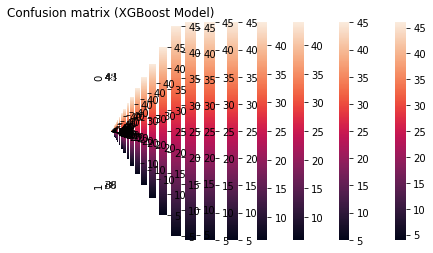

In [32]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import optuna
import shap
import xgboost as xgb

# Initialize variables to store results
shap_values_list = []
shap_dfs = []

# Number of iterations
n_iterations = 50


for i in range(n_iterations):
    # Step 2: Initial sampling
    majority_class = df[df['Outcome'] == 0]
    minority_class = df[df['Outcome'] == 1]

    # Define the number of samples to select
    n_samples = 50

    # Perform random sampling
    sampled_majority = majority_class.sample(n_samples, random_state=123)
    sampled_minority = minority_class.sample(n_samples, random_state=123)

    # Combine sampled data
    sampled_df = pd.concat([sampled_majority, sampled_minority])

    # Test data
    y_test = sampled_df['Outcome']
    x_test = sampled_df.drop(columns='Outcome')

    # Train data
    # Separate remaining data for training
    remaining_df = df.drop(sampled_df.index)
    y_train = remaining_df['Outcome']
    x_train = remaining_df.drop(columns='Outcome')
    
    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train_ = scaler.transform(x_train)
    x_test_ = scaler.transform(x_test)
    
    # Modelling 
    # Creating and running our optimization
    study_xgb = optuna.create_study(direction='maximize', study_name="XGBoost")
    with parallel_backend('threading'):
        study_xgb.optimize(objective_xgb, n_trials=10, n_jobs=-1)

    # Evaluating our Optuna Trial
    print("Best trial:", study_xgb.best_trial.number)
    print("Best accuracy:", study_xgb.best_trial.value)
    print("Best hyperparameters:", study_xgb.best_params)

    # Train the best model
    best_param_xgb = study_xgb.best_params
    XGB = xgb.XGBClassifier(**best_param_xgb, random_state=42, use_label_encoder=False, eval_metric='logloss')
    
    XGB.fit(x_train_, y_train)
    y_pred_xgb = XGB.predict(x_test_)

    # Display results
    display_results(y_test, y_pred_xgb, cm_title="Confusion matrix (XGBoost Model)")

    # SHAP value computation using TreeExplainer
    explainer = shap.TreeExplainer(XGB)
    shap_values = explainer.shap_values(x_test_)

    # Extract SHAP values for class 1 (assuming binary classification)
    shap_values_array = abs(shap_values)  # Use index 1 for the minority class

    # Store the SHAP values for stability analysis
    shap_values_list.append(shap_values_array)

    # Create DataFrame with SHAP values
    shap_values_df = pd.DataFrame(shap_values_array, columns=x_test.columns)
    shap_values_df['Outcome'] = y_test.values

    # Append DataFrame to the list
    shap_dfs.append(shap_values_df)

    print(shap_values_df)

# Concatenate all SHAP DataFrames row-wise
all_shap_values_df = pd.concat(shap_dfs, ignore_index=True)

# Print the combined DataFrame
print(all_shap_values_df)

In [33]:
# Create an valuestability DataFrame
valuestability = pd.DataFrame()

def calc_val(col_name, df, row_id):
    # Calculate the sum and mean
    summ = 0
    for i in range(n_iterations):
        summ += df[col_name].iloc[row_id]
        
        row_id += n_samples*2
        

    mean = summ / n_iterations
    row_id -= n_iterations*n_samples*2
    

    # Calculate the variance
    diff = 0
    for i in range(n_iterations):
        diff += (df[col_name].iloc[row_id] - mean) ** 2
        row_id += n_samples*2

    numerator = (diff / (n_iterations - 1)) ** 0.5
    denominator = mean

    final = numerator / denominator

    return final

def add_to_df():
    arr =[]
    col = x_test.columns
    for c in col:
        print(c)
        for i in range(n_samples*2):
            arr.append(calc_val(c,all_shap_values_df, i))
 
        
        valuestability[c] = arr
        arr =[]



In [34]:
# Call the add_to_df function to populate valuestability
add_to_df()
valuestability

cv = valuestability.sum(axis=1) / valuestability.shape[1]
valuestability['CV'] = cv

# Save the DataFrame to an Excel file
valuestability.to_excel('30_xg_valuestability.xlsx', index=False)
valuestability

Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DPF
Age


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,CV
0,0.903093,0.302708,0.915890,0.446649,0.659920,0.464508,0.356497,0.376936,0.553275
1,0.979061,0.247832,0.934818,0.617344,0.229860,0.378997,0.539342,0.423836,0.543886
2,0.745930,0.236622,0.660911,0.392963,0.444586,0.422467,0.521096,0.434165,0.482343
3,0.760912,0.297628,0.601924,0.328100,0.228186,0.529055,0.437098,0.326889,0.438724
4,0.811430,0.274921,0.549788,0.409290,0.353853,0.341218,0.435240,0.487636,0.457922
...,...,...,...,...,...,...,...,...,...
95,0.731037,0.386384,0.497348,0.362776,0.861392,0.415951,0.545138,0.392032,0.524007
96,0.887415,0.221454,0.632186,0.801155,0.212763,0.336444,0.810723,0.311411,0.526694
97,0.774275,0.215555,0.766510,0.634665,0.340013,0.640038,0.579443,0.223137,0.521705
98,0.681152,0.513306,0.672792,0.600369,0.205636,0.710255,0.523654,0.348615,0.531972
